Data preprocessing

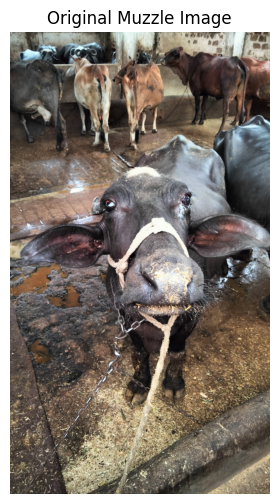

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Load sample image
image = cv2.imread(r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\INDIVIDUAL SUBJECTS Data\cattle-001\IMG20230723072804.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Display
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.title("Original Muzzle Image")
plt.axis('off')
plt.show()

Size of the dataset

In [4]:
import os
from collections import Counter

dataset_path = r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\INDIVIDUAL SUBJECTS Data"

# Count cattle and images
cattle_folders = os.listdir(dataset_path)
image_counts = []

for cattle_id in cattle_folders:
    cattle_path = os.path.join(dataset_path, cattle_id)
    if os.path.isdir(cattle_path):
        images = [f for f in os.listdir(cattle_path) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        image_counts.append(len(images))

print(f"Total cattle: {len(cattle_folders)}")
print(f"Total images: {sum(image_counts)}")
print(f"Images per cattle: Min={min(image_counts)}, Max={max(image_counts)}, Avg={sum(image_counts)/len(image_counts):.1f}")

Total cattle: 460
Total images: 2846
Images per cattle: Min=1, Max=38, Avg=6.2


Resize the dataset

In [6]:
import cv2
import os

input_root = r'C:\Users\Amrit Shah\Desktop\Muzzle based Identification\INDIVIDUAL SUBJECTS Data'
output_root = 'resized_dataset'
resize_dim = (224, 224)

# Make sure output root folder exists
os.makedirs(output_root, exist_ok=True)

# Loop through all cattle folders
for cattle_folder in os.listdir(input_root):
    cattle_path = os.path.join(input_root, cattle_folder)
    
    # Check if it's a directory
    if not os.path.isdir(cattle_path):
        continue

    # Create corresponding output folder
    output_cattle_path = os.path.join(output_root, cattle_folder)
    os.makedirs(output_cattle_path, exist_ok=True)

    # Loop through images in each cattle folder
    for img_name in os.listdir(cattle_path):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue  # skip non-image files

        img_path = os.path.join(cattle_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Skipped unreadable file: {img_path}")
            continue

        resized_img = cv2.resize(img, resize_dim)
        cv2.imwrite(os.path.join(output_cattle_path, img_name), resized_img)

print("✅ All images resized successfully!")


✅ All images resized successfully!


In [ ]:
import os
import cv2


from matplotlib import pyplot as plt

# Load the trained cascade classifier
cascade_path = r'C:\Users\Amrit Shah\Desktop\Muzzle based Identification\HOMBENAI\script_cascade\output\64\cascade.xml'
print(f"Loading cascade classifier from: {cascade_path}")
nose_cascade = cv2.CascadeClassifier(cascade_path)

if nose_cascade.empty():
    raise ValueError("Error loading cascade classifier")
print("Cascade classifier loaded successfully")

# Directory structure: dataset_root/
#   ├── cow_001/
#   │   ├── image1.jpg
#   │   ├── image2.jpg
#   ├── cow_002/
#   │   ├── image1.jpg
dataset_root = r'C:\Users\Amrit Shah\Desktop\Muzzle based Identification\INDIVIDUAL SUBJECTS Data'  # Change to your dataset path
output_root = 'detected_muzzles'  # Where to save muzzle crops

# Create output directories
os.makedirs(output_root, exist_ok=True)

# Process each cow folder
for cow_folder in os.listdir(dataset_root):
    cow_path = os.path.join(dataset_root, cow_folder)
    
    if not os.path.isdir(cow_path):
        continue
        
    print(f"\nProcessing cow: {cow_folder}")
    
    # Create output folder for this cow
    cow_output = os.path.join(output_root, cow_folder)
    os.makedirs(cow_output, exist_ok=True)
    
    # Process each image in the cow folder
    for img_file in os.listdir(cow_path):
        if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
            
        img_path = os.path.join(cow_path, img_file)
        print(f"  Processing: {img_file}")
        
        # Load image
        image = cv2.imread(img_path)
        if image is None:
            print(f"    Error loading image: {img_path}")
            continue
            
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Detect muzzles
        muzzles = nose_cascade.detectMultiScale(
            gray, 
            scaleFactor=1.1, 
            minNeighbors=5, 
            minSize=(30, 30)
        )
        
        if len(muzzles) == 0:
            print("    No muzzles detected")
            continue
            
        print(f"    Detected {len(muzzles)} muzzle(s)")
        
        # Save each detected muzzle
        for i, (x, y, w, h) in enumerate(muzzles):
            # Crop muzzle region
            muzzle_crop = image[y:y+h, x:x+w]
            
            # Save with original filename + detection index
            output_path = os.path.join(
                cow_output, 
                f"{os.path.splitext(img_file)[0]}_muzzle_{i}.jpg")
            
            cv2.imwrite(output_path, muzzle_crop)
            
            # Draw rectangle on original image (for visualization)
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Save visualization image (optional)
        viz_path = os.path.join(cow_output, f"{os.path.splitext(img_file)[0]}_detection.jpg")
        cv2.imwrite(viz_path, image)

print("\nProcessing complete!")
print(f"Muzzle crops saved to: {output_root}")

DOwnloading the labeled dataset from the roboflow

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="vvnxIl8xqhxCRZDfGyyn")
project = rf.workspace("cattle-muzzle-detection").project("cattle-muzzle-detection-k3nsr")
version = project.version(1)
dataset = version.download("darknet")


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Cattle-Muzzle-Detection-1 in darknet:: 100%|██████████| 296/296 [00:00<00:00, 715.00it/s]


In [2]:
import os
import cv2
import numpy as np
import pandas as pd

import shutil
from pathlib import Path
import yaml
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image


Setup and Configuration

In [3]:
class CattleMuzzleDetector:
    def __init__(self, base_dir="cattle_detection"):
        self.base_dir = Path(base_dir)
        self.setup_directories()
        
    def setup_directories(self):
        """Create necessary directory structure"""
        dirs = [
            'datasets/labeled/images/train',
            'datasets/labeled/images/val', 
            'datasets/labeled/labels/train',
            'datasets/labeled/labels/val',
            'datasets/unlabeled/images',
            'datasets/pseudo_labeled/images',
            'datasets/pseudo_labeled/labels',
            'datasets/combined/images/train',
            'datasets/combined/images/val',
            'datasets/combined/labels/train', 
            'datasets/combined/labels/val',
            'models',
            'results'
        ]
        
        for dir_path in dirs:
            (self.base_dir / dir_path).mkdir(parents=True, exist_ok=True)
        print("Directory structure created successfully!")

detector = CattleMuzzleDetector()

Directory structure created successfully!


In [6]:
from pathlib import Path
import shutil
import yaml

def download_roboflow_data(api_key, workspace, project, version):
    """Download labeled dataset from Roboflow"""
    from roboflow import Roboflow
    
    rf = Roboflow(api_key="vvnxIl8xqhxCRZDfGyyn")
    project = rf.workspace(workspace).project(project)
    dataset = project.version(version).download("yolov8")
    
    return dataset.location

def prepare_labeled_data(roboflow_path, detector):
    """Prepare labeled data in YOLO format"""
    
    # Create data.yaml for YOLO training with RELATIVE paths
    data_yaml = {
        'train': 'images/train',      # Relative path
        'val': 'images/val',          # Relative path
        'nc': 1,  # number of classes (muzzle)
        'names': ['muzzle']
    }
    
    with open(detector.base_dir / 'datasets/labeled/data.yaml', 'w') as f:
        yaml.dump(data_yaml, f)
    
    # Copy roboflow data to our structure
    roboflow_path = Path(roboflow_path)
    
    # Copy training data
    if (roboflow_path / 'train').exists():
        for img_file in (roboflow_path / 'train/images').glob('*'):
            shutil.copy(img_file, detector.base_dir / 'datasets/labeled/images/train')
        for label_file in (roboflow_path / 'train/labels').glob('*'):
            shutil.copy(label_file, detector.base_dir / 'datasets/labeled/labels/train')
    
    # Copy validation data
    if (roboflow_path / 'valid').exists():
        for img_file in (roboflow_path / 'valid/images').glob('*'):
            shutil.copy(img_file, detector.base_dir / 'datasets/labeled/images/val')
        for label_file in (roboflow_path / 'valid/labels').glob('*'):
            shutil.copy(label_file, detector.base_dir / 'datasets/labeled/labels/val')
    
    print("Labeled data prepared successfully!")

if __name__ == "__main__":
    # First create the detector (to make folders)
    detector = CattleMuzzleDetector()
    print(f"Detector base directory: {detector.base_dir}")
    
    # Then download and prepare data
    workspace = "cattle-muzzle-detection"      # Replace with your workspace
    project = "cattle-muzzle-detection-k3nsr"          # Replace with your project name  
    version = 1                            # Replace with your version number
    
    # Download data from Roboflow
    dataset_path = download_roboflow_data("vvnxIl8xqhxCRZDfGyyn", workspace, project, version)
    
    dataset_path = Path(dataset_path)
    print(f"Dataset path exists: {dataset_path.exists()}")
    if dataset_path.exists():
        print(f"Contents: {list(dataset_path.iterdir())}")

    # Organize the downloaded data
    prepare_labeled_data(dataset_path, detector)


Directory structure created successfully!
Detector base directory: cattle_detection
loading Roboflow workspace...
loading Roboflow project...
Dataset path exists: True
Contents: [WindowsPath('c:/Users/Amrit Shah/Desktop/Muzzle based Identification/Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal/Cattle-Muzzle-Detection-1/README.dataset.txt'), WindowsPath('c:/Users/Amrit Shah/Desktop/Muzzle based Identification/Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal/Cattle-Muzzle-Detection-1/README.roboflow.txt'), WindowsPath('c:/Users/Amrit Shah/Desktop/Muzzle based Identification/Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal/Cattle-Muzzle-Detection-1/test'), WindowsPath('c:/Users/Amrit Shah/Desktop/Muzzle based Identification/Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal/Cattle-Muzzle-Detection-1/train'), WindowsPath('c:/Users/Amrit Shah/Desktop/Muzzle based Identification/Muzzle-Based-Biometric-Identification-System-F

In [7]:
from ultralytics import YOLO
import torch

def train_initial_model(detector, epochs=100, img_size=640):
    """Train initial YOLO model on labeled data"""
    
    # Load pre-trained YOLOv8 model
    model = YOLO('yolov8n.pt')  # or yolov8s.pt for better accuracy
    
    # Train the model
    results = model.train(
        data=str(detector.base_dir / 'datasets/labeled/data.yaml'),
        epochs=epochs,
        imgsz=img_size,
        batch=16,
        name='cattle_muzzle_initial',
        project=str(detector.base_dir / 'models'),
        save_period=10,
        patience=20,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    
    # Save the best model
    best_model_path = detector.base_dir / 'models/cattle_muzzle_initial/weights/best.pt'
    shutil.copy(best_model_path, detector.base_dir / 'models/initial_model.pt')
    
    print("Initial model training completed!")
    return str(detector.base_dir / 'models/initial_model.pt')

if __name__ == "__main__":
    # First create the detector and prepare data (if not done already)
    detector = CattleMuzzleDetector()
    
    # Your Roboflow download code (if not done already)
    workspace = "cattle-muzzle-detection"
    project = "cattle-muzzle-detection-k3nsr"
    version = 1
    
    # dataset_path = download_roboflow_data("vvnxIl8xqhxCRZDfGyyn", workspace, project, version)
    # prepare_labeled_data(dataset_path, detector)
    
    # NOW START TRAINING:
    print("Starting model training...")
    model_path = train_initial_model(detector, epochs=100, img_size=640)  # Reduced epochs for testing
    print(f"Training completed! Model saved at: {model_path}")



Directory structure created successfully!
Starting model training...
Ultralytics 8.3.168  Python-3.11.9 torch-2.7.1+cpu CPU (11th Gen Intel Core(TM) i5-1145G7 2.60GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cattle_detection\datasets\labeled\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=cattle_muzzle_initial2, nbs=64, nms=False, opset=None

train: Scanning C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\labeled\labels\train... 126 images, 0 backgrounds, 0 corrupt: 100%|██████████| 126/126 [00:00<00:00, 162.91it/s]

train: New cache created: C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\labeled\labels\train.cache
val: Fast image access  (ping: 0.10.0 ms, read: 685.9150.8 MB/s, size: 88.7 KB)



'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
val: Scanning C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\labeled\labels\val... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<00:00, 337.23it/s]

val: New cache created: C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\labeled\labels\val.cache



'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.


Plotting labels to cattle_detection\models\cattle_muzzle_initial2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to cattle_detection\models\cattle_muzzle_initial2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.858      3.394      2.005         30        640: 100%|██████████| 8/8 [00:33<00:00,  4.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.93s/it]

                   all         12         12    0.00333          1      0.563      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.453      2.189      1.557         29        640: 100%|██████████| 8/8 [00:46<00:00,  5.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]

                   all         12         12          1       0.22      0.937      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.332      1.735      1.376         37        640: 100%|██████████| 8/8 [00:52<00:00,  6.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]

                   all         12         12    0.00333          1      0.853      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.325      1.561      1.366         24        640: 100%|██████████| 8/8 [00:52<00:00,  6.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]

                   all         12         12    0.00333          1      0.627      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.278      1.506      1.369         25        640: 100%|██████████| 8/8 [00:52<00:00,  6.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]

                   all         12         12    0.00333          1      0.618      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.342      1.523       1.38         25        640: 100%|██████████| 8/8 [00:57<00:00,  7.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]

                   all         12         12       0.36      0.328      0.352      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.265      1.372      1.341         23        640: 100%|██████████| 8/8 [00:51<00:00,  6.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]

                   all         12         12          1      0.382      0.728      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.177      1.341      1.319         21        640: 100%|██████████| 8/8 [00:51<00:00,  6.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]

                   all         12         12      0.394     0.0833      0.487      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G       1.29      1.335      1.363         33        640: 100%|██████████| 8/8 [00:52<00:00,  6.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]

                   all         12         12      0.483      0.167      0.341      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.235      1.278      1.306         28        640: 100%|██████████| 8/8 [00:52<00:00,  6.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

                   all         12         12      0.463      0.167      0.286      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.271      1.209      1.338         28        640: 100%|██████████| 8/8 [00:52<00:00,  6.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

                   all         12         12       0.38      0.417      0.291      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G       1.34      1.233      1.303         35        640: 100%|██████████| 8/8 [00:51<00:00,  6.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]

                   all         12         12      0.328      0.583      0.436      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.378      1.242      1.381         30        640: 100%|██████████| 8/8 [00:54<00:00,  6.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]

                   all         12         12      0.762      0.333      0.491      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.343      1.171      1.334         25        640: 100%|██████████| 8/8 [00:52<00:00,  6.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]

                   all         12         12      0.171      0.333       0.18     0.0472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.306       1.21      1.343         24        640: 100%|██████████| 8/8 [00:51<00:00,  6.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]

                   all         12         12       0.23        0.5       0.24     0.0861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.245      1.178      1.294         22        640: 100%|██████████| 8/8 [00:52<00:00,  6.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

                   all         12         12      0.241      0.583      0.182     0.0655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G       1.28      1.062      1.285         35        640: 100%|██████████| 8/8 [00:50<00:00,  6.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

                   all         12         12      0.198       0.25      0.204      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.268      1.091      1.325         23        640: 100%|██████████| 8/8 [00:51<00:00,  6.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

                   all         12         12      0.456       0.75      0.586      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.213      1.007       1.27         32        640: 100%|██████████| 8/8 [00:48<00:00,  6.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

                   all         12         12          1       0.56      0.723      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.198     0.9854      1.277         26        640: 100%|██████████| 8/8 [00:49<00:00,  6.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]

                   all         12         12      0.964        0.5      0.644       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.231     0.9825      1.277         30        640: 100%|██████████| 8/8 [00:45<00:00,  5.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

                   all         12         12      0.784      0.667      0.709      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.081     0.9255      1.205         23        640: 100%|██████████| 8/8 [00:40<00:00,  5.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all         12         12      0.981      0.583      0.702      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.152     0.9448      1.273         23        640: 100%|██████████| 8/8 [00:39<00:00,  4.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         12         12      0.989        0.5      0.546      0.278
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 3, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



23 epochs completed in 0.335 hours.
Optimizer stripped from cattle_detection\models\cattle_muzzle_initial2\weights\last.pt, 6.2MB
Optimizer stripped from cattle_detection\models\cattle_muzzle_initial2\weights\best.pt, 6.2MB

Validating cattle_detection\models\cattle_muzzle_initial2\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.9 torch-2.7.1+cpu CPU (11th Gen Intel Core(TM) i5-1145G7 2.60GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


                   all         12         12    0.00333          1      0.853      0.579
Speed: 13.5ms preprocess, 92.8ms inference, 0.0ms loss, 15.5ms postprocess per image
Results saved to cattle_detection\models\cattle_muzzle_initial2


FileNotFoundError: [Errno 2] No such file or directory: 'cattle_detection\\models\\cattle_muzzle_initial\\weights\\best.pt'

In [22]:
from ultralytics import YOLO

def train_yolo_muzzle(data_yaml_path, model_size='yolov8n.yaml', epochs=100, imgsz=640, batch=16, device='cuda'):
    """
    Train a YOLOv8 model for cattle muzzle detection.

    Parameters:
        data_yaml_path (str): Path to data.yaml file
        model_size (str): YOLO model variant (e.g., 'yolov8n.yaml', 'yolov8s.yaml')
        epochs (int): Number of training epochs
        imgsz (int): Input image size (square)
        batch (int): Batch size
        device (str): 'cuda' or 'cpu'
    """
    model = YOLO(model_size)
    model.train(
        data=data_yaml_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        device=device,
        project="cattle_muzzle_training",
        name="yolov8_muzzle",
        workers=4,
        verbose=True
    )
    print("\n✅ Training completed!")


In [25]:
train_yolo_muzzle(
    data_yaml_path=r'C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\labeled\data.yaml',
    model_size='yolov8n.yaml',  # or 'yolov8s.yaml', 'yolov8m.yaml'
    epochs=100,
    imgsz=640,
    batch=16,
    device='cpu'  # or 'cpu'
)


Ultralytics 8.3.168  Python-3.11.9 torch-2.7.1+cpu CPU (11th Gen Intel Core(TM) i5-1145G7 2.60GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\labeled\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, nam

train: Scanning C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\labeled\labels\train.cache... 126 images, 0 backgrounds, 0 corrupt: 100%|██████████| 126/126 [00:00<?, ?it/s]

val: Fast image access  (ping: 0.20.2 ms, read: 49.961.1 MB/s, size: 88.7 KB)



'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
val: Scanning C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\labeled\labels\val.cache... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<?, ?it/s]

Plotting labels to cattle_muzzle_training\yolov8_muzzle\labels.jpg... 



'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to cattle_muzzle_training\yolov8_muzzle
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      3.513       4.32      4.416         30        640: 100%|██████████| 8/8 [00:33<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all         12         12   0.000278     0.0833   0.000169   1.69e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      3.283      3.938       4.23         29        640: 100%|██████████| 8/8 [00:37<00:00,  4.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

                   all         12         12   0.000278     0.0833    0.00017    1.7e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      3.101      3.784      4.098         37        640: 100%|██████████| 8/8 [00:52<00:00,  6.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

                   all         12         12   0.000278     0.0833   0.000179   1.79e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      2.977      3.588      3.984         24        640: 100%|██████████| 8/8 [00:48<00:00,  6.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

                   all         12         12   0.000278     0.0833   0.000175   1.75e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G       2.78      3.608       3.89         25        640: 100%|██████████| 8/8 [00:48<00:00,  6.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

                   all         12         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      2.906      3.393      3.769         25        640: 100%|██████████| 8/8 [00:47<00:00,  5.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

                   all         12         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      2.827      3.226      3.559         23        640: 100%|██████████| 8/8 [00:48<00:00,  6.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all         12         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      2.713      3.277      3.533         21        640: 100%|██████████| 8/8 [00:53<00:00,  6.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

                   all         12         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      2.723      3.067      3.364         33        640: 100%|██████████| 8/8 [00:47<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

                   all         12         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      2.728      3.116      3.364         28        640: 100%|██████████| 8/8 [00:50<00:00,  6.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

                   all         12         12   0.000278     0.0833   0.000428   4.28e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      2.594      3.096      3.311         28        640: 100%|██████████| 8/8 [00:55<00:00,  6.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

                   all         12         12          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      2.638      2.969      3.313         35        640: 100%|██████████| 8/8 [00:55<00:00,  6.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

                   all         12         12   0.000278     0.0833    0.00063   0.000126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      2.766      2.984      3.209         30        640: 100%|██████████| 8/8 [00:56<00:00,  7.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

                   all         12         12    0.00139      0.417     0.0124    0.00196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      2.545      2.838        3.1         25        640: 100%|██████████| 8/8 [00:43<00:00,  5.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

                   all         12         12    0.00243      0.583     0.0138    0.00158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      2.608      2.699      3.059         24        640: 100%|██████████| 8/8 [00:40<00:00,  5.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all         12         12     0.0554        0.5     0.0431     0.0159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      2.605      2.926      3.137         22        640: 100%|██████████| 8/8 [00:36<00:00,  4.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         12         12    0.00314      0.833      0.021    0.00459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      2.533      2.685      3.123         35        640: 100%|██████████| 8/8 [00:36<00:00,  4.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all         12         12     0.0848      0.333     0.0656     0.0235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      2.498      2.683      3.033         23        640: 100%|██████████| 8/8 [00:36<00:00,  4.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         12         12      0.931      0.333      0.369      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      2.546      2.641      3.044         32        640: 100%|██████████| 8/8 [00:36<00:00,  4.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         12         12      0.469      0.417      0.395       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      2.487      2.561      2.943         26        640: 100%|██████████| 8/8 [00:35<00:00,  4.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         12         12      0.897        0.5      0.514      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      2.575      2.482      2.922         30        640: 100%|██████████| 8/8 [00:35<00:00,  4.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all         12         12      0.215      0.583      0.187     0.0631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G        2.5      2.422      2.885         23        640: 100%|██████████| 8/8 [00:35<00:00,  4.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         12         12      0.206       0.75      0.177     0.0718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      2.415      2.423      2.751         23        640: 100%|██████████| 8/8 [00:35<00:00,  4.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         12         12      0.213      0.667      0.539      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G       2.48      2.385      2.832         26        640: 100%|██████████| 8/8 [00:35<00:00,  4.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         12         12      0.492     0.0833      0.116     0.0251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      2.407      2.314      2.837         24        640: 100%|██████████| 8/8 [00:35<00:00,  4.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         12         12      0.127     0.0833     0.0553     0.0196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      2.282       2.18      2.836         26        640: 100%|██████████| 8/8 [00:35<00:00,  4.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

                   all         12         12      0.643      0.583      0.579      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      2.433      2.317      2.819         24        640: 100%|██████████| 8/8 [00:36<00:00,  4.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         12         12      0.354      0.594      0.621      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      2.269      2.189      2.739         35        640: 100%|██████████| 8/8 [00:35<00:00,  4.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all         12         12      0.322          1       0.66      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      2.257      2.135      2.829         30        640: 100%|██████████| 8/8 [00:34<00:00,  4.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all         12         12      0.251       0.75      0.511      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      2.292      2.168      2.749         32        640: 100%|██████████| 8/8 [00:37<00:00,  4.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all         12         12      0.245        0.5      0.213     0.0702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G       2.17      2.057      2.701         27        640: 100%|██████████| 8/8 [00:34<00:00,  4.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all         12         12      0.369      0.333      0.254     0.0824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      2.216      2.067      2.755         24        640: 100%|██████████| 8/8 [00:34<00:00,  4.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         12         12      0.759      0.417      0.634      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      2.318       2.05      2.772         34        640: 100%|██████████| 8/8 [00:34<00:00,  4.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

                   all         12         12      0.445        0.5      0.361      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      2.201      2.049      2.699         33        640: 100%|██████████| 8/8 [00:34<00:00,  4.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

                   all         12         12      0.564      0.583      0.542      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      2.099      1.906       2.66         23        640: 100%|██████████| 8/8 [00:34<00:00,  4.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all         12         12      0.412      0.761      0.532      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      2.098      1.939      2.591         35        640: 100%|██████████| 8/8 [00:34<00:00,  4.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all         12         12      0.429      0.333      0.359     0.0919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      2.199      2.011      2.637         30        640: 100%|██████████| 8/8 [00:34<00:00,  4.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         12         12      0.574      0.833       0.72      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      2.047      1.926      2.571         27        640: 100%|██████████| 8/8 [00:34<00:00,  4.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         12         12      0.905       0.75      0.835      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      2.042      1.846      2.597         26        640: 100%|██████████| 8/8 [00:35<00:00,  4.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         12         12      0.637      0.583       0.67      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      2.016       1.88      2.553         22        640: 100%|██████████| 8/8 [00:34<00:00,  4.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         12         12       0.74      0.712      0.881       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      2.005      1.852      2.597         27        640: 100%|██████████| 8/8 [00:34<00:00,  4.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         12         12          1      0.566      0.674      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      2.008      1.821      2.615         27        640: 100%|██████████| 8/8 [00:34<00:00,  4.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         12         12      0.914      0.417      0.532      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      1.987      1.883      2.511         23        640: 100%|██████████| 8/8 [00:34<00:00,  4.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         12         12       0.28        0.5      0.297      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      1.976      1.853      2.504         34        640: 100%|██████████| 8/8 [00:34<00:00,  4.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         12         12      0.546      0.667      0.503      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      1.884       1.75      2.489         26        640: 100%|██████████| 8/8 [00:34<00:00,  4.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         12         12      0.359      0.833      0.477      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G      1.971      1.763      2.503         35        640: 100%|██████████| 8/8 [00:35<00:00,  4.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         12         12      0.736      0.667      0.711      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      1.919      1.707      2.454         27        640: 100%|██████████| 8/8 [00:34<00:00,  4.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         12         12      0.575       0.75       0.63      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G       1.91      1.678      2.426         29        640: 100%|██████████| 8/8 [00:35<00:00,  4.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         12         12      0.929      0.583      0.726      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G      1.878      1.692      2.391         29        640: 100%|██████████| 8/8 [00:34<00:00,  4.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         12         12      0.964      0.667      0.737      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G      1.925      1.651      2.476         26        640: 100%|██████████| 8/8 [00:35<00:00,  4.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         12         12      0.817      0.742      0.789      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G       1.79      1.563      2.297         27        640: 100%|██████████| 8/8 [00:35<00:00,  4.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         12         12      0.723      0.583      0.664      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      1.887      1.575      2.394         22        640: 100%|██████████| 8/8 [00:34<00:00,  4.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         12         12      0.524        0.5      0.465      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G      1.912      1.699      2.346         30        640: 100%|██████████| 8/8 [00:35<00:00,  4.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         12         12      0.733      0.583      0.668      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G       1.82      1.575      2.333         29        640: 100%|██████████| 8/8 [00:35<00:00,  4.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         12         12       0.61      0.833      0.745      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G      1.788      1.571      2.362         30        640: 100%|██████████| 8/8 [00:35<00:00,  4.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         12         12        0.9      0.748       0.82      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G      1.817      1.514      2.351         26        640: 100%|██████████| 8/8 [00:36<00:00,  4.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

                   all         12         12      0.672      0.684      0.814      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G      1.839      1.572      2.326         27        640: 100%|██████████| 8/8 [00:37<00:00,  4.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         12         12      0.608      0.917      0.815      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G      1.741      1.522      2.306         31        640: 100%|██████████| 8/8 [00:34<00:00,  4.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         12         12      0.816      0.833      0.839       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G      1.818       1.52      2.281         40        640: 100%|██████████| 8/8 [00:34<00:00,  4.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         12         12       0.54      0.833       0.66      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G      1.769      1.475      2.273         23        640: 100%|██████████| 8/8 [00:34<00:00,  4.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         12         12      0.664       0.75      0.697      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G      1.691      1.389      2.262         32        640: 100%|██████████| 8/8 [00:34<00:00,  4.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

                   all         12         12      0.553        0.5      0.449      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      1.844      1.487      2.355         28        640: 100%|██████████| 8/8 [00:35<00:00,  4.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         12         12      0.968      0.417      0.582      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G      1.697      1.435      2.278         31        640: 100%|██████████| 8/8 [00:34<00:00,  4.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

                   all         12         12      0.528      0.667      0.446      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      1.701      1.468      2.298         30        640: 100%|██████████| 8/8 [00:34<00:00,  4.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         12         12      0.684      0.543      0.578      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G      1.707      1.372      2.274         26        640: 100%|██████████| 8/8 [00:34<00:00,  4.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         12         12      0.983       0.75      0.919       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G      1.775      1.405      2.257         27        640: 100%|██████████| 8/8 [00:34<00:00,  4.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all         12         12      0.906      0.801      0.871      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G      1.668      1.401      2.254         29        640: 100%|██████████| 8/8 [00:36<00:00,  4.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

                   all         12         12      0.821      0.765      0.858      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G       1.65      1.406      2.199         31        640: 100%|██████████| 8/8 [00:35<00:00,  4.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         12         12      0.753      0.765      0.804      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G      1.667      1.431      2.218         32        640: 100%|██████████| 8/8 [00:35<00:00,  4.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         12         12      0.833       0.83      0.848      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G      1.561      1.335      2.167         28        640: 100%|██████████| 8/8 [00:34<00:00,  4.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         12         12      0.843      0.583      0.739      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G      1.728      1.437      2.255         32        640: 100%|██████████| 8/8 [00:35<00:00,  4.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         12         12      0.946      0.667      0.741      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G      1.619      1.393      2.211         23        640: 100%|██████████| 8/8 [00:34<00:00,  4.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         12         12      0.879       0.75      0.765      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G       1.68      1.309      2.193         29        640: 100%|██████████| 8/8 [00:34<00:00,  4.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         12         12      0.974       0.75      0.775       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G      1.612      1.273      2.103         25        640: 100%|██████████| 8/8 [00:35<00:00,  4.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         12         12      0.823       0.75      0.739      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G      1.601      1.303      2.143         29        640: 100%|██████████| 8/8 [00:34<00:00,  4.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         12         12      0.865       0.75      0.764      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G      1.577      1.239       2.09         30        640: 100%|██████████| 8/8 [00:35<00:00,  4.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         12         12      0.973       0.75      0.832      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G      1.635      1.317      2.164         34        640: 100%|██████████| 8/8 [00:35<00:00,  4.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         12         12      0.986      0.833      0.872      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G      1.623      1.305      2.133         33        640: 100%|██████████| 8/8 [00:35<00:00,  4.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         12         12       0.98       0.75      0.832      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G       1.57      1.257      2.123         21        640: 100%|██████████| 8/8 [00:35<00:00,  4.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         12         12          1       0.74      0.795       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G       1.62      1.348      2.176         25        640: 100%|██████████| 8/8 [00:35<00:00,  4.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         12         12      0.959       0.75      0.762      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G      1.571      1.309      2.151         20        640: 100%|██████████| 8/8 [00:34<00:00,  4.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         12         12      0.991       0.75      0.758      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G      1.575      1.263      2.092         25        640: 100%|██████████| 8/8 [00:35<00:00,  4.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         12         12          1       0.71      0.756      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G      1.565      1.224      2.113         30        640: 100%|██████████| 8/8 [00:35<00:00,  4.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         12         12      0.994       0.75      0.753      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G      1.659      1.231      2.159         35        640: 100%|██████████| 8/8 [00:34<00:00,  4.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         12         12      0.928      0.667      0.748      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G      1.515      1.283      2.074         31        640: 100%|██████████| 8/8 [00:35<00:00,  4.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         12         12      0.862       0.75      0.769      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G      1.515      1.228      2.055         27        640: 100%|██████████| 8/8 [00:34<00:00,  4.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         12         12      0.909      0.829      0.891      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G      1.513      1.254      2.061         28        640: 100%|██████████| 8/8 [00:35<00:00,  4.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         12         12      0.805       0.75      0.823      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G      1.543      1.271      2.069         29        640: 100%|██████████| 8/8 [00:35<00:00,  4.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         12         12          1      0.728      0.841      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      1.429      1.159      2.011         31        640: 100%|██████████| 8/8 [00:34<00:00,  4.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         12         12      0.993      0.667      0.809      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G      1.485       1.23      2.075         22        640: 100%|██████████| 8/8 [00:35<00:00,  4.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         12         12      0.879       0.75      0.789       0.37


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
     91/100         0G      1.413      1.351      2.009         14        640: 100%|██████████| 8/8 [00:34<00:00,  4.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         12         12      0.985       0.75      0.781      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G      1.273      1.211      1.911         14        640: 100%|██████████| 8/8 [00:34<00:00,  4.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         12         12      0.883      0.667      0.748       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G      1.328      1.092      1.878         14        640: 100%|██████████| 8/8 [00:34<00:00,  4.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         12         12      0.964       0.75      0.822       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G      1.312      1.042      1.823         14        640: 100%|██████████| 8/8 [00:34<00:00,  4.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         12         12      0.783      0.917      0.864      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G      1.301      1.042      1.874         14        640: 100%|██████████| 8/8 [00:34<00:00,  4.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         12         12      0.744      0.833      0.814      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G       1.29          1      1.884         14        640: 100%|██████████| 8/8 [00:34<00:00,  4.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         12         12      0.705      0.833      0.838      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G      1.179     0.9931       1.76         14        640: 100%|██████████| 8/8 [00:34<00:00,  4.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         12         12        0.7      0.833      0.851      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G      1.228     0.9841      1.803         14        640: 100%|██████████| 8/8 [00:40<00:00,  5.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         12         12      0.695      0.917      0.852      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G      1.184     0.9153      1.779         14        640: 100%|██████████| 8/8 [00:35<00:00,  4.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         12         12      0.685      0.907       0.84      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G      1.217     0.9505      1.795         14        640: 100%|██████████| 8/8 [00:34<00:00,  4.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         12         12      0.811      0.718      0.832       0.36



100 epochs completed in 1.085 hours.
Optimizer stripped from cattle_muzzle_training\yolov8_muzzle\weights\last.pt, 6.3MB
Optimizer stripped from cattle_muzzle_training\yolov8_muzzle\weights\best.pt, 6.3MB

Validating cattle_muzzle_training\yolov8_muzzle\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.9 torch-2.7.1+cpu CPU (11th Gen Intel Core(TM) i5-1145G7 2.60GHz)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


                   all         12         12          1      0.739      0.795      0.483
Speed: 1.2ms preprocess, 78.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to cattle_muzzle_training\yolov8_muzzle

✅ Training completed!


In [26]:
model.save('custom_model_name.pt')


In [30]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load the trained model
model = YOLO(r'C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\custom_model_name.pt')  # Update path if needed
model = YOLO(model)

# Path to the test image
image_path = r'C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\labeled\images\train\IMG20230723072807_jpg.rf.0436fb2a1e32e7ef85e8083c09d19b28.jpg'  # Change to your image path

# Run detection
results = model(image_path)

for result in results:
    boxes = result.boxes
    image = cv2.imread(image_path)
    
    if boxes is not None and boxes.xyxy is not None:
        for box in boxes.xyxy:
            x1, y1, x2, y2 = map(int, box[:4])
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)



image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Show image with bounding box
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Muzzle Detection")
plt.show()



image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\labeled\images\train\IMG20230723072807_jpg.rf.0436fb2a1e32e7ef85e8083c09d19b28.jpg: 640x640 (no detections), 110.5ms
Speed: 83.5ms preprocess, 110.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


<Figure size 1000x600 with 1 Axes>

In [ ]:
# def generate_pseudo_labels(detector, model_path, unlabeled_images_dir, 
#                           confidence_threshold=0.7, low_conf_threshold=0.4):
#     """Generate pseudo-labels for unlabeled images"""
    
#     model = YOLO(model_path)
#     unlabeled_dir = Path(unlabeled_images_dir)
    
#     high_conf_predictions = []
#     low_conf_predictions = []
    
#     # Process all unlabeled images
#     image_files = list(unlabeled_dir.glob('*.jpg')) + list(unlabeled_dir.glob('*.png'))
    
#     for img_path in tqdm(image_files, desc="Generating pseudo-labels"):
#         # Run inference
#         results = model(img_path)
        
#         # Process results
#         for result in results:
#             boxes = result.boxes
#             if boxes is not None:
#                 confidences = boxes.conf.cpu().numpy()
#                 coordinates = boxes.xywhn.cpu().numpy()  # normalized coordinates
                
#                 # Filter by confidence
#                 for i, conf in enumerate(confidences):
#                     if conf >= confidence_threshold:
#                         # High confidence - auto-label
#                         high_conf_predictions.append({
#                             'image': img_path.name,
#                             'confidence': conf,
#                             'bbox': coordinates[i]
#                         })
                        
#                         # Save label file
#                         label_path = detector.base_dir / 'datasets/pseudo_labeled/labels' / f"{img_path.stem}.txt"
#                         with open(label_path, 'w') as f:
#                             x_center, y_center, width, height = coordinates[i]
#                             f.write(f"0 {x_center} {y_center} {width} {height}\n")
                        
#                         # Copy image
#                         shutil.copy(img_path, detector.base_dir / 'datasets/pseudo_labeled/images')
                        
#                     elif conf >= low_conf_threshold:
#                         # Low confidence - needs manual review
#                         low_conf_predictions.append({
#                             'image': img_path.name,
#                             'confidence': conf,
#                             'bbox': coordinates[i]
#                         })
    
#     # Save prediction statistics
#     stats = {
#         'high_confidence': len(high_conf_predictions),
#         'low_confidence': len(low_conf_predictions),
#         'total_processed': len(image_files)
#     }
    
#     with open(detector.base_dir / 'results/pseudo_label_stats.json', 'w') as f:
#         json.dump(stats, f, indent=2)
    
#     print(f"Pseudo-labeling completed!")
#     print(f"High confidence predictions: {stats['high_confidence']}")
#     print(f"Low confidence predictions (need review): {stats['low_confidence']}")
    
#     return high_conf_predictions, low_conf_predictions

In [19]:
import os
import shutil
import json
from pathlib import Path
from tqdm import tqdm
from ultralytics import YOLO

def generate_pseudo_labels(model_path, unlabeled_images_dir, output_dir,
                           confidence_threshold=0.7, low_conf_threshold=0.4):
    """
    Generate pseudo-labels for cattle muzzle detection using a trained YOLO model.
    Preserves cattle-ID folder structure.
    """
    model = YOLO(model_path)
    unlabeled_dir = Path(unlabeled_images_dir)
    output_dir = Path(output_dir)
    labels_root = output_dir / 'labels'
    images_root = output_dir / 'images'

    high_conf_predictions = []
    low_conf_predictions = []

    image_files = list(unlabeled_dir.rglob('*.jpg')) + list(unlabeled_dir.rglob('*.png'))

    for img_path in tqdm(image_files, desc="Generating pseudo-labels"):
        results = model(img_path)
        result = results[0]
        boxes = result.boxes

        if boxes is None or boxes.xywhn is None or len(boxes.xywhn) == 0:
            continue

        confidences = boxes.conf.cpu().numpy()
        coordinates = boxes.xywhn.cpu().numpy()
        class_ids = boxes.cls.cpu().numpy().astype(int)

        relative_path = img_path.relative_to(unlabeled_dir)
        cattle_id = relative_path.parts[0]

        label_dir = labels_root / cattle_id
        image_dir = images_root / cattle_id
        label_dir.mkdir(parents=True, exist_ok=True)
        image_dir.mkdir(parents=True, exist_ok=True)

        label_lines = []
        save_image = False

        for i, conf in enumerate(confidences):
            x, y, w, h = coordinates[i]
            class_id = class_ids[i]
            label_data = {
                'image': str(relative_path),
                'confidence': float(conf),
                'bbox': [x, y, w, h],
                'class_id': int(class_id)
            }

            if conf >= confidence_threshold:
                high_conf_predictions.append(label_data)
                label_lines.append(f"{class_id} {x} {y} {w} {h}\n")
                save_image = True
            elif conf >= low_conf_threshold:
                low_conf_predictions.append(label_data)

        if save_image and label_lines:
            label_path = label_dir / f"{img_path.stem}.txt"
            with open(label_path, 'w') as f:
                f.writelines(label_lines)

            shutil.copy(img_path, image_dir)

    stats = {
        'high_confidence': len(high_conf_predictions),
        'low_confidence': len(low_conf_predictions),
        'total_images_processed': len(image_files)
    }

    with open(output_dir / 'pseudo_label_stats.json', 'w') as f:
        json.dump(stats, f, indent=2)

    print("\n✅ Pseudo-labeling completed!")
    print(f"📌 High confidence predictions: {stats['high_confidence']}")
    print(f"📝 Low confidence predictions: {stats['low_confidence']}")
    print(f"📷 Total images processed: {stats['total_images_processed']}")

    return high_conf_predictions, low_conf_predictions


In [20]:
if __name__ == "__main__":
    generate_pseudo_labels(
        model_path=r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\models\cattle_muzzle_initial2\weights\best.pt",
        unlabeled_images_dir=r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images",  # contains cattle-001 to cattle-460
        output_dir=r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\pseudo_labeled",
        confidence_threshold=0.5,
        low_conf_threshold=0.2
    )


Generating pseudo-labels:   0%|          | 0/2846 [00:00<?, ?it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-001\IMG20230723072804.jpg: 640x640 (no detections), 86.5ms
Speed: 3.6ms preprocess, 86.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   0%|          | 1/2846 [00:00<08:11,  5.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-001\IMG20230723072807.jpg: 640x640 (no detections), 82.7ms
Speed: 2.5ms preprocess, 82.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-001\IMG20230723072809.jpg: 640x640 (no detections), 241.6ms
Speed: 2.5ms preprocess, 241.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   0%|          | 3/2846 [00:00<08:09,  5.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-001\IMG20230723072810.jpg: 640x640 (no detections), 106.7ms
Speed: 4.2ms preprocess, 106.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   0%|          | 4/2846 [00:00<07:55,  5.98it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-001\IMG20230723072813.jpg: 640x640 (no detections), 110.3ms
Speed: 2.6ms preprocess, 110.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   0%|          | 5/2846 [00:00<07:13,  6.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-001\IMG20230723072813_01.jpg: 640x640 (no detections), 160.8ms
Speed: 2.8ms preprocess, 160.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   0%|          | 6/2846 [00:00<07:28,  6.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-001\IMG20230723072815.jpg: 640x640 (no detections), 100.9ms
Speed: 4.0ms preprocess, 100.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   0%|          | 7/2846 [00:01<06:49,  6.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-001\IMG20230723072817.jpg: 640x640 (no detections), 94.8ms
Speed: 3.6ms preprocess, 94.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-001\IMG20230723072819.jpg: 640x640 (no detections), 80.4ms
Speed: 3.5ms preprocess, 80.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   0%|          | 9/2846 [00:01<05:48,  8.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-002\IMG20230723072834.jpg: 640x640 (no detections), 77.1ms
Speed: 3.1ms preprocess, 77.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-002\IMG20230723072836.jpg: 640x640 (no detections), 74.7ms
Speed: 2.7ms preprocess, 74.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   0%|          | 11/2846 [00:01<05:05,  9.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-002\IMG20230723072836_01.jpg: 640x640 (no detections), 78.2ms
Speed: 2.4ms preprocess, 78.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-002\IMG20230723072839.jpg: 640x640 (no detections), 149.7ms
Speed: 2.5ms preprocess, 149.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   0%|          | 13/2846 [00:01<05:22,  8.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-002\IMG20230723072840.jpg: 640x640 (no detections), 115.7ms
Speed: 2.9ms preprocess, 115.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   0%|          | 14/2846 [00:01<05:30,  8.58it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-003\IMG20230723072852.jpg: 640x640 (no detections), 83.8ms
Speed: 2.2ms preprocess, 83.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-003\IMG20230723072855.jpg: 640x640 (no detections), 107.4ms
Speed: 2.5ms preprocess, 107.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   1%|          | 16/2846 [00:02<05:19,  8.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-003\IMG20230723072856.jpg: 640x640 (no detections), 81.8ms
Speed: 2.7ms preprocess, 81.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-004\IMG20230723072920.jpg: 640x640 (no detections), 75.3ms
Speed: 2.5ms preprocess, 75.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   1%|          | 18/2846 [00:02<04:52,  9.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-004\IMG20230723072922.jpg: 640x640 (no detections), 81.0ms
Speed: 2.0ms preprocess, 81.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-004\IMG20230723072922_01.jpg: 640x640 (no detections), 74.9ms
Speed: 2.5ms preprocess, 74.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   1%|          | 20/2846 [00:02<04:40, 10.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-004\IMG20230723072924.jpg: 640x640 (no detections), 77.6ms
Speed: 2.6ms preprocess, 77.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-004\IMG20230723072925.jpg: 640x640 (no detections), 75.8ms
Speed: 2.4ms preprocess, 75.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   1%|          | 22/2846 [00:02<04:29, 10.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-005\IMG20230723073949.jpg: 640x640 (no detections), 77.9ms
Speed: 3.4ms preprocess, 77.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-005\IMG20230723073953.jpg: 640x640 (no detections), 74.9ms
Speed: 2.0ms preprocess, 74.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   1%|          | 24/2846 [00:02<04:22, 10.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-005\IMG20230723073953_01.jpg: 640x640 (no detections), 79.2ms
Speed: 2.4ms preprocess, 79.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-006\IMG20230723074010.jpg: 640x640 (no detections), 77.7ms
Speed: 2.5ms preprocess, 77.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   1%|          | 26/2846 [00:02<04:18, 10.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-006\IMG20230723074013.jpg: 640x640 (no detections), 83.2ms
Speed: 2.5ms preprocess, 83.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-006\IMG20230723074013_01.jpg: 640x640 (no detections), 80.0ms
Speed: 2.3ms preprocess, 80.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   1%|          | 28/2846 [00:03<04:17, 10.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-006\IMG20230723074014.jpg: 640x640 (no detections), 92.5ms
Speed: 2.0ms preprocess, 92.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-007\IMG20230723074019.jpg: 640x640 (no detections), 74.5ms
Speed: 2.3ms preprocess, 74.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   1%|          | 30/2846 [00:03<04:20, 10.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-007\IMG20230723074020.jpg: 640x640 (no detections), 79.6ms
Speed: 2.7ms preprocess, 79.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-007\IMG20230723074021.jpg: 640x640 (no detections), 77.8ms
Speed: 2.7ms preprocess, 77.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   1%|          | 32/2846 [00:03<04:14, 11.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-008\IMG20230723074032.jpg: 640x640 (no detections), 79.2ms
Speed: 2.6ms preprocess, 79.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-008\IMG20230723074034.jpg: 640x640 (no detections), 75.8ms
Speed: 2.3ms preprocess, 75.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   1%|          | 34/2846 [00:03<04:15, 11.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-008\IMG20230723074035.jpg: 640x640 (no detections), 83.1ms
Speed: 2.1ms preprocess, 83.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-009\IMG20230723074601.jpg: 640x640 (no detections), 76.5ms
Speed: 2.3ms preprocess, 76.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   1%|▏         | 36/2846 [00:03<04:13, 11.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-009\IMG20230723074613.jpg: 640x640 (no detections), 77.8ms
Speed: 2.8ms preprocess, 77.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-009\IMG20230723074615.jpg: 640x640 (no detections), 73.7ms
Speed: 2.0ms preprocess, 73.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   1%|▏         | 38/2846 [00:03<04:10, 11.21it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-009\IMG20230723074616.jpg: 640x640 (no detections), 81.2ms
Speed: 2.0ms preprocess, 81.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-009\IMG20230723074617.jpg: 640x640 (no detections), 76.3ms
Speed: 2.5ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   1%|▏         | 40/2846 [00:04<04:10, 11.21it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-009\IMG20230723074625.jpg: 640x640 (no detections), 76.1ms
Speed: 2.0ms preprocess, 76.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-010\IMG20230723074746.jpg: 640x640 (no detections), 79.7ms
Speed: 2.3ms preprocess, 79.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   1%|▏         | 42/2846 [00:04<04:06, 11.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-010\IMG20230723074746_01.jpg: 640x640 (no detections), 77.6ms
Speed: 3.2ms preprocess, 77.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-010\IMG20230723074751.jpg: 640x640 (no detections), 73.7ms
Speed: 2.4ms preprocess, 73.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   2%|▏         | 44/2846 [00:04<04:07, 11.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-010\IMG20230723074754.jpg: 640x640 (no detections), 77.1ms
Speed: 2.4ms preprocess, 77.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-010\IMG20230723074755.jpg: 640x640 (no detections), 71.0ms
Speed: 2.4ms preprocess, 71.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   2%|▏         | 46/2846 [00:04<04:03, 11.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-010\IMG20230723074759.jpg: 640x640 (no detections), 79.2ms
Speed: 2.2ms preprocess, 79.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-010\IMG20230723074801.jpg: 640x640 (no detections), 76.1ms
Speed: 2.6ms preprocess, 76.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   2%|▏         | 48/2846 [00:04<04:04, 11.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-011\IMG20230723074810.jpg: 640x640 (no detections), 77.0ms
Speed: 2.5ms preprocess, 77.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-011\IMG20230723074811.jpg: 640x640 (no detections), 75.7ms
Speed: 2.4ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   2%|▏         | 50/2846 [00:05<04:03, 11.50it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-011\IMG20230723074812.jpg: 640x640 (no detections), 87.9ms
Speed: 2.4ms preprocess, 87.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-012\IMG20230723075023_01.jpg: 640x640 (no detections), 83.4ms
Speed: 3.2ms preprocess, 83.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   2%|▏         | 52/2846 [00:05<04:11, 11.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-012\IMG20230723075024.jpg: 640x640 (no detections), 76.1ms
Speed: 2.4ms preprocess, 76.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-012\IMG20230723075025.jpg: 640x640 (no detections), 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   2%|▏         | 54/2846 [00:05<04:08, 11.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-013\IMG20230723075029.jpg: 640x640 (no detections), 76.9ms
Speed: 2.7ms preprocess, 76.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-013\IMG20230723075030.jpg: 640x640 (no detections), 74.7ms
Speed: 2.4ms preprocess, 74.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   2%|▏         | 56/2846 [00:05<04:06, 11.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-013\IMG20230723075030_01.jpg: 640x640 (no detections), 80.0ms
Speed: 2.4ms preprocess, 80.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-013\IMG20230723075031.jpg: 640x640 (no detections), 73.5ms
Speed: 2.5ms preprocess, 73.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   2%|▏         | 58/2846 [00:05<04:05, 11.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-013\IMG20230723075031_01.jpg: 640x640 (no detections), 153.9ms
Speed: 6.3ms preprocess, 153.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-013\IMG20230723075032.jpg: 640x640 (no detections), 80.4ms
Speed: 2.4ms preprocess, 80.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   2%|▏         | 60/2846 [00:06<04:39,  9.98it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-013\IMG20230723075033.jpg: 640x640 (no detections), 87.2ms
Speed: 3.5ms preprocess, 87.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-013\IMG20230723075033_01.jpg: 640x640 (no detections), 88.7ms
Speed: 3.3ms preprocess, 88.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   2%|▏         | 62/2846 [00:06<04:34, 10.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-014\IMG20230723075038_01.jpg: 640x640 (no detections), 78.8ms
Speed: 2.4ms preprocess, 78.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-015\IMG20230723075055.jpg: 640x640 (no detections), 69.6ms
Speed: 3.0ms preprocess, 69.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   2%|▏         | 64/2846 [00:06<04:25, 10.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-015\IMG20230723075056.jpg: 640x640 (no detections), 71.7ms
Speed: 2.4ms preprocess, 71.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-015\IMG20230723075056_01.jpg: 640x640 (no detections), 71.7ms
Speed: 2.4ms preprocess, 71.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   2%|▏         | 66/2846 [00:06<04:12, 10.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-016\IMG20230723080305.jpg: 640x640 (no detections), 70.2ms
Speed: 2.5ms preprocess, 70.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-016\IMG20230723080305_01.jpg: 640x640 (no detections), 74.2ms
Speed: 2.4ms preprocess, 74.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   2%|▏         | 68/2846 [00:06<04:06, 11.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-016\IMG20230723080309_01.jpg: 640x640 (no detections), 73.1ms
Speed: 2.4ms preprocess, 73.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-016\IMG20230723080310.jpg: 640x640 (no detections), 70.8ms
Speed: 2.5ms preprocess, 70.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   2%|▏         | 70/2846 [00:06<04:00, 11.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-017\IMG20230723080315.jpg: 640x640 (no detections), 72.2ms
Speed: 2.4ms preprocess, 72.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-017\IMG20230723080317.jpg: 640x640 (no detections), 80.6ms
Speed: 2.7ms preprocess, 80.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   3%|▎         | 72/2846 [00:07<03:58, 11.62it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-017\IMG20230723080318.jpg: 640x640 (no detections), 90.7ms
Speed: 3.2ms preprocess, 90.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-018\IMG20230723080354.jpg: 640x640 (no detections), 77.0ms
Speed: 2.4ms preprocess, 77.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   3%|▎         | 74/2846 [00:07<04:05, 11.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-018\IMG20230723080357.jpg: 640x640 (no detections), 83.7ms
Speed: 3.1ms preprocess, 83.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-018\IMG20230723080357_01.jpg: 640x640 (no detections), 76.3ms
Speed: 2.4ms preprocess, 76.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   3%|▎         | 76/2846 [00:07<04:08, 11.15it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-018\IMG20230723080358.jpg: 640x640 (no detections), 89.1ms
Speed: 2.5ms preprocess, 89.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-018\IMG20230723080358_01.jpg: 640x640 (no detections), 73.5ms
Speed: 2.4ms preprocess, 73.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   3%|▎         | 78/2846 [00:07<04:06, 11.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-018\IMG20230723080414_01.jpg: 640x640 (no detections), 82.2ms
Speed: 2.4ms preprocess, 82.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-019\IMG20230723080441.jpg: 640x640 (no detections), 74.1ms
Speed: 2.4ms preprocess, 74.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   3%|▎         | 80/2846 [00:07<04:07, 11.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-019\IMG20230723080443.jpg: 640x640 (no detections), 78.4ms
Speed: 2.4ms preprocess, 78.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-019\IMG20230723080448.jpg: 640x640 (no detections), 75.0ms
Speed: 2.4ms preprocess, 75.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   3%|▎         | 82/2846 [00:07<04:05, 11.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-019\IMG20230723080450.jpg: 640x640 (no detections), 84.6ms
Speed: 2.5ms preprocess, 84.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-020\IMG20230723080458.jpg: 640x640 (no detections), 74.4ms
Speed: 2.7ms preprocess, 74.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   3%|▎         | 84/2846 [00:08<04:04, 11.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-020\IMG20230723080459.jpg: 640x640 (no detections), 76.6ms
Speed: 2.0ms preprocess, 76.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-020\IMG20230723080500.jpg: 640x640 (no detections), 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   3%|▎         | 86/2846 [00:08<04:01, 11.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-020\IMG20230723080501.jpg: 640x640 (no detections), 78.7ms
Speed: 2.9ms preprocess, 78.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-021\IMG20230723080504.jpg: 640x640 (no detections), 74.0ms
Speed: 2.0ms preprocess, 74.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   3%|▎         | 88/2846 [00:08<04:03, 11.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-021\IMG20230723080505.jpg: 640x640 (no detections), 79.5ms
Speed: 2.4ms preprocess, 79.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-022\IMG20230723080509.jpg: 640x640 (no detections), 74.3ms
Speed: 2.4ms preprocess, 74.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   3%|▎         | 90/2846 [00:08<03:59, 11.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-022\IMG20230723080510.jpg: 640x640 (no detections), 75.8ms
Speed: 2.4ms preprocess, 75.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-022\IMG20230723080518.jpg: 640x640 (no detections), 77.4ms
Speed: 2.4ms preprocess, 77.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   3%|▎         | 92/2846 [00:08<04:00, 11.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-022\IMG20230723080519.jpg: 640x640 (no detections), 151.2ms
Speed: 2.9ms preprocess, 151.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-022\IMG20230723080521.jpg: 640x640 (no detections), 76.8ms
Speed: 2.0ms preprocess, 76.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   3%|▎         | 94/2846 [00:09<04:28, 10.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-022\IMG20230723080521_01.jpg: 640x640 (no detections), 77.9ms
Speed: 3.3ms preprocess, 77.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-022\IMG20230723080522.jpg: 640x640 (no detections), 73.4ms
Speed: 2.4ms preprocess, 73.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   3%|▎         | 96/2846 [00:09<04:22, 10.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-023\IMG20230723080534.jpg: 640x640 (no detections), 78.1ms
Speed: 2.4ms preprocess, 78.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-023\IMG20230723080535.jpg: 640x640 (no detections), 73.8ms
Speed: 2.5ms preprocess, 73.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   3%|▎         | 98/2846 [00:09<04:12, 10.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-023\IMG20230723080538.jpg: 640x640 (no detections), 78.9ms
Speed: 2.4ms preprocess, 78.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-023\IMG20230723080538_01.jpg: 640x640 (no detections), 74.2ms
Speed: 3.2ms preprocess, 74.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   4%|▎         | 100/2846 [00:09<04:07, 11.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-023\IMG20230723080539_01.jpg: 640x640 (no detections), 88.8ms
Speed: 2.9ms preprocess, 88.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-023\IMG20230723080540.jpg: 640x640 (no detections), 75.6ms
Speed: 3.2ms preprocess, 75.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   4%|▎         | 102/2846 [00:09<04:08, 11.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-023\IMG20230723080541.jpg: 640x640 (no detections), 76.5ms
Speed: 2.4ms preprocess, 76.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-023\IMG20230723080541_01.jpg: 640x640 (no detections), 77.5ms
Speed: 2.4ms preprocess, 77.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   4%|▎         | 104/2846 [00:09<04:08, 11.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-024\IMG20230723080546.jpg: 640x640 (no detections), 76.1ms
Speed: 2.0ms preprocess, 76.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-024\IMG20230723080547.jpg: 640x640 (no detections), 75.8ms
Speed: 2.5ms preprocess, 75.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   4%|▎         | 106/2846 [00:10<04:04, 11.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-024\IMG20230723080547_01.jpg: 640x640 (no detections), 78.0ms
Speed: 3.0ms preprocess, 78.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-024\IMG20230723080553.jpg: 640x640 (no detections), 75.3ms
Speed: 2.0ms preprocess, 75.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   4%|▍         | 108/2846 [00:10<04:02, 11.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-024\IMG20230723080558.jpg: 640x640 (no detections), 81.2ms
Speed: 2.4ms preprocess, 81.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-025\IMG20230723080603_01.jpg: 640x640 (no detections), 82.9ms
Speed: 2.5ms preprocess, 82.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   4%|▍         | 110/2846 [00:10<04:03, 11.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-025\IMG20230723080607.jpg: 640x640 (no detections), 81.6ms
Speed: 2.6ms preprocess, 81.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-026\IMG20230723080610.jpg: 640x640 (no detections), 72.6ms
Speed: 2.9ms preprocess, 72.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   4%|▍         | 112/2846 [00:10<04:01, 11.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-026\IMG20230723080611.jpg: 640x640 (no detections), 77.9ms
Speed: 3.1ms preprocess, 77.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-026\IMG20230723080613.jpg: 640x640 (no detections), 78.9ms
Speed: 2.4ms preprocess, 78.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   4%|▍         | 114/2846 [00:10<04:00, 11.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-026\IMG20230723080613_01.jpg: 640x640 (no detections), 75.5ms
Speed: 2.0ms preprocess, 75.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-026\IMG20230723080622.jpg: 640x640 (no detections), 74.6ms
Speed: 2.4ms preprocess, 74.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   4%|▍         | 116/2846 [00:10<04:00, 11.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-027\IMG20230723080655.jpg: 640x640 (no detections), 78.3ms
Speed: 2.5ms preprocess, 78.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-028\IMG20230723080810.jpg: 640x640 (no detections), 74.5ms
Speed: 2.6ms preprocess, 74.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   4%|▍         | 118/2846 [00:11<03:57, 11.49it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-028\IMG20230723080811.jpg: 640x640 (no detections), 78.0ms
Speed: 2.1ms preprocess, 78.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-028\IMG20230723080812_01.jpg: 640x640 (no detections), 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   4%|▍         | 120/2846 [00:11<03:58, 11.41it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-028\IMG20230723080814.jpg: 640x640 (no detections), 78.9ms
Speed: 2.5ms preprocess, 78.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-029\IMG20230723080829.jpg: 640x640 (no detections), 72.6ms
Speed: 2.7ms preprocess, 72.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   4%|▍         | 122/2846 [00:11<03:56, 11.54it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-029\IMG20230723080829_01.jpg: 640x640 (no detections), 78.1ms
Speed: 2.7ms preprocess, 78.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-029\IMG20230723080830_01.jpg: 640x640 (no detections), 77.0ms
Speed: 2.4ms preprocess, 77.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   4%|▍         | 124/2846 [00:11<03:56, 11.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-029\IMG20230723080831.jpg: 640x640 (no detections), 138.1ms
Speed: 2.4ms preprocess, 138.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-029\IMG20230723080834.jpg: 640x640 (no detections), 73.7ms
Speed: 2.0ms preprocess, 73.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   4%|▍         | 126/2846 [00:11<04:23, 10.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-029\IMG20230723080835.jpg: 640x640 (no detections), 94.9ms
Speed: 2.4ms preprocess, 94.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-029\IMG20230723080836.jpg: 640x640 (no detections), 74.7ms
Speed: 3.3ms preprocess, 74.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   4%|▍         | 128/2846 [00:12<04:20, 10.42it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-030\IMG20230723080844.jpg: 640x640 (no detections), 82.1ms
Speed: 2.5ms preprocess, 82.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-030\IMG20230723080849.jpg: 640x640 (no detections), 76.4ms
Speed: 2.4ms preprocess, 76.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   5%|▍         | 130/2846 [00:12<04:13, 10.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-031\IMG20230723080854.jpg: 640x640 (no detections), 81.4ms
Speed: 2.1ms preprocess, 81.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-031\IMG20230723080911.jpg: 640x640 (no detections), 79.1ms
Speed: 2.7ms preprocess, 79.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   5%|▍         | 132/2846 [00:12<04:12, 10.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-031\IMG20230723080914.jpg: 640x640 (no detections), 78.3ms
Speed: 2.4ms preprocess, 78.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-031\IMG20230723080914_01.jpg: 640x640 (no detections), 74.5ms
Speed: 2.8ms preprocess, 74.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   5%|▍         | 134/2846 [00:12<04:07, 10.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-031\IMG20230723080915_01.jpg: 640x640 (no detections), 81.9ms
Speed: 2.7ms preprocess, 81.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-031\IMG20230723080916.jpg: 640x640 (no detections), 78.2ms
Speed: 2.4ms preprocess, 78.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   5%|▍         | 136/2846 [00:12<04:06, 11.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-031\IMG20230723080916_01.jpg: 640x640 (no detections), 78.5ms
Speed: 3.4ms preprocess, 78.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-031\IMG20230723080917.jpg: 640x640 (no detections), 77.6ms
Speed: 2.5ms preprocess, 77.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   5%|▍         | 138/2846 [00:12<04:02, 11.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-032\IMG20230723080921.jpg: 640x640 (no detections), 80.2ms
Speed: 2.5ms preprocess, 80.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-032\IMG20230723080926.jpg: 640x640 (no detections), 74.2ms
Speed: 3.3ms preprocess, 74.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   5%|▍         | 140/2846 [00:13<04:03, 11.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-032\IMG20230723080927.jpg: 640x640 (no detections), 77.4ms
Speed: 2.0ms preprocess, 77.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-032\IMG20230723080929.jpg: 640x640 (no detections), 76.2ms
Speed: 2.5ms preprocess, 76.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   5%|▍         | 142/2846 [00:13<03:59, 11.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-032\IMG20230723080935.jpg: 640x640 (no detections), 86.5ms
Speed: 2.2ms preprocess, 86.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-032\IMG20230723080936.jpg: 640x640 (no detections), 72.9ms
Speed: 2.2ms preprocess, 72.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   5%|▌         | 144/2846 [00:13<03:59, 11.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-033\IMG20230723080945.jpg: 640x640 (no detections), 79.6ms
Speed: 2.0ms preprocess, 79.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-033\IMG20230723080945_01.jpg: 640x640 (no detections), 74.1ms
Speed: 2.1ms preprocess, 74.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   5%|▌         | 146/2846 [00:13<03:57, 11.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-033\IMG20230723080946.jpg: 640x640 (no detections), 77.6ms
Speed: 2.4ms preprocess, 77.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-033\IMG20230723080949.jpg: 640x640 (no detections), 89.0ms
Speed: 2.0ms preprocess, 89.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   5%|▌         | 148/2846 [00:13<04:00, 11.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-033\IMG20230723080951.jpg: 640x640 (no detections), 78.3ms
Speed: 2.7ms preprocess, 78.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-033\IMG20230723080951_01.jpg: 640x640 (no detections), 76.7ms
Speed: 2.7ms preprocess, 76.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   5%|▌         | 150/2846 [00:14<04:01, 11.15it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-033\IMG20230723080952.jpg: 640x640 (no detections), 82.9ms
Speed: 2.5ms preprocess, 82.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-033\IMG20230723080954.jpg: 640x640 (no detections), 74.2ms
Speed: 3.3ms preprocess, 74.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   5%|▌         | 152/2846 [00:14<03:59, 11.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-033\IMG20230723080954_01.jpg: 640x640 (no detections), 78.3ms
Speed: 3.0ms preprocess, 78.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-033\IMG20230723080955.jpg: 640x640 (no detections), 76.7ms
Speed: 2.5ms preprocess, 76.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   5%|▌         | 154/2846 [00:14<03:57, 11.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-033\IMG20230723080956.jpg: 640x640 (no detections), 79.3ms
Speed: 2.6ms preprocess, 79.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-033\IMG20230723080958.jpg: 640x640 (no detections), 77.8ms
Speed: 2.7ms preprocess, 77.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   5%|▌         | 156/2846 [00:14<03:58, 11.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-033\IMG20230723081000.jpg: 640x640 (no detections), 80.5ms
Speed: 2.4ms preprocess, 80.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-034\IMG20230723081012.jpg: 640x640 (no detections), 73.9ms
Speed: 2.6ms preprocess, 73.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   6%|▌         | 158/2846 [00:14<03:58, 11.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-034\IMG20230723081013.jpg: 640x640 (no detections), 83.5ms
Speed: 1.9ms preprocess, 83.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-034\IMG20230723081013_01.jpg: 640x640 (no detections), 74.8ms
Speed: 2.5ms preprocess, 74.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   6%|▌         | 160/2846 [00:14<03:54, 11.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-034\IMG20230723081015.jpg: 640x640 (no detections), 83.5ms
Speed: 2.5ms preprocess, 83.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-034\IMG20230723081015_01.jpg: 640x640 (no detections), 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   6%|▌         | 162/2846 [00:15<03:57, 11.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-034\IMG20230723081016.jpg: 640x640 (no detections), 78.5ms
Speed: 2.6ms preprocess, 78.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-034\IMG20230723081016_01.jpg: 640x640 (no detections), 72.8ms
Speed: 2.3ms preprocess, 72.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   6%|▌         | 164/2846 [00:15<03:58, 11.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-034\IMG20230723081017.jpg: 640x640 (no detections), 84.6ms
Speed: 2.6ms preprocess, 84.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-034\IMG20230723081018.jpg: 640x640 (no detections), 87.1ms
Speed: 2.8ms preprocess, 87.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   6%|▌         | 166/2846 [00:15<04:02, 11.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-034\IMG20230723081018_01.jpg: 640x640 (no detections), 84.7ms
Speed: 3.7ms preprocess, 84.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-034\IMG20230723081019.jpg: 640x640 (no detections), 76.0ms
Speed: 2.4ms preprocess, 76.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   6%|▌         | 168/2846 [00:15<04:02, 11.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-035\IMG20230723081022.jpg: 640x640 (no detections), 83.0ms
Speed: 2.5ms preprocess, 83.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-035\IMG20230723081022_01.jpg: 640x640 (no detections), 75.4ms
Speed: 2.4ms preprocess, 75.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   6%|▌         | 170/2846 [00:15<04:00, 11.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-035\IMG20230723081024.jpg: 640x640 (no detections), 83.0ms
Speed: 2.3ms preprocess, 83.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-035\IMG20230723081026.jpg: 640x640 (no detections), 74.4ms
Speed: 2.8ms preprocess, 74.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   6%|▌         | 172/2846 [00:16<03:58, 11.21it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-036\IMG20230723081034.jpg: 640x640 (no detections), 79.7ms
Speed: 2.3ms preprocess, 79.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-037\IMG20230723082519.jpg: 640x640 (no detections), 77.9ms
Speed: 2.0ms preprocess, 77.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   6%|▌         | 174/2846 [00:16<03:56, 11.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-037\IMG20230723082521.jpg: 640x640 (no detections), 77.7ms
Speed: 2.0ms preprocess, 77.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-037\IMG20230723082523.jpg: 640x640 (no detections), 71.5ms
Speed: 2.7ms preprocess, 71.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   6%|▌         | 176/2846 [00:16<03:53, 11.43it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-038\IMG20230723082539.jpg: 640x640 (no detections), 150.6ms
Speed: 3.1ms preprocess, 150.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-038\IMG20230723082539_01.jpg: 640x640 (no detections), 73.8ms
Speed: 2.5ms preprocess, 73.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   6%|▋         | 178/2846 [00:16<04:23, 10.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-039\IMG20230723082631.jpg: 640x640 (no detections), 90.5ms
Speed: 2.4ms preprocess, 90.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-040\IMG20230723082707.jpg: 640x640 (no detections), 74.0ms
Speed: 2.4ms preprocess, 74.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   6%|▋         | 180/2846 [00:16<04:16, 10.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-041\IMG20230723082642.jpg: 640x640 (no detections), 81.2ms
Speed: 2.4ms preprocess, 81.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-041\IMG20230723082643.jpg: 640x640 (no detections), 71.5ms
Speed: 3.2ms preprocess, 71.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   6%|▋         | 182/2846 [00:16<04:08, 10.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-041\IMG20230723082644.jpg: 640x640 (no detections), 85.5ms
Speed: 3.8ms preprocess, 85.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-041\IMG20230723082645.jpg: 640x640 (no detections), 75.0ms
Speed: 2.5ms preprocess, 75.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   6%|▋         | 184/2846 [00:17<04:07, 10.75it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-042\IMG20230723064931.jpg: 640x640 (no detections), 89.3ms
Speed: 2.9ms preprocess, 89.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-042\IMG20230723064932.jpg: 640x640 (no detections), 76.5ms
Speed: 2.4ms preprocess, 76.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   7%|▋         | 186/2846 [00:17<04:07, 10.75it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-042\IMG20230723065140.jpg: 640x640 (no detections), 82.6ms
Speed: 2.9ms preprocess, 82.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-043\IMG20230723065036.jpg: 640x640 (no detections), 76.1ms
Speed: 2.4ms preprocess, 76.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   7%|▋         | 188/2846 [00:17<04:03, 10.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-043\IMG20230723065038.jpg: 640x640 (no detections), 77.5ms
Speed: 2.0ms preprocess, 77.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-043\IMG20230723065041.jpg: 640x640 (no detections), 75.5ms
Speed: 2.4ms preprocess, 75.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   7%|▋         | 190/2846 [00:17<03:58, 11.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-043\IMG20230723065042.jpg: 640x640 (no detections), 81.3ms
Speed: 2.8ms preprocess, 81.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-044\IMG20230723065054.jpg: 640x640 (no detections), 74.9ms
Speed: 2.7ms preprocess, 74.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   7%|▋         | 192/2846 [00:17<03:55, 11.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-044\IMG20230723065055.jpg: 640x640 (no detections), 79.8ms
Speed: 2.4ms preprocess, 79.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-044\IMG20230723065059.jpg: 640x640 (no detections), 86.8ms
Speed: 2.9ms preprocess, 86.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   7%|▋         | 194/2846 [00:18<04:01, 11.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-044\IMG20230723065101.jpg: 640x640 (no detections), 82.6ms
Speed: 3.0ms preprocess, 82.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-044\IMG20230723065103.jpg: 640x640 (no detections), 89.5ms
Speed: 2.5ms preprocess, 89.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   7%|▋         | 196/2846 [00:18<04:06, 10.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-044\IMG20230723065106.jpg: 640x640 (no detections), 81.1ms
Speed: 2.4ms preprocess, 81.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-045\IMG20230723065158.jpg: 640x640 (no detections), 74.3ms
Speed: 1.9ms preprocess, 74.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   7%|▋         | 198/2846 [00:18<04:04, 10.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-046\IMG20230723065220.jpg: 640x640 (no detections), 78.2ms
Speed: 2.6ms preprocess, 78.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-046\IMG20230723065220_01.jpg: 640x640 (no detections), 74.7ms
Speed: 1.9ms preprocess, 74.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   7%|▋         | 200/2846 [00:18<03:58, 11.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-046\IMG20230723065223.jpg: 640x640 (no detections), 85.1ms
Speed: 2.4ms preprocess, 85.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-047\IMG20230723065248.jpg: 640x640 (no detections), 77.8ms
Speed: 2.7ms preprocess, 77.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   7%|▋         | 202/2846 [00:18<03:57, 11.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-047\IMG20230723065249.jpg: 640x640 (no detections), 80.6ms
Speed: 2.6ms preprocess, 80.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-047\IMG20230723065251.jpg: 640x640 (no detections), 76.5ms
Speed: 2.7ms preprocess, 76.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   7%|▋         | 204/2846 [00:18<03:55, 11.21it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-047\IMG20230723065252.jpg: 640x640 (no detections), 143.4ms
Speed: 2.4ms preprocess, 143.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-048\IMG20230723065326.jpg: 640x640 (no detections), 75.9ms
Speed: 2.4ms preprocess, 75.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   7%|▋         | 206/2846 [00:19<04:21, 10.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-048\IMG20230723065328.jpg: 640x640 (no detections), 109.0ms
Speed: 2.7ms preprocess, 109.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-048\IMG20230723065330.jpg: 640x640 (no detections), 78.1ms
Speed: 2.5ms preprocess, 78.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   7%|▋         | 208/2846 [00:19<04:24,  9.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-048\IMG20230723065330_01.jpg: 640x640 (no detections), 78.5ms
Speed: 2.8ms preprocess, 78.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-048\IMG20230723065333.jpg: 640x640 (no detections), 85.9ms
Speed: 2.4ms preprocess, 85.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   7%|▋         | 210/2846 [00:19<04:17, 10.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-048\IMG20230723065334.jpg: 640x640 (no detections), 84.2ms
Speed: 2.5ms preprocess, 84.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-049\IMG20230723065339.jpg: 640x640 (no detections), 75.0ms
Speed: 3.1ms preprocess, 75.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   7%|▋         | 212/2846 [00:19<04:11, 10.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-049\IMG20230723065342.jpg: 640x640 (no detections), 84.9ms
Speed: 3.1ms preprocess, 84.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-049\IMG20230723065344.jpg: 640x640 (no detections), 74.0ms
Speed: 2.4ms preprocess, 74.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   8%|▊         | 214/2846 [00:19<04:06, 10.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-049\IMG20230723065345.jpg: 640x640 (no detections), 89.1ms
Speed: 2.5ms preprocess, 89.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-049\IMG20230723065347.jpg: 640x640 (no detections), 76.3ms
Speed: 2.4ms preprocess, 76.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   8%|▊         | 216/2846 [00:20<04:03, 10.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-049\IMG20230723065347_01.jpg: 640x640 (no detections), 80.3ms
Speed: 2.4ms preprocess, 80.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-049\IMG20230723065348.jpg: 640x640 (no detections), 76.8ms
Speed: 2.5ms preprocess, 76.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   8%|▊         | 218/2846 [00:20<04:02, 10.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-049\IMG20230723065348_01.jpg: 640x640 (no detections), 82.2ms
Speed: 2.4ms preprocess, 82.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-049\IMG20230723065349.jpg: 640x640 (no detections), 71.0ms
Speed: 3.2ms preprocess, 71.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   8%|▊         | 220/2846 [00:20<03:57, 11.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-049\IMG20230723065351.jpg: 640x640 (no detections), 81.0ms
Speed: 2.2ms preprocess, 81.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-050\IMG20230723065428.jpg: 640x640 (no detections), 73.1ms
Speed: 2.5ms preprocess, 73.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   8%|▊         | 222/2846 [00:20<03:55, 11.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-050\IMG20230723065428_01.jpg: 640x640 (no detections), 89.1ms
Speed: 2.6ms preprocess, 89.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-051\IMG20230723065453.jpg: 640x640 (no detections), 73.6ms
Speed: 2.4ms preprocess, 73.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   8%|▊         | 224/2846 [00:20<03:57, 11.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-051\IMG20230723065501.jpg: 640x640 (no detections), 81.1ms
Speed: 2.6ms preprocess, 81.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-051\IMG20230723065504.jpg: 640x640 (no detections), 74.8ms
Speed: 3.1ms preprocess, 74.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   8%|▊         | 226/2846 [00:21<03:55, 11.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-051\IMG20230723065505.jpg: 640x640 (no detections), 79.6ms
Speed: 3.5ms preprocess, 79.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-051\IMG20230723065507.jpg: 640x640 (no detections), 77.2ms
Speed: 2.6ms preprocess, 77.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   8%|▊         | 228/2846 [00:21<03:53, 11.21it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-052\IMG20230723065511.jpg: 640x640 (no detections), 81.9ms
Speed: 1.9ms preprocess, 81.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-052\IMG20230723065516.jpg: 640x640 (no detections), 73.5ms
Speed: 2.2ms preprocess, 73.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   8%|▊         | 230/2846 [00:21<03:50, 11.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-052\IMG20230723065521.jpg: 640x640 (no detections), 77.9ms
Speed: 2.5ms preprocess, 77.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-052\IMG20230723065521_01.jpg: 640x640 (no detections), 75.2ms
Speed: 2.1ms preprocess, 75.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   8%|▊         | 232/2846 [00:21<03:51, 11.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-052\IMG20230723065522.jpg: 640x640 (no detections), 146.8ms
Speed: 2.8ms preprocess, 146.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-052\IMG20230723065524.jpg: 640x640 (no detections), 78.4ms
Speed: 3.4ms preprocess, 78.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   8%|▊         | 234/2846 [00:21<04:18, 10.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-052\IMG20230723065525.jpg: 640x640 (no detections), 82.7ms
Speed: 2.4ms preprocess, 82.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-052\IMG20230723065527.jpg: 640x640 (no detections), 73.7ms
Speed: 3.2ms preprocess, 73.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   8%|▊         | 236/2846 [00:21<04:08, 10.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-052\IMG20230723065527_01.jpg: 640x640 (no detections), 92.8ms
Speed: 2.5ms preprocess, 92.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-053\IMG20230723065532.jpg: 640x640 (no detections), 74.3ms
Speed: 2.4ms preprocess, 74.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   8%|▊         | 238/2846 [00:22<04:09, 10.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-053\IMG20230723065534.jpg: 640x640 (no detections), 85.4ms
Speed: 2.0ms preprocess, 85.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-053\IMG20230723065535.jpg: 640x640 (no detections), 74.1ms
Speed: 2.6ms preprocess, 74.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   8%|▊         | 240/2846 [00:22<04:02, 10.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-053\IMG20230723065540.jpg: 640x640 (no detections), 84.0ms
Speed: 2.5ms preprocess, 84.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-053\IMG20230723065541.jpg: 640x640 (no detections), 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   9%|▊         | 242/2846 [00:22<04:01, 10.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-054\IMG20230723065552.jpg: 640x640 (no detections), 86.1ms
Speed: 3.1ms preprocess, 86.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-054\IMG20230723065600.jpg: 640x640 (no detections), 77.7ms
Speed: 2.9ms preprocess, 77.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   9%|▊         | 244/2846 [00:22<04:00, 10.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-054\IMG20230723065601.jpg: 640x640 (no detections), 82.8ms
Speed: 2.6ms preprocess, 82.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-055\IMG20230723065608.jpg: 640x640 (no detections), 75.0ms
Speed: 2.5ms preprocess, 75.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   9%|▊         | 246/2846 [00:22<03:56, 11.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-055\IMG20230723065611_01.jpg: 640x640 (no detections), 79.6ms
Speed: 2.4ms preprocess, 79.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-055\IMG20230723065612.jpg: 640x640 (no detections), 73.9ms
Speed: 2.6ms preprocess, 73.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   9%|▊         | 248/2846 [00:23<03:52, 11.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-056\IMG20230723065644.jpg: 640x640 (no detections), 98.4ms
Speed: 2.5ms preprocess, 98.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-056\IMG20230723065645.jpg: 640x640 (no detections), 76.6ms
Speed: 2.6ms preprocess, 76.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   9%|▉         | 250/2846 [00:23<04:01, 10.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-056\IMG20230723065648.jpg: 640x640 (no detections), 82.3ms
Speed: 2.4ms preprocess, 82.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-056\IMG20230723065648_01.jpg: 640x640 (no detections), 78.0ms
Speed: 2.5ms preprocess, 78.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   9%|▉         | 252/2846 [00:23<03:58, 10.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-056\IMG20230723065650.jpg: 640x640 (no detections), 80.1ms
Speed: 2.5ms preprocess, 80.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-056\IMG20230723065650_01.jpg: 640x640 (no detections), 73.1ms
Speed: 2.3ms preprocess, 73.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   9%|▉         | 254/2846 [00:23<03:52, 11.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-056\IMG20230723065651.jpg: 640x640 (no detections), 79.4ms
Speed: 2.7ms preprocess, 79.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-056\IMG20230723065651_01.jpg: 640x640 (no detections), 78.3ms
Speed: 2.4ms preprocess, 78.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   9%|▉         | 256/2846 [00:23<03:51, 11.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-056\IMG20230723065652.jpg: 640x640 (no detections), 86.4ms
Speed: 2.4ms preprocess, 86.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-056\IMG20230723065653.jpg: 640x640 (no detections), 79.6ms
Speed: 2.1ms preprocess, 79.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   9%|▉         | 258/2846 [00:23<03:55, 11.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-056\IMG20230723065655.jpg: 640x640 (no detections), 86.8ms
Speed: 2.7ms preprocess, 86.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-057\IMG20230723065709.jpg: 640x640 (no detections), 75.8ms
Speed: 3.9ms preprocess, 75.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   9%|▉         | 260/2846 [00:24<03:56, 10.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-058\IMG20230723065942.jpg: 640x640 (no detections), 169.8ms
Speed: 2.4ms preprocess, 169.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-058\IMG20230723065943.jpg: 640x640 (no detections), 77.2ms
Speed: 2.4ms preprocess, 77.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   9%|▉         | 262/2846 [00:24<04:27,  9.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-059\IMG20230723070310.jpg: 640x640 (no detections), 85.4ms
Speed: 2.4ms preprocess, 85.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-059\IMG20230723070311.jpg: 640x640 (no detections), 79.0ms
Speed: 2.4ms preprocess, 79.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   9%|▉         | 264/2846 [00:24<04:17, 10.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-059\IMG20230723070312.jpg: 640x640 (no detections), 98.0ms
Speed: 2.7ms preprocess, 98.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-059\IMG20230723070314.jpg: 640x640 (no detections), 73.8ms
Speed: 2.4ms preprocess, 73.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   9%|▉         | 266/2846 [00:24<04:15, 10.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-059\IMG20230723070315.jpg: 640x640 (no detections), 85.1ms
Speed: 2.7ms preprocess, 85.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-059\IMG20230723070315_01.jpg: 640x640 (no detections), 76.3ms
Speed: 2.6ms preprocess, 76.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   9%|▉         | 268/2846 [00:24<04:10, 10.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-059\IMG20230723070316.jpg: 640x640 (no detections), 80.6ms
Speed: 2.6ms preprocess, 80.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-059\IMG20230723070317.jpg: 640x640 (no detections), 76.1ms
Speed: 2.3ms preprocess, 76.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:   9%|▉         | 270/2846 [00:25<04:02, 10.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-059\IMG20230723070319.jpg: 640x640 (no detections), 89.8ms
Speed: 3.2ms preprocess, 89.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-059\IMG20230723070320.jpg: 640x640 (no detections), 77.2ms
Speed: 3.2ms preprocess, 77.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  10%|▉         | 272/2846 [00:25<04:03, 10.59it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-059\IMG20230723070320_01.jpg: 640x640 (no detections), 78.6ms
Speed: 2.1ms preprocess, 78.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-059\IMG20230723070329.jpg: 640x640 (no detections), 75.8ms
Speed: 2.5ms preprocess, 75.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  10%|▉         | 274/2846 [00:25<03:54, 10.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-059\IMG20230723070331.jpg: 640x640 (no detections), 83.4ms
Speed: 2.0ms preprocess, 83.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-059\IMG20230723070332.jpg: 640x640 (no detections), 80.5ms
Speed: 3.3ms preprocess, 80.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  10%|▉         | 276/2846 [00:25<03:58, 10.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-060\IMG20230723072421.jpg: 640x640 (no detections), 78.8ms
Speed: 3.6ms preprocess, 78.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-060\IMG20230723072433.jpg: 640x640 (no detections), 77.2ms
Speed: 2.5ms preprocess, 77.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  10%|▉         | 278/2846 [00:25<03:54, 10.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-061\IMG20230723072436.jpg: 640x640 (no detections), 79.5ms
Speed: 2.4ms preprocess, 79.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-061\IMG20230723072438.jpg: 640x640 (no detections), 74.5ms
Speed: 3.1ms preprocess, 74.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  10%|▉         | 280/2846 [00:26<03:49, 11.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-062\IMG20230723072450.jpg: 640x640 (no detections), 79.9ms
Speed: 2.5ms preprocess, 79.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-063\IMG20230723072501.jpg: 640x640 (no detections), 74.7ms
Speed: 2.0ms preprocess, 74.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  10%|▉         | 282/2846 [00:26<03:49, 11.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-063\IMG20230723072502.jpg: 640x640 (no detections), 95.2ms
Speed: 2.6ms preprocess, 95.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-064\IMG20230723072517.jpg: 640x640 (no detections), 74.9ms
Speed: 3.5ms preprocess, 74.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  10%|▉         | 284/2846 [00:26<03:54, 10.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-065\IMG20230723072626.jpg: 640x640 (no detections), 79.3ms
Speed: 3.5ms preprocess, 79.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-066\IMG20230723074834_01.jpg: 640x640 (no detections), 74.8ms
Speed: 2.5ms preprocess, 74.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  10%|█         | 286/2846 [00:26<03:49, 11.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-066\IMG20230723074835.jpg: 640x640 (no detections), 147.3ms
Speed: 2.4ms preprocess, 147.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-066\IMG20230723074836.jpg: 640x640 (no detections), 74.5ms
Speed: 2.8ms preprocess, 74.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  10%|█         | 288/2846 [00:26<04:26,  9.61it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-066\IMG20230723074837.jpg: 640x640 (no detections), 83.5ms
Speed: 2.6ms preprocess, 83.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-067\IMG20230723074852.jpg: 640x640 (no detections), 77.6ms
Speed: 2.4ms preprocess, 77.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  10%|█         | 290/2846 [00:27<04:16,  9.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-067\IMG20230723074853.jpg: 640x640 (no detections), 84.8ms
Speed: 3.5ms preprocess, 84.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-067\IMG20230723074853_01.jpg: 640x640 (no detections), 79.2ms
Speed: 2.7ms preprocess, 79.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  10%|█         | 292/2846 [00:27<04:10, 10.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-067\IMG20230723074854.jpg: 640x640 (no detections), 93.2ms
Speed: 2.5ms preprocess, 93.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-068\IMG20230723074906.jpg: 640x640 (no detections), 74.6ms
Speed: 2.4ms preprocess, 74.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  10%|█         | 294/2846 [00:27<04:07, 10.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-068\IMG20230723074909.jpg: 640x640 (no detections), 82.4ms
Speed: 2.5ms preprocess, 82.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-068\IMG20230723074910.jpg: 640x640 (no detections), 76.6ms
Speed: 2.9ms preprocess, 76.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  10%|█         | 296/2846 [00:27<03:59, 10.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-068\IMG20230723074910_01.jpg: 640x640 (no detections), 83.6ms
Speed: 2.5ms preprocess, 83.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-068\IMG20230723074911.jpg: 640x640 (no detections), 77.5ms
Speed: 2.6ms preprocess, 77.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  10%|█         | 298/2846 [00:27<03:59, 10.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-068\IMG20230723074911_01.jpg: 640x640 (no detections), 81.8ms
Speed: 2.5ms preprocess, 81.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-069\IMG20230723074913.jpg: 640x640 (no detections), 78.0ms
Speed: 2.3ms preprocess, 78.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  11%|█         | 300/2846 [00:27<03:55, 10.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-069\IMG20230723074924.jpg: 640x640 (no detections), 81.5ms
Speed: 3.0ms preprocess, 81.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-070\IMG20230723074917.jpg: 640x640 (no detections), 76.7ms
Speed: 2.4ms preprocess, 76.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  11%|█         | 302/2846 [00:28<03:54, 10.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-070\IMG20230723074920.jpg: 640x640 (no detections), 83.5ms
Speed: 2.4ms preprocess, 83.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-070\IMG20230723074927.jpg: 640x640 (no detections), 80.9ms
Speed: 3.0ms preprocess, 80.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  11%|█         | 304/2846 [00:28<03:54, 10.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-071\IMG20230723074943.jpg: 640x640 (no detections), 81.5ms
Speed: 2.4ms preprocess, 81.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-071\IMG20230723074948.jpg: 640x640 (no detections), 77.0ms
Speed: 2.9ms preprocess, 77.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  11%|█         | 306/2846 [00:28<03:51, 10.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-071\IMG20230723074951.jpg: 640x640 (no detections), 83.1ms
Speed: 2.5ms preprocess, 83.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-071\IMG20230723074952.jpg: 640x640 (no detections), 79.4ms
Speed: 2.3ms preprocess, 79.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  11%|█         | 308/2846 [00:28<03:52, 10.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-072\IMG20230723075128.jpg: 640x640 (no detections), 80.9ms
Speed: 2.0ms preprocess, 80.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-072\IMG20230723075132.jpg: 640x640 (no detections), 76.0ms
Speed: 2.5ms preprocess, 76.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  11%|█         | 310/2846 [00:28<03:50, 11.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-072\IMG20230723075135.jpg: 640x640 (no detections), 82.9ms
Speed: 2.4ms preprocess, 82.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-072\IMG20230723075136.jpg: 640x640 (no detections), 79.8ms
Speed: 2.4ms preprocess, 79.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  11%|█         | 312/2846 [00:29<03:50, 11.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-073\IMG20230723075237.jpg: 640x640 (no detections), 82.0ms
Speed: 2.5ms preprocess, 82.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-073\IMG20230723075246.jpg: 640x640 (no detections), 83.4ms
Speed: 64.1ms preprocess, 83.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  11%|█         | 314/2846 [00:29<04:14,  9.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-073\IMG20230723075247.jpg: 640x640 (no detections), 93.4ms
Speed: 2.8ms preprocess, 93.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-074\IMG20230723075340.jpg: 640x640 (no detections), 78.2ms
Speed: 2.5ms preprocess, 78.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  11%|█         | 316/2846 [00:29<04:22,  9.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-074\IMG20230723075341.jpg: 640x640 (no detections), 77.8ms
Speed: 2.5ms preprocess, 77.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-074\IMG20230723075341_01.jpg: 640x640 (no detections), 80.5ms
Speed: 3.1ms preprocess, 80.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  11%|█         | 318/2846 [00:29<04:11, 10.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-074\IMG20230723075343.jpg: 640x640 (no detections), 83.8ms
Speed: 2.4ms preprocess, 83.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-074\IMG20230723075344.jpg: 640x640 (no detections), 75.0ms
Speed: 2.7ms preprocess, 75.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  11%|█         | 320/2846 [00:29<04:03, 10.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-075\IMG20230723075352.jpg: 640x640 (no detections), 85.0ms
Speed: 2.0ms preprocess, 85.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-075\IMG20230723075355.jpg: 640x640 (no detections), 76.6ms
Speed: 3.6ms preprocess, 76.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  11%|█▏        | 322/2846 [00:30<04:00, 10.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-075\IMG20230723075357.jpg: 640x640 (no detections), 87.7ms
Speed: 2.5ms preprocess, 87.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-075\IMG20230723075358.jpg: 640x640 (no detections), 78.8ms
Speed: 2.4ms preprocess, 78.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  11%|█▏        | 324/2846 [00:30<04:02, 10.41it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-075\IMG20230723075359_01.jpg: 640x640 (no detections), 84.4ms
Speed: 2.4ms preprocess, 84.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-075\IMG20230723075400.jpg: 640x640 (no detections), 87.7ms
Speed: 2.5ms preprocess, 87.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  11%|█▏        | 326/2846 [00:30<04:01, 10.43it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-075\IMG20230723075402_01.jpg: 640x640 (no detections), 89.9ms
Speed: 2.4ms preprocess, 89.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-075\IMG20230723075403.jpg: 640x640 (no detections), 88.3ms
Speed: 2.8ms preprocess, 88.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  12%|█▏        | 328/2846 [00:30<04:05, 10.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-075\IMG20230723075403_01.jpg: 640x640 (no detections), 98.9ms
Speed: 2.7ms preprocess, 98.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-076\IMG20230723075411.jpg: 640x640 (no detections), 89.4ms
Speed: 2.4ms preprocess, 89.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  12%|█▏        | 330/2846 [00:30<04:10, 10.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-076\IMG20230723075414_01.jpg: 640x640 (no detections), 155.5ms
Speed: 2.4ms preprocess, 155.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-076\IMG20230723075415.jpg: 640x640 (no detections), 76.1ms
Speed: 2.4ms preprocess, 76.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  12%|█▏        | 332/2846 [00:31<04:29,  9.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-076\IMG20230723075419.jpg: 640x640 (no detections), 80.8ms
Speed: 2.4ms preprocess, 80.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-076\IMG20230723075419_01.jpg: 640x640 (no detections), 88.9ms
Speed: 2.4ms preprocess, 88.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  12%|█▏        | 334/2846 [00:31<04:18,  9.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-076\IMG20230723075423.jpg: 640x640 (no detections), 84.7ms
Speed: 2.4ms preprocess, 84.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-076\IMG20230723075424.jpg: 640x640 (no detections), 73.4ms
Speed: 3.4ms preprocess, 73.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  12%|█▏        | 336/2846 [00:31<04:08, 10.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-076\IMG20230723075424_01.jpg: 640x640 (no detections), 82.5ms
Speed: 2.8ms preprocess, 82.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-076\IMG20230723075425.jpg: 640x640 (no detections), 76.9ms
Speed: 3.0ms preprocess, 76.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  12%|█▏        | 338/2846 [00:31<04:02, 10.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-077\IMG20230723075502.jpg: 640x640 (no detections), 155.9ms
Speed: 2.2ms preprocess, 155.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-077\IMG20230723075502_01.jpg: 640x640 (no detections), 77.1ms
Speed: 2.0ms preprocess, 77.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  12%|█▏        | 340/2846 [00:31<04:23,  9.50it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-078\IMG20230723075512.jpg: 640x640 (no detections), 83.8ms
Speed: 3.0ms preprocess, 83.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-078\IMG20230723075513.jpg: 640x640 (no detections), 78.3ms
Speed: 2.5ms preprocess, 78.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  12%|█▏        | 342/2846 [00:32<04:14,  9.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-078\IMG20230723075518.jpg: 640x640 (no detections), 86.4ms
Speed: 5.2ms preprocess, 86.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-078\IMG20230723075520.jpg: 640x640 (no detections), 80.2ms
Speed: 5.3ms preprocess, 80.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  12%|█▏        | 344/2846 [00:32<04:09, 10.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-078\IMG20230723075520_01.jpg: 640x640 (no detections), 87.1ms
Speed: 3.2ms preprocess, 87.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-078\IMG20230723075526.jpg: 640x640 (no detections), 74.9ms
Speed: 2.5ms preprocess, 74.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  12%|█▏        | 346/2846 [00:32<04:02, 10.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-078\IMG20230723075535.jpg: 640x640 (no detections), 88.7ms
Speed: 2.5ms preprocess, 88.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-078\IMG20230723075535_01.jpg: 640x640 (no detections), 74.6ms
Speed: 2.4ms preprocess, 74.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  12%|█▏        | 348/2846 [00:32<03:58, 10.49it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-078\IMG20230723075550.jpg: 640x640 (no detections), 84.0ms
Speed: 2.4ms preprocess, 84.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-079\IMG20230723075609.jpg: 640x640 (no detections), 77.3ms
Speed: 2.3ms preprocess, 77.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  12%|█▏        | 350/2846 [00:32<03:55, 10.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-079\IMG20230723075615.jpg: 640x640 (no detections), 81.8ms
Speed: 2.3ms preprocess, 81.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-079\IMG20230723075615_01.jpg: 640x640 (no detections), 90.8ms
Speed: 2.4ms preprocess, 90.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  12%|█▏        | 352/2846 [00:33<03:57, 10.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-079\IMG20230723075617.jpg: 640x640 (no detections), 86.0ms
Speed: 3.3ms preprocess, 86.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-079\IMG20230723075623.jpg: 640x640 (no detections), 79.9ms
Speed: 2.5ms preprocess, 79.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  12%|█▏        | 354/2846 [00:33<03:54, 10.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-079\IMG20230723075624.jpg: 640x640 (no detections), 82.3ms
Speed: 2.7ms preprocess, 82.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-079\IMG20230723075630.jpg: 640x640 (no detections), 78.9ms
Speed: 1.9ms preprocess, 78.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  13%|█▎        | 356/2846 [00:33<03:49, 10.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-079\IMG20230723075633.jpg: 640x640 (no detections), 77.0ms
Speed: 3.5ms preprocess, 77.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-079\IMG20230723075633_01.jpg: 640x640 (no detections), 76.6ms
Speed: 3.0ms preprocess, 76.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  13%|█▎        | 358/2846 [00:33<03:47, 10.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-079\IMG20230723075634.jpg: 640x640 (no detections), 79.1ms
Speed: 2.8ms preprocess, 79.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-079\IMG20230723075635_01.jpg: 640x640 (no detections), 76.1ms
Speed: 3.6ms preprocess, 76.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  13%|█▎        | 360/2846 [00:33<03:45, 11.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-080\IMG20230723075726.jpg: 640x640 (no detections), 97.3ms
Speed: 2.2ms preprocess, 97.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-080\IMG20230723075728.jpg: 640x640 (no detections), 75.7ms
Speed: 2.4ms preprocess, 75.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  13%|█▎        | 362/2846 [00:33<03:49, 10.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-080\IMG20230723075729.jpg: 640x640 (no detections), 89.8ms
Speed: 3.1ms preprocess, 89.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-080\IMG20230723075730.jpg: 640x640 (no detections), 96.0ms
Speed: 3.0ms preprocess, 96.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  13%|█▎        | 364/2846 [00:34<03:59, 10.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-080\IMG20230723075732.jpg: 640x640 (no detections), 151.3ms
Speed: 2.5ms preprocess, 151.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-080\IMG20230723075733.jpg: 640x640 (no detections), 80.0ms
Speed: 2.5ms preprocess, 80.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  13%|█▎        | 366/2846 [00:34<04:20,  9.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-080\IMG20230723075733_01.jpg: 640x640 (no detections), 81.6ms
Speed: 2.0ms preprocess, 81.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-080\IMG20230723075734.jpg: 640x640 (no detections), 75.5ms
Speed: 2.6ms preprocess, 75.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  13%|█▎        | 368/2846 [00:34<04:08,  9.98it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-080\IMG20230723075735.jpg: 640x640 (no detections), 84.5ms
Speed: 2.4ms preprocess, 84.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-080\IMG20230723075736.jpg: 640x640 (no detections), 88.5ms
Speed: 2.9ms preprocess, 88.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  13%|█▎        | 370/2846 [00:34<04:06, 10.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-080\IMG20230723075737.jpg: 640x640 (no detections), 80.9ms
Speed: 3.0ms preprocess, 80.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-081\IMG20230723075836.jpg: 640x640 (no detections), 78.6ms
Speed: 2.5ms preprocess, 78.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  13%|█▎        | 372/2846 [00:34<03:58, 10.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-081\IMG20230723075837.jpg: 640x640 (no detections), 89.5ms
Speed: 2.5ms preprocess, 89.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-081\IMG20230723075838.jpg: 640x640 (no detections), 73.9ms
Speed: 2.6ms preprocess, 73.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  13%|█▎        | 374/2846 [00:35<03:55, 10.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-081\IMG20230723075839.jpg: 640x640 (no detections), 85.9ms
Speed: 2.6ms preprocess, 85.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-081\IMG20230723075841.jpg: 640x640 (no detections), 77.2ms
Speed: 2.4ms preprocess, 77.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  13%|█▎        | 376/2846 [00:35<03:51, 10.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-081\IMG20230723075842.jpg: 640x640 (no detections), 88.6ms
Speed: 2.4ms preprocess, 88.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-082\IMG20230723075857.jpg: 640x640 (no detections), 75.9ms
Speed: 2.4ms preprocess, 75.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  13%|█▎        | 378/2846 [00:35<03:51, 10.65it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-082\IMG20230723075859.jpg: 640x640 (no detections), 98.8ms
Speed: 2.8ms preprocess, 98.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-082\IMG20230723075859_01.jpg: 640x640 (no detections), 73.0ms
Speed: 3.1ms preprocess, 73.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  13%|█▎        | 380/2846 [00:35<03:53, 10.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-082\IMG20230723075900.jpg: 640x640 (no detections), 85.2ms
Speed: 2.6ms preprocess, 85.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-082\IMG20230723075902.jpg: 640x640 (no detections), 76.1ms
Speed: 2.6ms preprocess, 76.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  13%|█▎        | 382/2846 [00:35<03:49, 10.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-082\IMG20230723075903.jpg: 640x640 (no detections), 83.7ms
Speed: 2.7ms preprocess, 83.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-082\IMG20230723075904.jpg: 640x640 (no detections), 78.6ms
Speed: 2.4ms preprocess, 78.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  13%|█▎        | 384/2846 [00:36<03:49, 10.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-082\IMG20230723075905_01.jpg: 640x640 (no detections), 80.6ms
Speed: 2.7ms preprocess, 80.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-082\IMG20230723075906.jpg: 640x640 (no detections), 75.9ms
Speed: 3.3ms preprocess, 75.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  14%|█▎        | 386/2846 [00:36<03:46, 10.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-082\IMG20230723075907.jpg: 640x640 (no detections), 83.6ms
Speed: 2.5ms preprocess, 83.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-083\IMG20230723075913.jpg: 640x640 (no detections), 91.8ms
Speed: 2.5ms preprocess, 91.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  14%|█▎        | 388/2846 [00:36<03:50, 10.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-084\IMG20230723080050.jpg: 640x640 (no detections), 137.2ms
Speed: 3.1ms preprocess, 137.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-084\IMG20230723080052.jpg: 640x640 (no detections), 70.6ms
Speed: 4.7ms preprocess, 70.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  14%|█▎        | 390/2846 [00:36<04:19,  9.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-085\IMG20230723080102.jpg: 640x640 (no detections), 85.8ms
Speed: 2.2ms preprocess, 85.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-086\IMG20230723080130.jpg: 640x640 (no detections), 77.1ms
Speed: 2.7ms preprocess, 77.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  14%|█▍        | 392/2846 [00:36<04:08,  9.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-086\IMG20230723080130_01.jpg: 640x640 (no detections), 87.6ms
Speed: 2.7ms preprocess, 87.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-086\IMG20230723080131.jpg: 640x640 (no detections), 79.9ms
Speed: 2.5ms preprocess, 79.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  14%|█▍        | 394/2846 [00:37<04:03, 10.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-086\IMG20230723080132.jpg: 640x640 (no detections), 83.7ms
Speed: 2.6ms preprocess, 83.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-087\IMG20230723080144.jpg: 640x640 (no detections), 75.2ms
Speed: 10.1ms preprocess, 75.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  14%|█▍        | 396/2846 [00:37<03:58, 10.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-087\IMG20230723080146.jpg: 640x640 (no detections), 81.7ms
Speed: 2.5ms preprocess, 81.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-087\IMG20230723080147.jpg: 640x640 (no detections), 81.8ms
Speed: 4.3ms preprocess, 81.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  14%|█▍        | 398/2846 [00:37<03:54, 10.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-087\IMG20230723080148_01.jpg: 640x640 (no detections), 84.9ms
Speed: 2.8ms preprocess, 84.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-088\IMG20230723080201.jpg: 640x640 (no detections), 74.8ms
Speed: 2.8ms preprocess, 74.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  14%|█▍        | 400/2846 [00:37<03:49, 10.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-088\IMG20230723080202.jpg: 640x640 (no detections), 87.3ms
Speed: 2.4ms preprocess, 87.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-088\IMG20230723080204.jpg: 640x640 (no detections), 74.6ms
Speed: 2.4ms preprocess, 74.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  14%|█▍        | 402/2846 [00:37<03:50, 10.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-088\IMG20230723080210.jpg: 640x640 (no detections), 95.8ms
Speed: 2.7ms preprocess, 95.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-089\IMG20230723080248.jpg: 640x640 (no detections), 76.6ms
Speed: 2.4ms preprocess, 76.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  14%|█▍        | 404/2846 [00:38<03:50, 10.61it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-089\IMG20230723080249.jpg: 640x640 (no detections), 84.7ms
Speed: 2.8ms preprocess, 84.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-090\IMG20230723082749.jpg: 640x640 (no detections), 80.4ms
Speed: 2.5ms preprocess, 80.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  14%|█▍        | 406/2846 [00:38<03:48, 10.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-090\IMG20230723082749_01.jpg: 640x640 (no detections), 81.9ms
Speed: 2.5ms preprocess, 81.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-090\IMG20230723082752.jpg: 640x640 (no detections), 78.2ms
Speed: 2.9ms preprocess, 78.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  14%|█▍        | 408/2846 [00:38<03:45, 10.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-090\IMG20230723082752_01.jpg: 640x640 (no detections), 91.0ms
Speed: 3.3ms preprocess, 91.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-090\IMG20230723082753.jpg: 640x640 (no detections), 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  14%|█▍        | 410/2846 [00:38<03:46, 10.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-091\IMG20230723082756.jpg: 640x640 (no detections), 82.0ms
Speed: 2.3ms preprocess, 82.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-092\IMG20230723083007.jpg: 640x640 (no detections), 89.0ms
Speed: 2.4ms preprocess, 89.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  14%|█▍        | 412/2846 [00:38<03:47, 10.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-092\IMG20230723083011.jpg: 640x640 (no detections), 153.5ms
Speed: 2.4ms preprocess, 153.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-092\IMG20230723083012.jpg: 640x640 (no detections), 79.9ms
Speed: 2.5ms preprocess, 79.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  15%|█▍        | 414/2846 [00:39<04:12,  9.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-092\IMG20230723083013_01.jpg: 640x640 (no detections), 96.7ms
Speed: 2.0ms preprocess, 96.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  15%|█▍        | 415/2846 [00:39<04:11,  9.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-092\IMG20230723083014.jpg: 640x640 (no detections), 83.3ms
Speed: 2.3ms preprocess, 83.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-092\IMG20230723083015.jpg: 640x640 (no detections), 76.4ms
Speed: 2.4ms preprocess, 76.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  15%|█▍        | 417/2846 [00:39<04:01, 10.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-093\IMG20230723083041.jpg: 640x640 (no detections), 81.7ms
Speed: 3.2ms preprocess, 81.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-093\IMG20230723083042.jpg: 640x640 (no detections), 79.4ms
Speed: 2.6ms preprocess, 79.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  15%|█▍        | 419/2846 [00:39<03:55, 10.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-095\IMG20230807184315.jpg: 640x640 (no detections), 85.8ms
Speed: 3.3ms preprocess, 85.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-096\IMG20230807184456.jpg: 640x640 (no detections), 77.6ms
Speed: 2.4ms preprocess, 77.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  15%|█▍        | 421/2846 [00:39<03:50, 10.50it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-097\IMG20230807184653.jpg: 640x640 (no detections), 90.2ms
Speed: 8.8ms preprocess, 90.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-098\IMG20230807185111.jpg: 640x640 (no detections), 73.6ms
Speed: 2.9ms preprocess, 73.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  15%|█▍        | 423/2846 [00:39<03:50, 10.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-098\IMG20230807185112.jpg: 640x640 (no detections), 86.2ms
Speed: 2.4ms preprocess, 86.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-098\IMG20230807185113.jpg: 640x640 (no detections), 78.1ms
Speed: 2.4ms preprocess, 78.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  15%|█▍        | 425/2846 [00:40<03:48, 10.59it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-099\IMG20230807185256.jpg: 640x640 (no detections), 80.5ms
Speed: 2.2ms preprocess, 80.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-099\IMG20230807185258.jpg: 640x640 (no detections), 76.0ms
Speed: 4.1ms preprocess, 76.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  15%|█▌        | 427/2846 [00:40<03:44, 10.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-099\IMG20230807185259.jpg: 640x640 (no detections), 86.0ms
Speed: 2.4ms preprocess, 86.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-100\IMG20230807185352.jpg: 640x640 (no detections), 79.6ms
Speed: 3.6ms preprocess, 79.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  15%|█▌        | 429/2846 [00:40<03:45, 10.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-100\IMG20230807185354.jpg: 640x640 (no detections), 94.3ms
Speed: 2.6ms preprocess, 94.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-100\IMG20230807185356.jpg: 640x640 (no detections), 77.9ms
Speed: 2.7ms preprocess, 77.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  15%|█▌        | 431/2846 [00:40<03:46, 10.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-100\IMG20230807185426.jpg: 640x640 (no detections), 83.1ms
Speed: 2.5ms preprocess, 83.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-101\IMG20230807185607.jpg: 640x640 (no detections), 77.7ms
Speed: 2.5ms preprocess, 77.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  15%|█▌        | 433/2846 [00:40<03:44, 10.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-101\IMG20230807185612.jpg: 640x640 (no detections), 86.5ms
Speed: 3.4ms preprocess, 86.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-101\IMG20230807185615.jpg: 640x640 (no detections), 78.0ms
Speed: 2.9ms preprocess, 78.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  15%|█▌        | 435/2846 [00:40<03:44, 10.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-101\IMG20230807185629.jpg: 640x640 (no detections), 170.6ms
Speed: 2.9ms preprocess, 170.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-101\IMG20230807185630.jpg: 640x640 (no detections), 76.2ms
Speed: 3.4ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  15%|█▌        | 437/2846 [00:41<04:14,  9.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-102\IMG20230807185715.jpg: 640x640 (no detections), 80.8ms
Speed: 2.5ms preprocess, 80.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-102\IMG20230807185720.jpg: 640x640 (no detections), 74.2ms
Speed: 2.4ms preprocess, 74.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  15%|█▌        | 439/2846 [00:41<03:59, 10.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-103\IMG20230807185842.jpg: 640x640 (no detections), 91.2ms
Speed: 2.6ms preprocess, 91.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-103\IMG20230807185843.jpg: 640x640 (no detections), 77.2ms
Speed: 2.4ms preprocess, 77.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  15%|█▌        | 441/2846 [00:41<03:55, 10.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-103\IMG20230807185845.jpg: 640x640 (no detections), 86.8ms
Speed: 2.9ms preprocess, 86.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-103\IMG20230807185846.jpg: 640x640 (no detections), 95.5ms
Speed: 3.1ms preprocess, 95.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  16%|█▌        | 443/2846 [00:41<03:57, 10.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-103\IMG20230807185847.jpg: 640x640 (no detections), 85.4ms
Speed: 2.7ms preprocess, 85.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-104\IMG20230807185934.jpg: 640x640 (no detections), 76.6ms
Speed: 3.6ms preprocess, 76.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  16%|█▌        | 445/2846 [00:41<03:53, 10.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-104\IMG20230807185935.jpg: 640x640 (no detections), 92.5ms
Speed: 2.5ms preprocess, 92.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-104\IMG20230807185936.jpg: 640x640 (no detections), 73.9ms
Speed: 2.4ms preprocess, 73.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  16%|█▌        | 447/2846 [00:42<03:51, 10.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-104\IMG20230807185937.jpg: 640x640 (no detections), 83.9ms
Speed: 2.4ms preprocess, 83.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-105\IMG20230807190130.jpg: 640x640 (no detections), 75.5ms
Speed: 2.7ms preprocess, 75.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  16%|█▌        | 449/2846 [00:42<03:46, 10.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-105\IMG20230807190130_01.jpg: 640x640 (no detections), 86.8ms
Speed: 2.4ms preprocess, 86.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-105\IMG20230807190132.jpg: 640x640 (no detections), 73.7ms
Speed: 2.3ms preprocess, 73.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  16%|█▌        | 451/2846 [00:42<03:40, 10.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-105\IMG20230807190133.jpg: 640x640 (no detections), 106.9ms
Speed: 2.6ms preprocess, 106.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-105\IMG20230807190135.jpg: 640x640 (no detections), 76.7ms
Speed: 2.6ms preprocess, 76.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  16%|█▌        | 453/2846 [00:42<03:50, 10.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-105\IMG20230807190148.jpg: 640x640 (no detections), 82.0ms
Speed: 2.5ms preprocess, 82.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-106\IMG_0002-00.jpg: 640x640 (no detections), 77.5ms
Speed: 3.0ms preprocess, 77.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  16%|█▌        | 455/2846 [00:42<03:45, 10.62it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-106\IMG_0002-01.jpg: 640x640 (no detections), 86.5ms
Speed: 2.3ms preprocess, 86.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-106\IMG_0002-02.jpg: 640x640 (no detections), 76.5ms
Speed: 2.3ms preprocess, 76.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  16%|█▌        | 457/2846 [00:43<03:43, 10.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-106\IMG_0003-00.jpg: 640x640 (no detections), 86.4ms
Speed: 2.5ms preprocess, 86.4ms inference, 11.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-106\IMG_0003-01.jpg: 640x640 (no detections), 78.0ms
Speed: 2.4ms preprocess, 78.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  16%|█▌        | 459/2846 [00:43<03:47, 10.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-106\IMG_0003-02.jpg: 640x640 (no detections), 135.0ms
Speed: 3.8ms preprocess, 135.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-107\IMG_0008-00.jpg: 640x640 (no detections), 74.4ms
Speed: 3.0ms preprocess, 74.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  16%|█▌        | 461/2846 [00:43<04:06,  9.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-107\IMG_0008-01.jpg: 640x640 (no detections), 87.3ms
Speed: 3.8ms preprocess, 87.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  16%|█▌        | 462/2846 [00:43<04:05,  9.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-107\IMG_0008-02.jpg: 640x640 (no detections), 82.1ms
Speed: 2.5ms preprocess, 82.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-108\IMG_0010-00.jpg: 640x640 (no detections), 77.1ms
Speed: 2.5ms preprocess, 77.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  16%|█▋        | 464/2846 [00:43<03:53, 10.21it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-108\IMG_0010-01.jpg: 640x640 (no detections), 82.6ms
Speed: 2.8ms preprocess, 82.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-108\IMG_0010-02.jpg: 640x640 (no detections), 73.0ms
Speed: 2.7ms preprocess, 73.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  16%|█▋        | 466/2846 [00:43<03:45, 10.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-108\IMG_0011-00.jpg: 640x640 (no detections), 110.8ms
Speed: 2.6ms preprocess, 110.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-108\IMG_0011-01.jpg: 640x640 (no detections), 74.0ms
Speed: 2.8ms preprocess, 74.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  16%|█▋        | 468/2846 [00:44<03:53, 10.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-108\IMG_0011-02.jpg: 640x640 (no detections), 83.0ms
Speed: 2.4ms preprocess, 83.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-109\IMG_0014-00.jpg: 640x640 (no detections), 78.4ms
Speed: 2.6ms preprocess, 78.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  17%|█▋        | 470/2846 [00:44<03:46, 10.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-109\IMG_0014-01.jpg: 640x640 (no detections), 82.5ms
Speed: 3.2ms preprocess, 82.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-109\IMG_0014-02.jpg: 640x640 (no detections), 74.7ms
Speed: 2.6ms preprocess, 74.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  17%|█▋        | 472/2846 [00:44<03:41, 10.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-109\IMG_0015-00.jpg: 640x640 (no detections), 98.4ms
Speed: 2.4ms preprocess, 98.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-109\IMG_0015-01.jpg: 640x640 (no detections), 76.7ms
Speed: 2.4ms preprocess, 76.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  17%|█▋        | 474/2846 [00:44<03:44, 10.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-109\IMG_0015-02.jpg: 640x640 (no detections), 85.6ms
Speed: 3.1ms preprocess, 85.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-110\IMG_0017-00.jpg: 640x640 (no detections), 73.1ms
Speed: 3.4ms preprocess, 73.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  17%|█▋        | 476/2846 [00:44<03:42, 10.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-110\IMG_0017-01.jpg: 640x640 (no detections), 86.9ms
Speed: 2.5ms preprocess, 86.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-110\IMG_0017-02.jpg: 640x640 (no detections), 81.3ms
Speed: 2.7ms preprocess, 81.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  17%|█▋        | 478/2846 [00:45<03:42, 10.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-111\IMG_0031-00.jpg: 640x640 (no detections), 86.0ms
Speed: 2.3ms preprocess, 86.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-111\IMG_0031-01.jpg: 640x640 (no detections), 86.6ms
Speed: 2.5ms preprocess, 86.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  17%|█▋        | 480/2846 [00:45<03:44, 10.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-111\IMG_0031-02.jpg: 640x640 (no detections), 80.7ms
Speed: 2.5ms preprocess, 80.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-111\IMG_0032-00.jpg: 640x640 (no detections), 75.9ms
Speed: 2.3ms preprocess, 75.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  17%|█▋        | 482/2846 [00:45<03:38, 10.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-111\IMG_0032-01.jpg: 640x640 (no detections), 146.1ms
Speed: 3.3ms preprocess, 146.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-111\IMG_0032-02.jpg: 640x640 (no detections), 80.5ms
Speed: 13.7ms preprocess, 80.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  17%|█▋        | 484/2846 [00:45<04:02,  9.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-111\IMG_0033-00.jpg: 640x640 (no detections), 81.6ms
Speed: 2.4ms preprocess, 81.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-111\IMG_0033-01.jpg: 640x640 (no detections), 76.9ms
Speed: 3.0ms preprocess, 76.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  17%|█▋        | 486/2846 [00:45<03:54, 10.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-111\IMG_0033-02.jpg: 640x640 (no detections), 84.9ms
Speed: 2.5ms preprocess, 84.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-111\IMG_0034-00.jpg: 640x640 (no detections), 76.9ms
Speed: 2.3ms preprocess, 76.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  17%|█▋        | 488/2846 [00:46<03:48, 10.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-111\IMG_0034-01.jpg: 640x640 (no detections), 94.7ms
Speed: 2.7ms preprocess, 94.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-111\IMG_0034-02.jpg: 640x640 (no detections), 74.7ms
Speed: 2.2ms preprocess, 74.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  17%|█▋        | 490/2846 [00:46<03:45, 10.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-112\IMG_0048-00.jpg: 640x640 (no detections), 90.4ms
Speed: 2.4ms preprocess, 90.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-112\IMG_0048-01.jpg: 640x640 (no detections), 76.6ms
Speed: 2.3ms preprocess, 76.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  17%|█▋        | 492/2846 [00:46<03:46, 10.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-112\IMG_0048-02.jpg: 640x640 (no detections), 82.2ms
Speed: 2.5ms preprocess, 82.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-112\IMG_0049-00.jpg: 640x640 (no detections), 70.6ms
Speed: 2.0ms preprocess, 70.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  17%|█▋        | 494/2846 [00:46<03:38, 10.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-112\IMG_0049-01.jpg: 640x640 (no detections), 72.5ms
Speed: 2.4ms preprocess, 72.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-112\IMG_0049-02.jpg: 640x640 (no detections), 71.6ms
Speed: 2.4ms preprocess, 71.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  17%|█▋        | 496/2846 [00:46<03:28, 11.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-112\IMG_0050-00.jpg: 640x640 (no detections), 70.5ms
Speed: 2.3ms preprocess, 70.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-112\IMG_0050-01.jpg: 640x640 (no detections), 69.3ms
Speed: 3.0ms preprocess, 69.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  17%|█▋        | 498/2846 [00:46<03:24, 11.49it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-112\IMG_0050-02.jpg: 640x640 (no detections), 73.4ms
Speed: 2.9ms preprocess, 73.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-112\IMG_0051-00.jpg: 640x640 (no detections), 72.6ms
Speed: 2.1ms preprocess, 72.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  18%|█▊        | 500/2846 [00:47<03:19, 11.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-112\IMG_0051-01.jpg: 640x640 (no detections), 79.1ms
Speed: 2.4ms preprocess, 79.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-112\IMG_0051-02.jpg: 640x640 (no detections), 70.7ms
Speed: 2.5ms preprocess, 70.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  18%|█▊        | 502/2846 [00:47<03:20, 11.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-113\IMG_0052-00.jpg: 640x640 (no detections), 72.9ms
Speed: 3.0ms preprocess, 72.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-113\IMG_0052-01.jpg: 640x640 (no detections), 73.4ms
Speed: 3.2ms preprocess, 73.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  18%|█▊        | 504/2846 [00:47<03:19, 11.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-113\IMG_0052-02.jpg: 640x640 (no detections), 73.6ms
Speed: 2.6ms preprocess, 73.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-113\IMG_0053-00.jpg: 640x640 (no detections), 69.5ms
Speed: 2.8ms preprocess, 69.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  18%|█▊        | 506/2846 [00:47<03:16, 11.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-113\IMG_0053-01.jpg: 640x640 (no detections), 71.8ms
Speed: 2.6ms preprocess, 71.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-113\IMG_0053-02.jpg: 640x640 (no detections), 74.2ms
Speed: 2.6ms preprocess, 74.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  18%|█▊        | 508/2846 [00:47<03:13, 12.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-113\IMG_0054-00.jpg: 640x640 (no detections), 70.2ms
Speed: 2.1ms preprocess, 70.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-113\IMG_0054-01.jpg: 640x640 (no detections), 68.4ms
Speed: 2.3ms preprocess, 68.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  18%|█▊        | 510/2846 [00:47<03:11, 12.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-113\IMG_0054-02.jpg: 640x640 (no detections), 71.1ms
Speed: 2.5ms preprocess, 71.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-114\IMG_0055-00.jpg: 640x640 (no detections), 73.7ms
Speed: 2.5ms preprocess, 73.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  18%|█▊        | 512/2846 [00:48<03:11, 12.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-114\IMG_0055-01.jpg: 640x640 (no detections), 73.5ms
Speed: 2.5ms preprocess, 73.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-114\IMG_0055-02.jpg: 640x640 (no detections), 70.6ms
Speed: 2.5ms preprocess, 70.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  18%|█▊        | 514/2846 [00:48<03:13, 12.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-114\IMG_0056-00.jpg: 640x640 (no detections), 72.7ms
Speed: 2.6ms preprocess, 72.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-114\IMG_0056-01.jpg: 640x640 (no detections), 70.8ms
Speed: 2.5ms preprocess, 70.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  18%|█▊        | 516/2846 [00:48<03:13, 12.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-114\IMG_0056-02.jpg: 640x640 (no detections), 203.5ms
Speed: 3.7ms preprocess, 203.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-114\IMG_0057-00.jpg: 640x640 (no detections), 100.0ms
Speed: 4.1ms preprocess, 100.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  18%|█▊        | 518/2846 [00:48<04:07,  9.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-114\IMG_0057-01.jpg: 640x640 (no detections), 70.5ms
Speed: 2.4ms preprocess, 70.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-114\IMG_0057-02.jpg: 640x640 (no detections), 69.4ms
Speed: 2.6ms preprocess, 69.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  18%|█▊        | 520/2846 [00:48<03:49, 10.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-114\IMG_0058-00.jpg: 640x640 (no detections), 72.1ms
Speed: 2.4ms preprocess, 72.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-114\IMG_0058-01.jpg: 640x640 (no detections), 70.9ms
Speed: 2.4ms preprocess, 70.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  18%|█▊        | 522/2846 [00:49<03:38, 10.65it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-114\IMG_0058-02.jpg: 640x640 (no detections), 71.8ms
Speed: 2.5ms preprocess, 71.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-115\IMG_0077-00.jpg: 640x640 (no detections), 72.2ms
Speed: 3.2ms preprocess, 72.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  18%|█▊        | 524/2846 [00:49<03:28, 11.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-115\IMG_0077-01.jpg: 640x640 (no detections), 72.7ms
Speed: 3.2ms preprocess, 72.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-115\IMG_0077-02.jpg: 640x640 (no detections), 69.9ms
Speed: 3.3ms preprocess, 69.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  18%|█▊        | 526/2846 [00:49<03:24, 11.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-115\IMG_0078-00.jpg: 640x640 (no detections), 76.4ms
Speed: 2.4ms preprocess, 76.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-115\IMG_0078-01.jpg: 640x640 (no detections), 71.6ms
Speed: 3.3ms preprocess, 71.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  19%|█▊        | 528/2846 [00:49<03:21, 11.50it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-115\IMG_0078-02.jpg: 640x640 (no detections), 72.1ms
Speed: 2.5ms preprocess, 72.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-115\IMG_0080-00.jpg: 640x640 (no detections), 71.7ms
Speed: 2.4ms preprocess, 71.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  19%|█▊        | 530/2846 [00:49<03:15, 11.83it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-115\IMG_0080-01.jpg: 640x640 (no detections), 72.8ms
Speed: 2.4ms preprocess, 72.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-115\IMG_0080-02.jpg: 640x640 (no detections), 69.5ms
Speed: 2.5ms preprocess, 69.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  19%|█▊        | 532/2846 [00:49<03:14, 11.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-116\IMG_0093-00.jpg: 640x640 (no detections), 69.5ms
Speed: 2.4ms preprocess, 69.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-116\IMG_0093-01.jpg: 640x640 (no detections), 72.1ms
Speed: 2.7ms preprocess, 72.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  19%|█▉        | 534/2846 [00:50<03:11, 12.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-116\IMG_0093-02.jpg: 640x640 (no detections), 71.4ms
Speed: 3.0ms preprocess, 71.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-117\IMG_0106-00.jpg: 640x640 (no detections), 73.8ms
Speed: 3.7ms preprocess, 73.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  19%|█▉        | 536/2846 [00:50<03:10, 12.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-117\IMG_0106-01.jpg: 640x640 (no detections), 74.4ms
Speed: 2.6ms preprocess, 74.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-117\IMG_0106-02.jpg: 640x640 (no detections), 71.0ms
Speed: 2.6ms preprocess, 71.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  19%|█▉        | 538/2846 [00:50<03:11, 12.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-117\IMG_0107-00.jpg: 640x640 (no detections), 73.1ms
Speed: 3.1ms preprocess, 73.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-117\IMG_0107-01.jpg: 640x640 (no detections), 68.6ms
Speed: 3.0ms preprocess, 68.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  19%|█▉        | 540/2846 [00:50<03:08, 12.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-117\IMG_0107-02.jpg: 640x640 (no detections), 73.1ms
Speed: 2.5ms preprocess, 73.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-117\IMG_0108-00.jpg: 640x640 (no detections), 68.5ms
Speed: 2.5ms preprocess, 68.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  19%|█▉        | 542/2846 [00:50<03:09, 12.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-117\IMG_0108-01.jpg: 640x640 (no detections), 71.8ms
Speed: 2.5ms preprocess, 71.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-117\IMG_0108-02.jpg: 640x640 (no detections), 68.9ms
Speed: 2.4ms preprocess, 68.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  19%|█▉        | 544/2846 [00:50<03:07, 12.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-118\IMG_0118-00.jpg: 640x640 (no detections), 67.8ms
Speed: 2.6ms preprocess, 67.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-118\IMG_0118-01.jpg: 640x640 (no detections), 68.8ms
Speed: 2.0ms preprocess, 68.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  19%|█▉        | 546/2846 [00:51<03:05, 12.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-118\IMG_0118-02.jpg: 640x640 (no detections), 70.1ms
Speed: 2.0ms preprocess, 70.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-118\IMG_0119-00.jpg: 640x640 (no detections), 68.4ms
Speed: 2.7ms preprocess, 68.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  19%|█▉        | 548/2846 [00:51<03:04, 12.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-118\IMG_0119-01.jpg: 640x640 (no detections), 74.2ms
Speed: 3.3ms preprocess, 74.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-118\IMG_0119-02.jpg: 640x640 (no detections), 71.7ms
Speed: 2.7ms preprocess, 71.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  19%|█▉        | 550/2846 [00:51<03:04, 12.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-118\IMG_0120-00.jpg: 640x640 (no detections), 73.1ms
Speed: 3.3ms preprocess, 73.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-118\IMG_0120-01.jpg: 640x640 (no detections), 71.5ms
Speed: 3.8ms preprocess, 71.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  19%|█▉        | 552/2846 [00:51<03:06, 12.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-118\IMG_0120-02.jpg: 640x640 (no detections), 71.0ms
Speed: 3.3ms preprocess, 71.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-119\IMG_0121-00.jpg: 640x640 (no detections), 71.1ms
Speed: 2.4ms preprocess, 71.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  19%|█▉        | 554/2846 [00:51<03:06, 12.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-119\IMG_0121-01.jpg: 640x640 (no detections), 70.6ms
Speed: 2.4ms preprocess, 70.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-119\IMG_0121-02.jpg: 640x640 (no detections), 68.7ms
Speed: 2.9ms preprocess, 68.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  20%|█▉        | 556/2846 [00:51<03:04, 12.41it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-119\IMG_0122-00.jpg: 640x640 (no detections), 137.8ms
Speed: 2.6ms preprocess, 137.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-119\IMG_0122-01.jpg: 640x640 (no detections), 71.7ms
Speed: 2.6ms preprocess, 71.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  20%|█▉        | 558/2846 [00:52<03:29, 10.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-119\IMG_0122-02.jpg: 640x640 (no detections), 74.8ms
Speed: 2.6ms preprocess, 74.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-119\IMG_0123-00.jpg: 640x640 (no detections), 71.9ms
Speed: 2.3ms preprocess, 71.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  20%|█▉        | 560/2846 [00:52<03:23, 11.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-119\IMG_0123-01.jpg: 640x640 (no detections), 75.6ms
Speed: 2.6ms preprocess, 75.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-119\IMG_0123-02.jpg: 640x640 (no detections), 69.5ms
Speed: 2.1ms preprocess, 69.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  20%|█▉        | 562/2846 [00:52<03:21, 11.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-119\IMG_0124-00.jpg: 640x640 (no detections), 74.0ms
Speed: 2.4ms preprocess, 74.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-119\IMG_0124-01.jpg: 640x640 (no detections), 70.4ms
Speed: 2.5ms preprocess, 70.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  20%|█▉        | 564/2846 [00:52<03:15, 11.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-119\IMG_0124-02.jpg: 640x640 (no detections), 72.9ms
Speed: 2.4ms preprocess, 72.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-120\IMG_0125-00.jpg: 640x640 (no detections), 72.0ms
Speed: 2.5ms preprocess, 72.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  20%|█▉        | 566/2846 [00:52<03:13, 11.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-120\IMG_0125-01.jpg: 640x640 (no detections), 73.2ms
Speed: 2.0ms preprocess, 73.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-120\IMG_0125-02.jpg: 640x640 (no detections), 69.6ms
Speed: 2.6ms preprocess, 69.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  20%|█▉        | 568/2846 [00:52<03:12, 11.83it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-120\IMG_0126-00.jpg: 640x640 (no detections), 71.3ms
Speed: 3.6ms preprocess, 71.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-120\IMG_0126-01.jpg: 640x640 (no detections), 70.3ms
Speed: 2.6ms preprocess, 70.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  20%|██        | 570/2846 [00:53<03:08, 12.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-120\IMG_0126-02.jpg: 640x640 (no detections), 70.4ms
Speed: 2.4ms preprocess, 70.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-120\IMG_0127-00.jpg: 640x640 (no detections), 70.1ms
Speed: 2.7ms preprocess, 70.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  20%|██        | 572/2846 [00:53<03:05, 12.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-120\IMG_0127-01.jpg: 640x640 (no detections), 73.1ms
Speed: 2.5ms preprocess, 73.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-120\IMG_0127-02.jpg: 640x640 (no detections), 71.5ms
Speed: 2.4ms preprocess, 71.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  20%|██        | 574/2846 [00:53<03:07, 12.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-121\IMG_0128-00.jpg: 640x640 (no detections), 74.2ms
Speed: 2.5ms preprocess, 74.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-121\IMG_0128-01.jpg: 640x640 (no detections), 70.7ms
Speed: 2.7ms preprocess, 70.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  20%|██        | 576/2846 [00:53<03:06, 12.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-121\IMG_0128-02.jpg: 640x640 (no detections), 69.5ms
Speed: 2.6ms preprocess, 69.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-121\IMG_0129-00.jpg: 640x640 (no detections), 67.8ms
Speed: 3.3ms preprocess, 67.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  20%|██        | 578/2846 [00:53<03:04, 12.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-121\IMG_0129-01.jpg: 640x640 (no detections), 72.5ms
Speed: 2.4ms preprocess, 72.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-121\IMG_0129-02.jpg: 640x640 (no detections), 68.7ms
Speed: 2.7ms preprocess, 68.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  20%|██        | 580/2846 [00:53<03:05, 12.21it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-122\IMG_0136-00.jpg: 640x640 (no detections), 72.9ms
Speed: 2.0ms preprocess, 72.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-122\IMG_0136-01.jpg: 640x640 (no detections), 72.5ms
Speed: 2.5ms preprocess, 72.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  20%|██        | 582/2846 [00:54<03:06, 12.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-122\IMG_0136-02.jpg: 640x640 (no detections), 70.5ms
Speed: 2.5ms preprocess, 70.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-123\IMG_0139-00.jpg: 640x640 (no detections), 71.6ms
Speed: 2.5ms preprocess, 71.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  21%|██        | 584/2846 [00:54<03:04, 12.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-123\IMG_0139-01.jpg: 640x640 (no detections), 76.3ms
Speed: 3.4ms preprocess, 76.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-123\IMG_0139-02.jpg: 640x640 (no detections), 71.1ms
Speed: 2.4ms preprocess, 71.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  21%|██        | 586/2846 [00:54<03:07, 12.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-123\IMG_0140-00.jpg: 640x640 (no detections), 72.4ms
Speed: 2.4ms preprocess, 72.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-123\IMG_0140-01.jpg: 640x640 (no detections), 72.6ms
Speed: 2.0ms preprocess, 72.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  21%|██        | 588/2846 [00:54<03:06, 12.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-123\IMG_0140-02.jpg: 640x640 (no detections), 69.6ms
Speed: 2.5ms preprocess, 69.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-123\IMG_0141-00.jpg: 640x640 (no detections), 70.3ms
Speed: 3.5ms preprocess, 70.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  21%|██        | 590/2846 [00:54<03:05, 12.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-123\IMG_0141-01.jpg: 640x640 (no detections), 73.8ms
Speed: 2.4ms preprocess, 73.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-123\IMG_0141-02.jpg: 640x640 (no detections), 73.5ms
Speed: 2.6ms preprocess, 73.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  21%|██        | 592/2846 [00:54<03:03, 12.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-124\IMG_0143-00.jpg: 640x640 (no detections), 73.2ms
Speed: 2.4ms preprocess, 73.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-124\IMG_0143-01.jpg: 640x640 (no detections), 72.4ms
Speed: 2.4ms preprocess, 72.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  21%|██        | 594/2846 [00:55<03:06, 12.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-124\IMG_0143-02.jpg: 640x640 (no detections), 69.7ms
Speed: 2.4ms preprocess, 69.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-124\IMG_0144-00.jpg: 640x640 (no detections), 136.4ms
Speed: 3.4ms preprocess, 136.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  21%|██        | 596/2846 [00:55<03:26, 10.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-124\IMG_0144-01.jpg: 640x640 (no detections), 70.0ms
Speed: 2.4ms preprocess, 70.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-124\IMG_0144-02.jpg: 640x640 (no detections), 70.1ms
Speed: 2.4ms preprocess, 70.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  21%|██        | 598/2846 [00:55<03:18, 11.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-125\IMG_0147-00.jpg: 640x640 (no detections), 74.3ms
Speed: 3.4ms preprocess, 74.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-125\IMG_0147-01.jpg: 640x640 (no detections), 71.1ms
Speed: 3.1ms preprocess, 71.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  21%|██        | 600/2846 [00:55<03:14, 11.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-125\IMG_0147-02.jpg: 640x640 (no detections), 72.5ms
Speed: 2.3ms preprocess, 72.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-125\IMG_0148-00.jpg: 640x640 (no detections), 68.2ms
Speed: 2.0ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  21%|██        | 602/2846 [00:55<03:09, 11.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-125\IMG_0148-01.jpg: 640x640 (no detections), 72.9ms
Speed: 2.4ms preprocess, 72.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-125\IMG_0148-02.jpg: 640x640 (no detections), 70.7ms
Speed: 2.1ms preprocess, 70.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  21%|██        | 604/2846 [00:55<03:05, 12.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-126\IMG_0151-00.jpg: 640x640 (no detections), 73.1ms
Speed: 1.9ms preprocess, 73.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-126\IMG_0151-01.jpg: 640x640 (no detections), 70.2ms
Speed: 2.4ms preprocess, 70.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  21%|██▏       | 606/2846 [00:56<03:05, 12.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-126\IMG_0151-02.jpg: 640x640 (no detections), 73.7ms
Speed: 2.6ms preprocess, 73.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-126\IMG_0152-00.jpg: 640x640 (no detections), 71.3ms
Speed: 2.6ms preprocess, 71.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  21%|██▏       | 608/2846 [00:56<03:05, 12.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-126\IMG_0152-01.jpg: 640x640 (no detections), 72.4ms
Speed: 3.1ms preprocess, 72.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-126\IMG_0152-02.jpg: 640x640 (no detections), 69.8ms
Speed: 3.3ms preprocess, 69.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  21%|██▏       | 610/2846 [00:56<03:05, 12.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-127\IMG_0157-00.jpg: 640x640 (no detections), 74.2ms
Speed: 2.4ms preprocess, 74.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-127\IMG_0157-01.jpg: 640x640 (no detections), 75.3ms
Speed: 2.5ms preprocess, 75.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  22%|██▏       | 612/2846 [00:56<03:06, 11.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-127\IMG_0157-02.jpg: 640x640 (no detections), 73.3ms
Speed: 3.2ms preprocess, 73.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-127\IMG_0158-00.jpg: 640x640 (no detections), 69.2ms
Speed: 3.5ms preprocess, 69.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  22%|██▏       | 614/2846 [00:56<03:05, 12.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-127\IMG_0158-01.jpg: 640x640 (no detections), 73.7ms
Speed: 2.4ms preprocess, 73.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-127\IMG_0158-02.jpg: 640x640 (no detections), 67.7ms
Speed: 2.3ms preprocess, 67.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  22%|██▏       | 616/2846 [00:56<03:02, 12.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-127\IMG_0159-00.jpg: 640x640 (no detections), 69.5ms
Speed: 2.4ms preprocess, 69.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-127\IMG_0159-01.jpg: 640x640 (no detections), 69.6ms
Speed: 3.0ms preprocess, 69.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  22%|██▏       | 618/2846 [00:57<03:00, 12.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-127\IMG_0159-02.jpg: 640x640 (no detections), 70.4ms
Speed: 3.6ms preprocess, 70.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-127\IMG_0160-00.jpg: 640x640 (no detections), 69.8ms
Speed: 2.8ms preprocess, 69.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  22%|██▏       | 620/2846 [00:57<02:59, 12.42it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-127\IMG_0160-01.jpg: 640x640 (no detections), 73.9ms
Speed: 2.4ms preprocess, 73.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-127\IMG_0160-02.jpg: 640x640 (no detections), 69.1ms
Speed: 2.7ms preprocess, 69.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  22%|██▏       | 622/2846 [00:57<03:00, 12.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-128\IMG_0161-00.jpg: 640x640 (no detections), 71.3ms
Speed: 3.0ms preprocess, 71.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-128\IMG_0161-01.jpg: 640x640 (no detections), 72.0ms
Speed: 1.9ms preprocess, 72.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  22%|██▏       | 624/2846 [00:57<02:59, 12.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-128\IMG_0161-02.jpg: 640x640 (no detections), 70.9ms
Speed: 2.5ms preprocess, 70.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-128\IMG_0162-00.jpg: 640x640 (no detections), 70.4ms
Speed: 2.7ms preprocess, 70.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  22%|██▏       | 626/2846 [00:57<03:00, 12.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-128\IMG_0162-01.jpg: 640x640 (no detections), 71.0ms
Speed: 3.7ms preprocess, 71.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-128\IMG_0162-02.jpg: 640x640 (no detections), 69.9ms
Speed: 2.9ms preprocess, 69.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  22%|██▏       | 628/2846 [00:57<02:58, 12.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-128\IMG_0163-00.jpg: 640x640 (no detections), 110.8ms
Speed: 2.6ms preprocess, 110.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-128\IMG_0163-01.jpg: 640x640 (no detections), 80.5ms
Speed: 3.2ms preprocess, 80.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  22%|██▏       | 630/2846 [00:58<03:17, 11.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-128\IMG_0163-02.jpg: 640x640 (no detections), 134.8ms
Speed: 2.8ms preprocess, 134.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-128\IMG_0164-00.jpg: 640x640 (no detections), 71.5ms
Speed: 2.0ms preprocess, 71.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  22%|██▏       | 632/2846 [00:58<03:31, 10.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-128\IMG_0164-01.jpg: 640x640 (no detections), 71.1ms
Speed: 2.9ms preprocess, 71.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-128\IMG_0164-02.jpg: 640x640 (no detections), 66.1ms
Speed: 2.4ms preprocess, 66.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  22%|██▏       | 634/2846 [00:58<03:21, 10.98it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-129\IMG_0165-00.jpg: 640x640 (no detections), 71.9ms
Speed: 2.5ms preprocess, 71.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-129\IMG_0165-01.jpg: 640x640 (no detections), 67.1ms
Speed: 2.6ms preprocess, 67.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  22%|██▏       | 636/2846 [00:58<03:13, 11.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-129\IMG_0165-02.jpg: 640x640 (no detections), 74.9ms
Speed: 3.1ms preprocess, 74.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-129\IMG_0166-00.jpg: 640x640 (no detections), 70.1ms
Speed: 2.6ms preprocess, 70.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  22%|██▏       | 638/2846 [00:58<03:10, 11.61it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-129\IMG_0166-01.jpg: 640x640 (no detections), 71.2ms
Speed: 3.4ms preprocess, 71.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-129\IMG_0166-02.jpg: 640x640 (no detections), 67.2ms
Speed: 2.9ms preprocess, 67.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  22%|██▏       | 640/2846 [00:58<03:05, 11.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-129\IMG_0167-00.jpg: 640x640 (no detections), 71.7ms
Speed: 2.6ms preprocess, 71.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-129\IMG_0167-01.jpg: 640x640 (no detections), 69.2ms
Speed: 2.0ms preprocess, 69.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  23%|██▎       | 642/2846 [00:59<03:02, 12.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-129\IMG_0167-02.jpg: 640x640 (no detections), 71.0ms
Speed: 2.5ms preprocess, 71.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-129\IMG_0168-00.jpg: 640x640 (no detections), 85.3ms
Speed: 3.8ms preprocess, 85.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  23%|██▎       | 644/2846 [00:59<03:07, 11.75it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-129\IMG_0168-01.jpg: 640x640 (no detections), 81.3ms
Speed: 2.6ms preprocess, 81.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-129\IMG_0168-02.jpg: 640x640 (no detections), 70.9ms
Speed: 2.3ms preprocess, 70.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  23%|██▎       | 646/2846 [00:59<03:05, 11.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-129\IMG_0169-00.jpg: 640x640 (no detections), 79.8ms
Speed: 2.4ms preprocess, 79.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-129\IMG_0169-01.jpg: 640x640 (no detections), 83.9ms
Speed: 2.7ms preprocess, 83.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  23%|██▎       | 648/2846 [00:59<03:12, 11.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-129\IMG_0169-02.jpg: 640x640 (no detections), 75.6ms
Speed: 2.8ms preprocess, 75.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-130\IMG_0177-00.jpg: 640x640 (no detections), 69.4ms
Speed: 2.5ms preprocess, 69.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  23%|██▎       | 650/2846 [00:59<03:07, 11.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-130\IMG_0177-01.jpg: 640x640 (no detections), 72.6ms
Speed: 2.6ms preprocess, 72.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-130\IMG_0177-02.jpg: 640x640 (no detections), 70.0ms
Speed: 2.5ms preprocess, 70.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  23%|██▎       | 652/2846 [01:00<03:06, 11.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-131\IMG_0181-00.jpg: 640x640 (no detections), 79.9ms
Speed: 2.8ms preprocess, 79.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-131\IMG_0181-01.jpg: 640x640 (no detections), 83.0ms
Speed: 2.7ms preprocess, 83.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  23%|██▎       | 654/2846 [01:00<03:11, 11.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-131\IMG_0181-02.jpg: 640x640 (no detections), 71.8ms
Speed: 3.5ms preprocess, 71.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-131\IMG_0182-00.jpg: 640x640 (no detections), 79.8ms
Speed: 2.4ms preprocess, 79.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  23%|██▎       | 656/2846 [01:00<03:10, 11.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-131\IMG_0182-01.jpg: 640x640 (no detections), 109.8ms
Speed: 2.4ms preprocess, 109.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-131\IMG_0182-02.jpg: 640x640 (no detections), 95.5ms
Speed: 2.9ms preprocess, 95.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  23%|██▎       | 658/2846 [01:00<03:26, 10.58it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-131\IMG_0183-00.jpg: 640x640 (no detections), 75.3ms
Speed: 2.6ms preprocess, 75.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-131\IMG_0183-01.jpg: 640x640 (no detections), 87.8ms
Speed: 2.4ms preprocess, 87.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  23%|██▎       | 660/2846 [01:00<03:26, 10.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-131\IMG_0183-02.jpg: 640x640 (no detections), 86.1ms
Speed: 2.8ms preprocess, 86.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-132\IMG_0185-00.jpg: 640x640 (no detections), 70.4ms
Speed: 4.4ms preprocess, 70.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  23%|██▎       | 662/2846 [01:00<03:22, 10.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-132\IMG_0185-01.jpg: 640x640 (no detections), 75.3ms
Speed: 3.3ms preprocess, 75.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-132\IMG_0185-02.jpg: 640x640 (no detections), 69.8ms
Speed: 2.8ms preprocess, 69.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  23%|██▎       | 664/2846 [01:01<03:16, 11.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-132\IMG_0186-00.jpg: 640x640 (no detections), 72.5ms
Speed: 2.4ms preprocess, 72.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-132\IMG_0186-01.jpg: 640x640 (no detections), 80.3ms
Speed: 2.3ms preprocess, 80.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  23%|██▎       | 666/2846 [01:01<03:13, 11.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-132\IMG_0186-02.jpg: 640x640 (no detections), 146.3ms
Speed: 2.7ms preprocess, 146.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-132\IMG_0187-00.jpg: 640x640 (no detections), 69.2ms
Speed: 2.1ms preprocess, 69.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  23%|██▎       | 668/2846 [01:01<03:32, 10.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-132\IMG_0187-01.jpg: 640x640 (no detections), 74.1ms
Speed: 2.0ms preprocess, 74.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-132\IMG_0187-02.jpg: 640x640 (no detections), 71.8ms
Speed: 2.4ms preprocess, 71.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  24%|██▎       | 670/2846 [01:01<03:22, 10.75it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-133\IMG_0192-00.jpg: 640x640 (no detections), 72.3ms
Speed: 2.4ms preprocess, 72.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-133\IMG_0192-01.jpg: 640x640 (no detections), 80.0ms
Speed: 2.7ms preprocess, 80.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  24%|██▎       | 672/2846 [01:01<03:18, 10.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-133\IMG_0192-02.jpg: 640x640 (no detections), 85.8ms
Speed: 2.7ms preprocess, 85.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-134\IMG_0219-00.jpg: 640x640 (no detections), 70.7ms
Speed: 2.4ms preprocess, 70.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  24%|██▎       | 674/2846 [01:02<03:16, 11.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-134\IMG_0219-01.jpg: 640x640 (no detections), 72.4ms
Speed: 2.4ms preprocess, 72.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-134\IMG_0219-02.jpg: 640x640 (no detections), 68.8ms
Speed: 2.4ms preprocess, 68.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  24%|██▍       | 676/2846 [01:02<03:07, 11.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-134\IMG_0220-00.jpg: 640x640 (no detections), 70.0ms
Speed: 2.7ms preprocess, 70.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-134\IMG_0220-01.jpg: 640x640 (no detections), 70.4ms
Speed: 3.0ms preprocess, 70.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  24%|██▍       | 678/2846 [01:02<03:03, 11.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-134\IMG_0220-02.jpg: 640x640 (no detections), 70.8ms
Speed: 2.5ms preprocess, 70.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-134\IMG_0221-00.jpg: 640x640 (no detections), 69.8ms
Speed: 2.4ms preprocess, 69.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  24%|██▍       | 680/2846 [01:02<03:02, 11.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-134\IMG_0221-01.jpg: 640x640 (no detections), 89.2ms
Speed: 2.5ms preprocess, 89.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-134\IMG_0221-02.jpg: 640x640 (no detections), 79.7ms
Speed: 2.7ms preprocess, 79.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  24%|██▍       | 682/2846 [01:02<03:09, 11.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-134\IMG_0222-00.jpg: 640x640 (no detections), 73.8ms
Speed: 2.5ms preprocess, 73.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-134\IMG_0222-01.jpg: 640x640 (no detections), 72.2ms
Speed: 2.5ms preprocess, 72.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  24%|██▍       | 684/2846 [01:02<03:04, 11.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-134\IMG_0222-02.jpg: 640x640 (no detections), 75.2ms
Speed: 2.6ms preprocess, 75.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-134\IMG_0223-00.jpg: 640x640 (no detections), 75.1ms
Speed: 2.5ms preprocess, 75.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  24%|██▍       | 686/2846 [01:03<03:05, 11.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-134\IMG_0223-01.jpg: 640x640 (no detections), 79.8ms
Speed: 3.0ms preprocess, 79.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-134\IMG_0223-02.jpg: 640x640 (no detections), 72.9ms
Speed: 2.6ms preprocess, 72.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  24%|██▍       | 688/2846 [01:03<03:06, 11.58it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-135\IMG_0246-00.jpg: 640x640 (no detections), 76.8ms
Speed: 2.6ms preprocess, 76.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-135\IMG_0246-01.jpg: 640x640 (no detections), 75.4ms
Speed: 2.5ms preprocess, 75.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  24%|██▍       | 690/2846 [01:03<03:04, 11.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-135\IMG_0246-02.jpg: 640x640 (no detections), 82.3ms
Speed: 2.6ms preprocess, 82.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-135\IMG_0247-00.jpg: 640x640 (no detections), 89.3ms
Speed: 2.9ms preprocess, 89.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  24%|██▍       | 692/2846 [01:03<03:12, 11.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-135\IMG_0247-01.jpg: 640x640 (no detections), 80.8ms
Speed: 3.2ms preprocess, 80.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-135\IMG_0247-02.jpg: 640x640 (no detections), 75.4ms
Speed: 2.6ms preprocess, 75.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  24%|██▍       | 694/2846 [01:03<03:11, 11.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-135\IMG_0248-00.jpg: 640x640 (no detections), 76.3ms
Speed: 3.6ms preprocess, 76.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-135\IMG_0248-01.jpg: 640x640 (no detections), 76.6ms
Speed: 2.7ms preprocess, 76.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  24%|██▍       | 696/2846 [01:03<03:10, 11.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-135\IMG_0248-02.jpg: 640x640 (no detections), 77.5ms
Speed: 2.8ms preprocess, 77.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-136\IMG_0270-00.jpg: 640x640 (no detections), 76.1ms
Speed: 2.7ms preprocess, 76.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  25%|██▍       | 698/2846 [01:04<03:07, 11.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-136\IMG_0270-01.jpg: 640x640 (no detections), 76.9ms
Speed: 2.5ms preprocess, 76.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-136\IMG_0270-02.jpg: 640x640 (no detections), 73.2ms
Speed: 3.2ms preprocess, 73.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  25%|██▍       | 700/2846 [01:04<03:05, 11.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-136\IMG_0271-00.jpg: 640x640 (no detections), 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-136\IMG_0271-01.jpg: 640x640 (no detections), 146.5ms
Speed: 2.7ms preprocess, 146.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  25%|██▍       | 702/2846 [01:04<03:30, 10.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-136\IMG_0271-02.jpg: 640x640 (no detections), 80.2ms
Speed: 2.7ms preprocess, 80.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-136\IMG_0273-00.jpg: 640x640 (no detections), 77.3ms
Speed: 2.7ms preprocess, 77.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  25%|██▍       | 704/2846 [01:04<03:24, 10.49it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-136\IMG_0273-01.jpg: 640x640 (no detections), 77.9ms
Speed: 2.4ms preprocess, 77.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-136\IMG_0273-02.jpg: 640x640 (no detections), 99.6ms
Speed: 4.4ms preprocess, 99.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  25%|██▍       | 706/2846 [01:04<03:27, 10.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-137\IMG_0288-00.jpg: 640x640 (no detections), 73.1ms
Speed: 2.6ms preprocess, 73.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-137\IMG_0288-01.jpg: 640x640 (no detections), 74.7ms
Speed: 2.7ms preprocess, 74.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  25%|██▍       | 708/2846 [01:05<03:17, 10.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-137\IMG_0288-02.jpg: 640x640 (no detections), 75.5ms
Speed: 2.1ms preprocess, 75.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-137\IMG_0289-00.jpg: 640x640 (no detections), 75.4ms
Speed: 2.6ms preprocess, 75.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  25%|██▍       | 710/2846 [01:05<03:11, 11.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-137\IMG_0289-01.jpg: 640x640 (no detections), 77.8ms
Speed: 2.5ms preprocess, 77.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-137\IMG_0289-02.jpg: 640x640 (no detections), 73.1ms
Speed: 3.3ms preprocess, 73.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  25%|██▌       | 712/2846 [01:05<03:10, 11.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-137\IMG_0290-00.jpg: 640x640 (no detections), 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-137\IMG_0290-01.jpg: 640x640 (no detections), 73.2ms
Speed: 2.2ms preprocess, 73.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  25%|██▌       | 714/2846 [01:05<03:06, 11.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-137\IMG_0290-02.jpg: 640x640 (no detections), 79.9ms
Speed: 2.3ms preprocess, 79.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-137\IMG_0292-00.jpg: 640x640 (no detections), 73.1ms
Speed: 2.6ms preprocess, 73.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  25%|██▌       | 716/2846 [01:05<03:05, 11.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-137\IMG_0292-01.jpg: 640x640 (no detections), 75.7ms
Speed: 2.5ms preprocess, 75.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-137\IMG_0292-02.jpg: 640x640 (no detections), 72.5ms
Speed: 2.6ms preprocess, 72.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  25%|██▌       | 718/2846 [01:05<03:03, 11.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-138\IMG_0294-00.jpg: 640x640 (no detections), 74.5ms
Speed: 2.9ms preprocess, 74.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-138\IMG_0294-01.jpg: 640x640 (no detections), 74.6ms
Speed: 2.8ms preprocess, 74.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  25%|██▌       | 720/2846 [01:06<03:03, 11.59it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-138\IMG_0294-02.jpg: 640x640 (no detections), 140.1ms
Speed: 2.8ms preprocess, 140.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-138\IMG_0295-00.jpg: 640x640 (no detections), 77.7ms
Speed: 2.6ms preprocess, 77.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  25%|██▌       | 722/2846 [01:06<03:23, 10.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-138\IMG_0295-01.jpg: 640x640 (no detections), 77.2ms
Speed: 3.2ms preprocess, 77.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-138\IMG_0295-02.jpg: 640x640 (no detections), 72.6ms
Speed: 2.6ms preprocess, 72.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  25%|██▌       | 724/2846 [01:06<03:15, 10.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-138\IMG_0296-00.jpg: 640x640 (no detections), 80.8ms
Speed: 3.0ms preprocess, 80.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-138\IMG_0296-01.jpg: 640x640 (no detections), 75.2ms
Speed: 2.5ms preprocess, 75.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  26%|██▌       | 726/2846 [01:06<03:14, 10.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-138\IMG_0296-02.jpg: 640x640 (no detections), 74.3ms
Speed: 3.1ms preprocess, 74.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-138\IMG_0298-00.jpg: 640x640 (no detections), 73.9ms
Speed: 2.9ms preprocess, 73.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  26%|██▌       | 728/2846 [01:06<03:09, 11.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-138\IMG_0298-01.jpg: 640x640 (no detections), 77.4ms
Speed: 2.6ms preprocess, 77.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-138\IMG_0298-02.jpg: 640x640 (no detections), 72.4ms
Speed: 2.8ms preprocess, 72.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  26%|██▌       | 730/2846 [01:07<03:08, 11.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-139\IMG_0300-00.jpg: 640x640 (no detections), 77.5ms
Speed: 2.6ms preprocess, 77.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-139\IMG_0300-01.jpg: 640x640 (no detections), 75.7ms
Speed: 2.6ms preprocess, 75.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  26%|██▌       | 732/2846 [01:07<03:04, 11.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-139\IMG_0300-02.jpg: 640x640 (no detections), 77.1ms
Speed: 2.1ms preprocess, 77.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-139\IMG_0301-00.jpg: 640x640 (no detections), 75.2ms
Speed: 3.2ms preprocess, 75.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  26%|██▌       | 734/2846 [01:07<03:03, 11.49it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-139\IMG_0301-01.jpg: 640x640 (no detections), 75.0ms
Speed: 3.1ms preprocess, 75.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-139\IMG_0301-02.jpg: 640x640 (no detections), 143.2ms
Speed: 2.1ms preprocess, 143.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  26%|██▌       | 736/2846 [01:07<03:25, 10.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-139\IMG_0302-00.jpg: 640x640 (no detections), 75.6ms
Speed: 3.9ms preprocess, 75.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-139\IMG_0302-01.jpg: 640x640 (no detections), 73.1ms
Speed: 2.6ms preprocess, 73.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  26%|██▌       | 738/2846 [01:07<03:15, 10.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-139\IMG_0302-02.jpg: 640x640 (no detections), 77.6ms
Speed: 2.6ms preprocess, 77.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-139\IMG_0303-00.jpg: 640x640 (no detections), 76.7ms
Speed: 2.4ms preprocess, 76.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  26%|██▌       | 740/2846 [01:07<03:12, 10.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-139\IMG_0303-01.jpg: 640x640 (no detections), 76.9ms
Speed: 2.8ms preprocess, 76.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-139\IMG_0303-02.jpg: 640x640 (no detections), 72.0ms
Speed: 2.1ms preprocess, 72.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  26%|██▌       | 742/2846 [01:08<03:08, 11.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-140\IMG_0315-00.jpg: 640x640 (no detections), 73.8ms
Speed: 2.7ms preprocess, 73.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-140\IMG_0315-01.jpg: 640x640 (no detections), 73.4ms
Speed: 2.6ms preprocess, 73.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  26%|██▌       | 744/2846 [01:08<03:06, 11.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-140\IMG_0315-02.jpg: 640x640 (no detections), 76.8ms
Speed: 2.7ms preprocess, 76.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-140\IMG_0316-00.jpg: 640x640 (no detections), 75.2ms
Speed: 2.7ms preprocess, 75.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  26%|██▌       | 746/2846 [01:08<03:04, 11.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-140\IMG_0316-01.jpg: 640x640 (no detections), 77.3ms
Speed: 2.7ms preprocess, 77.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-140\IMG_0316-02.jpg: 640x640 (no detections), 75.5ms
Speed: 2.7ms preprocess, 75.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  26%|██▋       | 748/2846 [01:08<03:01, 11.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-140\IMG_0317-00.jpg: 640x640 (no detections), 73.9ms
Speed: 3.1ms preprocess, 73.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-140\IMG_0317-01.jpg: 640x640 (no detections), 73.4ms
Speed: 2.6ms preprocess, 73.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  26%|██▋       | 750/2846 [01:08<03:01, 11.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-140\IMG_0317-02.jpg: 640x640 (no detections), 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-140\IMG_0318-00.jpg: 640x640 (no detections), 76.3ms
Speed: 3.0ms preprocess, 76.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  26%|██▋       | 752/2846 [01:08<02:59, 11.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-140\IMG_0318-01.jpg: 640x640 (no detections), 76.1ms
Speed: 2.1ms preprocess, 76.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-140\IMG_0318-02.jpg: 640x640 (no detections), 74.9ms
Speed: 3.4ms preprocess, 74.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  26%|██▋       | 754/2846 [01:09<03:00, 11.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0329-00.jpg: 640x640 (no detections), 77.6ms
Speed: 2.7ms preprocess, 77.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0329-01.jpg: 640x640 (no detections), 75.6ms
Speed: 2.2ms preprocess, 75.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  27%|██▋       | 756/2846 [01:09<03:01, 11.54it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0329-02.jpg: 640x640 (no detections), 78.6ms
Speed: 2.7ms preprocess, 78.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0330-00.jpg: 640x640 (no detections), 76.9ms
Speed: 2.1ms preprocess, 76.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  27%|██▋       | 758/2846 [01:09<03:01, 11.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0330-01.jpg: 640x640 (no detections), 76.1ms
Speed: 3.2ms preprocess, 76.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0330-02.jpg: 640x640 (no detections), 76.4ms
Speed: 3.0ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  27%|██▋       | 760/2846 [01:09<03:01, 11.49it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0331-00.jpg: 640x640 (no detections), 79.9ms
Speed: 2.8ms preprocess, 79.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0331-01.jpg: 640x640 (no detections), 76.3ms
Speed: 2.7ms preprocess, 76.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  27%|██▋       | 762/2846 [01:09<03:01, 11.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0331-02.jpg: 640x640 (no detections), 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0332-00.jpg: 640x640 (no detections), 75.7ms
Speed: 2.7ms preprocess, 75.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  27%|██▋       | 764/2846 [01:10<03:01, 11.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0332-01.jpg: 640x640 (no detections), 77.7ms
Speed: 2.6ms preprocess, 77.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0332-02.jpg: 640x640 (no detections), 74.8ms
Speed: 2.6ms preprocess, 74.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  27%|██▋       | 766/2846 [01:10<02:58, 11.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0333-00.jpg: 640x640 (no detections), 149.0ms
Speed: 2.2ms preprocess, 149.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0333-01.jpg: 640x640 (no detections), 75.9ms
Speed: 2.2ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  27%|██▋       | 768/2846 [01:10<03:23, 10.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0333-02.jpg: 640x640 (no detections), 76.9ms
Speed: 2.2ms preprocess, 76.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0334-00.jpg: 640x640 (no detections), 73.9ms
Speed: 2.1ms preprocess, 73.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  27%|██▋       | 770/2846 [01:10<03:14, 10.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0334-01.jpg: 640x640 (no detections), 83.0ms
Speed: 2.7ms preprocess, 83.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0334-02.jpg: 640x640 (no detections), 75.0ms
Speed: 2.6ms preprocess, 75.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  27%|██▋       | 772/2846 [01:10<03:12, 10.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0337-00.jpg: 640x640 (no detections), 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0337-01.jpg: 640x640 (no detections), 77.8ms
Speed: 2.7ms preprocess, 77.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  27%|██▋       | 774/2846 [01:10<03:07, 11.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-141\IMG_0337-02.jpg: 640x640 (no detections), 79.1ms
Speed: 3.0ms preprocess, 79.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-142\IMG_0354-00.jpg: 640x640 (no detections), 74.8ms
Speed: 2.6ms preprocess, 74.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  27%|██▋       | 776/2846 [01:11<03:06, 11.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-142\IMG_0354-01.jpg: 640x640 (no detections), 78.7ms
Speed: 2.7ms preprocess, 78.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-142\IMG_0354-02.jpg: 640x640 (no detections), 77.8ms
Speed: 2.8ms preprocess, 77.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  27%|██▋       | 778/2846 [01:11<03:04, 11.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-142\IMG_0355-00.jpg: 640x640 (no detections), 77.1ms
Speed: 2.9ms preprocess, 77.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-142\IMG_0355-01.jpg: 640x640 (no detections), 76.0ms
Speed: 2.1ms preprocess, 76.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  27%|██▋       | 780/2846 [01:11<03:03, 11.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-142\IMG_0355-02.jpg: 640x640 (no detections), 76.2ms
Speed: 2.3ms preprocess, 76.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-142\IMG_0356-00.jpg: 640x640 (no detections), 77.8ms
Speed: 2.7ms preprocess, 77.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  27%|██▋       | 782/2846 [01:11<03:03, 11.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-142\IMG_0356-01.jpg: 640x640 (no detections), 76.8ms
Speed: 2.8ms preprocess, 76.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-142\IMG_0356-02.jpg: 640x640 (no detections), 75.6ms
Speed: 2.7ms preprocess, 75.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  28%|██▊       | 784/2846 [01:11<03:01, 11.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-142\IMG_0357-00.jpg: 640x640 (no detections), 79.2ms
Speed: 2.5ms preprocess, 79.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-142\IMG_0357-01.jpg: 640x640 (no detections), 78.6ms
Speed: 2.2ms preprocess, 78.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  28%|██▊       | 786/2846 [01:12<03:00, 11.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-142\IMG_0357-02.jpg: 640x640 (no detections), 78.8ms
Speed: 3.0ms preprocess, 78.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-143\IMG_0358-00.jpg: 640x640 (no detections), 77.0ms
Speed: 2.7ms preprocess, 77.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  28%|██▊       | 788/2846 [01:12<03:00, 11.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-143\IMG_0358-01.jpg: 640x640 (no detections), 78.7ms
Speed: 2.8ms preprocess, 78.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-143\IMG_0358-02.jpg: 640x640 (no detections), 74.8ms
Speed: 2.7ms preprocess, 74.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  28%|██▊       | 790/2846 [01:12<03:00, 11.42it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-143\IMG_0360-00.jpg: 640x640 (no detections), 83.0ms
Speed: 2.6ms preprocess, 83.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-143\IMG_0360-01.jpg: 640x640 (no detections), 78.0ms
Speed: 2.9ms preprocess, 78.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  28%|██▊       | 792/2846 [01:12<03:02, 11.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-143\IMG_0360-02.jpg: 640x640 (no detections), 76.5ms
Speed: 3.1ms preprocess, 76.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-143\IMG_0361-00.jpg: 640x640 (no detections), 82.3ms
Speed: 2.8ms preprocess, 82.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  28%|██▊       | 794/2846 [01:12<03:03, 11.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-143\IMG_0361-01.jpg: 640x640 (no detections), 79.9ms
Speed: 2.6ms preprocess, 79.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-143\IMG_0361-02.jpg: 640x640 (no detections), 77.1ms
Speed: 2.2ms preprocess, 77.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  28%|██▊       | 796/2846 [01:12<03:02, 11.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-143\IMG_0362-00.jpg: 640x640 (no detections), 79.0ms
Speed: 2.7ms preprocess, 79.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-143\IMG_0362-01.jpg: 640x640 (no detections), 78.1ms
Speed: 3.6ms preprocess, 78.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  28%|██▊       | 798/2846 [01:13<03:03, 11.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-143\IMG_0362-02.jpg: 640x640 (no detections), 77.0ms
Speed: 3.0ms preprocess, 77.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-143\IMG_0363-00.jpg: 640x640 (no detections), 75.9ms
Speed: 2.5ms preprocess, 75.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  28%|██▊       | 800/2846 [01:13<02:59, 11.38it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-143\IMG_0363-01.jpg: 640x640 (no detections), 149.9ms
Speed: 2.8ms preprocess, 149.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-143\IMG_0363-02.jpg: 640x640 (no detections), 79.1ms
Speed: 2.8ms preprocess, 79.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  28%|██▊       | 802/2846 [01:13<03:22, 10.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-143\IMG_0364-00.jpg: 640x640 (no detections), 80.0ms
Speed: 2.7ms preprocess, 80.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-143\IMG_0364-01.jpg: 640x640 (no detections), 79.5ms
Speed: 2.3ms preprocess, 79.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  28%|██▊       | 804/2846 [01:13<03:18, 10.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-143\IMG_0364-02.jpg: 640x640 (no detections), 80.8ms
Speed: 2.9ms preprocess, 80.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-144\IMG_0397-00.jpg: 640x640 (no detections), 78.2ms
Speed: 3.1ms preprocess, 78.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  28%|██▊       | 806/2846 [01:13<03:13, 10.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-144\IMG_0397-01.jpg: 640x640 (no detections), 80.9ms
Speed: 2.8ms preprocess, 80.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-144\IMG_0397-02.jpg: 640x640 (no detections), 80.3ms
Speed: 2.7ms preprocess, 80.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  28%|██▊       | 808/2846 [01:14<03:11, 10.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-144\IMG_0398-00.jpg: 640x640 (no detections), 78.9ms
Speed: 2.8ms preprocess, 78.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-144\IMG_0398-01.jpg: 640x640 (no detections), 77.9ms
Speed: 2.7ms preprocess, 77.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  28%|██▊       | 810/2846 [01:14<03:07, 10.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-144\IMG_0398-02.jpg: 640x640 (no detections), 92.1ms
Speed: 2.8ms preprocess, 92.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-144\IMG_0399-00.jpg: 640x640 (no detections), 77.2ms
Speed: 3.4ms preprocess, 77.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  29%|██▊       | 812/2846 [01:14<03:09, 10.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-144\IMG_0399-01.jpg: 640x640 (no detections), 83.0ms
Speed: 2.7ms preprocess, 83.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-144\IMG_0399-02.jpg: 640x640 (no detections), 78.0ms
Speed: 3.3ms preprocess, 78.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  29%|██▊       | 814/2846 [01:14<03:08, 10.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-145\IMG_0422-00.jpg: 640x640 (no detections), 83.3ms
Speed: 2.6ms preprocess, 83.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-145\IMG_0422-01.jpg: 640x640 (no detections), 75.3ms
Speed: 3.2ms preprocess, 75.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  29%|██▊       | 816/2846 [01:14<03:04, 10.98it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-145\IMG_0422-02.jpg: 640x640 (no detections), 77.0ms
Speed: 3.2ms preprocess, 77.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-145\IMG_0423-00.jpg: 640x640 (no detections), 78.2ms
Speed: 2.1ms preprocess, 78.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  29%|██▊       | 818/2846 [01:14<03:02, 11.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-145\IMG_0423-01.jpg: 640x640 (no detections), 85.0ms
Speed: 2.7ms preprocess, 85.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-145\IMG_0423-02.jpg: 640x640 (no detections), 77.4ms
Speed: 2.7ms preprocess, 77.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  29%|██▉       | 820/2846 [01:15<03:03, 11.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-145\IMG_0425-00.jpg: 640x640 (no detections), 81.9ms
Speed: 2.6ms preprocess, 81.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-145\IMG_0425-01.jpg: 640x640 (no detections), 77.3ms
Speed: 2.7ms preprocess, 77.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  29%|██▉       | 822/2846 [01:15<03:04, 11.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-145\IMG_0425-02.jpg: 640x640 (no detections), 81.9ms
Speed: 2.5ms preprocess, 81.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-145\IMG_0427-00.jpg: 640x640 (no detections), 78.3ms
Speed: 3.3ms preprocess, 78.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  29%|██▉       | 824/2846 [01:15<03:04, 10.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-145\IMG_0427-01.jpg: 640x640 (no detections), 82.7ms
Speed: 2.7ms preprocess, 82.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-145\IMG_0427-02.jpg: 640x640 (no detections), 78.7ms
Speed: 3.5ms preprocess, 78.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  29%|██▉       | 826/2846 [01:15<03:04, 10.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-145\IMG_0428-00.jpg: 640x640 (no detections), 81.6ms
Speed: 2.2ms preprocess, 81.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-145\IMG_0428-01.jpg: 640x640 (no detections), 78.5ms
Speed: 3.4ms preprocess, 78.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  29%|██▉       | 828/2846 [01:15<03:04, 10.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-145\IMG_0428-02.jpg: 640x640 (no detections), 83.0ms
Speed: 2.3ms preprocess, 83.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-146\IMG_0434-00.jpg: 640x640 (no detections), 78.9ms
Speed: 3.3ms preprocess, 78.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  29%|██▉       | 830/2846 [01:16<03:04, 10.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-146\IMG_0434-01.jpg: 640x640 (no detections), 80.9ms
Speed: 2.7ms preprocess, 80.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-146\IMG_0434-02.jpg: 640x640 (no detections), 153.2ms
Speed: 2.9ms preprocess, 153.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  29%|██▉       | 832/2846 [01:16<03:33,  9.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-147\IMG_0441-00.jpg: 640x640 (no detections), 78.2ms
Speed: 2.8ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-147\IMG_0441-01.jpg: 640x640 (no detections), 78.4ms
Speed: 2.7ms preprocess, 78.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  29%|██▉       | 834/2846 [01:16<03:22,  9.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-147\IMG_0441-02.jpg: 640x640 (no detections), 78.8ms
Speed: 2.8ms preprocess, 78.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-148\IMG_0455-00.jpg: 640x640 (no detections), 77.6ms
Speed: 3.0ms preprocess, 77.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  29%|██▉       | 836/2846 [01:16<03:15, 10.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-148\IMG_0455-01.jpg: 640x640 (no detections), 82.6ms
Speed: 3.4ms preprocess, 82.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-148\IMG_0455-02.jpg: 640x640 (no detections), 77.1ms
Speed: 2.7ms preprocess, 77.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  29%|██▉       | 838/2846 [01:16<03:10, 10.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-148\IMG_0457-00.jpg: 640x640 (no detections), 86.0ms
Speed: 2.8ms preprocess, 86.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-148\IMG_0457-01.jpg: 640x640 (no detections), 92.0ms
Speed: 2.8ms preprocess, 92.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  30%|██▉       | 840/2846 [01:17<03:14, 10.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-148\IMG_0457-02.jpg: 640x640 (no detections), 95.2ms
Speed: 3.0ms preprocess, 95.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0460-00.jpg: 640x640 (no detections), 90.2ms
Speed: 3.6ms preprocess, 90.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  30%|██▉       | 842/2846 [01:17<03:18, 10.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0460-01.jpg: 640x640 (no detections), 97.9ms
Speed: 3.0ms preprocess, 97.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0460-02.jpg: 640x640 (no detections), 90.8ms
Speed: 2.8ms preprocess, 90.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  30%|██▉       | 844/2846 [01:17<03:20,  9.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0461-00.jpg: 640x640 (no detections), 99.5ms
Speed: 3.7ms preprocess, 99.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0461-01.jpg: 640x640 (no detections), 80.1ms
Speed: 3.1ms preprocess, 80.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  30%|██▉       | 846/2846 [01:17<03:23,  9.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0461-02.jpg: 640x640 (no detections), 85.5ms
Speed: 3.9ms preprocess, 85.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0462-00.jpg: 640x640 (no detections), 77.9ms
Speed: 2.8ms preprocess, 77.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  30%|██▉       | 848/2846 [01:17<03:16, 10.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0462-01.jpg: 640x640 (no detections), 81.1ms
Speed: 3.4ms preprocess, 81.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0462-02.jpg: 640x640 (no detections), 77.9ms
Speed: 2.2ms preprocess, 77.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  30%|██▉       | 850/2846 [01:18<03:09, 10.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0463-00.jpg: 640x640 (no detections), 80.4ms
Speed: 2.8ms preprocess, 80.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0463-01.jpg: 640x640 (no detections), 80.9ms
Speed: 2.8ms preprocess, 80.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  30%|██▉       | 852/2846 [01:18<03:07, 10.62it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0463-02.jpg: 640x640 (no detections), 83.0ms
Speed: 3.1ms preprocess, 83.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0465-00.jpg: 640x640 (no detections), 80.6ms
Speed: 2.7ms preprocess, 80.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  30%|███       | 854/2846 [01:18<03:07, 10.62it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0465-01.jpg: 640x640 (no detections), 83.2ms
Speed: 3.0ms preprocess, 83.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0465-02.jpg: 640x640 (no detections), 78.6ms
Speed: 2.7ms preprocess, 78.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  30%|███       | 856/2846 [01:18<03:06, 10.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0466-00.jpg: 640x640 (no detections), 86.1ms
Speed: 3.4ms preprocess, 86.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0466-01.jpg: 640x640 (no detections), 85.5ms
Speed: 2.8ms preprocess, 85.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  30%|███       | 858/2846 [01:18<03:07, 10.59it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0466-02.jpg: 640x640 (no detections), 88.5ms
Speed: 3.0ms preprocess, 88.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0467-00.jpg: 640x640 (no detections), 91.5ms
Speed: 2.8ms preprocess, 91.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  30%|███       | 860/2846 [01:19<03:12, 10.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0467-01.jpg: 640x640 (no detections), 171.9ms
Speed: 2.9ms preprocess, 171.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0467-02.jpg: 640x640 (no detections), 83.7ms
Speed: 2.5ms preprocess, 83.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  30%|███       | 862/2846 [01:19<03:35,  9.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0468-00.jpg: 640x640 (no detections), 86.4ms
Speed: 2.4ms preprocess, 86.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0468-01.jpg: 640x640 (no detections), 79.3ms
Speed: 2.9ms preprocess, 79.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  30%|███       | 864/2846 [01:19<03:26,  9.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-149\IMG_0468-02.jpg: 640x640 (no detections), 83.8ms
Speed: 2.4ms preprocess, 83.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-150\IMG_0473-00.jpg: 640x640 (no detections), 77.6ms
Speed: 2.9ms preprocess, 77.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  30%|███       | 866/2846 [01:19<03:19,  9.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-150\IMG_0473-01.jpg: 640x640 (no detections), 82.6ms
Speed: 2.8ms preprocess, 82.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-150\IMG_0473-02.jpg: 640x640 (no detections), 77.7ms
Speed: 2.8ms preprocess, 77.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  30%|███       | 868/2846 [01:19<03:13, 10.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-150\IMG_0474-00.jpg: 640x640 (no detections), 83.9ms
Speed: 2.8ms preprocess, 83.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-150\IMG_0474-01.jpg: 640x640 (no detections), 77.3ms
Speed: 3.1ms preprocess, 77.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  31%|███       | 870/2846 [01:20<03:09, 10.43it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-150\IMG_0474-02.jpg: 640x640 (no detections), 86.6ms
Speed: 2.8ms preprocess, 86.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-150\IMG_0475-00.jpg: 640x640 (no detections), 82.6ms
Speed: 2.2ms preprocess, 82.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  31%|███       | 872/2846 [01:20<03:08, 10.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-150\IMG_0475-01.jpg: 640x640 (no detections), 82.8ms
Speed: 2.7ms preprocess, 82.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-150\IMG_0475-02.jpg: 640x640 (no detections), 83.1ms
Speed: 2.3ms preprocess, 83.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  31%|███       | 874/2846 [01:20<03:06, 10.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-150\IMG_0476-00.jpg: 640x640 (no detections), 79.0ms
Speed: 2.9ms preprocess, 79.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-150\IMG_0476-01.jpg: 640x640 (no detections), 81.0ms
Speed: 3.0ms preprocess, 81.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  31%|███       | 876/2846 [01:20<03:04, 10.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-150\IMG_0476-02.jpg: 640x640 (no detections), 80.0ms
Speed: 3.3ms preprocess, 80.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-151\IMG_0487-00.jpg: 640x640 (no detections), 83.6ms
Speed: 2.9ms preprocess, 83.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  31%|███       | 878/2846 [01:20<03:03, 10.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-151\IMG_0487-01.jpg: 640x640 (no detections), 83.5ms
Speed: 2.8ms preprocess, 83.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-151\IMG_0487-02.jpg: 640x640 (no detections), 81.3ms
Speed: 2.8ms preprocess, 81.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  31%|███       | 880/2846 [01:20<03:04, 10.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-151\IMG_0489-00.jpg: 640x640 (no detections), 84.7ms
Speed: 2.7ms preprocess, 84.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-151\IMG_0489-01.jpg: 640x640 (no detections), 80.3ms
Speed: 2.9ms preprocess, 80.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  31%|███       | 882/2846 [01:21<03:03, 10.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-151\IMG_0489-02.jpg: 640x640 (no detections), 83.8ms
Speed: 2.3ms preprocess, 83.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-151\IMG_0490-00.jpg: 640x640 (no detections), 84.4ms
Speed: 2.9ms preprocess, 84.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  31%|███       | 884/2846 [01:21<03:04, 10.61it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-151\IMG_0490-01.jpg: 640x640 (no detections), 87.5ms
Speed: 2.9ms preprocess, 87.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-151\IMG_0490-02.jpg: 640x640 (no detections), 80.4ms
Speed: 2.9ms preprocess, 80.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  31%|███       | 886/2846 [01:21<03:04, 10.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-152\IMG_0492-00.jpg: 640x640 (no detections), 87.0ms
Speed: 2.8ms preprocess, 87.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-152\IMG_0492-01.jpg: 640x640 (no detections), 81.7ms
Speed: 2.3ms preprocess, 81.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  31%|███       | 888/2846 [01:21<03:05, 10.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-152\IMG_0492-02.jpg: 640x640 (no detections), 85.1ms
Speed: 3.8ms preprocess, 85.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-152\IMG_0495-00.jpg: 640x640 (no detections), 80.2ms
Speed: 2.3ms preprocess, 80.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  31%|███▏      | 890/2846 [01:21<03:02, 10.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-152\IMG_0495-01.jpg: 640x640 (no detections), 174.1ms
Speed: 3.1ms preprocess, 174.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-152\IMG_0495-02.jpg: 640x640 (no detections), 92.2ms
Speed: 2.9ms preprocess, 92.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  31%|███▏      | 892/2846 [01:22<03:38,  8.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-152\IMG_0496-00.jpg: 640x640 (no detections), 89.8ms
Speed: 3.0ms preprocess, 89.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  31%|███▏      | 893/2846 [01:22<03:35,  9.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-152\IMG_0496-01.jpg: 640x640 (no detections), 92.5ms
Speed: 3.5ms preprocess, 92.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-152\IMG_0496-02.jpg: 640x640 (no detections), 87.2ms
Speed: 3.6ms preprocess, 87.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  31%|███▏      | 895/2846 [01:22<03:27,  9.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-153\IMG_0498-00.jpg: 640x640 (no detections), 89.7ms
Speed: 2.9ms preprocess, 89.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-153\IMG_0498-01.jpg: 640x640 (no detections), 81.8ms
Speed: 2.8ms preprocess, 81.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  32%|███▏      | 897/2846 [01:22<03:23,  9.58it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-153\IMG_0498-02.jpg: 640x640 (no detections), 86.8ms
Speed: 2.9ms preprocess, 86.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-153\IMG_0499-00.jpg: 640x640 (no detections), 82.2ms
Speed: 3.1ms preprocess, 82.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  32%|███▏      | 899/2846 [01:22<03:18,  9.83it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-153\IMG_0499-01.jpg: 640x640 (no detections), 89.0ms
Speed: 3.6ms preprocess, 89.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-153\IMG_0499-02.jpg: 640x640 (no detections), 86.5ms
Speed: 3.4ms preprocess, 86.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  32%|███▏      | 901/2846 [01:23<03:16,  9.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-153\IMG_0500-00.jpg: 640x640 (no detections), 88.4ms
Speed: 2.9ms preprocess, 88.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-153\IMG_0500-01.jpg: 640x640 (no detections), 84.1ms
Speed: 2.9ms preprocess, 84.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  32%|███▏      | 903/2846 [01:23<03:14, 10.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-153\IMG_0500-02.jpg: 640x640 (no detections), 90.9ms
Speed: 3.2ms preprocess, 90.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-153\IMG_0502-00.jpg: 640x640 (no detections), 98.8ms
Speed: 3.1ms preprocess, 98.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  32%|███▏      | 905/2846 [01:23<03:18,  9.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-153\IMG_0502-01.jpg: 640x640 (no detections), 94.0ms
Speed: 3.2ms preprocess, 94.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-153\IMG_0502-02.jpg: 640x640 (no detections), 83.1ms
Speed: 2.9ms preprocess, 83.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  32%|███▏      | 907/2846 [01:23<03:16,  9.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-154\IMG_0539-00.jpg: 640x640 (no detections), 91.6ms
Speed: 3.2ms preprocess, 91.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  32%|███▏      | 908/2846 [01:23<03:16,  9.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-154\IMG_0539-01.jpg: 640x640 (no detections), 88.1ms
Speed: 2.8ms preprocess, 88.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-154\IMG_0539-02.jpg: 640x640 (no detections), 83.7ms
Speed: 2.4ms preprocess, 83.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  32%|███▏      | 910/2846 [01:23<03:14,  9.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-154\IMG_0540-00.jpg: 640x640 (no detections), 89.8ms
Speed: 2.8ms preprocess, 89.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  32%|███▏      | 911/2846 [01:24<03:14,  9.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-154\IMG_0540-01.jpg: 640x640 (no detections), 87.0ms
Speed: 3.1ms preprocess, 87.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-154\IMG_0540-02.jpg: 640x640 (no detections), 83.4ms
Speed: 3.4ms preprocess, 83.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  32%|███▏      | 913/2846 [01:24<03:10, 10.15it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-154\IMG_0541-00.jpg: 640x640 (no detections), 87.4ms
Speed: 3.7ms preprocess, 87.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-154\IMG_0541-01.jpg: 640x640 (no detections), 90.7ms
Speed: 3.2ms preprocess, 90.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  32%|███▏      | 915/2846 [01:24<03:11, 10.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-154\IMG_0541-02.jpg: 640x640 (no detections), 104.1ms
Speed: 3.7ms preprocess, 104.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-154\IMG_0542-00.jpg: 640x640 (no detections), 100.8ms
Speed: 74.8ms preprocess, 100.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  32%|███▏      | 917/2846 [01:24<03:45,  8.54it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-154\IMG_0542-01.jpg: 640x640 (no detections), 87.4ms
Speed: 3.1ms preprocess, 87.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  32%|███▏      | 918/2846 [01:24<03:39,  8.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-154\IMG_0542-02.jpg: 640x640 (no detections), 99.7ms
Speed: 2.5ms preprocess, 99.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  32%|███▏      | 919/2846 [01:25<03:38,  8.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-154\IMG_0543-00.jpg: 640x640 (no detections), 109.4ms
Speed: 3.3ms preprocess, 109.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  32%|███▏      | 920/2846 [01:25<03:42,  8.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-154\IMG_0543-01.jpg: 640x640 (no detections), 95.4ms
Speed: 3.2ms preprocess, 95.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  32%|███▏      | 921/2846 [01:25<03:35,  8.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-154\IMG_0543-02.jpg: 640x640 (no detections), 90.6ms
Speed: 2.9ms preprocess, 90.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  32%|███▏      | 922/2846 [01:25<03:32,  9.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-155\IMG_0552-00.jpg: 640x640 (no detections), 88.8ms
Speed: 3.6ms preprocess, 88.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-155\IMG_0552-01.jpg: 640x640 (no detections), 85.4ms
Speed: 3.5ms preprocess, 85.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  32%|███▏      | 924/2846 [01:25<03:20,  9.59it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-155\IMG_0552-02.jpg: 640x640 (no detections), 88.4ms
Speed: 3.0ms preprocess, 88.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 925/2846 [01:25<03:19,  9.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-155\IMG_0553-00.jpg: 640x640 (no detections), 88.0ms
Speed: 3.0ms preprocess, 88.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 926/2846 [01:25<03:17,  9.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-155\IMG_0553-01.jpg: 640x640 (no detections), 87.2ms
Speed: 2.9ms preprocess, 87.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-155\IMG_0553-02.jpg: 640x640 (no detections), 83.6ms
Speed: 3.2ms preprocess, 83.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 928/2846 [01:25<03:10, 10.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-156\IMG_0584-00.jpg: 640x640 (no detections), 88.3ms
Speed: 2.9ms preprocess, 88.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 929/2846 [01:26<03:13,  9.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-156\IMG_0584-01.jpg: 640x640 (no detections), 89.1ms
Speed: 2.9ms preprocess, 89.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-156\IMG_0584-02.jpg: 640x640 (no detections), 85.4ms
Speed: 3.3ms preprocess, 85.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 931/2846 [01:26<03:09, 10.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-156\IMG_0587-00.jpg: 640x640 (no detections), 86.9ms
Speed: 3.0ms preprocess, 86.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-156\IMG_0587-01.jpg: 640x640 (no detections), 83.3ms
Speed: 3.4ms preprocess, 83.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 933/2846 [01:26<03:07, 10.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-156\IMG_0587-02.jpg: 640x640 (no detections), 87.8ms
Speed: 3.0ms preprocess, 87.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-157\IMG_0605-00.jpg: 640x640 (no detections), 88.3ms
Speed: 2.9ms preprocess, 88.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 935/2846 [01:26<03:08, 10.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-157\IMG_0605-01.jpg: 640x640 (no detections), 88.6ms
Speed: 2.9ms preprocess, 88.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-157\IMG_0605-02.jpg: 640x640 (no detections), 83.9ms
Speed: 3.1ms preprocess, 83.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 937/2846 [01:26<03:09, 10.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-157\IMG_0606-00.jpg: 640x640 (no detections), 88.6ms
Speed: 2.9ms preprocess, 88.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-157\IMG_0606-01.jpg: 640x640 (no detections), 168.6ms
Speed: 3.9ms preprocess, 168.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 939/2846 [01:27<03:34,  8.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-157\IMG_0606-02.jpg: 640x640 (no detections), 90.8ms
Speed: 2.9ms preprocess, 90.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0625-00.jpg: 640x640 (no detections), 86.2ms
Speed: 3.1ms preprocess, 86.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 941/2846 [01:27<03:27,  9.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0625-01.jpg: 640x640 (no detections), 88.4ms
Speed: 3.1ms preprocess, 88.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0625-02.jpg: 640x640 (no detections), 86.7ms
Speed: 2.7ms preprocess, 86.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 943/2846 [01:27<03:21,  9.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0626-00.jpg: 640x640 (no detections), 92.5ms
Speed: 2.8ms preprocess, 92.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 944/2846 [01:27<03:19,  9.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0626-01.jpg: 640x640 (no detections), 89.8ms
Speed: 3.0ms preprocess, 89.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 945/2846 [01:27<03:20,  9.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0626-02.jpg: 640x640 (no detections), 87.1ms
Speed: 3.6ms preprocess, 87.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0627-00.jpg: 640x640 (no detections), 88.7ms
Speed: 3.9ms preprocess, 88.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 947/2846 [01:27<03:14,  9.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0627-01.jpg: 640x640 (no detections), 87.1ms
Speed: 3.2ms preprocess, 87.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 948/2846 [01:27<03:15,  9.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0627-02.jpg: 640x640 (no detections), 91.2ms
Speed: 3.6ms preprocess, 91.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 949/2846 [01:28<03:15,  9.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0628-00.jpg: 640x640 (no detections), 93.0ms
Speed: 2.9ms preprocess, 93.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 950/2846 [01:28<03:16,  9.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0628-01.jpg: 640x640 (no detections), 90.6ms
Speed: 2.4ms preprocess, 90.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 951/2846 [01:28<03:15,  9.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0628-02.jpg: 640x640 (no detections), 90.5ms
Speed: 3.2ms preprocess, 90.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0629-00.jpg: 640x640 (no detections), 90.3ms
Speed: 3.0ms preprocess, 90.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  33%|███▎      | 953/2846 [01:28<03:11,  9.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0629-01.jpg: 640x640 (no detections), 90.3ms
Speed: 3.1ms preprocess, 90.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▎      | 954/2846 [01:28<03:14,  9.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0629-02.jpg: 640x640 (no detections), 92.9ms
Speed: 3.5ms preprocess, 92.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▎      | 955/2846 [01:28<03:15,  9.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0630-00.jpg: 640x640 (no detections), 92.9ms
Speed: 3.4ms preprocess, 92.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▎      | 956/2846 [01:28<03:15,  9.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0630-01.jpg: 640x640 (no detections), 95.6ms
Speed: 3.2ms preprocess, 95.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▎      | 957/2846 [01:28<03:17,  9.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0630-02.jpg: 640x640 (no detections), 181.3ms
Speed: 3.1ms preprocess, 181.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▎      | 958/2846 [01:29<04:06,  7.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0631-00.jpg: 640x640 (no detections), 93.1ms
Speed: 3.1ms preprocess, 93.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▎      | 959/2846 [01:29<03:51,  8.15it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0631-01.jpg: 640x640 (no detections), 90.0ms
Speed: 3.2ms preprocess, 90.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▎      | 960/2846 [01:29<03:39,  8.58it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0631-02.jpg: 640x640 (no detections), 92.7ms
Speed: 3.5ms preprocess, 92.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▍      | 961/2846 [01:29<03:34,  8.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0632-00.jpg: 640x640 (no detections), 87.9ms
Speed: 2.5ms preprocess, 87.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0632-01.jpg: 640x640 (no detections), 87.8ms
Speed: 3.0ms preprocess, 87.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▍      | 963/2846 [01:29<03:22,  9.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-158\IMG_0632-02.jpg: 640x640 (no detections), 88.1ms
Speed: 3.3ms preprocess, 88.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-159\IMG_0635-00.jpg: 640x640 (no detections), 85.2ms
Speed: 2.9ms preprocess, 85.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▍      | 965/2846 [01:29<03:16,  9.58it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-159\IMG_0635-01.jpg: 640x640 (no detections), 98.0ms
Speed: 3.2ms preprocess, 98.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▍      | 966/2846 [01:29<03:16,  9.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-159\IMG_0635-02.jpg: 640x640 (no detections), 88.2ms
Speed: 3.3ms preprocess, 88.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▍      | 967/2846 [01:30<03:17,  9.54it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-159\IMG_0636-00.jpg: 640x640 (no detections), 92.4ms
Speed: 3.2ms preprocess, 92.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▍      | 968/2846 [01:30<03:17,  9.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-159\IMG_0636-01.jpg: 640x640 (no detections), 88.8ms
Speed: 3.1ms preprocess, 88.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-159\IMG_0636-02.jpg: 640x640 (no detections), 90.9ms
Speed: 3.0ms preprocess, 90.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▍      | 970/2846 [01:30<03:13,  9.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-160\IMG_0647-00.jpg: 640x640 (no detections), 95.5ms
Speed: 3.0ms preprocess, 95.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▍      | 971/2846 [01:30<03:15,  9.61it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-160\IMG_0647-01.jpg: 640x640 (no detections), 101.9ms
Speed: 3.0ms preprocess, 101.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▍      | 972/2846 [01:30<03:22,  9.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-160\IMG_0647-02.jpg: 640x640 (no detections), 104.7ms
Speed: 3.2ms preprocess, 104.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▍      | 973/2846 [01:30<03:25,  9.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-161\IMG_0659-00.jpg: 640x640 (no detections), 108.8ms
Speed: 3.2ms preprocess, 108.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▍      | 974/2846 [01:30<03:32,  8.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-161\IMG_0659-01.jpg: 640x640 (no detections), 201.6ms
Speed: 3.1ms preprocess, 201.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▍      | 975/2846 [01:31<04:26,  7.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-161\IMG_0659-02.jpg: 640x640 (no detections), 111.4ms
Speed: 3.7ms preprocess, 111.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▍      | 976/2846 [01:31<04:16,  7.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-161\IMG_0661-00.jpg: 640x640 (no detections), 95.4ms
Speed: 4.6ms preprocess, 95.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▍      | 977/2846 [01:31<04:00,  7.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-161\IMG_0661-01.jpg: 640x640 (no detections), 94.5ms
Speed: 3.3ms preprocess, 94.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▍      | 978/2846 [01:31<03:49,  8.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-161\IMG_0661-02.jpg: 640x640 (no detections), 92.7ms
Speed: 3.9ms preprocess, 92.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▍      | 979/2846 [01:31<03:37,  8.59it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-161\IMG_0662-00.jpg: 640x640 (no detections), 99.2ms
Speed: 3.2ms preprocess, 99.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▍      | 980/2846 [01:31<03:37,  8.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-161\IMG_0662-01.jpg: 640x640 (no detections), 94.5ms
Speed: 4.3ms preprocess, 94.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  34%|███▍      | 981/2846 [01:31<03:32,  8.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-161\IMG_0662-02.jpg: 640x640 (no detections), 94.5ms
Speed: 3.4ms preprocess, 94.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▍      | 982/2846 [01:31<03:27,  9.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-161\IMG_0663-00.jpg: 640x640 (no detections), 94.3ms
Speed: 3.5ms preprocess, 94.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▍      | 983/2846 [01:31<03:22,  9.21it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-161\IMG_0663-01.jpg: 640x640 (no detections), 96.7ms
Speed: 3.2ms preprocess, 96.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▍      | 984/2846 [01:32<03:22,  9.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-161\IMG_0663-02.jpg: 640x640 (no detections), 93.4ms
Speed: 4.3ms preprocess, 93.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▍      | 985/2846 [01:32<03:21,  9.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-161\IMG_0666-00.jpg: 640x640 (no detections), 97.7ms
Speed: 3.2ms preprocess, 97.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▍      | 986/2846 [01:32<03:25,  9.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-161\IMG_0666-01.jpg: 640x640 (no detections), 93.1ms
Speed: 3.7ms preprocess, 93.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▍      | 987/2846 [01:32<03:20,  9.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-161\IMG_0666-02.jpg: 640x640 (no detections), 96.9ms
Speed: 3.1ms preprocess, 96.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▍      | 988/2846 [01:32<03:24,  9.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-162\IMG_0687-00.jpg: 640x640 (no detections), 191.5ms
Speed: 3.8ms preprocess, 191.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▍      | 989/2846 [01:32<04:16,  7.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-162\IMG_0687-01.jpg: 640x640 (no detections), 93.9ms
Speed: 3.1ms preprocess, 93.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▍      | 990/2846 [01:32<03:57,  7.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-162\IMG_0687-02.jpg: 640x640 (no detections), 92.5ms
Speed: 3.0ms preprocess, 92.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▍      | 991/2846 [01:32<03:42,  8.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-162\IMG_0688-00.jpg: 640x640 (no detections), 94.2ms
Speed: 4.6ms preprocess, 94.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▍      | 992/2846 [01:32<03:37,  8.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-162\IMG_0688-01.jpg: 640x640 (no detections), 93.7ms
Speed: 3.3ms preprocess, 93.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▍      | 993/2846 [01:33<03:33,  8.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-162\IMG_0688-02.jpg: 640x640 (no detections), 94.0ms
Speed: 3.0ms preprocess, 94.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▍      | 994/2846 [01:33<03:25,  8.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-162\IMG_0693-00.jpg: 640x640 (no detections), 90.3ms
Speed: 3.3ms preprocess, 90.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▍      | 995/2846 [01:33<03:23,  9.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-162\IMG_0693-01.jpg: 640x640 (no detections), 92.7ms
Speed: 3.2ms preprocess, 92.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-162\IMG_0693-02.jpg: 640x640 (no detections), 94.8ms
Speed: 3.2ms preprocess, 94.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▌      | 997/2846 [01:33<03:17,  9.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-163\IMG_0699-00.jpg: 640x640 (no detections), 90.9ms
Speed: 3.2ms preprocess, 90.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▌      | 998/2846 [01:33<03:17,  9.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-163\IMG_0699-01.jpg: 640x640 (no detections), 95.4ms
Speed: 3.4ms preprocess, 95.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▌      | 999/2846 [01:33<03:16,  9.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-163\IMG_0699-02.jpg: 640x640 (no detections), 95.7ms
Speed: 3.0ms preprocess, 95.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▌      | 1000/2846 [01:33<03:20,  9.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-163\IMG_0700-00.jpg: 640x640 (no detections), 97.9ms
Speed: 3.2ms preprocess, 97.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▌      | 1001/2846 [01:33<03:19,  9.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-163\IMG_0700-01.jpg: 640x640 (no detections), 92.7ms
Speed: 3.8ms preprocess, 92.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▌      | 1002/2846 [01:34<03:16,  9.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-163\IMG_0700-02.jpg: 640x640 (no detections), 170.7ms
Speed: 2.6ms preprocess, 170.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▌      | 1003/2846 [01:34<04:05,  7.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-163\IMG_0711-00.jpg: 640x640 (no detections), 97.0ms
Speed: 3.6ms preprocess, 97.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▌      | 1004/2846 [01:34<03:52,  7.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-163\IMG_0711-01.jpg: 640x640 (no detections), 93.7ms
Speed: 3.4ms preprocess, 93.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▌      | 1005/2846 [01:34<03:42,  8.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-163\IMG_0711-02.jpg: 640x640 (no detections), 95.4ms
Speed: 4.3ms preprocess, 95.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▌      | 1006/2846 [01:34<03:35,  8.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-164\IMG_0747-00.jpg: 640x640 (no detections), 93.2ms
Speed: 3.2ms preprocess, 93.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▌      | 1007/2846 [01:34<03:28,  8.83it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-164\IMG_0747-01.jpg: 640x640 (no detections), 93.7ms
Speed: 3.3ms preprocess, 93.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▌      | 1008/2846 [01:34<03:21,  9.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-164\IMG_0747-02.jpg: 640x640 (no detections), 92.5ms
Speed: 3.5ms preprocess, 92.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▌      | 1009/2846 [01:34<03:23,  9.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-164\IMG_0748-00.jpg: 640x640 (no detections), 93.6ms
Speed: 3.0ms preprocess, 93.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  35%|███▌      | 1010/2846 [01:34<03:21,  9.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-164\IMG_0748-01.jpg: 640x640 (no detections), 91.2ms
Speed: 3.6ms preprocess, 91.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▌      | 1011/2846 [01:35<03:15,  9.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-164\IMG_0748-02.jpg: 640x640 (no detections), 98.2ms
Speed: 3.5ms preprocess, 98.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▌      | 1012/2846 [01:35<03:17,  9.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-164\IMG_0749-00.jpg: 640x640 (no detections), 90.6ms
Speed: 3.0ms preprocess, 90.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▌      | 1013/2846 [01:35<03:16,  9.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-164\IMG_0749-01.jpg: 640x640 (no detections), 95.8ms
Speed: 3.6ms preprocess, 95.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▌      | 1014/2846 [01:35<03:17,  9.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-164\IMG_0749-02.jpg: 640x640 (no detections), 93.9ms
Speed: 3.1ms preprocess, 93.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▌      | 1015/2846 [01:35<03:17,  9.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-164\IMG_0750-00.jpg: 640x640 (no detections), 91.4ms
Speed: 3.6ms preprocess, 91.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▌      | 1016/2846 [01:35<03:13,  9.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-164\IMG_0750-01.jpg: 640x640 (no detections), 126.9ms
Speed: 38.3ms preprocess, 126.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▌      | 1017/2846 [01:35<04:34,  6.65it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-164\IMG_0750-02.jpg: 640x640 (no detections), 89.6ms
Speed: 3.0ms preprocess, 89.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▌      | 1018/2846 [01:35<04:09,  7.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-164\IMG_0752-00.jpg: 640x640 (no detections), 93.2ms
Speed: 3.1ms preprocess, 93.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-164\IMG_0752-01.jpg: 640x640 (no detections), 90.6ms
Speed: 3.2ms preprocess, 90.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▌      | 1020/2846 [01:36<03:41,  8.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-164\IMG_0752-02.jpg: 640x640 (no detections), 92.3ms
Speed: 3.0ms preprocess, 92.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-165\IMG_0758-00.jpg: 640x640 (no detections), 87.4ms
Speed: 3.1ms preprocess, 87.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▌      | 1022/2846 [01:36<03:25,  8.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-165\IMG_0758-01.jpg: 640x640 (no detections), 96.7ms
Speed: 3.1ms preprocess, 96.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▌      | 1023/2846 [01:36<03:26,  8.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-165\IMG_0758-02.jpg: 640x640 (no detections), 90.6ms
Speed: 3.5ms preprocess, 90.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-165\IMG_0759-00.jpg: 640x640 (no detections), 90.3ms
Speed: 3.6ms preprocess, 90.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▌      | 1025/2846 [01:36<03:16,  9.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-165\IMG_0759-01.jpg: 640x640 (no detections), 91.0ms
Speed: 3.0ms preprocess, 91.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▌      | 1026/2846 [01:36<03:14,  9.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-165\IMG_0759-02.jpg: 640x640 (no detections), 95.0ms
Speed: 3.1ms preprocess, 95.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▌      | 1027/2846 [01:36<03:17,  9.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-165\IMG_0760-00.jpg: 640x640 (no detections), 90.2ms
Speed: 3.6ms preprocess, 90.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▌      | 1028/2846 [01:37<03:18,  9.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-165\IMG_0760-01.jpg: 640x640 (no detections), 91.0ms
Speed: 2.6ms preprocess, 91.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-165\IMG_0760-02.jpg: 640x640 (no detections), 93.8ms
Speed: 3.5ms preprocess, 93.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▌      | 1030/2846 [01:37<03:16,  9.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-165\IMG_0761-00.jpg: 640x640 (no detections), 96.7ms
Speed: 3.3ms preprocess, 96.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▌      | 1031/2846 [01:37<03:16,  9.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-165\IMG_0761-01.jpg: 640x640 (no detections), 92.9ms
Speed: 3.8ms preprocess, 92.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▋      | 1032/2846 [01:37<03:16,  9.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-165\IMG_0761-02.jpg: 640x640 (no detections), 93.2ms
Speed: 3.4ms preprocess, 93.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▋      | 1033/2846 [01:37<03:14,  9.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-167\IMG_0809-00.jpg: 640x640 (no detections), 95.8ms
Speed: 3.7ms preprocess, 95.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▋      | 1034/2846 [01:37<03:12,  9.41it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-167\IMG_0809-01.jpg: 640x640 (no detections), 190.6ms
Speed: 3.4ms preprocess, 190.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▋      | 1035/2846 [01:37<04:03,  7.43it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-167\IMG_0809-02.jpg: 640x640 (no detections), 96.8ms
Speed: 3.2ms preprocess, 96.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▋      | 1036/2846 [01:37<03:50,  7.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-168\IMG_0818-00.jpg: 640x640 (no detections), 97.2ms
Speed: 3.9ms preprocess, 97.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▋      | 1037/2846 [01:38<03:44,  8.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-168\IMG_0818-01.jpg: 640x640 (no detections), 93.7ms
Speed: 3.0ms preprocess, 93.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  36%|███▋      | 1038/2846 [01:38<03:34,  8.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-168\IMG_0818-02.jpg: 640x640 (no detections), 94.9ms
Speed: 3.0ms preprocess, 94.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1039/2846 [01:38<03:25,  8.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-168\IMG_0820-00.jpg: 640x640 (no detections), 90.7ms
Speed: 3.2ms preprocess, 90.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1040/2846 [01:38<03:22,  8.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-168\IMG_0820-01.jpg: 640x640 (no detections), 94.3ms
Speed: 3.4ms preprocess, 94.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1041/2846 [01:38<03:21,  8.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-168\IMG_0820-02.jpg: 640x640 (no detections), 94.4ms
Speed: 3.1ms preprocess, 94.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1042/2846 [01:38<03:18,  9.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-169\IMG_0859-00.jpg: 640x640 (no detections), 94.2ms
Speed: 4.1ms preprocess, 94.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1043/2846 [01:38<03:17,  9.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-169\IMG_0859-01.jpg: 640x640 (no detections), 94.0ms
Speed: 3.1ms preprocess, 94.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1044/2846 [01:38<03:12,  9.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-169\IMG_0859-02.jpg: 640x640 (no detections), 97.1ms
Speed: 3.1ms preprocess, 97.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1045/2846 [01:38<03:13,  9.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-169\IMG_0860-00.jpg: 640x640 (no detections), 94.3ms
Speed: 3.6ms preprocess, 94.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1046/2846 [01:39<03:15,  9.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-169\IMG_0860-01.jpg: 640x640 (no detections), 92.9ms
Speed: 3.8ms preprocess, 92.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1047/2846 [01:39<03:13,  9.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-169\IMG_0860-02.jpg: 640x640 (no detections), 95.3ms
Speed: 3.6ms preprocess, 95.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1048/2846 [01:39<03:22,  8.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-169\IMG_0861-00.jpg: 640x640 (no detections), 109.5ms
Speed: 32.5ms preprocess, 109.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1049/2846 [01:39<03:56,  7.58it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-169\IMG_0861-01.jpg: 640x640 (no detections), 97.7ms
Speed: 3.2ms preprocess, 97.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1050/2846 [01:39<03:45,  7.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-169\IMG_0861-02.jpg: 640x640 (no detections), 97.3ms
Speed: 3.2ms preprocess, 97.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1051/2846 [01:39<03:34,  8.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-169\IMG_0863-00.jpg: 640x640 (no detections), 95.2ms
Speed: 3.2ms preprocess, 95.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1052/2846 [01:39<03:28,  8.62it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-169\IMG_0863-01.jpg: 640x640 (no detections), 94.0ms
Speed: 2.5ms preprocess, 94.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1053/2846 [01:39<03:22,  8.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-169\IMG_0863-02.jpg: 640x640 (no detections), 95.0ms
Speed: 3.3ms preprocess, 95.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1054/2846 [01:40<03:20,  8.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-170\IMG_0879-00.jpg: 640x640 (no detections), 92.3ms
Speed: 4.6ms preprocess, 92.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1055/2846 [01:40<03:18,  9.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-170\IMG_0879-01.jpg: 640x640 (no detections), 93.2ms
Speed: 3.1ms preprocess, 93.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1056/2846 [01:40<03:21,  8.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-170\IMG_0879-02.jpg: 640x640 (no detections), 98.1ms
Speed: 3.8ms preprocess, 98.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1057/2846 [01:40<03:20,  8.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-171\IMG_0941-00.jpg: 640x640 (no detections), 95.1ms
Speed: 3.1ms preprocess, 95.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1058/2846 [01:40<03:19,  8.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-171\IMG_0941-01.jpg: 640x640 (no detections), 99.4ms
Speed: 3.8ms preprocess, 99.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1059/2846 [01:40<03:20,  8.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-171\IMG_0941-02.jpg: 640x640 (no detections), 90.4ms
Speed: 3.6ms preprocess, 90.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-172\IMG_0949-00.jpg: 640x640 (no detections), 97.6ms
Speed: 3.7ms preprocess, 97.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1061/2846 [01:40<03:15,  9.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-172\IMG_0949-01.jpg: 640x640 (no detections), 95.1ms
Speed: 2.5ms preprocess, 95.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1062/2846 [01:40<03:11,  9.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-172\IMG_0949-02.jpg: 640x640 (no detections), 96.1ms
Speed: 3.5ms preprocess, 96.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1063/2846 [01:41<03:11,  9.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-172\IMG_0950-00.jpg: 640x640 (no detections), 108.3ms
Speed: 37.7ms preprocess, 108.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1064/2846 [01:41<03:52,  7.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-172\IMG_0950-01.jpg: 640x640 (no detections), 169.1ms
Speed: 3.3ms preprocess, 169.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1065/2846 [01:41<04:21,  6.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-172\IMG_0950-02.jpg: 640x640 (no detections), 97.8ms
Speed: 3.1ms preprocess, 97.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1066/2846 [01:41<03:59,  7.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-172\IMG_0951-00.jpg: 640x640 (no detections), 92.4ms
Speed: 3.2ms preprocess, 92.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  37%|███▋      | 1067/2846 [01:41<03:45,  7.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-172\IMG_0951-01.jpg: 640x640 (no detections), 95.2ms
Speed: 3.4ms preprocess, 95.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1068/2846 [01:41<03:36,  8.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-172\IMG_0951-02.jpg: 640x640 (no detections), 94.1ms
Speed: 3.1ms preprocess, 94.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1069/2846 [01:41<03:28,  8.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-172\IMG_0952-00.jpg: 640x640 (no detections), 91.0ms
Speed: 3.7ms preprocess, 91.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-172\IMG_0952-01.jpg: 640x640 (no detections), 89.7ms
Speed: 3.1ms preprocess, 89.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1071/2846 [01:42<03:14,  9.15it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-172\IMG_0952-02.jpg: 640x640 (no detections), 92.2ms
Speed: 3.0ms preprocess, 92.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1072/2846 [01:42<03:13,  9.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-172\IMG_0954-00.jpg: 640x640 (no detections), 95.3ms
Speed: 3.3ms preprocess, 95.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1073/2846 [01:42<03:12,  9.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-172\IMG_0954-01.jpg: 640x640 (no detections), 94.8ms
Speed: 3.6ms preprocess, 94.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1074/2846 [01:42<03:12,  9.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-172\IMG_0954-02.jpg: 640x640 (no detections), 99.6ms
Speed: 3.0ms preprocess, 99.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1075/2846 [01:42<03:12,  9.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-173\IMG_0978-00.jpg: 640x640 (no detections), 93.4ms
Speed: 3.1ms preprocess, 93.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1076/2846 [01:42<03:12,  9.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-173\IMG_0978-01.jpg: 640x640 (no detections), 95.9ms
Speed: 3.0ms preprocess, 95.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1077/2846 [01:42<03:12,  9.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-173\IMG_0978-02.jpg: 640x640 (no detections), 187.4ms
Speed: 3.2ms preprocess, 187.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1078/2846 [01:42<03:58,  7.41it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-173\IMG_0979-00.jpg: 640x640 (no detections), 97.3ms
Speed: 3.2ms preprocess, 97.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1079/2846 [01:42<03:46,  7.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-173\IMG_0979-01.jpg: 640x640 (no detections), 92.9ms
Speed: 3.0ms preprocess, 92.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1080/2846 [01:43<03:33,  8.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-173\IMG_0979-02.jpg: 640x640 (no detections), 90.9ms
Speed: 3.2ms preprocess, 90.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1081/2846 [01:43<03:25,  8.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-173\IMG_0980-00.jpg: 640x640 (no detections), 98.4ms
Speed: 3.0ms preprocess, 98.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1082/2846 [01:43<03:22,  8.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-173\IMG_0980-01.jpg: 640x640 (no detections), 103.6ms
Speed: 2.6ms preprocess, 103.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1083/2846 [01:43<03:19,  8.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-173\IMG_0980-02.jpg: 640x640 (no detections), 93.1ms
Speed: 3.1ms preprocess, 93.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1084/2846 [01:43<03:16,  8.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-174\IMG_0982-00.jpg: 640x640 (no detections), 91.5ms
Speed: 3.1ms preprocess, 91.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1085/2846 [01:43<03:14,  9.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-174\IMG_0982-01.jpg: 640x640 (no detections), 89.0ms
Speed: 3.7ms preprocess, 89.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1086/2846 [01:43<03:13,  9.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-174\IMG_0982-02.jpg: 640x640 (no detections), 91.3ms
Speed: 3.3ms preprocess, 91.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1087/2846 [01:43<03:11,  9.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-174\IMG_0983-00.jpg: 640x640 (no detections), 88.7ms
Speed: 3.8ms preprocess, 88.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1088/2846 [01:43<03:09,  9.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-174\IMG_0983-01.jpg: 640x640 (no detections), 92.6ms
Speed: 3.4ms preprocess, 92.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1089/2846 [01:44<03:08,  9.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-174\IMG_0983-02.jpg: 640x640 (no detections), 91.0ms
Speed: 3.5ms preprocess, 91.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1090/2846 [01:44<03:12,  9.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-174\IMG_0985-00.jpg: 640x640 (no detections), 179.6ms
Speed: 3.0ms preprocess, 179.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1091/2846 [01:44<03:55,  7.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-174\IMG_0985-01.jpg: 640x640 (no detections), 96.3ms
Speed: 3.3ms preprocess, 96.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1092/2846 [01:44<03:41,  7.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-174\IMG_0985-02.jpg: 640x640 (no detections), 92.2ms
Speed: 3.0ms preprocess, 92.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1093/2846 [01:44<03:32,  8.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-174\IMG_0986-00.jpg: 640x640 (no detections), 91.6ms
Speed: 3.0ms preprocess, 91.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-174\IMG_0986-01.jpg: 640x640 (no detections), 88.8ms
Speed: 3.5ms preprocess, 88.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  38%|███▊      | 1095/2846 [01:44<03:14,  8.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-174\IMG_0986-02.jpg: 640x640 (no detections), 91.2ms
Speed: 3.2ms preprocess, 91.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▊      | 1096/2846 [01:44<03:13,  9.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-174\IMG_0987-00.jpg: 640x640 (no detections), 90.1ms
Speed: 4.0ms preprocess, 90.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▊      | 1097/2846 [01:44<03:08,  9.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-174\IMG_0987-01.jpg: 640x640 (no detections), 92.8ms
Speed: 3.1ms preprocess, 92.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▊      | 1098/2846 [01:45<03:08,  9.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-174\IMG_0987-02.jpg: 640x640 (no detections), 92.5ms
Speed: 3.2ms preprocess, 92.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-174\IMG_0988-00.jpg: 640x640 (no detections), 91.5ms
Speed: 2.6ms preprocess, 91.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▊      | 1100/2846 [01:45<03:05,  9.42it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-174\IMG_0988-01.jpg: 640x640 (no detections), 90.6ms
Speed: 3.4ms preprocess, 90.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▊      | 1101/2846 [01:45<03:04,  9.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-174\IMG_0988-02.jpg: 640x640 (no detections), 93.4ms
Speed: 2.5ms preprocess, 93.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▊      | 1102/2846 [01:45<03:03,  9.50it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-175\IMG_0990-00.jpg: 640x640 (no detections), 92.3ms
Speed: 3.0ms preprocess, 92.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-175\IMG_0990-01.jpg: 640x640 (no detections), 90.8ms
Speed: 2.9ms preprocess, 90.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1104/2846 [01:45<03:02,  9.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-175\IMG_0990-02.jpg: 640x640 (no detections), 97.5ms
Speed: 2.4ms preprocess, 97.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1105/2846 [01:45<03:03,  9.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-176\IMG_1000-00.jpg: 640x640 (no detections), 88.5ms
Speed: 3.0ms preprocess, 88.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1106/2846 [01:45<03:02,  9.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-176\IMG_1000-01.jpg: 640x640 (no detections), 186.2ms
Speed: 3.2ms preprocess, 186.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1107/2846 [01:46<03:44,  7.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-176\IMG_1000-02.jpg: 640x640 (no detections), 95.3ms
Speed: 2.9ms preprocess, 95.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-176\IMG_1001-00.jpg: 640x640 (no detections), 92.0ms
Speed: 2.5ms preprocess, 92.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1109/2846 [01:46<03:25,  8.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-176\IMG_1001-01.jpg: 640x640 (no detections), 93.1ms
Speed: 3.7ms preprocess, 93.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1110/2846 [01:46<03:21,  8.61it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-176\IMG_1001-02.jpg: 640x640 (no detections), 94.9ms
Speed: 3.2ms preprocess, 94.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1111/2846 [01:46<03:17,  8.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-176\IMG_1002-00.jpg: 640x640 (no detections), 94.8ms
Speed: 4.2ms preprocess, 94.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1112/2846 [01:46<03:15,  8.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-176\IMG_1002-01.jpg: 640x640 (no detections), 96.4ms
Speed: 3.1ms preprocess, 96.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1113/2846 [01:46<03:13,  8.98it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-176\IMG_1002-02.jpg: 640x640 (no detections), 93.8ms
Speed: 2.8ms preprocess, 93.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-176\IMG_1003-00.jpg: 640x640 (no detections), 91.5ms
Speed: 3.1ms preprocess, 91.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1115/2846 [01:46<03:07,  9.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-176\IMG_1003-01.jpg: 640x640 (no detections), 97.4ms
Speed: 3.2ms preprocess, 97.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1116/2846 [01:47<03:06,  9.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-176\IMG_1003-02.jpg: 640x640 (no detections), 133.6ms
Speed: 3.2ms preprocess, 133.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1117/2846 [01:47<03:22,  8.54it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-177\IMG_1012-00.jpg: 640x640 (no detections), 95.9ms
Speed: 3.0ms preprocess, 95.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1118/2846 [01:47<03:18,  8.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-177\IMG_1012-01.jpg: 640x640 (no detections), 96.6ms
Speed: 3.0ms preprocess, 96.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1119/2846 [01:47<03:16,  8.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-177\IMG_1012-02.jpg: 640x640 (no detections), 92.5ms
Speed: 3.7ms preprocess, 92.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1120/2846 [01:47<03:11,  9.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-177\IMG_1013-00.jpg: 640x640 (no detections), 94.9ms
Speed: 3.0ms preprocess, 94.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1121/2846 [01:47<03:09,  9.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-177\IMG_1013-01.jpg: 640x640 (no detections), 188.5ms
Speed: 3.0ms preprocess, 188.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1122/2846 [01:47<03:55,  7.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-177\IMG_1013-02.jpg: 640x640 (no detections), 96.8ms
Speed: 3.2ms preprocess, 96.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1123/2846 [01:47<03:40,  7.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-177\IMG_1016-00.jpg: 640x640 (no detections), 100.2ms
Speed: 3.0ms preprocess, 100.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  39%|███▉      | 1124/2846 [01:48<03:35,  7.98it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-177\IMG_1016-01.jpg: 640x640 (no detections), 94.2ms
Speed: 3.0ms preprocess, 94.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|███▉      | 1125/2846 [01:48<03:25,  8.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-177\IMG_1016-02.jpg: 640x640 (no detections), 93.4ms
Speed: 3.2ms preprocess, 93.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|███▉      | 1126/2846 [01:48<03:19,  8.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-178\IMG_1020-00.jpg: 640x640 (no detections), 95.3ms
Speed: 3.2ms preprocess, 95.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-178\IMG_1020-01.jpg: 640x640 (no detections), 91.2ms
Speed: 3.2ms preprocess, 91.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|███▉      | 1128/2846 [01:48<03:10,  9.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-178\IMG_1020-02.jpg: 640x640 (no detections), 98.3ms
Speed: 2.5ms preprocess, 98.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|███▉      | 1129/2846 [01:48<03:08,  9.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-179\IMG_1035-00.jpg: 640x640 (no detections), 93.4ms
Speed: 3.6ms preprocess, 93.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|███▉      | 1130/2846 [01:48<03:08,  9.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-179\IMG_1035-01.jpg: 640x640 (no detections), 93.7ms
Speed: 3.1ms preprocess, 93.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|███▉      | 1131/2846 [01:48<03:03,  9.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-179\IMG_1035-02.jpg: 640x640 (no detections), 92.8ms
Speed: 3.1ms preprocess, 92.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|███▉      | 1132/2846 [01:48<03:03,  9.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-180\IMG_1047-00.jpg: 640x640 (no detections), 94.9ms
Speed: 3.3ms preprocess, 94.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|███▉      | 1133/2846 [01:49<03:04,  9.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-180\IMG_1047-01.jpg: 640x640 (no detections), 97.8ms
Speed: 3.3ms preprocess, 97.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|███▉      | 1134/2846 [01:49<03:05,  9.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-180\IMG_1047-02.jpg: 640x640 (no detections), 185.3ms
Speed: 3.2ms preprocess, 185.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|███▉      | 1135/2846 [01:49<03:49,  7.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-180\IMG_1051-00.jpg: 640x640 (no detections), 99.9ms
Speed: 3.4ms preprocess, 99.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|███▉      | 1136/2846 [01:49<03:36,  7.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-180\IMG_1051-01.jpg: 640x640 (no detections), 96.7ms
Speed: 3.5ms preprocess, 96.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|███▉      | 1137/2846 [01:49<03:31,  8.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-180\IMG_1051-02.jpg: 640x640 (no detections), 97.6ms
Speed: 3.1ms preprocess, 97.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|███▉      | 1138/2846 [01:49<03:23,  8.41it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-180\IMG_1052-00.jpg: 640x640 (no detections), 95.7ms
Speed: 3.3ms preprocess, 95.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|████      | 1139/2846 [01:49<03:17,  8.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-180\IMG_1052-01.jpg: 640x640 (no detections), 93.9ms
Speed: 2.8ms preprocess, 93.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|████      | 1140/2846 [01:49<03:10,  8.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-180\IMG_1052-02.jpg: 640x640 (no detections), 95.3ms
Speed: 3.9ms preprocess, 95.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|████      | 1141/2846 [01:49<03:12,  8.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1068-00.jpg: 640x640 (no detections), 95.7ms
Speed: 3.2ms preprocess, 95.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|████      | 1142/2846 [01:50<03:09,  8.98it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1068-01.jpg: 640x640 (no detections), 94.3ms
Speed: 3.3ms preprocess, 94.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|████      | 1143/2846 [01:50<03:08,  9.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1068-02.jpg: 640x640 (no detections), 91.7ms
Speed: 3.0ms preprocess, 91.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1070-00.jpg: 640x640 (no detections), 87.7ms
Speed: 4.3ms preprocess, 87.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|████      | 1145/2846 [01:50<02:59,  9.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1070-01.jpg: 640x640 (no detections), 92.5ms
Speed: 3.3ms preprocess, 92.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|████      | 1146/2846 [01:50<03:00,  9.43it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1070-02.jpg: 640x640 (no detections), 96.8ms
Speed: 4.0ms preprocess, 96.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|████      | 1147/2846 [01:50<03:01,  9.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1071-00.jpg: 640x640 (no detections), 184.6ms
Speed: 2.6ms preprocess, 184.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|████      | 1148/2846 [01:50<03:44,  7.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1071-01.jpg: 640x640 (no detections), 95.8ms
Speed: 3.1ms preprocess, 95.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|████      | 1149/2846 [01:50<03:32,  7.98it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1071-02.jpg: 640x640 (no detections), 92.4ms
Speed: 4.1ms preprocess, 92.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|████      | 1150/2846 [01:51<03:24,  8.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1072-00.jpg: 640x640 (no detections), 95.2ms
Speed: 3.2ms preprocess, 95.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  40%|████      | 1151/2846 [01:51<03:18,  8.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1072-01.jpg: 640x640 (no detections), 92.2ms
Speed: 4.3ms preprocess, 92.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1072-02.jpg: 640x640 (no detections), 86.2ms
Speed: 3.1ms preprocess, 86.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1153/2846 [01:51<03:04,  9.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1073-00.jpg: 640x640 (no detections), 92.7ms
Speed: 3.4ms preprocess, 92.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1154/2846 [01:51<03:04,  9.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1073-01.jpg: 640x640 (no detections), 95.8ms
Speed: 2.6ms preprocess, 95.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1155/2846 [01:51<03:00,  9.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1073-02.jpg: 640x640 (no detections), 95.0ms
Speed: 3.0ms preprocess, 95.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1156/2846 [01:51<03:01,  9.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1075-00.jpg: 640x640 (no detections), 94.4ms
Speed: 3.0ms preprocess, 94.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1157/2846 [01:51<03:01,  9.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1075-01.jpg: 640x640 (no detections), 93.8ms
Speed: 3.0ms preprocess, 93.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1158/2846 [01:51<03:01,  9.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1075-02.jpg: 640x640 (no detections), 93.8ms
Speed: 3.4ms preprocess, 93.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1159/2846 [01:51<03:01,  9.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1077-00.jpg: 640x640 (no detections), 96.2ms
Speed: 3.1ms preprocess, 96.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1160/2846 [01:52<03:01,  9.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1077-01.jpg: 640x640 (no detections), 184.2ms
Speed: 3.7ms preprocess, 184.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1161/2846 [01:52<03:44,  7.50it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1077-02.jpg: 640x640 (no detections), 94.9ms
Speed: 2.6ms preprocess, 94.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1162/2846 [01:52<03:30,  8.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1078-00.jpg: 640x640 (no detections), 94.9ms
Speed: 2.7ms preprocess, 94.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1163/2846 [01:52<03:22,  8.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1078-01.jpg: 640x640 (no detections), 95.2ms
Speed: 3.2ms preprocess, 95.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1164/2846 [01:52<03:15,  8.58it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1078-02.jpg: 640x640 (no detections), 93.8ms
Speed: 4.3ms preprocess, 93.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1165/2846 [01:52<03:13,  8.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1079-00.jpg: 640x640 (no detections), 95.4ms
Speed: 2.6ms preprocess, 95.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1166/2846 [01:52<03:06,  9.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1079-01.jpg: 640x640 (no detections), 93.8ms
Speed: 3.3ms preprocess, 93.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1167/2846 [01:52<03:03,  9.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-181\IMG_1079-02.jpg: 640x640 (no detections), 94.2ms
Speed: 2.5ms preprocess, 94.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1168/2846 [01:53<03:02,  9.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-182\IMG_8602-00.jpg: 640x640 (no detections), 97.7ms
Speed: 3.3ms preprocess, 97.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1169/2846 [01:53<03:01,  9.21it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-182\IMG_8602-01.jpg: 640x640 (no detections), 90.5ms
Speed: 3.1ms preprocess, 90.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1170/2846 [01:53<03:01,  9.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-182\IMG_8602-02.jpg: 640x640 (no detections), 94.6ms
Speed: 2.9ms preprocess, 94.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-183\IMG_8649-00.jpg: 640x640 (no detections), 90.5ms
Speed: 3.0ms preprocess, 90.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1172/2846 [01:53<02:57,  9.41it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-183\IMG_8649-01.jpg: 640x640 (no detections), 96.8ms
Speed: 3.0ms preprocess, 96.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████      | 1173/2846 [01:53<02:58,  9.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-183\IMG_8649-02.jpg: 640x640 (no detections), 95.8ms
Speed: 3.2ms preprocess, 95.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████▏     | 1174/2846 [01:53<02:59,  9.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-183\IMG_8687-00.jpg: 640x640 (no detections), 181.6ms
Speed: 4.5ms preprocess, 181.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████▏     | 1175/2846 [01:53<03:37,  7.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-183\IMG_8687-01.jpg: 640x640 (no detections), 93.7ms
Speed: 3.1ms preprocess, 93.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████▏     | 1176/2846 [01:53<03:27,  8.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-183\IMG_8687-02.jpg: 640x640 (no detections), 93.0ms
Speed: 4.1ms preprocess, 93.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-184\IMG_8659-00.jpg: 640x640 (no detections), 86.5ms
Speed: 3.2ms preprocess, 86.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████▏     | 1178/2846 [01:54<03:08,  8.83it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-184\IMG_8659-01.jpg: 640x640 (no detections), 95.4ms
Speed: 3.1ms preprocess, 95.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████▏     | 1179/2846 [01:54<03:07,  8.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-184\IMG_8659-02.jpg: 640x640 (no detections), 95.0ms
Speed: 3.3ms preprocess, 95.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████▏     | 1180/2846 [01:54<03:04,  9.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-184\IMG_8660-00.jpg: 640x640 (no detections), 95.0ms
Speed: 3.2ms preprocess, 95.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  41%|████▏     | 1181/2846 [01:54<03:04,  9.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-184\IMG_8660-01.jpg: 640x640 (no detections), 97.3ms
Speed: 3.4ms preprocess, 97.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1182/2846 [01:54<03:02,  9.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-184\IMG_8660-02.jpg: 640x640 (no detections), 94.5ms
Speed: 3.1ms preprocess, 94.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1183/2846 [01:54<03:01,  9.15it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-184\IMG_8661-00.jpg: 640x640 (no detections), 94.2ms
Speed: 3.1ms preprocess, 94.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1184/2846 [01:54<03:01,  9.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-184\IMG_8661-01.jpg: 640x640 (no detections), 93.4ms
Speed: 3.4ms preprocess, 93.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1185/2846 [01:54<02:56,  9.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-184\IMG_8661-02.jpg: 640x640 (no detections), 95.1ms
Speed: 3.0ms preprocess, 95.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1186/2846 [01:55<02:57,  9.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-185\IMG_8679-00.jpg: 640x640 (no detections), 96.1ms
Speed: 3.0ms preprocess, 96.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1187/2846 [01:55<02:57,  9.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-185\IMG_8679-01.jpg: 640x640 (no detections), 185.3ms
Speed: 3.0ms preprocess, 185.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1188/2846 [01:55<03:45,  7.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-185\IMG_8679-02.jpg: 640x640 (no detections), 98.6ms
Speed: 3.1ms preprocess, 98.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1189/2846 [01:55<03:29,  7.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-186\IMG_8704-00.jpg: 640x640 (no detections), 94.4ms
Speed: 2.5ms preprocess, 94.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1190/2846 [01:55<03:21,  8.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-186\IMG_8704-01.jpg: 640x640 (no detections), 101.4ms
Speed: 3.2ms preprocess, 101.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1191/2846 [01:55<03:17,  8.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-186\IMG_8704-02.jpg: 640x640 (no detections), 93.9ms
Speed: 4.4ms preprocess, 93.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1192/2846 [01:55<03:12,  8.59it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-187\IMG_8720-00.jpg: 640x640 (no detections), 95.9ms
Speed: 3.1ms preprocess, 95.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1193/2846 [01:55<03:08,  8.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-187\IMG_8720-01.jpg: 640x640 (no detections), 94.1ms
Speed: 4.6ms preprocess, 94.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1194/2846 [01:55<03:05,  8.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-187\IMG_8720-02.jpg: 640x640 (no detections), 97.3ms
Speed: 3.0ms preprocess, 97.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1195/2846 [01:56<03:03,  9.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-187\IMG_8721-00.jpg: 640x640 (no detections), 93.5ms
Speed: 4.1ms preprocess, 93.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1196/2846 [01:56<03:01,  9.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-187\IMG_8721-01.jpg: 640x640 (no detections), 95.3ms
Speed: 3.1ms preprocess, 95.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1197/2846 [01:56<03:00,  9.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-187\IMG_8721-02.jpg: 640x640 (no detections), 90.3ms
Speed: 3.4ms preprocess, 90.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1198/2846 [01:56<02:55,  9.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-187\IMG_8722-00.jpg: 640x640 (no detections), 93.4ms
Speed: 3.1ms preprocess, 93.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1199/2846 [01:56<02:56,  9.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-187\IMG_8722-01.jpg: 640x640 (no detections), 183.3ms
Speed: 3.0ms preprocess, 183.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1200/2846 [01:56<03:40,  7.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-187\IMG_8722-02.jpg: 640x640 (no detections), 96.7ms
Speed: 3.1ms preprocess, 96.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1201/2846 [01:56<03:27,  7.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-187\IMG_8723-00.jpg: 640x640 (no detections), 91.9ms
Speed: 3.1ms preprocess, 91.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1202/2846 [01:56<03:15,  8.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-187\IMG_8723-01.jpg: 640x640 (no detections), 92.2ms
Speed: 3.7ms preprocess, 92.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1203/2846 [01:57<03:06,  8.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-187\IMG_8723-02.jpg: 640x640 (no detections), 96.9ms
Speed: 3.1ms preprocess, 96.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1204/2846 [01:57<03:08,  8.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-188\IMG_8724-00.jpg: 640x640 (no detections), 90.8ms
Speed: 3.7ms preprocess, 90.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-188\IMG_8724-01.jpg: 640x640 (no detections), 89.6ms
Speed: 3.5ms preprocess, 89.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1206/2846 [01:57<02:57,  9.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-188\IMG_8724-02.jpg: 640x640 (no detections), 91.0ms
Speed: 3.3ms preprocess, 91.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1207/2846 [01:57<02:56,  9.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-188\IMG_8725-00.jpg: 640x640 (no detections), 94.5ms
Speed: 3.2ms preprocess, 94.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1208/2846 [01:57<02:56,  9.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-188\IMG_8725-01.jpg: 640x640 (no detections), 93.2ms
Speed: 4.6ms preprocess, 93.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  42%|████▏     | 1209/2846 [01:57<02:56,  9.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-188\IMG_8725-02.jpg: 640x640 (no detections), 94.9ms
Speed: 3.0ms preprocess, 94.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1210/2846 [01:57<02:53,  9.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-189\IMG_8731-00.jpg: 640x640 (no detections), 92.7ms
Speed: 4.7ms preprocess, 92.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1211/2846 [01:57<02:53,  9.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-189\IMG_8731-01.jpg: 640x640 (no detections), 91.0ms
Speed: 3.1ms preprocess, 91.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1212/2846 [01:57<02:55,  9.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-189\IMG_8731-02.jpg: 640x640 (no detections), 185.6ms
Speed: 2.6ms preprocess, 185.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1213/2846 [01:58<03:35,  7.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-189\IMG_8733-00.jpg: 640x640 (no detections), 96.0ms
Speed: 3.2ms preprocess, 96.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1214/2846 [01:58<03:23,  8.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-189\IMG_8733-01.jpg: 640x640 (no detections), 94.4ms
Speed: 3.1ms preprocess, 94.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1215/2846 [01:58<03:15,  8.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-189\IMG_8733-02.jpg: 640x640 (no detections), 91.0ms
Speed: 3.1ms preprocess, 91.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1216/2846 [01:58<03:09,  8.59it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-189\IMG_8734-00.jpg: 640x640 (no detections), 94.8ms
Speed: 3.2ms preprocess, 94.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1217/2846 [01:58<03:02,  8.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-189\IMG_8734-01.jpg: 640x640 (no detections), 93.1ms
Speed: 3.0ms preprocess, 93.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1218/2846 [01:58<02:58,  9.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-189\IMG_8734-02.jpg: 640x640 (no detections), 95.3ms
Speed: 3.3ms preprocess, 95.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1219/2846 [01:58<02:58,  9.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-190\IMG_8790-00.jpg: 640x640 (no detections), 93.3ms
Speed: 3.0ms preprocess, 93.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1220/2846 [01:58<02:58,  9.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-190\IMG_8790-01.jpg: 640x640 (no detections), 94.5ms
Speed: 3.7ms preprocess, 94.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1221/2846 [01:59<02:53,  9.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-190\IMG_8790-02.jpg: 640x640 (no detections), 97.6ms
Speed: 2.6ms preprocess, 97.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1222/2846 [01:59<02:56,  9.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-190\IMG_8793-00.jpg: 640x640 (no detections), 93.7ms
Speed: 3.6ms preprocess, 93.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1223/2846 [01:59<02:57,  9.15it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-190\IMG_8793-01.jpg: 640x640 (no detections), 98.1ms
Speed: 3.1ms preprocess, 98.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1224/2846 [01:59<02:54,  9.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-190\IMG_8793-02.jpg: 640x640 (no detections), 187.7ms
Speed: 3.4ms preprocess, 187.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1225/2846 [01:59<03:41,  7.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-191\IMG_9823-00.jpg: 640x640 (no detections), 93.8ms
Speed: 3.6ms preprocess, 93.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1226/2846 [01:59<03:27,  7.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-191\IMG_9823-01.jpg: 640x640 (no detections), 92.6ms
Speed: 3.5ms preprocess, 92.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1227/2846 [01:59<03:14,  8.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-191\IMG_9823-02.jpg: 640x640 (no detections), 95.7ms
Speed: 3.3ms preprocess, 95.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1228/2846 [01:59<03:08,  8.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-192\IMG_9938-00.jpg: 640x640 (no detections), 95.4ms
Speed: 3.1ms preprocess, 95.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1229/2846 [01:59<03:03,  8.83it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-192\IMG_9938-01.jpg: 640x640 (no detections), 95.3ms
Speed: 3.0ms preprocess, 95.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1230/2846 [02:00<03:03,  8.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-192\IMG_9938-02.jpg: 640x640 (no detections), 92.6ms
Speed: 2.6ms preprocess, 92.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1231/2846 [02:00<02:57,  9.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-193\IMG_20230319_070347-00.jpg: 640x640 (no detections), 95.8ms
Speed: 2.5ms preprocess, 95.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1232/2846 [02:00<02:55,  9.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-193\IMG_20230319_070347-01.jpg: 640x640 (no detections), 99.9ms
Speed: 3.2ms preprocess, 99.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1233/2846 [02:00<03:01,  8.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-193\IMG_20230319_070347-02.jpg: 640x640 (no detections), 104.9ms
Speed: 4.0ms preprocess, 104.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1234/2846 [02:00<03:02,  8.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-193\IMG_20230319_070439-00.jpg: 640x640 (no detections), 101.9ms
Speed: 3.7ms preprocess, 101.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1235/2846 [02:00<03:04,  8.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-193\IMG_20230319_070439-01.jpg: 640x640 (no detections), 205.3ms
Speed: 4.9ms preprocess, 205.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1236/2846 [02:00<03:54,  6.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-193\IMG_20230319_070439-02.jpg: 640x640 (no detections), 110.8ms
Speed: 3.8ms preprocess, 110.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1237/2846 [02:01<03:43,  7.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-193\IMG_20230319_070440-00.jpg: 640x640 (no detections), 107.2ms
Speed: 3.2ms preprocess, 107.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  43%|████▎     | 1238/2846 [02:01<03:32,  7.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-193\IMG_20230319_070440-01.jpg: 640x640 (no detections), 96.5ms
Speed: 3.2ms preprocess, 96.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▎     | 1239/2846 [02:01<03:20,  8.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-193\IMG_20230319_070440-02.jpg: 640x640 (no detections), 95.6ms
Speed: 3.6ms preprocess, 95.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▎     | 1240/2846 [02:01<03:16,  8.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-193\IMG_20230319_070441-00.jpg: 640x640 (no detections), 97.3ms
Speed: 4.1ms preprocess, 97.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▎     | 1241/2846 [02:01<03:09,  8.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-193\IMG_20230319_070441-01.jpg: 640x640 (no detections), 93.3ms
Speed: 3.2ms preprocess, 93.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▎     | 1242/2846 [02:01<03:04,  8.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-193\IMG_20230319_070441-02.jpg: 640x640 (no detections), 92.3ms
Speed: 4.1ms preprocess, 92.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-194\IMG_20230319_070615-00.jpg: 640x640 (no detections), 95.1ms
Speed: 3.2ms preprocess, 95.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▎     | 1244/2846 [02:01<02:56,  9.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-194\IMG_20230319_070615-01.jpg: 640x640 (no detections), 99.3ms
Speed: 3.1ms preprocess, 99.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▎     | 1245/2846 [02:01<02:55,  9.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-194\IMG_20230319_070615-02.jpg: 640x640 (no detections), 96.4ms
Speed: 3.0ms preprocess, 96.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1246/2846 [02:02<02:57,  9.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-194\IMG_20230319_070621-00.jpg: 640x640 (no detections), 95.8ms
Speed: 4.4ms preprocess, 95.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1247/2846 [02:02<02:57,  9.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-194\IMG_20230319_070621-01.jpg: 640x640 (no detections), 181.0ms
Speed: 4.3ms preprocess, 181.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1248/2846 [02:02<03:32,  7.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-194\IMG_20230319_070621-02.jpg: 640x640 (no detections), 93.8ms
Speed: 3.2ms preprocess, 93.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1249/2846 [02:02<03:21,  7.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-195\IMG_20230319_070900-00.jpg: 640x640 (no detections), 94.7ms
Speed: 3.2ms preprocess, 94.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1250/2846 [02:02<03:12,  8.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-195\IMG_20230319_070900-01.jpg: 640x640 (no detections), 93.0ms
Speed: 3.7ms preprocess, 93.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1251/2846 [02:02<03:07,  8.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-195\IMG_20230319_070900-02.jpg: 640x640 (no detections), 96.6ms
Speed: 3.4ms preprocess, 96.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1252/2846 [02:02<03:02,  8.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-195\IMG_20230319_070901-00.jpg: 640x640 (no detections), 93.2ms
Speed: 4.2ms preprocess, 93.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1253/2846 [02:02<02:59,  8.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-195\IMG_20230319_070901-01.jpg: 640x640 (no detections), 96.0ms
Speed: 3.2ms preprocess, 96.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1254/2846 [02:02<02:57,  8.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-195\IMG_20230319_070901-02.jpg: 640x640 (no detections), 95.8ms
Speed: 3.3ms preprocess, 95.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1255/2846 [02:03<02:55,  9.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-195\IMG_20230319_070903-00.jpg: 640x640 (no detections), 96.9ms
Speed: 3.2ms preprocess, 96.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1256/2846 [02:03<02:55,  9.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-195\IMG_20230319_070903-01.jpg: 640x640 (no detections), 92.3ms
Speed: 3.5ms preprocess, 92.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1257/2846 [02:03<02:53,  9.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-195\IMG_20230319_070903-02.jpg: 640x640 (no detections), 94.0ms
Speed: 3.5ms preprocess, 94.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1258/2846 [02:03<02:49,  9.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-195\IMG_20230319_070904-00.jpg: 640x640 (no detections), 186.9ms
Speed: 3.1ms preprocess, 186.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1259/2846 [02:03<03:33,  7.42it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-195\IMG_20230319_070904-01.jpg: 640x640 (no detections), 96.0ms
Speed: 3.0ms preprocess, 96.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1260/2846 [02:03<03:20,  7.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-195\IMG_20230319_070904-02.jpg: 640x640 (no detections), 95.9ms
Speed: 2.9ms preprocess, 95.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1261/2846 [02:03<03:11,  8.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-195\IMG_20230319_070905-00.jpg: 640x640 (no detections), 95.2ms
Speed: 3.0ms preprocess, 95.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1262/2846 [02:03<03:05,  8.54it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-195\IMG_20230319_070905-01.jpg: 640x640 (no detections), 95.9ms
Speed: 3.1ms preprocess, 95.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1263/2846 [02:04<03:01,  8.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-195\IMG_20230319_070905-02.jpg: 640x640 (no detections), 94.0ms
Speed: 3.1ms preprocess, 94.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1264/2846 [02:04<02:57,  8.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-196\IMG_20230319_071051-00.jpg: 640x640 (no detections), 100.6ms
Speed: 3.5ms preprocess, 100.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1265/2846 [02:04<02:56,  8.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-196\IMG_20230319_071051-01.jpg: 640x640 (no detections), 93.8ms
Speed: 3.8ms preprocess, 93.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  44%|████▍     | 1266/2846 [02:04<02:57,  8.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-196\IMG_20230319_071051-02.jpg: 640x640 (no detections), 98.0ms
Speed: 3.1ms preprocess, 98.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▍     | 1267/2846 [02:04<02:56,  8.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-197\IMG_20230319_071224-00.jpg: 640x640 (no detections), 91.9ms
Speed: 3.7ms preprocess, 91.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-197\IMG_20230319_071224-01.jpg: 640x640 (no detections), 89.8ms
Speed: 3.1ms preprocess, 89.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▍     | 1269/2846 [02:04<02:47,  9.41it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-197\IMG_20230319_071224-02.jpg: 640x640 (no detections), 92.9ms
Speed: 3.0ms preprocess, 92.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▍     | 1270/2846 [02:04<02:48,  9.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-197\IMG_20230319_071229-00.jpg: 640x640 (no detections), 185.2ms
Speed: 3.0ms preprocess, 185.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▍     | 1271/2846 [02:04<03:26,  7.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-197\IMG_20230319_071229-01.jpg: 640x640 (no detections), 99.5ms
Speed: 2.9ms preprocess, 99.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▍     | 1272/2846 [02:05<03:18,  7.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-197\IMG_20230319_071229-02.jpg: 640x640 (no detections), 128.7ms
Speed: 3.4ms preprocess, 128.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▍     | 1273/2846 [02:05<03:25,  7.65it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-198\IMG_20230319_071310-00.jpg: 640x640 (no detections), 97.3ms
Speed: 2.7ms preprocess, 97.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▍     | 1274/2846 [02:05<03:16,  8.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-198\IMG_20230319_071310-01.jpg: 640x640 (no detections), 119.0ms
Speed: 4.2ms preprocess, 119.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▍     | 1275/2846 [02:05<03:23,  7.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-198\IMG_20230319_071310-02.jpg: 640x640 (no detections), 92.8ms
Speed: 3.0ms preprocess, 92.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▍     | 1276/2846 [02:05<03:14,  8.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-198\IMG_20230319_071311-00.jpg: 640x640 (no detections), 102.5ms
Speed: 3.2ms preprocess, 102.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▍     | 1277/2846 [02:05<03:10,  8.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-198\IMG_20230319_071311-01.jpg: 640x640 (no detections), 112.8ms
Speed: 3.4ms preprocess, 112.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▍     | 1278/2846 [02:05<03:12,  8.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-198\IMG_20230319_071311-02.jpg: 640x640 (no detections), 95.9ms
Speed: 3.7ms preprocess, 95.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▍     | 1279/2846 [02:05<03:05,  8.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-198\IMG_20230319_071312-00.jpg: 640x640 (no detections), 94.3ms
Speed: 3.3ms preprocess, 94.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▍     | 1280/2846 [02:06<02:57,  8.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-198\IMG_20230319_071312-01.jpg: 640x640 (no detections), 114.8ms
Speed: 4.1ms preprocess, 114.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▌     | 1281/2846 [02:06<03:07,  8.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-198\IMG_20230319_071312-02.jpg: 640x640 (no detections), 190.7ms
Speed: 3.8ms preprocess, 190.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▌     | 1282/2846 [02:06<03:45,  6.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-198\IMG_20230319_071313-00.jpg: 640x640 (no detections), 95.4ms
Speed: 3.2ms preprocess, 95.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▌     | 1283/2846 [02:06<03:26,  7.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-198\IMG_20230319_071313-01.jpg: 640x640 (no detections), 96.3ms
Speed: 3.2ms preprocess, 96.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▌     | 1284/2846 [02:06<03:18,  7.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-198\IMG_20230319_071313-02.jpg: 640x640 (no detections), 99.6ms
Speed: 4.6ms preprocess, 99.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▌     | 1285/2846 [02:06<03:12,  8.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-198\IMG_20230319_071314-00.jpg: 640x640 (no detections), 122.7ms
Speed: 3.5ms preprocess, 122.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▌     | 1286/2846 [02:06<03:18,  7.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-198\IMG_20230319_071314-01.jpg: 640x640 (no detections), 100.2ms
Speed: 3.4ms preprocess, 100.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▌     | 1287/2846 [02:06<03:11,  8.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-198\IMG_20230319_071314-02.jpg: 640x640 (no detections), 121.6ms
Speed: 3.5ms preprocess, 121.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▌     | 1288/2846 [02:07<03:13,  8.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-199\IMG_20230319_071429-00.jpg: 640x640 (no detections), 97.2ms
Speed: 3.1ms preprocess, 97.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▌     | 1289/2846 [02:07<03:10,  8.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-199\IMG_20230319_071429-01.jpg: 640x640 (no detections), 104.2ms
Speed: 3.3ms preprocess, 104.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▌     | 1290/2846 [02:07<03:08,  8.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-199\IMG_20230319_071429-02.jpg: 640x640 (no detections), 114.0ms
Speed: 3.5ms preprocess, 114.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▌     | 1291/2846 [02:07<03:08,  8.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-199\IMG_20230319_071431-00.jpg: 640x640 (no detections), 93.8ms
Speed: 3.2ms preprocess, 93.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▌     | 1292/2846 [02:07<03:03,  8.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-199\IMG_20230319_071431-01.jpg: 640x640 (no detections), 113.0ms
Speed: 2.6ms preprocess, 113.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▌     | 1293/2846 [02:07<03:06,  8.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-199\IMG_20230319_071431-02.jpg: 640x640 (no detections), 104.8ms
Speed: 72.0ms preprocess, 104.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  45%|████▌     | 1294/2846 [02:07<03:47,  6.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-199\IMG_20230319_071442-00.jpg: 640x640 (no detections), 92.9ms
Speed: 4.1ms preprocess, 92.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1295/2846 [02:07<03:28,  7.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-199\IMG_20230319_071442-01.jpg: 640x640 (no detections), 119.5ms
Speed: 4.2ms preprocess, 119.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1296/2846 [02:08<03:28,  7.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-199\IMG_20230319_071442-02.jpg: 640x640 (no detections), 107.8ms
Speed: 4.7ms preprocess, 107.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1297/2846 [02:08<03:19,  7.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-200\IMG_20230319_071458-00.jpg: 640x640 (no detections), 95.4ms
Speed: 3.2ms preprocess, 95.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1298/2846 [02:08<03:09,  8.15it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-200\IMG_20230319_071458-01.jpg: 640x640 (no detections), 90.8ms
Speed: 2.6ms preprocess, 90.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1299/2846 [02:08<03:03,  8.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-200\IMG_20230319_071458-02.jpg: 640x640 (no detections), 105.4ms
Speed: 3.5ms preprocess, 105.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1300/2846 [02:08<03:02,  8.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-200\IMG_20230319_071500-00.jpg: 640x640 (no detections), 112.0ms
Speed: 3.9ms preprocess, 112.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1301/2846 [02:08<03:09,  8.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-200\IMG_20230319_071500-01.jpg: 640x640 (no detections), 95.1ms
Speed: 3.7ms preprocess, 95.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1302/2846 [02:08<03:02,  8.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-200\IMG_20230319_071500-02.jpg: 640x640 (no detections), 96.0ms
Speed: 3.2ms preprocess, 96.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1303/2846 [02:08<02:57,  8.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-200\IMG_20230319_071501-00.jpg: 640x640 (no detections), 98.4ms
Speed: 3.9ms preprocess, 98.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1304/2846 [02:09<02:54,  8.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-200\IMG_20230319_071501-01.jpg: 640x640 (no detections), 94.5ms
Speed: 3.2ms preprocess, 94.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1305/2846 [02:09<02:51,  8.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-200\IMG_20230319_071501-02.jpg: 640x640 (no detections), 202.5ms
Speed: 3.2ms preprocess, 202.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1306/2846 [02:09<03:40,  6.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-200\IMG_20230319_071502-00.jpg: 640x640 (no detections), 95.5ms
Speed: 3.7ms preprocess, 95.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1307/2846 [02:09<03:23,  7.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-200\IMG_20230319_071502-01.jpg: 640x640 (no detections), 94.0ms
Speed: 3.2ms preprocess, 94.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1308/2846 [02:09<03:12,  8.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-200\IMG_20230319_071502-02.jpg: 640x640 (no detections), 94.1ms
Speed: 3.6ms preprocess, 94.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1309/2846 [02:09<03:03,  8.38it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-201\IMG_20230319_072001-00.jpg: 640x640 (no detections), 95.7ms
Speed: 3.3ms preprocess, 95.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1310/2846 [02:09<02:55,  8.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-201\IMG_20230319_072001-01.jpg: 640x640 (no detections), 114.8ms
Speed: 2.6ms preprocess, 114.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1311/2846 [02:09<03:04,  8.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-201\IMG_20230319_072001-02.jpg: 640x640 (no detections), 110.3ms
Speed: 3.5ms preprocess, 110.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1312/2846 [02:10<03:05,  8.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-202\IMG_20230319_072353-00.jpg: 640x640 (no detections), 92.6ms
Speed: 4.4ms preprocess, 92.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1313/2846 [02:10<02:59,  8.54it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-202\IMG_20230319_072353-01.jpg: 640x640 (no detections), 96.4ms
Speed: 3.1ms preprocess, 96.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1314/2846 [02:10<02:52,  8.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-202\IMG_20230319_072353-02.jpg: 640x640 (no detections), 94.5ms
Speed: 3.1ms preprocess, 94.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1315/2846 [02:10<02:50,  8.98it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-202\IMG_20230319_072354-00.jpg: 640x640 (no detections), 93.3ms
Speed: 3.6ms preprocess, 93.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▌     | 1316/2846 [02:10<02:50,  8.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-202\IMG_20230319_072354-01.jpg: 640x640 (no detections), 179.4ms
Speed: 3.2ms preprocess, 179.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▋     | 1317/2846 [02:10<03:25,  7.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-202\IMG_20230319_072354-02.jpg: 640x640 (no detections), 94.6ms
Speed: 3.2ms preprocess, 94.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▋     | 1318/2846 [02:10<03:13,  7.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-203\IMG_20230319_072459__01-00.jpg: 640x640 (no detections), 95.9ms
Speed: 3.3ms preprocess, 95.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▋     | 1319/2846 [02:10<03:04,  8.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-203\IMG_20230319_072459__01-01.jpg: 640x640 (no detections), 95.1ms
Speed: 3.1ms preprocess, 95.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▋     | 1320/2846 [02:10<02:58,  8.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-203\IMG_20230319_072459__01-02.jpg: 640x640 (no detections), 94.2ms
Speed: 3.2ms preprocess, 94.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▋     | 1321/2846 [02:11<02:54,  8.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-203\IMG_20230319_072500-00.jpg: 640x640 (no detections), 92.6ms
Speed: 3.5ms preprocess, 92.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▋     | 1322/2846 [02:11<02:51,  8.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-203\IMG_20230319_072500-01.jpg: 640x640 (no detections), 92.6ms
Speed: 3.3ms preprocess, 92.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  46%|████▋     | 1323/2846 [02:11<02:53,  8.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-203\IMG_20230319_072500-02.jpg: 640x640 (no detections), 94.8ms
Speed: 3.0ms preprocess, 94.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1324/2846 [02:11<02:50,  8.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-203\IMG_20230319_072501-00.jpg: 640x640 (no detections), 94.7ms
Speed: 3.3ms preprocess, 94.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1325/2846 [02:11<02:49,  8.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-203\IMG_20230319_072501-01.jpg: 640x640 (no detections), 96.6ms
Speed: 3.1ms preprocess, 96.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1326/2846 [02:11<02:47,  9.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-203\IMG_20230319_072501-02.jpg: 640x640 (no detections), 92.6ms
Speed: 3.6ms preprocess, 92.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1327/2846 [02:11<02:45,  9.15it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-204\IMG_20230319_072733-00.jpg: 640x640 (no detections), 196.0ms
Speed: 2.6ms preprocess, 196.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1328/2846 [02:11<03:30,  7.21it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-204\IMG_20230319_072733-01.jpg: 640x640 (no detections), 96.8ms
Speed: 4.6ms preprocess, 96.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1329/2846 [02:12<03:17,  7.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-204\IMG_20230319_072733-02.jpg: 640x640 (no detections), 94.5ms
Speed: 2.8ms preprocess, 94.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1330/2846 [02:12<03:07,  8.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-204\IMG_20230319_072740-00.jpg: 640x640 (no detections), 98.5ms
Speed: 2.9ms preprocess, 98.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1331/2846 [02:12<03:00,  8.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-204\IMG_20230319_072740-01.jpg: 640x640 (no detections), 94.8ms
Speed: 3.2ms preprocess, 94.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1332/2846 [02:12<02:55,  8.65it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-204\IMG_20230319_072740-02.jpg: 640x640 (no detections), 95.0ms
Speed: 3.6ms preprocess, 95.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1333/2846 [02:12<02:51,  8.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-204\IMG_20230319_072740__01-00.jpg: 640x640 (no detections), 96.0ms
Speed: 3.0ms preprocess, 96.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1334/2846 [02:12<02:49,  8.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-204\IMG_20230319_072740__01-01.jpg: 640x640 (no detections), 93.0ms
Speed: 3.6ms preprocess, 93.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1335/2846 [02:12<02:44,  9.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-204\IMG_20230319_072740__01-02.jpg: 640x640 (no detections), 97.4ms
Speed: 3.1ms preprocess, 97.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1336/2846 [02:12<02:44,  9.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-204\IMG_20230319_072745-00.jpg: 640x640 (no detections), 108.6ms
Speed: 3.9ms preprocess, 108.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1337/2846 [02:12<02:50,  8.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-204\IMG_20230319_072745-01.jpg: 640x640 (no detections), 186.5ms
Speed: 3.2ms preprocess, 186.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1338/2846 [02:13<03:29,  7.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-204\IMG_20230319_072745-02.jpg: 640x640 (no detections), 95.0ms
Speed: 3.1ms preprocess, 95.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1339/2846 [02:13<03:15,  7.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-204\IMG_20230319_072750-00.jpg: 640x640 (no detections), 90.3ms
Speed: 3.2ms preprocess, 90.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1340/2846 [02:13<03:09,  7.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-204\IMG_20230319_072750-01.jpg: 640x640 (no detections), 93.8ms
Speed: 3.0ms preprocess, 93.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1341/2846 [02:13<03:01,  8.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-204\IMG_20230319_072750-02.jpg: 640x640 (no detections), 90.4ms
Speed: 3.2ms preprocess, 90.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1342/2846 [02:13<02:56,  8.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-205\IMG_20230319_072810-00.jpg: 640x640 (no detections), 91.0ms
Speed: 3.0ms preprocess, 91.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1343/2846 [02:13<02:51,  8.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-205\IMG_20230319_072810-01.jpg: 640x640 (no detections), 96.0ms
Speed: 4.7ms preprocess, 96.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1344/2846 [02:13<02:48,  8.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-205\IMG_20230319_072810-02.jpg: 640x640 (no detections), 94.8ms
Speed: 3.2ms preprocess, 94.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1345/2846 [02:13<02:47,  8.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-205\IMG_20230319_072855-00.jpg: 640x640 (no detections), 93.5ms
Speed: 3.9ms preprocess, 93.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1346/2846 [02:14<02:49,  8.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-205\IMG_20230319_072855-01.jpg: 640x640 (no detections), 94.6ms
Speed: 3.5ms preprocess, 94.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1347/2846 [02:14<02:45,  9.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-205\IMG_20230319_072855-02.jpg: 640x640 (no detections), 96.1ms
Speed: 3.2ms preprocess, 96.1ms inference, 73.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1348/2846 [02:14<03:17,  7.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-206\IMG_20230319_073047-00.jpg: 640x640 (no detections), 91.2ms
Speed: 18.9ms preprocess, 91.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1349/2846 [02:14<03:13,  7.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-206\IMG_20230319_073047-01.jpg: 640x640 (no detections), 91.7ms
Speed: 3.2ms preprocess, 91.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1350/2846 [02:14<03:03,  8.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-206\IMG_20230319_073047-02.jpg: 640x640 (no detections), 94.5ms
Speed: 3.3ms preprocess, 94.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  47%|████▋     | 1351/2846 [02:14<02:56,  8.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-207\IMG_20230319_073540-00.jpg: 640x640 (no detections), 88.4ms
Speed: 3.1ms preprocess, 88.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1352/2846 [02:14<02:52,  8.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-207\IMG_20230319_073540-01.jpg: 640x640 (no detections), 93.1ms
Speed: 3.1ms preprocess, 93.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1353/2846 [02:14<02:48,  8.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-207\IMG_20230319_073540-02.jpg: 640x640 (no detections), 96.5ms
Speed: 3.4ms preprocess, 96.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1354/2846 [02:14<02:47,  8.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-207\IMG_20230319_073541-00.jpg: 640x640 (no detections), 94.3ms
Speed: 3.3ms preprocess, 94.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1355/2846 [02:15<02:45,  9.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-207\IMG_20230319_073541-01.jpg: 640x640 (no detections), 95.7ms
Speed: 3.2ms preprocess, 95.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1356/2846 [02:15<02:42,  9.15it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-207\IMG_20230319_073541-02.jpg: 640x640 (no detections), 95.7ms
Speed: 3.3ms preprocess, 95.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1357/2846 [02:15<02:42,  9.15it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-207\IMG_20230319_073547-00.jpg: 640x640 (no detections), 92.6ms
Speed: 3.6ms preprocess, 92.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1358/2846 [02:15<02:41,  9.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-207\IMG_20230319_073547-01.jpg: 640x640 (no detections), 91.3ms
Speed: 4.0ms preprocess, 91.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-207\IMG_20230319_073547-02.jpg: 640x640 (no detections), 110.9ms
Speed: 73.4ms preprocess, 110.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1360/2846 [02:15<03:07,  7.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-207\IMG_20230319_073548-00.jpg: 640x640 (no detections), 95.8ms
Speed: 3.2ms preprocess, 95.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1361/2846 [02:15<03:02,  8.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-207\IMG_20230319_073548-01.jpg: 640x640 (no detections), 100.9ms
Speed: 3.1ms preprocess, 100.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1362/2846 [02:15<02:58,  8.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-207\IMG_20230319_073548-02.jpg: 640x640 (no detections), 93.2ms
Speed: 3.7ms preprocess, 93.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1363/2846 [02:16<02:52,  8.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-208\IMG_20230319_074209-00.jpg: 640x640 (no detections), 98.6ms
Speed: 3.2ms preprocess, 98.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1364/2846 [02:16<02:49,  8.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-208\IMG_20230319_074209-01.jpg: 640x640 (no detections), 97.3ms
Speed: 3.6ms preprocess, 97.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1365/2846 [02:16<02:49,  8.75it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-208\IMG_20230319_074209-02.jpg: 640x640 (no detections), 95.1ms
Speed: 4.0ms preprocess, 95.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1366/2846 [02:16<02:46,  8.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-208\IMG_20230319_074210-00.jpg: 640x640 (no detections), 93.9ms
Speed: 2.7ms preprocess, 93.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1367/2846 [02:16<02:44,  8.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-208\IMG_20230319_074210-01.jpg: 640x640 (no detections), 92.5ms
Speed: 5.0ms preprocess, 92.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1368/2846 [02:16<02:41,  9.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-208\IMG_20230319_074210-02.jpg: 640x640 (no detections), 92.5ms
Speed: 3.2ms preprocess, 92.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1369/2846 [02:16<02:39,  9.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-208\IMG_20230319_074212-00.jpg: 640x640 (no detections), 97.8ms
Speed: 3.3ms preprocess, 97.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1370/2846 [02:16<02:39,  9.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-208\IMG_20230319_074212-01.jpg: 640x640 (no detections), 179.5ms
Speed: 79.4ms preprocess, 179.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1371/2846 [02:17<03:52,  6.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-208\IMG_20230319_074212-02.jpg: 640x640 (no detections), 93.9ms
Speed: 2.6ms preprocess, 93.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-209\IMG_20230319_074342-00.jpg: 640x640 (no detections), 90.2ms
Speed: 2.6ms preprocess, 90.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1373/2846 [02:17<03:13,  7.62it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-209\IMG_20230319_074342-01.jpg: 640x640 (no detections), 94.1ms
Speed: 3.0ms preprocess, 94.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1374/2846 [02:17<03:04,  7.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-209\IMG_20230319_074342-02.jpg: 640x640 (no detections), 92.5ms
Speed: 3.1ms preprocess, 92.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1375/2846 [02:17<02:58,  8.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-209\IMG_20230319_074349-00.jpg: 640x640 (no detections), 90.5ms
Speed: 3.5ms preprocess, 90.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1376/2846 [02:17<02:56,  8.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-209\IMG_20230319_074349-01.jpg: 640x640 (no detections), 90.3ms
Speed: 3.6ms preprocess, 90.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1377/2846 [02:17<02:54,  8.41it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-209\IMG_20230319_074349-02.jpg: 640x640 (no detections), 95.1ms
Speed: 2.5ms preprocess, 95.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1378/2846 [02:17<02:48,  8.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-209\IMG_20230319_074356-00.jpg: 640x640 (no detections), 94.5ms
Speed: 3.2ms preprocess, 94.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1379/2846 [02:17<02:44,  8.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-209\IMG_20230319_074356-01.jpg: 640x640 (no detections), 99.2ms
Speed: 3.3ms preprocess, 99.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  48%|████▊     | 1380/2846 [02:18<02:45,  8.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-209\IMG_20230319_074356-02.jpg: 640x640 (no detections), 91.2ms
Speed: 3.9ms preprocess, 91.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-209\IMG_20230319_074358-00.jpg: 640x640 (no detections), 97.1ms
Speed: 3.4ms preprocess, 97.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▊     | 1382/2846 [02:18<02:41,  9.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-209\IMG_20230319_074358-01.jpg: 640x640 (no detections), 180.2ms
Speed: 3.4ms preprocess, 180.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▊     | 1383/2846 [02:18<03:11,  7.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-209\IMG_20230319_074358-02.jpg: 640x640 (no detections), 95.6ms
Speed: 3.5ms preprocess, 95.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▊     | 1384/2846 [02:18<03:02,  8.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-209\IMG_20230319_074403-00.jpg: 640x640 (no detections), 98.7ms
Speed: 4.2ms preprocess, 98.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▊     | 1385/2846 [02:18<02:56,  8.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-209\IMG_20230319_074403-01.jpg: 640x640 (no detections), 92.8ms
Speed: 2.6ms preprocess, 92.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▊     | 1386/2846 [02:18<02:50,  8.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-209\IMG_20230319_074403-02.jpg: 640x640 (no detections), 92.7ms
Speed: 4.4ms preprocess, 92.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-210\IMG_20230319_074448-00.jpg: 640x640 (no detections), 87.9ms
Speed: 3.1ms preprocess, 87.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1388/2846 [02:18<02:40,  9.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-210\IMG_20230319_074448-01.jpg: 640x640 (no detections), 101.1ms
Speed: 3.1ms preprocess, 101.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1389/2846 [02:19<02:41,  9.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-210\IMG_20230319_074448-02.jpg: 640x640 (no detections), 92.5ms
Speed: 3.6ms preprocess, 92.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1390/2846 [02:19<02:40,  9.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-210\IMG_20230319_074449-00.jpg: 640x640 (no detections), 95.7ms
Speed: 3.2ms preprocess, 95.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1391/2846 [02:19<02:40,  9.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-210\IMG_20230319_074449-01.jpg: 640x640 (no detections), 95.9ms
Speed: 3.9ms preprocess, 95.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1392/2846 [02:19<02:38,  9.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-210\IMG_20230319_074449-02.jpg: 640x640 (no detections), 93.3ms
Speed: 3.2ms preprocess, 93.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1393/2846 [02:19<02:38,  9.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-210\IMG_20230319_074450-00.jpg: 640x640 (no detections), 94.4ms
Speed: 3.5ms preprocess, 94.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1394/2846 [02:19<02:37,  9.21it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-210\IMG_20230319_074450-01.jpg: 640x640 (no detections), 106.8ms
Speed: 79.5ms preprocess, 106.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1395/2846 [02:19<03:14,  7.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-210\IMG_20230319_074450-02.jpg: 640x640 (no detections), 99.3ms
Speed: 3.1ms preprocess, 99.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1396/2846 [02:19<03:06,  7.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-210\IMG_20230319_074509-00.jpg: 640x640 (no detections), 125.8ms
Speed: 5.1ms preprocess, 125.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1397/2846 [02:20<03:10,  7.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-210\IMG_20230319_074509-01.jpg: 640x640 (no detections), 94.2ms
Speed: 3.2ms preprocess, 94.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1398/2846 [02:20<02:57,  8.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-210\IMG_20230319_074509-02.jpg: 640x640 (no detections), 95.0ms
Speed: 3.1ms preprocess, 95.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1399/2846 [02:20<02:50,  8.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-211\IMG_20230319_075434-00.jpg: 640x640 (no detections), 95.2ms
Speed: 3.7ms preprocess, 95.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1400/2846 [02:20<02:46,  8.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-211\IMG_20230319_075434-01.jpg: 640x640 (no detections), 94.3ms
Speed: 3.1ms preprocess, 94.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1401/2846 [02:20<02:43,  8.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-211\IMG_20230319_075434-02.jpg: 640x640 (no detections), 93.2ms
Speed: 3.1ms preprocess, 93.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1402/2846 [02:20<02:40,  8.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-212\IMG_20230319_075721-00.jpg: 640x640 (no detections), 96.3ms
Speed: 3.2ms preprocess, 96.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1403/2846 [02:20<02:40,  9.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-212\IMG_20230319_075721-01.jpg: 640x640 (no detections), 95.0ms
Speed: 3.6ms preprocess, 95.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1404/2846 [02:20<02:38,  9.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-212\IMG_20230319_075721-02.jpg: 640x640 (no detections), 183.2ms
Speed: 2.7ms preprocess, 183.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1405/2846 [02:21<03:13,  7.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-212\IMG_20230319_075722-00.jpg: 640x640 (no detections), 93.9ms
Speed: 3.4ms preprocess, 93.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1406/2846 [02:21<03:02,  7.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-212\IMG_20230319_075722-01.jpg: 640x640 (no detections), 94.9ms
Speed: 3.1ms preprocess, 94.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1407/2846 [02:21<02:54,  8.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-212\IMG_20230319_075722-02.jpg: 640x640 (no detections), 99.7ms
Speed: 3.6ms preprocess, 99.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  49%|████▉     | 1408/2846 [02:21<02:49,  8.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-212\IMG_20230319_075724-00.jpg: 640x640 (no detections), 93.3ms
Speed: 3.5ms preprocess, 93.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|████▉     | 1409/2846 [02:21<02:44,  8.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-212\IMG_20230319_075724-01.jpg: 640x640 (no detections), 94.7ms
Speed: 3.3ms preprocess, 94.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|████▉     | 1410/2846 [02:21<02:44,  8.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-212\IMG_20230319_075724-02.jpg: 640x640 (no detections), 94.8ms
Speed: 3.4ms preprocess, 94.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|████▉     | 1411/2846 [02:21<02:38,  9.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-213\IMG_20230319_080111-00.jpg: 640x640 (no detections), 95.3ms
Speed: 3.7ms preprocess, 95.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|████▉     | 1412/2846 [02:21<02:40,  8.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-213\IMG_20230319_080111-01.jpg: 640x640 (no detections), 92.2ms
Speed: 2.6ms preprocess, 92.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|████▉     | 1413/2846 [02:21<02:36,  9.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-213\IMG_20230319_080111-02.jpg: 640x640 (no detections), 94.1ms
Speed: 3.7ms preprocess, 94.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|████▉     | 1414/2846 [02:21<02:35,  9.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-213\IMG_20230319_080112-00.jpg: 640x640 (no detections), 183.3ms
Speed: 3.1ms preprocess, 183.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|████▉     | 1415/2846 [02:22<03:12,  7.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-213\IMG_20230319_080112-01.jpg: 640x640 (no detections), 105.4ms
Speed: 3.5ms preprocess, 105.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|████▉     | 1416/2846 [02:22<03:07,  7.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-213\IMG_20230319_080112-02.jpg: 640x640 (no detections), 99.7ms
Speed: 3.2ms preprocess, 99.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|████▉     | 1417/2846 [02:22<02:55,  8.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-213\IMG_20230319_080116-00.jpg: 640x640 (no detections), 95.5ms
Speed: 3.2ms preprocess, 95.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|████▉     | 1418/2846 [02:22<02:50,  8.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-213\IMG_20230319_080116-01.jpg: 640x640 (no detections), 98.3ms
Speed: 3.3ms preprocess, 98.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|████▉     | 1419/2846 [02:22<02:45,  8.62it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-213\IMG_20230319_080116-02.jpg: 640x640 (no detections), 93.8ms
Speed: 3.1ms preprocess, 93.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|████▉     | 1420/2846 [02:22<02:41,  8.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-214\IMG_20230319_080413-00.jpg: 640x640 (no detections), 93.1ms
Speed: 3.2ms preprocess, 93.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|████▉     | 1421/2846 [02:22<02:39,  8.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-214\IMG_20230319_080413-01.jpg: 640x640 (no detections), 95.4ms
Speed: 3.4ms preprocess, 95.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|████▉     | 1422/2846 [02:22<02:37,  9.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-214\IMG_20230319_080413-02.jpg: 640x640 (no detections), 96.6ms
Speed: 3.0ms preprocess, 96.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|█████     | 1423/2846 [02:23<02:36,  9.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-214\IMG_20230319_080413__01-00.jpg: 640x640 (no detections), 91.6ms
Speed: 3.3ms preprocess, 91.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|█████     | 1424/2846 [02:23<02:32,  9.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-214\IMG_20230319_080413__01-01.jpg: 640x640 (no detections), 94.3ms
Speed: 3.3ms preprocess, 94.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|█████     | 1425/2846 [02:23<02:40,  8.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-214\IMG_20230319_080413__01-02.jpg: 640x640 (no detections), 108.8ms
Speed: 34.9ms preprocess, 108.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|█████     | 1426/2846 [02:23<03:06,  7.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-214\IMG_20230319_080414-00.jpg: 640x640 (no detections), 96.1ms
Speed: 3.2ms preprocess, 96.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|█████     | 1427/2846 [02:23<02:56,  8.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-214\IMG_20230319_080414-01.jpg: 640x640 (no detections), 94.5ms
Speed: 3.4ms preprocess, 94.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|█████     | 1428/2846 [02:23<02:49,  8.38it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-214\IMG_20230319_080414-02.jpg: 640x640 (no detections), 95.0ms
Speed: 3.9ms preprocess, 95.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|█████     | 1429/2846 [02:23<02:45,  8.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-214\IMG_20230319_080415-00.jpg: 640x640 (no detections), 93.9ms
Speed: 3.2ms preprocess, 93.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|█████     | 1430/2846 [02:23<02:41,  8.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-214\IMG_20230319_080415-01.jpg: 640x640 (no detections), 93.9ms
Speed: 3.9ms preprocess, 93.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-214\IMG_20230319_080415-02.jpg: 640x640 (no detections), 94.3ms
Speed: 3.1ms preprocess, 94.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|█████     | 1432/2846 [02:24<02:33,  9.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-215\IMG_20230319_080428-00.jpg: 640x640 (no detections), 91.2ms
Speed: 3.7ms preprocess, 91.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|█████     | 1433/2846 [02:24<02:37,  8.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-215\IMG_20230319_080428-01.jpg: 640x640 (no detections), 93.9ms
Speed: 3.6ms preprocess, 93.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|█████     | 1434/2846 [02:24<02:35,  9.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-215\IMG_20230319_080428-02.jpg: 640x640 (no detections), 97.0ms
Speed: 3.8ms preprocess, 97.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|█████     | 1435/2846 [02:24<02:34,  9.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-215\IMG_20230319_080429-00.jpg: 640x640 (no detections), 186.3ms
Speed: 3.0ms preprocess, 186.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|█████     | 1436/2846 [02:24<03:10,  7.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-215\IMG_20230319_080429-01.jpg: 640x640 (no detections), 100.3ms
Speed: 2.6ms preprocess, 100.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  50%|█████     | 1437/2846 [02:24<03:02,  7.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-215\IMG_20230319_080429-02.jpg: 640x640 (no detections), 94.7ms
Speed: 3.2ms preprocess, 94.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1438/2846 [02:24<02:50,  8.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-215\IMG_20230319_080430-00.jpg: 640x640 (no detections), 95.4ms
Speed: 3.1ms preprocess, 95.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1439/2846 [02:24<02:45,  8.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-215\IMG_20230319_080430-01.jpg: 640x640 (no detections), 95.9ms
Speed: 3.3ms preprocess, 95.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1440/2846 [02:25<02:41,  8.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-215\IMG_20230319_080430-02.jpg: 640x640 (no detections), 96.4ms
Speed: 3.3ms preprocess, 96.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1441/2846 [02:25<02:39,  8.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-216\IMG_20230319_081316-00.jpg: 640x640 (no detections), 100.5ms
Speed: 3.9ms preprocess, 100.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1442/2846 [02:25<02:39,  8.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-216\IMG_20230319_081316-01.jpg: 640x640 (no detections), 99.3ms
Speed: 2.6ms preprocess, 99.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1443/2846 [02:25<02:40,  8.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-216\IMG_20230319_081316-02.jpg: 640x640 (no detections), 96.1ms
Speed: 4.0ms preprocess, 96.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1444/2846 [02:25<02:38,  8.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-216\IMG_20230319_081316__01-00.jpg: 640x640 (no detections), 95.0ms
Speed: 3.2ms preprocess, 95.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1445/2846 [02:25<02:34,  9.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-216\IMG_20230319_081316__01-01.jpg: 640x640 (no detections), 186.2ms
Speed: 3.7ms preprocess, 186.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1446/2846 [02:25<03:09,  7.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-216\IMG_20230319_081316__01-02.jpg: 640x640 (no detections), 96.8ms
Speed: 4.4ms preprocess, 96.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1447/2846 [02:25<03:02,  7.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-216\IMG_20230319_081320-00.jpg: 640x640 (no detections), 102.7ms
Speed: 3.6ms preprocess, 102.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1448/2846 [02:26<02:55,  7.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-216\IMG_20230319_081320-01.jpg: 640x640 (no detections), 96.2ms
Speed: 3.1ms preprocess, 96.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1449/2846 [02:26<02:48,  8.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-216\IMG_20230319_081320-02.jpg: 640x640 (no detections), 95.1ms
Speed: 3.4ms preprocess, 95.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1450/2846 [02:26<02:43,  8.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-217\IMG_20230319_081325-00.jpg: 640x640 (no detections), 96.5ms
Speed: 3.1ms preprocess, 96.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1451/2846 [02:26<02:38,  8.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-217\IMG_20230319_081325-01.jpg: 640x640 (no detections), 93.7ms
Speed: 3.6ms preprocess, 93.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1452/2846 [02:26<02:36,  8.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-217\IMG_20230319_081325-02.jpg: 640x640 (no detections), 95.9ms
Speed: 3.2ms preprocess, 95.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1453/2846 [02:26<02:35,  8.98it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-217\IMG_20230319_081326-00.jpg: 640x640 (no detections), 94.9ms
Speed: 3.6ms preprocess, 94.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1454/2846 [02:26<02:33,  9.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-217\IMG_20230319_081326-01.jpg: 640x640 (no detections), 180.0ms
Speed: 3.1ms preprocess, 180.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1455/2846 [02:26<03:06,  7.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-217\IMG_20230319_081326-02.jpg: 640x640 (no detections), 97.0ms
Speed: 3.8ms preprocess, 97.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1456/2846 [02:26<02:56,  7.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-217\IMG_20230319_081328-00.jpg: 640x640 (no detections), 97.6ms
Speed: 3.2ms preprocess, 97.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1457/2846 [02:27<02:48,  8.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-217\IMG_20230319_081328-01.jpg: 640x640 (no detections), 96.8ms
Speed: 3.1ms preprocess, 96.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████     | 1458/2846 [02:27<02:43,  8.50it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-217\IMG_20230319_081328-02.jpg: 640x640 (no detections), 96.0ms
Speed: 3.1ms preprocess, 96.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████▏    | 1459/2846 [02:27<02:38,  8.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-217\IMG_20230319_081330-00.jpg: 640x640 (no detections), 98.5ms
Speed: 3.2ms preprocess, 98.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████▏    | 1460/2846 [02:27<02:39,  8.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-217\IMG_20230319_081330-01.jpg: 640x640 (no detections), 96.2ms
Speed: 4.4ms preprocess, 96.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████▏    | 1461/2846 [02:27<02:36,  8.83it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-217\IMG_20230319_081330-02.jpg: 640x640 (no detections), 106.6ms
Speed: 3.4ms preprocess, 106.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████▏    | 1462/2846 [02:27<02:39,  8.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-218\IMG_20230319_081728-00.jpg: 640x640 (no detections), 94.3ms
Speed: 3.4ms preprocess, 94.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████▏    | 1463/2846 [02:27<02:34,  8.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-218\IMG_20230319_081728-01.jpg: 640x640 (no detections), 92.1ms
Speed: 3.7ms preprocess, 92.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████▏    | 1464/2846 [02:27<02:32,  9.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-218\IMG_20230319_081728-02.jpg: 640x640 (no detections), 181.4ms
Speed: 2.6ms preprocess, 181.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  51%|█████▏    | 1465/2846 [02:28<03:04,  7.49it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-218\IMG_20230319_081729-00.jpg: 640x640 (no detections), 93.3ms
Speed: 3.7ms preprocess, 93.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1466/2846 [02:28<02:52,  7.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-218\IMG_20230319_081729-01.jpg: 640x640 (no detections), 94.5ms
Speed: 4.4ms preprocess, 94.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1467/2846 [02:28<02:51,  8.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-218\IMG_20230319_081729-02.jpg: 640x640 (no detections), 93.7ms
Speed: 3.1ms preprocess, 93.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1468/2846 [02:28<02:49,  8.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-219\IMG_20230319_090020-00.jpg: 640x640 (no detections), 95.6ms
Speed: 3.5ms preprocess, 95.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1469/2846 [02:28<02:42,  8.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-219\IMG_20230319_090020-01.jpg: 640x640 (no detections), 95.1ms
Speed: 3.8ms preprocess, 95.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1470/2846 [02:28<02:38,  8.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-219\IMG_20230319_090020-02.jpg: 640x640 (no detections), 96.8ms
Speed: 3.1ms preprocess, 96.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1471/2846 [02:28<02:36,  8.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-219\IMG_20230319_090032-00.jpg: 640x640 (no detections), 93.2ms
Speed: 3.5ms preprocess, 93.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1472/2846 [02:28<02:33,  8.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-219\IMG_20230319_090032-01.jpg: 640x640 (no detections), 94.6ms
Speed: 3.3ms preprocess, 94.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1473/2846 [02:28<02:28,  9.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-219\IMG_20230319_090032-02.jpg: 640x640 (no detections), 92.4ms
Speed: 3.7ms preprocess, 92.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1474/2846 [02:29<02:28,  9.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-220\IMG_20230319_095036-00.jpg: 640x640 (no detections), 183.8ms
Speed: 3.1ms preprocess, 183.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1475/2846 [02:29<03:05,  7.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-220\IMG_20230319_095036-01.jpg: 640x640 (no detections), 98.6ms
Speed: 3.2ms preprocess, 98.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1476/2846 [02:29<02:56,  7.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-220\IMG_20230319_095036-02.jpg: 640x640 (no detections), 96.0ms
Speed: 3.0ms preprocess, 96.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1477/2846 [02:29<02:45,  8.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-220\IMG_20230319_095038-00.jpg: 640x640 (no detections), 94.7ms
Speed: 3.1ms preprocess, 94.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1478/2846 [02:29<02:40,  8.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-220\IMG_20230319_095038-01.jpg: 640x640 (no detections), 95.1ms
Speed: 3.0ms preprocess, 95.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1479/2846 [02:29<02:36,  8.75it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-220\IMG_20230319_095038-02.jpg: 640x640 (no detections), 93.7ms
Speed: 3.6ms preprocess, 93.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1480/2846 [02:29<02:33,  8.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-221\IMG_20230319_120728-00.jpg: 640x640 (no detections), 92.7ms
Speed: 3.0ms preprocess, 92.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1481/2846 [02:29<02:28,  9.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-221\IMG_20230319_120728-01.jpg: 640x640 (no detections), 97.0ms
Speed: 3.1ms preprocess, 97.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1482/2846 [02:29<02:28,  9.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-221\IMG_20230319_120728-02.jpg: 640x640 (no detections), 98.5ms
Speed: 3.0ms preprocess, 98.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1483/2846 [02:30<02:31,  9.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-222\IMG_20230319_121959-00.jpg: 640x640 (no detections), 96.1ms
Speed: 3.0ms preprocess, 96.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1484/2846 [02:30<02:30,  9.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-222\IMG_20230319_121959-01.jpg: 640x640 (no detections), 95.3ms
Speed: 3.7ms preprocess, 95.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1485/2846 [02:30<02:29,  9.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-222\IMG_20230319_121959-02.jpg: 640x640 (no detections), 188.7ms
Speed: 3.1ms preprocess, 188.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1486/2846 [02:30<03:09,  7.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-222\IMG_20230319_122004-00.jpg: 640x640 (no detections), 108.6ms
Speed: 3.2ms preprocess, 108.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1487/2846 [02:30<03:02,  7.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-222\IMG_20230319_122004-01.jpg: 640x640 (no detections), 109.9ms
Speed: 3.9ms preprocess, 109.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1488/2846 [02:30<02:55,  7.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-222\IMG_20230319_122004-02.jpg: 640x640 (no detections), 110.5ms
Speed: 3.2ms preprocess, 110.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1489/2846 [02:30<02:53,  7.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-223\IMG_20230319_125044-00.jpg: 640x640 (no detections), 115.0ms
Speed: 4.0ms preprocess, 115.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1490/2846 [02:31<02:56,  7.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-223\IMG_20230319_125044-01.jpg: 640x640 (no detections), 108.6ms
Speed: 3.1ms preprocess, 108.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1491/2846 [02:31<02:50,  7.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-223\IMG_20230319_125044-02.jpg: 640x640 (no detections), 96.8ms
Speed: 3.2ms preprocess, 96.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1492/2846 [02:31<02:46,  8.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-223\IMG_20230319_125044__01-00.jpg: 640x640 (no detections), 112.0ms
Speed: 3.2ms preprocess, 112.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1493/2846 [02:31<02:46,  8.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-223\IMG_20230319_125044__01-01.jpg: 640x640 (no detections), 92.8ms
Speed: 5.2ms preprocess, 92.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  52%|█████▏    | 1494/2846 [02:31<02:37,  8.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-223\IMG_20230319_125044__01-02.jpg: 640x640 (no detections), 95.0ms
Speed: 3.2ms preprocess, 95.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1495/2846 [02:31<02:37,  8.58it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-223\IMG_20230319_125045-00.jpg: 640x640 (no detections), 183.1ms
Speed: 3.5ms preprocess, 183.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1496/2846 [02:31<03:07,  7.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-223\IMG_20230319_125045-01.jpg: 640x640 (no detections), 95.3ms
Speed: 3.1ms preprocess, 95.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1497/2846 [02:31<02:54,  7.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-223\IMG_20230319_125045-02.jpg: 640x640 (no detections), 94.6ms
Speed: 3.2ms preprocess, 94.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1498/2846 [02:32<02:46,  8.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-224\IMG_20230319_125413-00.jpg: 640x640 (no detections), 96.7ms
Speed: 3.4ms preprocess, 96.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1499/2846 [02:32<02:39,  8.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-224\IMG_20230319_125413-01.jpg: 640x640 (no detections), 94.1ms
Speed: 3.2ms preprocess, 94.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1500/2846 [02:32<02:37,  8.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-224\IMG_20230319_125413-02.jpg: 640x640 (no detections), 95.3ms
Speed: 2.6ms preprocess, 95.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1501/2846 [02:32<02:32,  8.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-225\IMG_20230319_130135-00.jpg: 640x640 (no detections), 96.0ms
Speed: 3.4ms preprocess, 96.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1502/2846 [02:32<02:29,  8.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-225\IMG_20230319_130135-01.jpg: 640x640 (no detections), 93.6ms
Speed: 3.3ms preprocess, 93.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1503/2846 [02:32<02:28,  9.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-225\IMG_20230319_130135-02.jpg: 640x640 (no detections), 94.7ms
Speed: 3.9ms preprocess, 94.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1504/2846 [02:32<02:27,  9.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-225\IMG_20230319_130137-00.jpg: 640x640 (no detections), 184.3ms
Speed: 3.0ms preprocess, 184.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1505/2846 [02:32<03:00,  7.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-225\IMG_20230319_130137-01.jpg: 640x640 (no detections), 95.5ms
Speed: 2.6ms preprocess, 95.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1506/2846 [02:32<02:49,  7.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-225\IMG_20230319_130137-02.jpg: 640x640 (no detections), 95.4ms
Speed: 3.2ms preprocess, 95.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1507/2846 [02:33<02:41,  8.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-225\IMG_20230319_130138-00.jpg: 640x640 (no detections), 94.1ms
Speed: 3.1ms preprocess, 94.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1508/2846 [02:33<02:36,  8.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-225\IMG_20230319_130138-01.jpg: 640x640 (no detections), 95.3ms
Speed: 3.3ms preprocess, 95.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1509/2846 [02:33<02:33,  8.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-225\IMG_20230319_130138-02.jpg: 640x640 (no detections), 92.7ms
Speed: 3.5ms preprocess, 92.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1510/2846 [02:33<02:30,  8.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-226\IMG_20230319_130709-00.jpg: 640x640 (no detections), 97.6ms
Speed: 3.1ms preprocess, 97.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1511/2846 [02:33<02:29,  8.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-226\IMG_20230319_130709-01.jpg: 640x640 (no detections), 92.4ms
Speed: 3.8ms preprocess, 92.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1512/2846 [02:33<02:26,  9.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-226\IMG_20230319_130709-02.jpg: 640x640 (no detections), 96.9ms
Speed: 3.2ms preprocess, 96.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1513/2846 [02:33<02:26,  9.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-226\IMG_20230319_130711-00.jpg: 640x640 (no detections), 197.4ms
Speed: 3.7ms preprocess, 197.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1514/2846 [02:33<03:09,  7.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-226\IMG_20230319_130711-01.jpg: 640x640 (no detections), 105.2ms
Speed: 5.0ms preprocess, 105.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1515/2846 [02:34<02:58,  7.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-226\IMG_20230319_130711-02.jpg: 640x640 (no detections), 95.5ms
Speed: 3.4ms preprocess, 95.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1516/2846 [02:34<02:50,  7.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-226\IMG_20230319_130712-00.jpg: 640x640 (no detections), 95.8ms
Speed: 3.5ms preprocess, 95.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1517/2846 [02:34<02:39,  8.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-226\IMG_20230319_130712-01.jpg: 640x640 (no detections), 95.0ms
Speed: 3.2ms preprocess, 95.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1518/2846 [02:34<02:36,  8.49it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-226\IMG_20230319_130712-02.jpg: 640x640 (no detections), 95.6ms
Speed: 3.2ms preprocess, 95.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1519/2846 [02:34<02:30,  8.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-227\IMG_20230319_144407-00.jpg: 640x640 (no detections), 95.1ms
Speed: 3.1ms preprocess, 95.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1520/2846 [02:34<02:29,  8.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-227\IMG_20230319_144407-01.jpg: 640x640 (no detections), 95.5ms
Speed: 2.6ms preprocess, 95.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1521/2846 [02:34<02:27,  9.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-227\IMG_20230319_144407-02.jpg: 640x640 (no detections), 90.0ms
Speed: 3.3ms preprocess, 90.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  53%|█████▎    | 1522/2846 [02:34<02:25,  9.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-228\IMG_20230319_144633__01-00.jpg: 640x640 (no detections), 181.3ms
Speed: 3.3ms preprocess, 181.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▎    | 1523/2846 [02:35<02:57,  7.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-228\IMG_20230319_144633__01-01.jpg: 640x640 (no detections), 93.6ms
Speed: 3.2ms preprocess, 93.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▎    | 1524/2846 [02:35<02:47,  7.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-228\IMG_20230319_144633__01-02.jpg: 640x640 (no detections), 93.8ms
Speed: 3.4ms preprocess, 93.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▎    | 1525/2846 [02:35<02:39,  8.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-228\IMG_20230319_144635-00.jpg: 640x640 (no detections), 93.6ms
Speed: 4.7ms preprocess, 93.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▎    | 1526/2846 [02:35<02:37,  8.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-228\IMG_20230319_144635-01.jpg: 640x640 (no detections), 95.7ms
Speed: 3.1ms preprocess, 95.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▎    | 1527/2846 [02:35<02:36,  8.42it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-228\IMG_20230319_144635-02.jpg: 640x640 (no detections), 90.8ms
Speed: 5.2ms preprocess, 90.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-228\IMG_20230319_144636-00.jpg: 640x640 (no detections), 92.1ms
Speed: 3.2ms preprocess, 92.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▎    | 1529/2846 [02:35<02:27,  8.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-228\IMG_20230319_144636-01.jpg: 640x640 (no detections), 94.6ms
Speed: 3.1ms preprocess, 94.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1530/2846 [02:35<02:26,  9.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-228\IMG_20230319_144636-02.jpg: 640x640 (no detections), 94.3ms
Speed: 3.7ms preprocess, 94.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1531/2846 [02:35<02:25,  9.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-229\IMG_20230319_145118-00.jpg: 640x640 (no detections), 95.9ms
Speed: 3.4ms preprocess, 95.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1532/2846 [02:35<02:24,  9.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-229\IMG_20230319_145118-01.jpg: 640x640 (no detections), 190.0ms
Speed: 4.4ms preprocess, 190.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1533/2846 [02:36<02:58,  7.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-229\IMG_20230319_145118-02.jpg: 640x640 (no detections), 93.1ms
Speed: 3.1ms preprocess, 93.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1534/2846 [02:36<02:48,  7.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-229\IMG_20230319_145119-00.jpg: 640x640 (no detections), 95.0ms
Speed: 3.2ms preprocess, 95.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1535/2846 [02:36<02:38,  8.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-229\IMG_20230319_145119-01.jpg: 640x640 (no detections), 97.6ms
Speed: 4.3ms preprocess, 97.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1536/2846 [02:36<02:33,  8.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-229\IMG_20230319_145119-02.jpg: 640x640 (no detections), 93.7ms
Speed: 3.1ms preprocess, 93.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1537/2846 [02:36<02:30,  8.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-229\IMG_20230319_145122-00.jpg: 640x640 (no detections), 95.1ms
Speed: 3.8ms preprocess, 95.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1538/2846 [02:36<02:27,  8.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-229\IMG_20230319_145122-01.jpg: 640x640 (no detections), 93.3ms
Speed: 3.2ms preprocess, 93.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1539/2846 [02:36<02:25,  8.98it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-229\IMG_20230319_145122-02.jpg: 640x640 (no detections), 94.0ms
Speed: 4.5ms preprocess, 94.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1540/2846 [02:36<02:24,  9.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-229\IMG_20230319_145123-00.jpg: 640x640 (no detections), 103.7ms
Speed: 3.2ms preprocess, 103.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1541/2846 [02:37<02:26,  8.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-229\IMG_20230319_145123-01.jpg: 640x640 (no detections), 187.1ms
Speed: 3.2ms preprocess, 187.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1542/2846 [02:37<03:00,  7.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-229\IMG_20230319_145123-02.jpg: 640x640 (no detections), 99.3ms
Speed: 3.4ms preprocess, 99.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1543/2846 [02:37<02:48,  7.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-229\IMG_20230319_145127-00.jpg: 640x640 (no detections), 107.9ms
Speed: 3.2ms preprocess, 107.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1544/2846 [02:37<02:46,  7.83it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-229\IMG_20230319_145127-01.jpg: 640x640 (no detections), 94.1ms
Speed: 3.2ms preprocess, 94.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1545/2846 [02:37<02:38,  8.21it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-229\IMG_20230319_145127-02.jpg: 640x640 (no detections), 96.0ms
Speed: 3.1ms preprocess, 96.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1546/2846 [02:37<02:30,  8.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-230\IMG20230319071306-00.jpg: 640x640 (no detections), 94.7ms
Speed: 3.4ms preprocess, 94.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1547/2846 [02:37<02:29,  8.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-230\IMG20230319071306-01.jpg: 640x640 (no detections), 93.1ms
Speed: 3.2ms preprocess, 93.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1548/2846 [02:37<02:24,  8.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-230\IMG20230319071306-02.jpg: 640x640 (no detections), 92.2ms
Speed: 3.2ms preprocess, 92.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1549/2846 [02:38<02:22,  9.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-231\IMG20230319081607-00.jpg: 640x640 (no detections), 94.6ms
Speed: 3.2ms preprocess, 94.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1550/2846 [02:38<02:22,  9.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-231\IMG20230319081607-01.jpg: 640x640 (no detections), 172.6ms
Speed: 5.3ms preprocess, 172.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  54%|█████▍    | 1551/2846 [02:38<02:52,  7.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-231\IMG20230319081607-02.jpg: 640x640 (no detections), 95.2ms
Speed: 19.6ms preprocess, 95.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▍    | 1552/2846 [02:38<02:47,  7.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-232\IMG20230319082812-00.jpg: 640x640 (no detections), 95.6ms
Speed: 3.2ms preprocess, 95.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▍    | 1553/2846 [02:38<02:38,  8.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-232\IMG20230319082812-01.jpg: 640x640 (no detections), 92.6ms
Speed: 3.1ms preprocess, 92.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▍    | 1554/2846 [02:38<02:33,  8.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-232\IMG20230319082812-02.jpg: 640x640 (no detections), 96.6ms
Speed: 3.2ms preprocess, 96.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▍    | 1555/2846 [02:38<02:28,  8.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-232\IMG20230319082823-00.jpg: 640x640 (no detections), 101.0ms
Speed: 3.2ms preprocess, 101.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▍    | 1556/2846 [02:38<02:32,  8.43it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-232\IMG20230319082823-01.jpg: 640x640 (no detections), 93.1ms
Speed: 3.0ms preprocess, 93.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-232\IMG20230319082823-02.jpg: 640x640 (no detections), 93.4ms
Speed: 3.2ms preprocess, 93.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▍    | 1558/2846 [02:39<02:23,  8.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-232\IMG20230319082901-00.jpg: 640x640 (no detections), 92.6ms
Speed: 3.1ms preprocess, 92.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▍    | 1559/2846 [02:39<02:22,  9.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-232\IMG20230319082901-01.jpg: 640x640 (no detections), 95.4ms
Speed: 2.6ms preprocess, 95.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▍    | 1560/2846 [02:39<02:19,  9.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-232\IMG20230319082901-02.jpg: 640x640 (no detections), 93.1ms
Speed: 6.2ms preprocess, 93.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▍    | 1561/2846 [02:39<02:18,  9.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-233\IMG20230319090500-00.jpg: 640x640 (no detections), 184.6ms
Speed: 2.6ms preprocess, 184.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▍    | 1562/2846 [02:39<02:52,  7.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-233\IMG20230319090500-01.jpg: 640x640 (no detections), 97.0ms
Speed: 3.2ms preprocess, 97.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▍    | 1563/2846 [02:39<02:42,  7.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-233\IMG20230319090500-02.jpg: 640x640 (no detections), 95.1ms
Speed: 3.2ms preprocess, 95.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▍    | 1564/2846 [02:39<02:35,  8.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-234\IMG20230319092111-00.jpg: 640x640 (no detections), 96.8ms
Speed: 3.2ms preprocess, 96.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▍    | 1565/2846 [02:39<02:30,  8.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-234\IMG20230319092111-01.jpg: 640x640 (no detections), 93.2ms
Speed: 3.2ms preprocess, 93.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▌    | 1566/2846 [02:40<02:26,  8.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-234\IMG20230319092111-02.jpg: 640x640 (no detections), 94.4ms
Speed: 3.2ms preprocess, 94.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▌    | 1567/2846 [02:40<02:24,  8.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-235\IMG20230319150425-00.jpg: 640x640 (no detections), 95.1ms
Speed: 4.3ms preprocess, 95.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▌    | 1568/2846 [02:40<02:21,  9.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-235\IMG20230319150425-01.jpg: 640x640 (no detections), 94.4ms
Speed: 3.5ms preprocess, 94.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▌    | 1569/2846 [02:40<02:21,  9.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-235\IMG20230319150425-02.jpg: 640x640 (no detections), 99.5ms
Speed: 3.2ms preprocess, 99.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▌    | 1570/2846 [02:40<02:20,  9.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-236\IMG20230319164153-00.jpg: 640x640 (no detections), 189.8ms
Speed: 3.7ms preprocess, 189.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▌    | 1571/2846 [02:40<02:57,  7.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-236\IMG20230319164153-01.jpg: 640x640 (no detections), 96.0ms
Speed: 3.1ms preprocess, 96.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▌    | 1572/2846 [02:40<02:45,  7.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-236\IMG20230319164153-02.jpg: 640x640 (no detections), 94.4ms
Speed: 3.2ms preprocess, 94.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▌    | 1573/2846 [02:40<02:37,  8.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-237\IMG20230528072218.jpg: 640x640 (no detections), 96.6ms
Speed: 2.7ms preprocess, 96.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▌    | 1574/2846 [02:41<02:31,  8.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-237\IMG20230528072343.jpg: 640x640 (no detections), 98.6ms
Speed: 4.3ms preprocess, 98.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▌    | 1575/2846 [02:41<02:27,  8.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-237\IMG20230528072411.jpg: 640x640 (no detections), 95.8ms
Speed: 3.3ms preprocess, 95.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▌    | 1576/2846 [02:41<02:24,  8.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-237\IMG20230528072412.jpg: 640x640 (no detections), 95.0ms
Speed: 2.6ms preprocess, 95.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▌    | 1577/2846 [02:41<02:22,  8.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-237\IMG20230528072440.jpg: 640x640 (no detections), 95.2ms
Speed: 2.6ms preprocess, 95.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▌    | 1578/2846 [02:41<02:20,  9.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-238\IMG20230528072709.jpg: 640x640 (no detections), 96.4ms
Speed: 3.1ms preprocess, 96.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  55%|█████▌    | 1579/2846 [02:41<02:19,  9.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-238\IMG20230528072716.jpg: 640x640 (no detections), 98.0ms
Speed: 3.2ms preprocess, 98.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1580/2846 [02:41<02:21,  8.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-238\IMG20230528072719.jpg: 640x640 (no detections), 181.9ms
Speed: 2.6ms preprocess, 181.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1581/2846 [02:41<02:55,  7.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-238\IMG20230528072721.jpg: 640x640 (no detections), 96.3ms
Speed: 3.4ms preprocess, 96.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1582/2846 [02:41<02:43,  7.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-238\IMG20230528072807.jpg: 640x640 (no detections), 99.1ms
Speed: 3.9ms preprocess, 99.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1583/2846 [02:42<02:35,  8.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-238\IMG20230528072819.jpg: 640x640 (no detections), 97.5ms
Speed: 3.1ms preprocess, 97.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1584/2846 [02:42<02:30,  8.38it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-238\IMG20230528072823.jpg: 640x640 (no detections), 91.9ms
Speed: 2.9ms preprocess, 91.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1585/2846 [02:42<02:25,  8.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-239\IMG20230528073003.jpg: 640x640 (no detections), 94.8ms
Speed: 2.6ms preprocess, 94.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1586/2846 [02:42<02:19,  9.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-239\IMG20230528073011.jpg: 640x640 (no detections), 94.5ms
Speed: 3.8ms preprocess, 94.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1587/2846 [02:42<02:21,  8.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-239\IMG20230528073012.jpg: 640x640 (no detections), 93.1ms
Speed: 3.1ms preprocess, 93.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1588/2846 [02:42<02:16,  9.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-239\IMG20230528073018.jpg: 640x640 (no detections), 96.3ms
Speed: 2.6ms preprocess, 96.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1589/2846 [02:42<02:15,  9.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-239\IMG20230528073023.jpg: 640x640 (no detections), 182.8ms
Speed: 3.1ms preprocess, 182.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1590/2846 [02:42<02:50,  7.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-239\IMG20230528073025.jpg: 640x640 (no detections), 96.7ms
Speed: 4.2ms preprocess, 96.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1591/2846 [02:43<02:40,  7.83it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-239\IMG20230528073026.jpg: 640x640 (no detections), 97.2ms
Speed: 3.4ms preprocess, 97.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1592/2846 [02:43<02:33,  8.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-239\IMG20230528073026_01.jpg: 640x640 (no detections), 95.6ms
Speed: 3.2ms preprocess, 95.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1593/2846 [02:43<02:28,  8.42it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-239\IMG20230528073027.jpg: 640x640 (no detections), 96.9ms
Speed: 3.4ms preprocess, 96.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1594/2846 [02:43<02:23,  8.75it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-239\IMG20230528073028.jpg: 640x640 (no detections), 98.9ms
Speed: 3.1ms preprocess, 98.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1595/2846 [02:43<02:24,  8.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-240\IMG20230528073659.jpg: 640x640 (no detections), 101.1ms
Speed: 3.6ms preprocess, 101.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1596/2846 [02:43<02:21,  8.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-240\IMG20230528073717.jpg: 640x640 (no detections), 96.3ms
Speed: 3.1ms preprocess, 96.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1597/2846 [02:43<02:21,  8.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-240\IMG20230528073728.jpg: 640x640 (no detections), 99.9ms
Speed: 3.2ms preprocess, 99.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1598/2846 [02:43<02:19,  8.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-240\IMG20230528073731.jpg: 640x640 (no detections), 182.7ms
Speed: 3.3ms preprocess, 182.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1599/2846 [02:44<02:50,  7.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-240\IMG20230528073733.jpg: 640x640 (no detections), 99.8ms
Speed: 3.3ms preprocess, 99.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▌    | 1600/2846 [02:44<02:42,  7.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-240\IMG20230528073743.jpg: 640x640 (no detections), 98.1ms
Speed: 2.6ms preprocess, 98.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▋    | 1601/2846 [02:44<02:34,  8.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-240\IMG20230528073752.jpg: 640x640 (no detections), 96.7ms
Speed: 3.2ms preprocess, 96.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▋    | 1602/2846 [02:44<02:29,  8.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-240\IMG20230528073757.jpg: 640x640 (no detections), 94.5ms
Speed: 2.6ms preprocess, 94.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▋    | 1603/2846 [02:44<02:23,  8.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-240\IMG20230528073759.jpg: 640x640 (no detections), 100.4ms
Speed: 4.6ms preprocess, 100.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▋    | 1604/2846 [02:44<02:21,  8.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-240\IMG20230528073800.jpg: 640x640 (no detections), 94.5ms
Speed: 3.7ms preprocess, 94.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▋    | 1605/2846 [02:44<02:21,  8.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-240\IMG20230528073820.jpg: 640x640 (no detections), 94.9ms
Speed: 2.6ms preprocess, 94.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-240\IMG20230528073821.jpg: 640x640 (no detections), 94.7ms
Speed: 3.2ms preprocess, 94.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  56%|█████▋    | 1607/2846 [02:44<02:15,  9.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-240\IMG20230528073900.jpg: 640x640 (no detections), 95.9ms
Speed: 3.1ms preprocess, 95.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1608/2846 [02:44<02:15,  9.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-240\IMG20230528073940.jpg: 640x640 (no detections), 188.7ms
Speed: 3.5ms preprocess, 188.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1609/2846 [02:45<02:44,  7.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-240\IMG20230528073941.jpg: 640x640 (no detections), 96.1ms
Speed: 3.0ms preprocess, 96.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1610/2846 [02:45<02:36,  7.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-241\IMG20230528074020.jpg: 640x640 (no detections), 98.8ms
Speed: 3.2ms preprocess, 98.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1611/2846 [02:45<02:29,  8.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-241\IMG20230528074023.jpg: 640x640 (no detections), 94.7ms
Speed: 4.3ms preprocess, 94.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1612/2846 [02:45<02:27,  8.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-241\IMG20230528074024.jpg: 640x640 (no detections), 95.3ms
Speed: 3.2ms preprocess, 95.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1613/2846 [02:45<02:23,  8.61it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-241\IMG20230528074048.jpg: 640x640 (no detections), 96.6ms
Speed: 4.1ms preprocess, 96.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1614/2846 [02:45<02:20,  8.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-241\IMG20230528074049.jpg: 640x640 (no detections), 96.3ms
Speed: 3.2ms preprocess, 96.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1615/2846 [02:45<02:18,  8.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-241\IMG20230528074051.jpg: 640x640 (no detections), 92.0ms
Speed: 3.1ms preprocess, 92.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1616/2846 [02:45<02:13,  9.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-241\IMG20230528074053.jpg: 640x640 (no detections), 96.3ms
Speed: 3.6ms preprocess, 96.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1617/2846 [02:46<02:19,  8.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-241\IMG20230528074054.jpg: 640x640 (no detections), 189.9ms
Speed: 3.0ms preprocess, 189.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1618/2846 [02:46<02:53,  7.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-241\IMG20230528074113.jpg: 640x640 (no detections), 92.7ms
Speed: 3.8ms preprocess, 92.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-241\IMG20230528074611.jpg: 640x640 (no detections), 92.9ms
Speed: 3.2ms preprocess, 92.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1620/2846 [02:46<02:32,  8.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-241\IMG20230528074616.jpg: 640x640 (no detections), 96.7ms
Speed: 3.1ms preprocess, 96.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1621/2846 [02:46<02:27,  8.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-241\IMG20230528074620.jpg: 640x640 (no detections), 93.3ms
Speed: 3.3ms preprocess, 93.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1622/2846 [02:46<02:23,  8.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-241\IMG20230528074623.jpg: 640x640 (no detections), 95.2ms
Speed: 3.5ms preprocess, 95.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1623/2846 [02:46<02:20,  8.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-241\IMG20230528074624.jpg: 640x640 (no detections), 92.3ms
Speed: 4.6ms preprocess, 92.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1624/2846 [02:46<02:18,  8.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-241\IMG20230528074626.jpg: 640x640 (no detections), 95.9ms
Speed: 3.2ms preprocess, 95.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1625/2846 [02:47<02:16,  8.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-241\IMG20230528074627.jpg: 640x640 (no detections), 94.4ms
Speed: 3.8ms preprocess, 94.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1626/2846 [02:47<02:14,  9.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-241\IMG20230528074628.jpg: 640x640 (no detections), 181.7ms
Speed: 2.5ms preprocess, 181.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1627/2846 [02:47<02:44,  7.41it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-242\IMG20230528074246.jpg: 640x640 (no detections), 98.9ms
Speed: 3.9ms preprocess, 98.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1628/2846 [02:47<02:33,  7.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-242\IMG20230528074304.jpg: 640x640 (no detections), 97.6ms
Speed: 3.2ms preprocess, 97.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1629/2846 [02:47<02:27,  8.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-242\IMG20230528074329.jpg: 640x640 (no detections), 93.9ms
Speed: 3.3ms preprocess, 93.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1630/2846 [02:47<02:22,  8.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-243\IMG20230528074503.jpg: 640x640 (no detections), 94.8ms
Speed: 3.2ms preprocess, 94.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1631/2846 [02:47<02:18,  8.75it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-243\IMG20230528074505.jpg: 640x640 (no detections), 96.1ms
Speed: 2.6ms preprocess, 96.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1632/2846 [02:47<02:16,  8.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-243\IMG20230528074506.jpg: 640x640 (no detections), 100.4ms
Speed: 2.6ms preprocess, 100.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1633/2846 [02:47<02:18,  8.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-243\IMG20230528074510.jpg: 640x640 (no detections), 95.6ms
Speed: 3.0ms preprocess, 95.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1634/2846 [02:48<02:16,  8.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-243\IMG20230528074511.jpg: 640x640 (no detections), 95.6ms
Speed: 3.8ms preprocess, 95.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1635/2846 [02:48<02:14,  9.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-243\IMG20230528074511_01.jpg: 640x640 (no detections), 190.4ms
Speed: 3.4ms preprocess, 190.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  57%|█████▋    | 1636/2846 [02:48<02:48,  7.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-243\IMG20230528074514.jpg: 640x640 (no detections), 99.1ms
Speed: 2.6ms preprocess, 99.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1637/2846 [02:48<02:36,  7.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-243\IMG20230528074515.jpg: 640x640 (no detections), 96.8ms
Speed: 3.2ms preprocess, 96.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1638/2846 [02:48<02:30,  8.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-244\IMG20230528074755.jpg: 640x640 (no detections), 93.4ms
Speed: 3.7ms preprocess, 93.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1639/2846 [02:48<02:21,  8.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-244\IMG20230528074803.jpg: 640x640 (no detections), 97.3ms
Speed: 3.2ms preprocess, 97.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1640/2846 [02:48<02:21,  8.54it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-244\IMG20230528074808.jpg: 640x640 (no detections), 94.9ms
Speed: 3.4ms preprocess, 94.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1641/2846 [02:48<02:17,  8.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-244\IMG20230528074811.jpg: 640x640 (no detections), 99.4ms
Speed: 3.3ms preprocess, 99.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1642/2846 [02:49<02:15,  8.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-244\IMG20230528074812.jpg: 640x640 (no detections), 95.1ms
Speed: 2.9ms preprocess, 95.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1643/2846 [02:49<02:14,  8.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-244\IMG20230528074813.jpg: 640x640 (no detections), 97.8ms
Speed: 3.3ms preprocess, 97.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1644/2846 [02:49<02:12,  9.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-244\IMG20230528074815.jpg: 640x640 (no detections), 185.3ms
Speed: 3.2ms preprocess, 185.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1645/2846 [02:49<02:44,  7.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-244\IMG20230528074816.jpg: 640x640 (no detections), 100.0ms
Speed: 3.2ms preprocess, 100.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1646/2846 [02:49<02:36,  7.65it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-245\IMG20230528075006.jpg: 640x640 (no detections), 97.6ms
Speed: 3.9ms preprocess, 97.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1647/2846 [02:49<02:29,  8.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-245\IMG20230528075012.jpg: 640x640 (no detections), 96.0ms
Speed: 3.7ms preprocess, 96.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1648/2846 [02:49<02:23,  8.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-245\IMG20230528075014.jpg: 640x640 (no detections), 98.1ms
Speed: 3.1ms preprocess, 98.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1649/2846 [02:49<02:18,  8.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-245\IMG20230528075044.jpg: 640x640 (no detections), 94.1ms
Speed: 3.2ms preprocess, 94.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1650/2846 [02:50<02:17,  8.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-245\IMG20230528075045.jpg: 640x640 (no detections), 95.7ms
Speed: 3.1ms preprocess, 95.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1651/2846 [02:50<02:13,  8.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-246\IMG20230528075338.jpg: 640x640 (no detections), 97.1ms
Speed: 3.1ms preprocess, 97.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1652/2846 [02:50<02:12,  9.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-246\IMG20230528075340.jpg: 640x640 (no detections), 192.6ms
Speed: 3.2ms preprocess, 192.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1653/2846 [02:50<02:46,  7.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-246\IMG20230528075341.jpg: 640x640 (no detections), 100.4ms
Speed: 3.2ms preprocess, 100.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1654/2846 [02:50<02:37,  7.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-246\IMG20230528075346.jpg: 640x640 (no detections), 94.1ms
Speed: 3.2ms preprocess, 94.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1655/2846 [02:50<02:26,  8.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-246\IMG20230528075349.jpg: 640x640 (no detections), 96.5ms
Speed: 3.2ms preprocess, 96.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1656/2846 [02:50<02:21,  8.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-246\IMG20230528075352.jpg: 640x640 (no detections), 96.1ms
Speed: 3.2ms preprocess, 96.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1657/2846 [02:50<02:19,  8.50it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-247\IMG20230528075436.jpg: 640x640 (no detections), 96.0ms
Speed: 3.1ms preprocess, 96.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1658/2846 [02:50<02:14,  8.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-247\IMG20230528075440.jpg: 640x640 (no detections), 96.0ms
Speed: 2.6ms preprocess, 96.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1659/2846 [02:51<02:11,  9.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-247\IMG20230528075446.jpg: 640x640 (no detections), 98.3ms
Speed: 2.6ms preprocess, 98.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1660/2846 [02:51<02:12,  8.98it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-247\IMG20230528075447.jpg: 640x640 (no detections), 182.7ms
Speed: 3.2ms preprocess, 182.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1661/2846 [02:51<02:41,  7.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-247\IMG20230528075455.jpg: 640x640 (no detections), 99.1ms
Speed: 3.4ms preprocess, 99.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1662/2846 [02:51<02:31,  7.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-247\IMG20230528075504.jpg: 640x640 (no detections), 99.2ms
Speed: 3.2ms preprocess, 99.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1663/2846 [02:51<02:27,  8.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-247\IMG20230528075505.jpg: 640x640 (no detections), 95.7ms
Speed: 3.2ms preprocess, 95.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  58%|█████▊    | 1664/2846 [02:51<02:21,  8.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-248\IMG20230528083837.jpg: 640x640 (no detections), 94.5ms
Speed: 3.8ms preprocess, 94.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▊    | 1665/2846 [02:51<02:17,  8.59it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-248\IMG20230528083837_01.jpg: 640x640 (no detections), 97.6ms
Speed: 3.3ms preprocess, 97.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▊    | 1666/2846 [02:51<02:15,  8.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-248\IMG20230528083839.jpg: 640x640 (no detections), 95.2ms
Speed: 3.5ms preprocess, 95.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▊    | 1667/2846 [02:52<02:12,  8.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-248\IMG20230528083844.jpg: 640x640 (no detections), 98.3ms
Speed: 3.1ms preprocess, 98.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▊    | 1668/2846 [02:52<02:10,  9.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-248\IMG20230528083847.jpg: 640x640 (no detections), 194.8ms
Speed: 3.1ms preprocess, 194.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▊    | 1669/2846 [02:52<02:45,  7.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-248\IMG20230528083916.jpg: 640x640 (no detections), 96.8ms
Speed: 3.1ms preprocess, 96.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▊    | 1670/2846 [02:52<02:36,  7.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-248\IMG20230528083929.jpg: 640x640 (no detections), 101.0ms
Speed: 3.1ms preprocess, 101.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▊    | 1671/2846 [02:52<02:30,  7.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-248\IMG20230528083934.jpg: 640x640 (no detections), 98.2ms
Speed: 2.6ms preprocess, 98.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▊    | 1672/2846 [02:52<02:24,  8.15it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-248\IMG20230528083935.jpg: 640x640 (no detections), 170.6ms
Speed: 3.2ms preprocess, 170.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1673/2846 [02:52<02:44,  7.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-249\IMG20230528083853.jpg: 640x640 (no detections), 94.4ms
Speed: 3.3ms preprocess, 94.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1674/2846 [02:53<02:33,  7.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-249\IMG20230528083854.jpg: 640x640 (no detections), 94.4ms
Speed: 3.3ms preprocess, 94.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1675/2846 [02:53<02:25,  8.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-249\IMG20230528083855.jpg: 640x640 (no detections), 95.6ms
Speed: 3.5ms preprocess, 95.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1676/2846 [02:53<02:19,  8.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-249\IMG20230528083856.jpg: 640x640 (no detections), 97.8ms
Speed: 3.1ms preprocess, 97.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1677/2846 [02:53<02:15,  8.65it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-249\IMG20230528083858.jpg: 640x640 (no detections), 177.9ms
Speed: 3.8ms preprocess, 177.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1678/2846 [02:53<02:41,  7.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-249\IMG20230528083858_01.jpg: 640x640 (no detections), 95.8ms
Speed: 3.2ms preprocess, 95.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1679/2846 [02:53<02:30,  7.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-249\IMG20230528083900.jpg: 640x640 (no detections), 93.7ms
Speed: 3.8ms preprocess, 93.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1680/2846 [02:53<02:23,  8.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-249\IMG20230528083901.jpg: 640x640 (no detections), 94.7ms
Speed: 3.3ms preprocess, 94.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1681/2846 [02:53<02:21,  8.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-249\IMG20230528083902.jpg: 640x640 (no detections), 95.9ms
Speed: 4.0ms preprocess, 95.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1682/2846 [02:53<02:16,  8.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-249\IMG20230528083942.jpg: 640x640 (no detections), 99.5ms
Speed: 3.2ms preprocess, 99.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1683/2846 [02:54<02:13,  8.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-250\IMG20230528085625.jpg: 640x640 (no detections), 96.2ms
Speed: 3.4ms preprocess, 96.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1684/2846 [02:54<02:13,  8.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-250\IMG20230528085630.jpg: 640x640 (no detections), 94.5ms
Speed: 3.1ms preprocess, 94.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1685/2846 [02:54<02:08,  9.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-250\IMG20230528085632.jpg: 640x640 (no detections), 192.8ms
Speed: 2.6ms preprocess, 192.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1686/2846 [02:54<02:42,  7.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-250\IMG20230528085633.jpg: 640x640 (no detections), 97.6ms
Speed: 3.5ms preprocess, 97.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1687/2846 [02:54<02:31,  7.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-250\IMG20230528085641.jpg: 640x640 (no detections), 94.9ms
Speed: 2.9ms preprocess, 94.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1688/2846 [02:54<02:23,  8.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085653.jpg: 640x640 (no detections), 95.0ms
Speed: 3.4ms preprocess, 95.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1689/2846 [02:54<02:17,  8.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085656.jpg: 640x640 (no detections), 94.5ms
Speed: 3.1ms preprocess, 94.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1690/2846 [02:54<02:13,  8.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085657.jpg: 640x640 (no detections), 98.4ms
Speed: 2.7ms preprocess, 98.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1691/2846 [02:55<02:11,  8.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085658.jpg: 640x640 (no detections), 95.2ms
Speed: 3.0ms preprocess, 95.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1692/2846 [02:55<02:09,  8.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085701.jpg: 640x640 (no detections), 95.3ms
Speed: 4.6ms preprocess, 95.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  59%|█████▉    | 1693/2846 [02:55<02:07,  9.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085705.jpg: 640x640 (no detections), 186.8ms
Speed: 3.4ms preprocess, 186.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|█████▉    | 1694/2846 [02:55<02:38,  7.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085740.jpg: 640x640 (no detections), 96.1ms
Speed: 2.7ms preprocess, 96.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|█████▉    | 1695/2846 [02:55<02:28,  7.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085741.jpg: 640x640 (no detections), 96.2ms
Speed: 4.0ms preprocess, 96.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|█████▉    | 1696/2846 [02:55<02:21,  8.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085746.jpg: 640x640 (no detections), 96.0ms
Speed: 3.3ms preprocess, 96.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|█████▉    | 1697/2846 [02:55<02:15,  8.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085757.jpg: 640x640 (no detections), 103.6ms
Speed: 3.8ms preprocess, 103.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|█████▉    | 1698/2846 [02:55<02:15,  8.49it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085802.jpg: 640x640 (no detections), 96.4ms
Speed: 3.3ms preprocess, 96.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|█████▉    | 1699/2846 [02:56<02:12,  8.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085808.jpg: 640x640 (no detections), 95.4ms
Speed: 3.7ms preprocess, 95.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|█████▉    | 1700/2846 [02:56<02:09,  8.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085810.jpg: 640x640 (no detections), 99.3ms
Speed: 3.1ms preprocess, 99.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|█████▉    | 1701/2846 [02:56<02:07,  8.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085816.jpg: 640x640 (no detections), 186.4ms
Speed: 3.1ms preprocess, 186.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|█████▉    | 1702/2846 [02:56<02:39,  7.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085816_01.jpg: 640x640 (no detections), 96.3ms
Speed: 2.6ms preprocess, 96.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|█████▉    | 1703/2846 [02:56<02:27,  7.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085822.jpg: 640x640 (no detections), 97.2ms
Speed: 3.1ms preprocess, 97.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|█████▉    | 1704/2846 [02:56<02:19,  8.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085825.jpg: 640x640 (no detections), 99.3ms
Speed: 3.2ms preprocess, 99.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|█████▉    | 1705/2846 [02:56<02:17,  8.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085826.jpg: 640x640 (no detections), 96.9ms
Speed: 3.2ms preprocess, 96.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|█████▉    | 1706/2846 [02:56<02:13,  8.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-251\IMG20230528085827.jpg: 640x640 (no detections), 96.5ms
Speed: 4.2ms preprocess, 96.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|█████▉    | 1707/2846 [02:56<02:10,  8.75it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-252\IMG20230531164022.jpg: 640x640 (no detections), 107.2ms
Speed: 3.2ms preprocess, 107.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|██████    | 1708/2846 [02:57<02:13,  8.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-252\IMG20230531164025.jpg: 640x640 (no detections), 159.0ms
Speed: 5.0ms preprocess, 159.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|██████    | 1709/2846 [02:57<02:32,  7.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-252\IMG20230531164032.jpg: 640x640 (no detections), 243.9ms
Speed: 4.6ms preprocess, 243.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|██████    | 1710/2846 [02:57<03:17,  5.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-252\IMG20230531164041.jpg: 640x640 (no detections), 117.0ms
Speed: 3.3ms preprocess, 117.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|██████    | 1711/2846 [02:57<03:04,  6.15it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-252\IMG20230531164047.jpg: 640x640 (no detections), 122.2ms
Speed: 4.0ms preprocess, 122.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|██████    | 1712/2846 [02:57<02:54,  6.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-252\IMG20230531164058.jpg: 640x640 (no detections), 116.5ms
Speed: 3.2ms preprocess, 116.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|██████    | 1713/2846 [02:57<02:47,  6.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-253\IMG20230727063751.jpg: 640x640 (no detections), 114.0ms
Speed: 3.3ms preprocess, 114.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|██████    | 1714/2846 [02:58<02:40,  7.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-253\IMG20230727063836.jpg: 640x640 (no detections), 127.6ms
Speed: 3.6ms preprocess, 127.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|██████    | 1715/2846 [02:58<02:39,  7.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-254\IMG20230727063801.jpg: 640x640 (no detections), 114.8ms
Speed: 3.3ms preprocess, 114.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|██████    | 1716/2846 [02:58<02:33,  7.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-254\IMG20230727063812.jpg: 640x640 (no detections), 98.8ms
Speed: 3.3ms preprocess, 98.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|██████    | 1717/2846 [02:58<02:25,  7.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-254\IMG20230727063815.jpg: 640x640 (no detections), 98.3ms
Speed: 3.9ms preprocess, 98.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|██████    | 1718/2846 [02:58<02:19,  8.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-254\IMG20230727063816.jpg: 640x640 (no detections), 99.2ms
Speed: 3.1ms preprocess, 99.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|██████    | 1719/2846 [02:58<02:14,  8.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-255\IMG20230727063807.jpg: 640x640 (no detections), 99.0ms
Speed: 3.2ms preprocess, 99.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|██████    | 1720/2846 [02:58<02:14,  8.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-256\IMG20230727063823.jpg: 640x640 (no detections), 97.8ms
Speed: 3.7ms preprocess, 97.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  60%|██████    | 1721/2846 [02:58<02:09,  8.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-256\IMG20230727063825.jpg: 640x640 (no detections), 96.9ms
Speed: 3.2ms preprocess, 96.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1722/2846 [02:59<02:07,  8.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-257\IMG20230727063831.jpg: 640x640 (no detections), 99.4ms
Speed: 3.3ms preprocess, 99.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1723/2846 [02:59<02:08,  8.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-258\IMG20230727063839.jpg: 640x640 (no detections), 98.7ms
Speed: 4.5ms preprocess, 98.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1724/2846 [02:59<02:05,  8.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-258\IMG20230727063840.jpg: 640x640 (no detections), 99.5ms
Speed: 3.1ms preprocess, 99.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1725/2846 [02:59<02:07,  8.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-258\IMG20230727063911(1).jpg: 640x640 (no detections), 98.3ms
Speed: 3.6ms preprocess, 98.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1726/2846 [02:59<02:06,  8.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-258\IMG20230727063911_01.jpg: 640x640 (no detections), 101.0ms
Speed: 3.2ms preprocess, 101.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1727/2846 [02:59<02:04,  8.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-258\IMG20230727063912.jpg: 640x640 (no detections), 100.8ms
Speed: 3.8ms preprocess, 100.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1728/2846 [02:59<02:05,  8.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-258\IMG20230727063913.jpg: 640x640 (no detections), 97.0ms
Speed: 4.9ms preprocess, 97.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1729/2846 [02:59<02:06,  8.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-258\IMG20230727063913_01.jpg: 640x640 (no detections), 97.1ms
Speed: 3.3ms preprocess, 97.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1730/2846 [02:59<02:04,  8.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-258\IMG20230727063914.jpg: 640x640 (no detections), 103.7ms
Speed: 3.4ms preprocess, 103.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1731/2846 [03:00<02:04,  8.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-259\IMG20230727063844.jpg: 640x640 (no detections), 103.5ms
Speed: 4.6ms preprocess, 103.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1732/2846 [03:00<02:07,  8.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-260\IMG20230727063854.jpg: 640x640 (no detections), 101.7ms
Speed: 3.6ms preprocess, 101.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1733/2846 [03:00<02:08,  8.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-261\IMG20230727063907.jpg: 640x640 (no detections), 105.4ms
Speed: 3.9ms preprocess, 105.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1734/2846 [03:00<02:08,  8.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-262\IMG20230727063915.jpg: 640x640 (no detections), 748.3ms
Speed: 3.6ms preprocess, 748.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1735/2846 [03:01<05:48,  3.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-263\IMG20230727063928.jpg: 640x640 (no detections), 131.7ms
Speed: 4.5ms preprocess, 131.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1736/2846 [03:01<04:50,  3.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-264\IMG20230727063932.jpg: 640x640 (no detections), 191.7ms
Speed: 3.8ms preprocess, 191.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1737/2846 [03:01<04:32,  4.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-265\IMG20230727063940.jpg: 640x640 (no detections), 125.7ms
Speed: 4.0ms preprocess, 125.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1738/2846 [03:01<03:55,  4.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-265\IMG20230727063956.jpg: 640x640 (no detections), 135.3ms
Speed: 4.2ms preprocess, 135.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1739/2846 [03:01<03:36,  5.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-266\IMG20230727063948.jpg: 640x640 (no detections), 99.8ms
Speed: 3.3ms preprocess, 99.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1740/2846 [03:01<03:08,  5.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-267\IMG20230727063951.jpg: 640x640 (no detections), 121.8ms
Speed: 3.2ms preprocess, 121.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1741/2846 [03:02<02:55,  6.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-268\IMG20230727063954.jpg: 640x640 (no detections), 119.1ms
Speed: 3.9ms preprocess, 119.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1742/2846 [03:02<02:47,  6.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-269\IMG20230727064000.jpg: 640x640 (no detections), 126.8ms
Speed: 4.0ms preprocess, 126.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████    | 1743/2846 [03:02<02:43,  6.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-270\IMG20230727064025.jpg: 640x640 (no detections), 96.9ms
Speed: 3.8ms preprocess, 96.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████▏   | 1744/2846 [03:02<02:29,  7.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-270\IMG20230727064031.jpg: 640x640 (no detections), 102.0ms
Speed: 5.2ms preprocess, 102.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████▏   | 1745/2846 [03:02<02:34,  7.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-270\IMG20230727064033.jpg: 640x640 (no detections), 128.8ms
Speed: 3.4ms preprocess, 128.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████▏   | 1746/2846 [03:02<02:36,  7.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-271\IMG20230727064047.jpg: 640x640 (no detections), 210.0ms
Speed: 3.8ms preprocess, 210.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████▏   | 1747/2846 [03:02<03:03,  5.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-272\IMG20230727064052.jpg: 640x640 (no detections), 132.4ms
Speed: 3.4ms preprocess, 132.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████▏   | 1748/2846 [03:03<02:55,  6.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-273\IMG20230727064125.jpg: 640x640 (no detections), 117.5ms
Speed: 3.5ms preprocess, 117.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████▏   | 1749/2846 [03:03<02:46,  6.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-273\IMG20230727064128.jpg: 640x640 (no detections), 102.3ms
Speed: 3.3ms preprocess, 102.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  61%|██████▏   | 1750/2846 [03:03<02:32,  7.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-273\IMG20230727064130.jpg: 640x640 (no detections), 99.0ms
Speed: 3.2ms preprocess, 99.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1751/2846 [03:03<02:24,  7.58it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-273\IMG20230727064131.jpg: 640x640 (no detections), 95.8ms
Speed: 3.8ms preprocess, 95.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1752/2846 [03:03<02:16,  8.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-273\IMG20230727064137.jpg: 640x640 (no detections), 101.6ms
Speed: 3.1ms preprocess, 101.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1753/2846 [03:03<02:13,  8.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-273\IMG20230727064139.jpg: 640x640 (no detections), 96.4ms
Speed: 4.0ms preprocess, 96.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1754/2846 [03:03<02:09,  8.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-274\IMG20230727064127.jpg: 640x640 (no detections), 93.6ms
Speed: 3.2ms preprocess, 93.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1755/2846 [03:03<02:05,  8.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-274\IMG20230727064128(1).jpg: 640x640 (no detections), 97.7ms
Speed: 3.2ms preprocess, 97.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1756/2846 [03:04<02:14,  8.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-274\IMG20230727064142.jpg: 640x640 (no detections), 95.0ms
Speed: 4.0ms preprocess, 95.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1757/2846 [03:04<02:08,  8.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-274\IMG20230727064144.jpg: 640x640 (no detections), 97.1ms
Speed: 3.1ms preprocess, 97.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1758/2846 [03:04<02:05,  8.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-274\IMG20230727064146.jpg: 640x640 (no detections), 99.0ms
Speed: 3.5ms preprocess, 99.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1759/2846 [03:04<02:06,  8.61it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-275\IMG20230727064130(1).jpg: 640x640 (no detections), 103.2ms
Speed: 4.4ms preprocess, 103.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1760/2846 [03:04<02:05,  8.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-275\IMG20230727064131(1).jpg: 640x640 (no detections), 95.1ms
Speed: 4.5ms preprocess, 95.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1761/2846 [03:04<02:03,  8.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-275\IMG20230727064131_01.jpg: 640x640 (no detections), 230.2ms
Speed: 4.3ms preprocess, 230.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1762/2846 [03:04<02:44,  6.59it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-275\IMG20230727064133.jpg: 640x640 (no detections), 112.6ms
Speed: 3.6ms preprocess, 112.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1763/2846 [03:04<02:38,  6.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-275\IMG20230727064136.jpg: 640x640 (no detections), 234.4ms
Speed: 5.2ms preprocess, 234.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1764/2846 [03:05<03:11,  5.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-276\IMG20230727064147.jpg: 640x640 (no detections), 99.6ms
Speed: 4.3ms preprocess, 99.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1765/2846 [03:05<02:50,  6.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-277\IMG20230727064150.jpg: 640x640 (no detections), 98.8ms
Speed: 3.7ms preprocess, 98.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1766/2846 [03:05<02:35,  6.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-278\IMG20230727064203.jpg: 640x640 (no detections), 96.7ms
Speed: 3.1ms preprocess, 96.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1767/2846 [03:05<02:23,  7.50it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-279\IMG20230727064310.jpg: 640x640 (no detections), 116.7ms
Speed: 3.9ms preprocess, 116.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1768/2846 [03:05<02:21,  7.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-280\IMG20230727064335.jpg: 640x640 (no detections), 116.4ms
Speed: 4.7ms preprocess, 116.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1769/2846 [03:05<02:21,  7.59it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-280\IMG20230727064341.jpg: 640x640 (no detections), 101.8ms
Speed: 3.1ms preprocess, 101.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1770/2846 [03:05<02:17,  7.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-280\IMG20230727064343.jpg: 640x640 (no detections), 100.6ms
Speed: 3.5ms preprocess, 100.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1771/2846 [03:06<02:13,  8.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-280\IMG20230727064350.jpg: 640x640 (no detections), 106.1ms
Speed: 3.4ms preprocess, 106.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1772/2846 [03:06<02:10,  8.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-280\IMG20230727064414.jpg: 640x640 (no detections), 99.3ms
Speed: 3.2ms preprocess, 99.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1773/2846 [03:06<02:08,  8.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-280\IMG20230727064418.jpg: 640x640 (no detections), 95.9ms
Speed: 3.3ms preprocess, 95.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1774/2846 [03:06<02:04,  8.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-281\IMG20230727064446.jpg: 640x640 (no detections), 93.5ms
Speed: 3.7ms preprocess, 93.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1775/2846 [03:06<02:01,  8.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-281\IMG20230727064447.jpg: 640x640 (no detections), 96.9ms
Speed: 3.2ms preprocess, 96.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1776/2846 [03:06<01:59,  8.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-281\IMG20230727064517.jpg: 640x640 (no detections), 95.1ms
Speed: 4.6ms preprocess, 95.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1777/2846 [03:06<01:59,  8.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-282\IMG20230727064659.jpg: 640x640 (no detections), 101.7ms
Speed: 3.1ms preprocess, 101.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  62%|██████▏   | 1778/2846 [03:06<02:00,  8.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-283\IMG20230727064907.jpg: 640x640 (no detections), 97.4ms
Speed: 3.1ms preprocess, 97.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1779/2846 [03:06<01:58,  8.98it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-284\IMG20230727064912.jpg: 640x640 (no detections), 208.6ms
Speed: 4.1ms preprocess, 208.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1780/2846 [03:07<02:34,  6.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-285\IMG20230727064925.jpg: 640x640 (no detections), 120.3ms
Speed: 3.6ms preprocess, 120.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1781/2846 [03:07<02:31,  7.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-286\IMG20230727064928.jpg: 640x640 (no detections), 112.4ms
Speed: 3.7ms preprocess, 112.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1782/2846 [03:07<02:25,  7.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-287\IMG20230727064938.jpg: 640x640 (no detections), 102.1ms
Speed: 3.7ms preprocess, 102.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1783/2846 [03:07<02:18,  7.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-288\IMG20230727064946.jpg: 640x640 (no detections), 95.5ms
Speed: 4.2ms preprocess, 95.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1784/2846 [03:07<02:11,  8.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-288\IMG20230727064948.jpg: 640x640 (no detections), 102.5ms
Speed: 3.9ms preprocess, 102.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1785/2846 [03:07<02:08,  8.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-289\IMG20230727065006.jpg: 640x640 (no detections), 95.6ms
Speed: 3.9ms preprocess, 95.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1786/2846 [03:07<02:04,  8.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-290\IMG20230727065008.jpg: 640x640 (no detections), 92.4ms
Speed: 3.4ms preprocess, 92.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1787/2846 [03:07<02:12,  8.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-291\IMG20230727065011.jpg: 640x640 (no detections), 109.9ms
Speed: 3.6ms preprocess, 109.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1788/2846 [03:08<02:19,  7.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-292\IMG20230727065014.jpg: 640x640 (no detections), 94.1ms
Speed: 3.1ms preprocess, 94.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1789/2846 [03:08<02:12,  7.98it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-293\IMG20230727065017.jpg: 640x640 (no detections), 90.4ms
Speed: 3.3ms preprocess, 90.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1790/2846 [03:08<02:14,  7.83it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-293\IMG20230727065741.jpg: 640x640 (no detections), 103.8ms
Speed: 3.4ms preprocess, 103.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1791/2846 [03:08<02:11,  8.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-293\IMG20230727065745.jpg: 640x640 (no detections), 213.5ms
Speed: 3.2ms preprocess, 213.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1792/2846 [03:08<02:45,  6.38it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-294\IMG20230727065036.jpg: 640x640 (no detections), 118.3ms
Speed: 5.5ms preprocess, 118.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1793/2846 [03:08<02:37,  6.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-295\IMG20230727065038.jpg: 640x640 (no detections), 112.2ms
Speed: 3.9ms preprocess, 112.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1794/2846 [03:08<02:29,  7.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-296\IMG20230727065041.jpg: 640x640 (no detections), 121.6ms
Speed: 91.3ms preprocess, 121.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1795/2846 [03:09<02:52,  6.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-297\IMG20230727065943.jpg: 640x640 (no detections), 98.0ms
Speed: 3.1ms preprocess, 98.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1796/2846 [03:09<02:37,  6.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-298\IMG20230727065947.jpg: 640x640 (no detections), 99.9ms
Speed: 3.2ms preprocess, 99.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1797/2846 [03:09<02:37,  6.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-299\IMG20230727065950.jpg: 640x640 (no detections), 105.0ms
Speed: 3.3ms preprocess, 105.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1798/2846 [03:09<02:37,  6.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-299\IMG20230727065953.jpg: 640x640 (no detections), 100.8ms
Speed: 3.9ms preprocess, 100.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1799/2846 [03:09<02:36,  6.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-299\IMG20230727065955.jpg: 640x640 (no detections), 97.1ms
Speed: 3.1ms preprocess, 97.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1800/2846 [03:09<02:24,  7.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-300\IMG20230727070012.jpg: 640x640 (no detections), 100.6ms
Speed: 3.3ms preprocess, 100.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1801/2846 [03:09<02:15,  7.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-300\IMG20230727070013.jpg: 640x640 (no detections), 102.9ms
Speed: 2.5ms preprocess, 102.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1802/2846 [03:10<02:10,  8.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-300\IMG20230727070014.jpg: 640x640 (no detections), 97.6ms
Speed: 3.7ms preprocess, 97.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1803/2846 [03:10<02:18,  7.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-301\IMG20230727070019.jpg: 640x640 (no detections), 99.1ms
Speed: 3.3ms preprocess, 99.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1804/2846 [03:10<02:09,  8.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-302\IMG20230727070028.jpg: 640x640 (no detections), 95.3ms
Speed: 3.2ms preprocess, 95.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1805/2846 [03:10<02:04,  8.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-302\IMG20230727070029.jpg: 640x640 (no detections), 96.8ms
Speed: 3.2ms preprocess, 96.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1806/2846 [03:10<02:02,  8.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-302\IMG20230727070030.jpg: 640x640 (no detections), 97.3ms
Speed: 3.2ms preprocess, 97.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  63%|██████▎   | 1807/2846 [03:10<01:58,  8.75it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-302\IMG20230727070035.jpg: 640x640 (no detections), 102.5ms
Speed: 3.2ms preprocess, 102.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▎   | 1808/2846 [03:10<01:59,  8.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-302\IMG20230727070036.jpg: 640x640 (no detections), 98.7ms
Speed: 3.1ms preprocess, 98.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▎   | 1809/2846 [03:10<01:59,  8.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-302\IMG20230727070038.jpg: 640x640 (no detections), 96.4ms
Speed: 3.1ms preprocess, 96.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▎   | 1810/2846 [03:11<01:57,  8.83it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-302\IMG20230727070039.jpg: 640x640 (no detections), 101.2ms
Speed: 4.0ms preprocess, 101.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▎   | 1811/2846 [03:11<01:55,  8.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-303\IMG20230727070040.jpg: 640x640 (no detections), 108.7ms
Speed: 4.6ms preprocess, 108.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▎   | 1812/2846 [03:11<02:11,  7.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-303\IMG20230727070042.jpg: 640x640 (no detections), 110.1ms
Speed: 3.5ms preprocess, 110.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▎   | 1813/2846 [03:11<02:09,  8.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-304\IMG20230727070048.jpg: 640x640 (no detections), 117.2ms
Speed: 3.1ms preprocess, 117.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▎   | 1814/2846 [03:11<02:11,  7.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-304\IMG20230727070103.jpg: 640x640 (no detections), 111.4ms
Speed: 3.4ms preprocess, 111.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1815/2846 [03:11<02:10,  7.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-304\IMG20230727070105.jpg: 640x640 (no detections), 118.2ms
Speed: 4.1ms preprocess, 118.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1816/2846 [03:11<02:11,  7.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-304\IMG20230727070106.jpg: 640x640 (no detections), 92.5ms
Speed: 4.6ms preprocess, 92.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1817/2846 [03:11<02:13,  7.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-304\IMG20230727070121.jpg: 640x640 (no detections), 123.3ms
Speed: 3.2ms preprocess, 123.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1818/2846 [03:12<02:18,  7.42it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-304\IMG20230727070121_01.jpg: 640x640 (no detections), 102.7ms
Speed: 3.4ms preprocess, 102.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1819/2846 [03:12<02:11,  7.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-304\IMG20230727070122.jpg: 640x640 (no detections), 100.1ms
Speed: 3.2ms preprocess, 100.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1820/2846 [03:12<02:07,  8.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-304\IMG20230727070123.jpg: 640x640 (no detections), 118.8ms
Speed: 3.3ms preprocess, 118.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1821/2846 [03:12<02:10,  7.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-304\IMG20230727070124.jpg: 640x640 (no detections), 151.2ms
Speed: 3.4ms preprocess, 151.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1822/2846 [03:12<02:23,  7.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-305\IMG20230727070211.jpg: 640x640 (no detections), 197.7ms
Speed: 3.8ms preprocess, 197.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1823/2846 [03:12<02:45,  6.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-305\IMG20230727070212.jpg: 640x640 (no detections), 129.9ms
Speed: 3.9ms preprocess, 129.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1824/2846 [03:12<02:39,  6.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-306\IMG20230727070215.jpg: 640x640 (no detections), 151.7ms
Speed: 4.9ms preprocess, 151.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1825/2846 [03:13<02:42,  6.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-306\IMG20230727070216.jpg: 640x640 (no detections), 120.7ms
Speed: 4.3ms preprocess, 120.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1826/2846 [03:13<02:35,  6.58it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-307\IMG20230727070219.jpg: 640x640 (no detections), 119.2ms
Speed: 4.5ms preprocess, 119.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1827/2846 [03:13<02:29,  6.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-308\IMG20230727070238.jpg: 640x640 (no detections), 120.2ms
Speed: 4.2ms preprocess, 120.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1828/2846 [03:13<02:25,  7.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-309\IMG20230727070246.jpg: 640x640 (no detections), 115.5ms
Speed: 4.3ms preprocess, 115.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1829/2846 [03:13<02:21,  7.21it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-309\IMG20230727070248.jpg: 640x640 (no detections), 130.9ms
Speed: 4.4ms preprocess, 130.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1830/2846 [03:13<02:22,  7.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-310\IMG20230727070256.jpg: 640x640 (no detections), 109.9ms
Speed: 3.8ms preprocess, 109.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1831/2846 [03:13<02:17,  7.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-310\IMG20230727070257.jpg: 640x640 (no detections), 119.1ms
Speed: 4.2ms preprocess, 119.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1832/2846 [03:14<02:26,  6.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-311\IMG20230727070305.jpg: 640x640 (no detections), 135.5ms
Speed: 4.2ms preprocess, 135.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1833/2846 [03:14<02:25,  6.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-311\IMG20230727070308.jpg: 640x640 (no detections), 273.1ms
Speed: 4.5ms preprocess, 273.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1834/2846 [03:14<03:11,  5.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-311\IMG20230727070309.jpg: 640x640 (no detections), 387.4ms
Speed: 5.4ms preprocess, 387.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  64%|██████▍   | 1835/2846 [03:14<04:20,  3.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-311\IMG20230727070310.jpg: 640x640 (no detections), 161.7ms
Speed: 4.0ms preprocess, 161.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▍   | 1836/2846 [03:15<03:55,  4.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-311\IMG20230727070310_01.jpg: 640x640 (no detections), 129.0ms
Speed: 3.5ms preprocess, 129.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▍   | 1837/2846 [03:15<03:27,  4.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-311\IMG20230727070312.jpg: 640x640 (no detections), 119.3ms
Speed: 4.4ms preprocess, 119.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▍   | 1838/2846 [03:15<03:03,  5.49it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-311\IMG20230727070314.jpg: 640x640 (no detections), 107.1ms
Speed: 3.1ms preprocess, 107.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▍   | 1839/2846 [03:15<02:47,  6.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-312\IMG20230727070316_01.jpg: 640x640 (no detections), 143.7ms
Speed: 3.9ms preprocess, 143.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▍   | 1840/2846 [03:15<02:43,  6.15it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-312\IMG20230727070317.jpg: 640x640 (no detections), 111.7ms
Speed: 3.8ms preprocess, 111.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▍   | 1841/2846 [03:15<02:33,  6.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-312\IMG20230727070318.jpg: 640x640 (no detections), 101.4ms
Speed: 3.1ms preprocess, 101.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▍   | 1842/2846 [03:15<02:21,  7.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-313\IMG20230727070421.jpg: 640x640 (no detections), 133.1ms
Speed: 3.5ms preprocess, 133.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▍   | 1843/2846 [03:16<02:23,  7.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-314\IMG20230727070441.jpg: 640x640 (no detections), 104.1ms
Speed: 3.4ms preprocess, 104.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▍   | 1844/2846 [03:16<02:15,  7.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-314\IMG20230727070443.jpg: 640x640 (no detections), 95.3ms
Speed: 2.7ms preprocess, 95.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▍   | 1845/2846 [03:16<02:07,  7.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-314\IMG20230727070444.jpg: 640x640 (no detections), 97.1ms
Speed: 3.2ms preprocess, 97.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▍   | 1846/2846 [03:16<02:01,  8.21it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-314\IMG20230727070446.jpg: 640x640 (no detections), 97.3ms
Speed: 3.3ms preprocess, 97.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▍   | 1847/2846 [03:16<01:57,  8.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-314\IMG20230727070456.jpg: 640x640 (no detections), 96.0ms
Speed: 3.7ms preprocess, 96.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▍   | 1848/2846 [03:16<01:54,  8.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-314\IMG20230727070457.jpg: 640x640 (no detections), 95.2ms
Speed: 3.3ms preprocess, 95.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▍   | 1849/2846 [03:16<01:52,  8.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-314\IMG20230727070458.jpg: 640x640 (no detections), 97.3ms
Speed: 8.0ms preprocess, 97.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▌   | 1850/2846 [03:16<01:51,  8.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-314\IMG20230727070505.jpg: 640x640 (no detections), 94.7ms
Speed: 3.2ms preprocess, 94.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▌   | 1851/2846 [03:16<01:51,  8.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-315\IMG20230727070500.jpg: 640x640 (no detections), 97.9ms
Speed: 3.1ms preprocess, 97.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▌   | 1852/2846 [03:17<01:48,  9.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-315\IMG20230727070500_01.jpg: 640x640 (no detections), 98.2ms
Speed: 3.0ms preprocess, 98.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▌   | 1853/2846 [03:17<01:51,  8.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-315\IMG20230727070501.jpg: 640x640 (no detections), 98.6ms
Speed: 2.6ms preprocess, 98.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▌   | 1854/2846 [03:17<01:50,  8.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-315\IMG20230727070502.jpg: 640x640 (no detections), 98.0ms
Speed: 3.2ms preprocess, 98.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▌   | 1855/2846 [03:17<01:48,  9.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-315\IMG20230727070503.jpg: 640x640 (no detections), 94.1ms
Speed: 3.2ms preprocess, 94.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▌   | 1856/2846 [03:17<01:49,  9.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-316\IMG20230727070509.jpg: 640x640 (no detections), 98.9ms
Speed: 3.1ms preprocess, 98.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▌   | 1857/2846 [03:17<01:49,  9.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-316\IMG20230727070510.jpg: 640x640 (no detections), 96.2ms
Speed: 3.0ms preprocess, 96.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▌   | 1858/2846 [03:17<01:48,  9.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-316\IMG20230727070514.jpg: 640x640 (no detections), 104.9ms
Speed: 2.6ms preprocess, 104.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▌   | 1859/2846 [03:17<01:50,  8.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-317\IMG20230727070518.jpg: 640x640 (no detections), 95.4ms
Speed: 2.5ms preprocess, 95.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▌   | 1860/2846 [03:17<01:49,  9.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-317\IMG20230727070519.jpg: 640x640 (no detections), 101.2ms
Speed: 3.8ms preprocess, 101.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▌   | 1861/2846 [03:18<01:50,  8.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-317\IMG20230727070520.jpg: 640x640 (no detections), 118.4ms
Speed: 3.2ms preprocess, 118.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▌   | 1862/2846 [03:18<01:55,  8.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-317\IMG20230727070520_01.jpg: 640x640 (no detections), 172.3ms
Speed: 4.0ms preprocess, 172.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▌   | 1863/2846 [03:18<02:16,  7.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-317\IMG20230727070521.jpg: 640x640 (no detections), 115.6ms
Speed: 3.3ms preprocess, 115.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  65%|██████▌   | 1864/2846 [03:18<02:12,  7.42it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-317\IMG20230727070522.jpg: 640x640 (no detections), 103.5ms
Speed: 3.3ms preprocess, 103.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1865/2846 [03:18<02:07,  7.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-317\IMG20230727070527.jpg: 640x640 (no detections), 128.8ms
Speed: 3.3ms preprocess, 128.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1866/2846 [03:18<02:11,  7.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-317\IMG20230727070527_01.jpg: 640x640 (no detections), 117.9ms
Speed: 6.5ms preprocess, 117.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1867/2846 [03:18<02:09,  7.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-317\IMG20230727070528.jpg: 640x640 (no detections), 102.9ms
Speed: 3.1ms preprocess, 102.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1868/2846 [03:19<02:05,  7.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-318\IMG20230727070523.jpg: 640x640 (no detections), 100.9ms
Speed: 3.7ms preprocess, 100.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1869/2846 [03:19<02:01,  8.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-318\IMG20230727070523_01.jpg: 640x640 (no detections), 99.9ms
Speed: 3.2ms preprocess, 99.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1870/2846 [03:19<01:56,  8.38it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-318\IMG20230727070524.jpg: 640x640 (no detections), 98.1ms
Speed: 3.1ms preprocess, 98.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1871/2846 [03:19<01:55,  8.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-318\IMG20230727070525.jpg: 640x640 (no detections), 100.6ms
Speed: 3.5ms preprocess, 100.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1872/2846 [03:19<01:52,  8.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-319\IMG20230727070841.jpg: 640x640 (no detections), 99.7ms
Speed: 3.2ms preprocess, 99.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1873/2846 [03:19<01:51,  8.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-319\IMG20230727070842.jpg: 640x640 (no detections), 96.7ms
Speed: 3.5ms preprocess, 96.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1874/2846 [03:19<01:50,  8.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-319\IMG20230727070844.jpg: 640x640 (no detections), 100.6ms
Speed: 3.4ms preprocess, 100.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1875/2846 [03:19<01:51,  8.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-320\IMG20230727070918.jpg: 640x640 (no detections), 98.6ms
Speed: 3.1ms preprocess, 98.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1876/2846 [03:19<01:50,  8.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-320\IMG20230727070919.jpg: 640x640 (no detections), 229.0ms
Speed: 4.0ms preprocess, 229.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1877/2846 [03:20<02:27,  6.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-321\IMG20230727070958.jpg: 640x640 (no detections), 132.9ms
Speed: 3.8ms preprocess, 132.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1878/2846 [03:20<02:25,  6.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-321\IMG20230727070959.jpg: 640x640 (no detections), 127.0ms
Speed: 4.0ms preprocess, 127.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1879/2846 [03:20<02:22,  6.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-321\IMG20230727071003.jpg: 640x640 (no detections), 230.8ms
Speed: 3.9ms preprocess, 230.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1880/2846 [03:20<02:53,  5.58it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-321\IMG20230727071005.jpg: 640x640 (no detections), 99.2ms
Speed: 3.7ms preprocess, 99.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1881/2846 [03:20<02:34,  6.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-321\IMG20230727071006.jpg: 640x640 (no detections), 94.7ms
Speed: 4.6ms preprocess, 94.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1882/2846 [03:20<02:19,  6.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-321\IMG20230727071007.jpg: 640x640 (no detections), 102.6ms
Speed: 4.6ms preprocess, 102.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1883/2846 [03:21<02:11,  7.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-322\IMG20230727071052.jpg: 640x640 (no detections), 103.2ms
Speed: 3.1ms preprocess, 103.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1884/2846 [03:21<02:05,  7.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-322\IMG20230727071053.jpg: 640x640 (no detections), 114.6ms
Speed: 3.7ms preprocess, 114.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▌   | 1885/2846 [03:21<02:05,  7.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-323\IMG20230727071104.jpg: 640x640 (no detections), 101.7ms
Speed: 3.2ms preprocess, 101.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▋   | 1886/2846 [03:21<02:00,  7.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-323\IMG20230727071105.jpg: 640x640 (no detections), 107.7ms
Speed: 3.3ms preprocess, 107.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▋   | 1887/2846 [03:21<01:58,  8.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-323\IMG20230727071105_01.jpg: 640x640 (no detections), 110.1ms
Speed: 3.9ms preprocess, 110.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▋   | 1888/2846 [03:21<01:58,  8.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-323\IMG20230727071106.jpg: 640x640 (no detections), 99.7ms
Speed: 3.3ms preprocess, 99.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▋   | 1889/2846 [03:21<01:55,  8.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-323\IMG20230727071106_01.jpg: 640x640 (no detections), 99.4ms
Speed: 3.2ms preprocess, 99.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▋   | 1890/2846 [03:21<01:50,  8.65it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-323\IMG20230727071107.jpg: 640x640 (no detections), 97.1ms
Speed: 3.3ms preprocess, 97.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▋   | 1891/2846 [03:21<01:50,  8.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-323\IMG20230727071108.jpg: 640x640 (no detections), 101.2ms
Speed: 4.3ms preprocess, 101.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  66%|██████▋   | 1892/2846 [03:22<01:50,  8.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-324\IMG20230727071119.jpg: 640x640 (no detections), 98.7ms
Speed: 3.1ms preprocess, 98.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1893/2846 [03:22<01:49,  8.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-324\IMG20230727071119_01.jpg: 640x640 (no detections), 96.0ms
Speed: 3.4ms preprocess, 96.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1894/2846 [03:22<01:46,  8.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-324\IMG20230727071120.jpg: 640x640 (no detections), 94.2ms
Speed: 3.6ms preprocess, 94.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1895/2846 [03:22<01:45,  9.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-324\IMG20230727071120_01.jpg: 640x640 (no detections), 94.5ms
Speed: 3.1ms preprocess, 94.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-324\IMG20230727071121.jpg: 640x640 (no detections), 91.5ms
Speed: 3.2ms preprocess, 91.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1897/2846 [03:22<01:42,  9.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071130.jpg: 640x640 (no detections), 95.6ms
Speed: 3.6ms preprocess, 95.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1898/2846 [03:22<01:42,  9.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071134.jpg: 640x640 (no detections), 91.4ms
Speed: 3.1ms preprocess, 91.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1899/2846 [03:22<01:48,  8.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071135.jpg: 640x640 (no detections), 95.4ms
Speed: 4.0ms preprocess, 95.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1900/2846 [03:22<01:48,  8.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071137.jpg: 640x640 (no detections), 97.7ms
Speed: 3.4ms preprocess, 97.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1901/2846 [03:23<01:46,  8.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071143.jpg: 640x640 (no detections), 98.7ms
Speed: 4.0ms preprocess, 98.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1902/2846 [03:23<01:45,  8.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071147.jpg: 640x640 (no detections), 96.5ms
Speed: 3.5ms preprocess, 96.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1903/2846 [03:23<01:46,  8.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071152.jpg: 640x640 (no detections), 96.9ms
Speed: 3.1ms preprocess, 96.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1904/2846 [03:23<01:45,  8.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071155.jpg: 640x640 (no detections), 94.2ms
Speed: 4.2ms preprocess, 94.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1905/2846 [03:23<01:41,  9.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071158.jpg: 640x640 (no detections), 100.8ms
Speed: 2.6ms preprocess, 100.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1906/2846 [03:23<01:44,  9.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071217.jpg: 640x640 (no detections), 93.4ms
Speed: 2.8ms preprocess, 93.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1907/2846 [03:23<01:43,  9.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071218.jpg: 640x640 (no detections), 142.8ms
Speed: 3.1ms preprocess, 142.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1908/2846 [03:23<01:56,  8.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071219.jpg: 640x640 (no detections), 161.9ms
Speed: 4.6ms preprocess, 161.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1909/2846 [03:24<02:10,  7.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071227.jpg: 640x640 (no detections), 125.1ms
Speed: 3.2ms preprocess, 125.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1910/2846 [03:24<02:10,  7.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071228.jpg: 640x640 (no detections), 136.5ms
Speed: 3.8ms preprocess, 136.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1911/2846 [03:24<02:12,  7.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071229(1).jpg: 640x640 (no detections), 122.3ms
Speed: 3.9ms preprocess, 122.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1912/2846 [03:24<02:11,  7.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071229.jpg: 640x640 (no detections), 121.5ms
Speed: 4.9ms preprocess, 121.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1913/2846 [03:24<02:10,  7.15it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071229_01.jpg: 640x640 (no detections), 123.3ms
Speed: 3.6ms preprocess, 123.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1914/2846 [03:24<02:09,  7.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071230(1).jpg: 640x640 (no detections), 114.7ms
Speed: 3.8ms preprocess, 114.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1915/2846 [03:24<02:06,  7.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071230.jpg: 640x640 (no detections), 125.4ms
Speed: 3.7ms preprocess, 125.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1916/2846 [03:25<02:07,  7.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071230_01.jpg: 640x640 (no detections), 124.8ms
Speed: 4.3ms preprocess, 124.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1917/2846 [03:25<02:07,  7.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071231.jpg: 640x640 (no detections), 117.1ms
Speed: 3.9ms preprocess, 117.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1918/2846 [03:25<02:06,  7.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071234.jpg: 640x640 (no detections), 112.4ms
Speed: 4.1ms preprocess, 112.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1919/2846 [03:25<02:03,  7.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071235.jpg: 640x640 (no detections), 116.5ms
Speed: 3.5ms preprocess, 116.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1920/2846 [03:25<02:02,  7.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071235_01.jpg: 640x640 (no detections), 122.2ms
Speed: 3.8ms preprocess, 122.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  67%|██████▋   | 1921/2846 [03:25<02:03,  7.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071236.jpg: 640x640 (no detections), 167.5ms
Speed: 76.8ms preprocess, 167.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1922/2846 [03:25<02:37,  5.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071237.jpg: 640x640 (no detections), 141.0ms
Speed: 6.1ms preprocess, 141.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1923/2846 [03:26<02:33,  6.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071238.jpg: 640x640 (no detections), 248.1ms
Speed: 3.9ms preprocess, 248.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1924/2846 [03:26<02:59,  5.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071239.jpg: 640x640 (no detections), 107.6ms
Speed: 3.6ms preprocess, 107.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1925/2846 [03:26<02:39,  5.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071240.jpg: 640x640 (no detections), 105.6ms
Speed: 4.2ms preprocess, 105.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1926/2846 [03:26<02:24,  6.38it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071241.jpg: 640x640 (no detections), 99.8ms
Speed: 3.3ms preprocess, 99.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1927/2846 [03:26<02:11,  6.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071242.jpg: 640x640 (no detections), 112.5ms
Speed: 3.3ms preprocess, 112.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1928/2846 [03:26<02:06,  7.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071243.jpg: 640x640 (no detections), 179.2ms
Speed: 6.2ms preprocess, 179.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1929/2846 [03:27<02:22,  6.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071244.jpg: 640x640 (no detections), 170.6ms
Speed: 4.5ms preprocess, 170.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1930/2846 [03:27<02:29,  6.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071246.jpg: 640x640 (no detections), 124.4ms
Speed: 4.8ms preprocess, 124.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1931/2846 [03:27<02:23,  6.38it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071246_01.jpg: 640x640 (no detections), 101.1ms
Speed: 3.9ms preprocess, 101.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1932/2846 [03:27<02:12,  6.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071249.jpg: 640x640 (no detections), 100.9ms
Speed: 4.5ms preprocess, 100.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1933/2846 [03:27<02:02,  7.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071251.jpg: 640x640 (no detections), 105.7ms
Speed: 3.6ms preprocess, 105.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1934/2846 [03:27<01:57,  7.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-325\IMG20230727071253.jpg: 640x640 (no detections), 95.3ms
Speed: 3.1ms preprocess, 95.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1935/2846 [03:27<01:51,  8.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-326\IMG20230727071308.jpg: 640x640 (no detections), 92.6ms
Speed: 3.2ms preprocess, 92.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1936/2846 [03:27<01:47,  8.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-326\IMG20230727071326.jpg: 640x640 (no detections), 99.0ms
Speed: 2.6ms preprocess, 99.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1937/2846 [03:28<01:46,  8.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-326\IMG20230727071327.jpg: 640x640 (no detections), 95.9ms
Speed: 3.3ms preprocess, 95.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1938/2846 [03:28<01:44,  8.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-326\IMG20230727071331.jpg: 640x640 (no detections), 98.3ms
Speed: 3.8ms preprocess, 98.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1939/2846 [03:28<01:43,  8.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-326\IMG20230727071334(1).jpg: 640x640 (no detections), 100.0ms
Speed: 2.7ms preprocess, 100.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1940/2846 [03:28<01:42,  8.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-326\IMG20230727071337.jpg: 640x640 (no detections), 170.3ms
Speed: 3.1ms preprocess, 170.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1941/2846 [03:28<02:01,  7.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-326\IMG20230727071338.jpg: 640x640 (no detections), 97.2ms
Speed: 2.6ms preprocess, 97.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1942/2846 [03:28<01:54,  7.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-326\IMG20230727071339 (1).jpg: 640x640 (no detections), 95.0ms
Speed: 3.8ms preprocess, 95.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1943/2846 [03:28<01:49,  8.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-326\IMG20230727071339_01.jpg: 640x640 (no detections), 103.6ms
Speed: 3.3ms preprocess, 103.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1944/2846 [03:28<01:48,  8.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-327\IMG20230727071333.jpg: 640x640 (no detections), 96.7ms
Speed: 3.2ms preprocess, 96.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1945/2846 [03:29<01:43,  8.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-327\IMG20230727071334.jpg: 640x640 (no detections), 105.0ms
Speed: 4.0ms preprocess, 105.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1946/2846 [03:29<01:45,  8.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-328\IMG20230727071335.jpg: 640x640 (no detections), 99.6ms
Speed: 3.5ms preprocess, 99.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1947/2846 [03:29<01:43,  8.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-328\IMG20230727071336.jpg: 640x640 (no detections), 99.6ms
Speed: 3.2ms preprocess, 99.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1948/2846 [03:29<01:43,  8.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-329\IMG20230727071339.jpg: 640x640 (no detections), 101.6ms
Speed: 3.2ms preprocess, 101.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  68%|██████▊   | 1949/2846 [03:29<01:43,  8.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-329\IMG20230727071340.jpg: 640x640 (no detections), 122.5ms
Speed: 3.2ms preprocess, 122.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▊   | 1950/2846 [03:29<01:48,  8.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-329\IMG20230727071340_01.jpg: 640x640 (no detections), 170.3ms
Speed: 6.0ms preprocess, 170.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▊   | 1951/2846 [03:29<02:06,  7.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-330\IMG20230727071342.jpg: 640x640 (no detections), 128.7ms
Speed: 3.3ms preprocess, 128.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▊   | 1952/2846 [03:29<02:05,  7.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-330\IMG20230727071342_01.jpg: 640x640 (no detections), 119.0ms
Speed: 3.9ms preprocess, 119.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▊   | 1953/2846 [03:30<02:03,  7.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-330\IMG20230727071343.jpg: 640x640 (no detections), 119.2ms
Speed: 3.2ms preprocess, 119.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▊   | 1954/2846 [03:30<02:01,  7.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-330\IMG20230727071344.jpg: 640x640 (no detections), 98.8ms
Speed: 3.1ms preprocess, 98.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▊   | 1955/2846 [03:30<01:55,  7.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-330\IMG20230727071346.jpg: 640x640 (no detections), 97.6ms
Speed: 4.2ms preprocess, 97.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▊   | 1956/2846 [03:30<01:49,  8.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-330\IMG20230727071347.jpg: 640x640 (no detections), 106.2ms
Speed: 4.8ms preprocess, 106.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1957/2846 [03:30<01:49,  8.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-331\IMG20230727071434.jpg: 640x640 (no detections), 131.0ms
Speed: 3.9ms preprocess, 131.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1958/2846 [03:30<01:56,  7.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-331\IMG20230727071436.jpg: 640x640 (no detections), 129.2ms
Speed: 4.2ms preprocess, 129.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1959/2846 [03:30<01:58,  7.50it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-331\IMG20230727071438.jpg: 640x640 (no detections), 128.4ms
Speed: 3.8ms preprocess, 128.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1960/2846 [03:30<02:02,  7.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-331\IMG20230727071440.jpg: 640x640 (no detections), 139.9ms
Speed: 3.8ms preprocess, 139.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1961/2846 [03:31<02:04,  7.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-331\IMG20230727071441.jpg: 640x640 (no detections), 113.1ms
Speed: 3.6ms preprocess, 113.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1962/2846 [03:31<02:00,  7.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-331\IMG20230727071441_01.jpg: 640x640 (no detections), 97.3ms
Speed: 3.1ms preprocess, 97.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1963/2846 [03:31<01:54,  7.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-331\IMG20230727071442.jpg: 640x640 (no detections), 240.3ms
Speed: 5.0ms preprocess, 240.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1964/2846 [03:31<02:30,  5.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-331\IMG20230727071443.jpg: 640x640 (no detections), 110.9ms
Speed: 3.8ms preprocess, 110.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1965/2846 [03:31<02:18,  6.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-331\IMG20230727071443_01.jpg: 640x640 (no detections), 206.6ms
Speed: 4.6ms preprocess, 206.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1966/2846 [03:31<02:34,  5.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-331\IMG20230727071444.jpg: 640x640 (no detections), 101.4ms
Speed: 20.1ms preprocess, 101.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1967/2846 [03:32<02:22,  6.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-331\IMG20230727071444_01.jpg: 640x640 (no detections), 118.6ms
Speed: 3.3ms preprocess, 118.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1968/2846 [03:32<02:15,  6.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-331\IMG20230727071445.jpg: 640x640 (no detections), 150.7ms
Speed: 4.1ms preprocess, 150.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1969/2846 [03:32<02:18,  6.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-331\IMG20230727071446.jpg: 640x640 (no detections), 124.3ms
Speed: 4.5ms preprocess, 124.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1970/2846 [03:32<02:11,  6.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-331\IMG20230727071447.jpg: 640x640 (no detections), 128.7ms
Speed: 4.0ms preprocess, 128.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1971/2846 [03:32<02:09,  6.75it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-332\IMG20230727071053-00.jpg: 640x640 (no detections), 104.4ms
Speed: 4.4ms preprocess, 104.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1972/2846 [03:32<02:01,  7.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-332\IMG20230727071053-01.jpg: 640x640 (no detections), 106.3ms
Speed: 3.8ms preprocess, 106.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1973/2846 [03:32<01:56,  7.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-332\IMG20230727071053-02.jpg: 640x640 (no detections), 101.2ms
Speed: 3.3ms preprocess, 101.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1974/2846 [03:33<01:52,  7.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-333\IMG20230924144045_BURST000_COVER.jpg: 640x640 (no detections), 100.1ms
Speed: 4.8ms preprocess, 100.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1975/2846 [03:33<01:48,  8.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-333\IMG20230924144049_BURST000_COVER.jpg: 640x640 (no detections), 102.8ms
Speed: 3.2ms preprocess, 102.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1976/2846 [03:33<01:45,  8.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-334\IMG20230924142549.jpg: 640x640 (no detections), 98.7ms
Speed: 3.1ms preprocess, 98.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  69%|██████▉   | 1977/2846 [03:33<01:43,  8.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-334\IMG20230924142550.jpg: 640x640 (no detections), 96.2ms
Speed: 3.1ms preprocess, 96.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|██████▉   | 1978/2846 [03:33<01:40,  8.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-334\IMG20230924142553.jpg: 640x640 (no detections), 92.7ms
Speed: 3.9ms preprocess, 92.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-334\IMG20230924142553_01.jpg: 640x640 (no detections), 93.9ms
Speed: 3.2ms preprocess, 93.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|██████▉   | 1980/2846 [03:33<01:35,  9.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-335\IMG20230924142619.jpg: 640x640 (no detections), 96.3ms
Speed: 2.6ms preprocess, 96.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|██████▉   | 1981/2846 [03:33<01:34,  9.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-335\IMG20230924142620.jpg: 640x640 (no detections), 97.5ms
Speed: 2.8ms preprocess, 97.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|██████▉   | 1982/2846 [03:33<01:34,  9.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-336\IMG20230924142651.jpg: 640x640 (no detections), 96.0ms
Speed: 3.3ms preprocess, 96.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|██████▉   | 1983/2846 [03:34<01:36,  8.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-336\IMG20230924142652.jpg: 640x640 (no detections), 94.6ms
Speed: 3.2ms preprocess, 94.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|██████▉   | 1984/2846 [03:34<01:35,  9.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-336\IMG20230924142654.jpg: 640x640 (no detections), 93.5ms
Speed: 3.7ms preprocess, 93.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|██████▉   | 1985/2846 [03:34<01:35,  9.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-336\IMG20230924142656.jpg: 640x640 (no detections), 104.3ms
Speed: 3.4ms preprocess, 104.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|██████▉   | 1986/2846 [03:34<01:35,  8.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-336\IMG20230924142657.jpg: 640x640 (no detections), 147.6ms
Speed: 3.2ms preprocess, 147.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|██████▉   | 1987/2846 [03:34<01:48,  7.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-336\IMG20230924142659.jpg: 640x640 (no detections), 111.3ms
Speed: 3.9ms preprocess, 111.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|██████▉   | 1988/2846 [03:34<01:46,  8.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-336\IMG20230924142702.jpg: 640x640 (no detections), 95.8ms
Speed: 3.5ms preprocess, 95.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|██████▉   | 1989/2846 [03:34<01:44,  8.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-337\IMG20230924142723.jpg: 640x640 (no detections), 115.7ms
Speed: 3.1ms preprocess, 115.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|██████▉   | 1990/2846 [03:34<01:45,  8.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-337\IMG20230924142729.jpg: 640x640 (no detections), 115.5ms
Speed: 3.2ms preprocess, 115.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|██████▉   | 1991/2846 [03:35<01:47,  7.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-337\IMG20230924142730.jpg: 640x640 (no detections), 99.4ms
Speed: 3.2ms preprocess, 99.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|██████▉   | 1992/2846 [03:35<01:43,  8.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-337\IMG20230924142731.jpg: 640x640 (no detections), 191.6ms
Speed: 3.4ms preprocess, 191.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|███████   | 1993/2846 [03:35<02:07,  6.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-337\IMG20230924142732.jpg: 640x640 (no detections), 225.2ms
Speed: 4.1ms preprocess, 225.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|███████   | 1994/2846 [03:35<02:30,  5.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-338\IMG20230924142744.jpg: 640x640 (no detections), 115.4ms
Speed: 3.2ms preprocess, 115.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|███████   | 1995/2846 [03:35<02:17,  6.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-338\IMG20230924142745.jpg: 640x640 (no detections), 100.6ms
Speed: 3.4ms preprocess, 100.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|███████   | 1996/2846 [03:35<02:05,  6.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-338\IMG20230924142746.jpg: 640x640 (no detections), 103.5ms
Speed: 3.3ms preprocess, 103.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|███████   | 1997/2846 [03:35<01:57,  7.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-338\IMG20230924142747.jpg: 640x640 (no detections), 105.0ms
Speed: 3.2ms preprocess, 105.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|███████   | 1998/2846 [03:36<01:52,  7.54it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-339\IMG20230924142751.jpg: 640x640 (no detections), 103.5ms
Speed: 3.9ms preprocess, 103.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|███████   | 1999/2846 [03:36<01:47,  7.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-339\IMG20230924142752.jpg: 640x640 (no detections), 105.2ms
Speed: 3.1ms preprocess, 105.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|███████   | 2000/2846 [03:36<01:44,  8.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-339\IMG20230924142752_01.jpg: 640x640 (no detections), 101.0ms
Speed: 3.0ms preprocess, 101.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|███████   | 2001/2846 [03:36<01:43,  8.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-339\IMG20230924142753.jpg: 640x640 (no detections), 100.9ms
Speed: 3.4ms preprocess, 100.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|███████   | 2002/2846 [03:36<01:41,  8.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-339\IMG20230924142755.jpg: 640x640 (no detections), 102.2ms
Speed: 3.2ms preprocess, 102.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|███████   | 2003/2846 [03:36<01:38,  8.59it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-339\IMG20230924142756.jpg: 640x640 (no detections), 99.2ms
Speed: 3.1ms preprocess, 99.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|███████   | 2004/2846 [03:36<01:38,  8.59it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-340\IMG20230924142759.jpg: 640x640 (no detections), 99.2ms
Speed: 3.3ms preprocess, 99.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|███████   | 2005/2846 [03:36<01:35,  8.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-340\IMG20230924142759_01.jpg: 640x640 (no detections), 104.3ms
Speed: 5.2ms preprocess, 104.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  70%|███████   | 2006/2846 [03:37<01:38,  8.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-340\IMG20230924142801.jpg: 640x640 (no detections), 101.0ms
Speed: 4.6ms preprocess, 101.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2007/2846 [03:37<01:38,  8.54it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-340\IMG20230924142802.jpg: 640x640 (no detections), 118.7ms
Speed: 4.5ms preprocess, 118.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2008/2846 [03:37<01:41,  8.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-340\IMG20230924142803.jpg: 640x640 (no detections), 100.3ms
Speed: 4.9ms preprocess, 100.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2009/2846 [03:37<01:40,  8.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-341\IMG20230924142807.jpg: 640x640 (no detections), 242.2ms
Speed: 3.5ms preprocess, 242.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2010/2846 [03:37<02:13,  6.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-341\IMG20230924142808.jpg: 640x640 (no detections), 101.5ms
Speed: 4.1ms preprocess, 101.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2011/2846 [03:37<02:02,  6.83it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-341\IMG20230924142809.jpg: 640x640 (no detections), 103.2ms
Speed: 4.1ms preprocess, 103.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2012/2846 [03:37<01:54,  7.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-341\IMG20230924142813.jpg: 640x640 (no detections), 100.4ms
Speed: 4.1ms preprocess, 100.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2013/2846 [03:37<01:50,  7.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-341\IMG20230924142814.jpg: 640x640 (no detections), 104.8ms
Speed: 3.3ms preprocess, 104.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2014/2846 [03:38<01:46,  7.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-341\IMG20230924142814_01.jpg: 640x640 (no detections), 105.9ms
Speed: 3.3ms preprocess, 105.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2015/2846 [03:38<01:42,  8.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-342\IMG20230924142820.jpg: 640x640 (no detections), 111.5ms
Speed: 3.1ms preprocess, 111.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2016/2846 [03:38<01:42,  8.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-342\IMG20230924142821.jpg: 640x640 (no detections), 105.2ms
Speed: 4.7ms preprocess, 105.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2017/2846 [03:38<01:42,  8.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-342\IMG20230924142821_01.jpg: 640x640 (no detections), 94.5ms
Speed: 3.8ms preprocess, 94.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2018/2846 [03:38<01:38,  8.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-342\IMG20230924142822.jpg: 640x640 (no detections), 103.5ms
Speed: 3.6ms preprocess, 103.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2019/2846 [03:38<01:40,  8.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-342\IMG20230924142825.jpg: 640x640 (no detections), 111.7ms
Speed: 3.3ms preprocess, 111.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2020/2846 [03:38<01:41,  8.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-342\IMG20230924142826.jpg: 640x640 (no detections), 203.3ms
Speed: 3.6ms preprocess, 203.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2021/2846 [03:39<02:03,  6.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-342\IMG20230924142827.jpg: 640x640 (no detections), 104.7ms
Speed: 4.4ms preprocess, 104.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2022/2846 [03:39<01:56,  7.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-343\IMG20230924142833.jpg: 640x640 (no detections), 100.0ms
Speed: 3.5ms preprocess, 100.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2023/2846 [03:39<01:48,  7.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-343\IMG20230924142834.jpg: 640x640 (no detections), 97.8ms
Speed: 3.1ms preprocess, 97.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2024/2846 [03:39<01:43,  7.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-343\IMG20230924142837.jpg: 640x640 (no detections), 97.2ms
Speed: 3.2ms preprocess, 97.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2025/2846 [03:39<01:38,  8.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-343\IMG20230924142838.jpg: 640x640 (no detections), 99.5ms
Speed: 3.1ms preprocess, 99.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2026/2846 [03:39<01:37,  8.41it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-343\IMG20230924142839.jpg: 640x640 (no detections), 97.7ms
Speed: 3.1ms preprocess, 97.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████   | 2027/2846 [03:39<01:34,  8.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-344\IMG20230924142844.jpg: 640x640 (no detections), 101.1ms
Speed: 3.4ms preprocess, 101.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████▏  | 2028/2846 [03:39<01:34,  8.65it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-344\IMG20230924142845.jpg: 640x640 (no detections), 98.4ms
Speed: 4.3ms preprocess, 98.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████▏  | 2029/2846 [03:39<01:36,  8.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-344\IMG20230924142846.jpg: 640x640 (no detections), 95.2ms
Speed: 2.6ms preprocess, 95.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████▏  | 2030/2846 [03:40<01:33,  8.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-344\IMG20230924142847.jpg: 640x640 (no detections), 95.2ms
Speed: 3.2ms preprocess, 95.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████▏  | 2031/2846 [03:40<01:34,  8.61it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-345\IMG20230924142856.jpg: 640x640 (no detections), 95.7ms
Speed: 4.2ms preprocess, 95.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████▏  | 2032/2846 [03:40<01:33,  8.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-345\IMG20230924142858.jpg: 640x640 (no detections), 99.1ms
Speed: 2.6ms preprocess, 99.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████▏  | 2033/2846 [03:40<01:30,  8.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-345\IMG20230924142859.jpg: 640x640 (no detections), 106.4ms
Speed: 3.4ms preprocess, 106.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  71%|███████▏  | 2034/2846 [03:40<01:32,  8.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-345\IMG20230924142859_01.jpg: 640x640 (no detections), 98.5ms
Speed: 4.3ms preprocess, 98.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2035/2846 [03:40<01:34,  8.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-345\IMG20230924142900.jpg: 640x640 (no detections), 99.5ms
Speed: 3.5ms preprocess, 99.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2036/2846 [03:40<01:32,  8.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-345\IMG20230924142901.jpg: 640x640 (no detections), 117.6ms
Speed: 3.2ms preprocess, 117.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2037/2846 [03:40<01:37,  8.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-345\IMG20230924142901_01.jpg: 640x640 (no detections), 179.1ms
Speed: 3.9ms preprocess, 179.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2038/2846 [03:41<01:56,  6.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-345\IMG20230924142902.jpg: 640x640 (no detections), 124.4ms
Speed: 6.0ms preprocess, 124.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2039/2846 [03:41<01:54,  7.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-345\IMG20230924142907.jpg: 640x640 (no detections), 105.3ms
Speed: 3.3ms preprocess, 105.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2040/2846 [03:41<01:48,  7.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-346\IMG20230924142918.jpg: 640x640 (no detections), 102.6ms
Speed: 3.3ms preprocess, 102.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2041/2846 [03:41<01:44,  7.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-346\IMG20230924142919.jpg: 640x640 (no detections), 97.8ms
Speed: 4.0ms preprocess, 97.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2042/2846 [03:41<01:38,  8.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-346\IMG20230924142920.jpg: 640x640 (no detections), 94.2ms
Speed: 3.2ms preprocess, 94.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2043/2846 [03:41<01:35,  8.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-346\IMG20230924142921.jpg: 640x640 (no detections), 99.1ms
Speed: 3.2ms preprocess, 99.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2044/2846 [03:41<01:32,  8.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-346\IMG20230924142923.jpg: 640x640 (no detections), 96.9ms
Speed: 4.0ms preprocess, 96.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2045/2846 [03:41<01:34,  8.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-346\IMG20230924142927.jpg: 640x640 (no detections), 102.5ms
Speed: 3.2ms preprocess, 102.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2046/2846 [03:42<01:34,  8.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-346\IMG20230924142927_01.jpg: 640x640 (no detections), 101.4ms
Speed: 3.5ms preprocess, 101.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2047/2846 [03:42<01:32,  8.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-346\IMG20230924142928.jpg: 640x640 (no detections), 98.9ms
Speed: 3.3ms preprocess, 98.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2048/2846 [03:42<01:32,  8.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-346\IMG20230924142928_01.jpg: 640x640 (no detections), 102.9ms
Speed: 4.1ms preprocess, 102.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2049/2846 [03:42<01:32,  8.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-347\IMG20230924142946.jpg: 640x640 (no detections), 100.9ms
Speed: 4.6ms preprocess, 100.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2050/2846 [03:42<01:30,  8.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-347\IMG20230924142947.jpg: 640x640 (no detections), 106.0ms
Speed: 3.1ms preprocess, 106.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2051/2846 [03:42<01:32,  8.61it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-347\IMG20230924142947_01.jpg: 640x640 (no detections), 344.0ms
Speed: 7.4ms preprocess, 344.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2052/2846 [03:42<02:31,  5.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-347\IMG20230924142948.jpg: 640x640 (no detections), 153.1ms
Speed: 4.0ms preprocess, 153.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2053/2846 [03:43<02:25,  5.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-347\IMG20230924142950.jpg: 640x640 (no detections), 219.9ms
Speed: 3.9ms preprocess, 219.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2054/2846 [03:43<02:37,  5.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-347\IMG20230924142951.jpg: 640x640 (no detections), 113.9ms
Speed: 3.8ms preprocess, 113.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2055/2846 [03:43<02:20,  5.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-347\IMG20230924142952.jpg: 640x640 (no detections), 101.9ms
Speed: 3.3ms preprocess, 101.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2056/2846 [03:43<02:03,  6.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-347\IMG20230924142953.jpg: 640x640 (no detections), 112.0ms
Speed: 3.3ms preprocess, 112.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2057/2846 [03:43<01:58,  6.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-347\IMG20230924142955.jpg: 640x640 (no detections), 111.6ms
Speed: 4.6ms preprocess, 111.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2058/2846 [03:43<01:52,  7.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-347\IMG20230924142956.jpg: 640x640 (no detections), 103.7ms
Speed: 3.3ms preprocess, 103.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2059/2846 [03:43<01:45,  7.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-347\IMG20230924142957.jpg: 640x640 (no detections), 115.7ms
Speed: 3.0ms preprocess, 115.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2060/2846 [03:44<01:43,  7.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-347\IMG20230924142958.jpg: 640x640 (no detections), 102.6ms
Speed: 3.1ms preprocess, 102.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2061/2846 [03:44<01:39,  7.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-347\IMG20230924142959.jpg: 640x640 (no detections), 96.7ms
Speed: 3.2ms preprocess, 96.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2062/2846 [03:44<01:35,  8.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-348\IMG20230924143004.jpg: 640x640 (no detections), 96.3ms
Speed: 3.3ms preprocess, 96.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  72%|███████▏  | 2063/2846 [03:44<01:31,  8.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-348\IMG20230924143005.jpg: 640x640 (no detections), 97.8ms
Speed: 3.2ms preprocess, 97.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2064/2846 [03:44<01:31,  8.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-348\IMG20230924143006.jpg: 640x640 (no detections), 97.4ms
Speed: 4.1ms preprocess, 97.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2065/2846 [03:44<01:29,  8.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-348\IMG20230924143007.jpg: 640x640 (no detections), 99.7ms
Speed: 3.2ms preprocess, 99.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2066/2846 [03:44<01:28,  8.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-348\IMG20230924143007_01.jpg: 640x640 (no detections), 100.5ms
Speed: 2.6ms preprocess, 100.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2067/2846 [03:44<01:27,  8.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-348\IMG20230924143008.jpg: 640x640 (no detections), 104.0ms
Speed: 3.7ms preprocess, 104.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2068/2846 [03:44<01:29,  8.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-349\IMG20230924143011.jpg: 640x640 (no detections), 99.8ms
Speed: 3.2ms preprocess, 99.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2069/2846 [03:45<01:29,  8.65it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-349\IMG20230924143012.jpg: 640x640 (no detections), 95.7ms
Speed: 4.0ms preprocess, 95.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2070/2846 [03:45<01:28,  8.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-349\IMG20230924143013.jpg: 640x640 (no detections), 99.2ms
Speed: 3.3ms preprocess, 99.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2071/2846 [03:45<01:26,  8.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-349\IMG20230924143014.jpg: 640x640 (no detections), 96.2ms
Speed: 3.1ms preprocess, 96.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2072/2846 [03:45<01:26,  8.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-349\IMG20230924143015.jpg: 640x640 (no detections), 100.6ms
Speed: 3.3ms preprocess, 100.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2073/2846 [03:45<01:26,  8.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-349\IMG20230924143016.jpg: 640x640 (no detections), 99.3ms
Speed: 3.1ms preprocess, 99.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2074/2846 [03:45<01:25,  9.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-350\IMG20230924143029.jpg: 640x640 (no detections), 97.2ms
Speed: 3.1ms preprocess, 97.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2075/2846 [03:45<01:26,  8.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-350\IMG20230924143032.jpg: 640x640 (no detections), 97.3ms
Speed: 2.7ms preprocess, 97.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2076/2846 [03:45<01:26,  8.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-350\IMG20230924143034.jpg: 640x640 (no detections), 98.7ms
Speed: 3.1ms preprocess, 98.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2077/2846 [03:45<01:24,  9.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-350\IMG20230924143035.jpg: 640x640 (no detections), 101.9ms
Speed: 3.2ms preprocess, 101.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2078/2846 [03:46<01:26,  8.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-350\IMG20230924143036.jpg: 640x640 (no detections), 101.1ms
Speed: 3.5ms preprocess, 101.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2079/2846 [03:46<01:26,  8.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-351\IMG20230924143052.jpg: 640x640 (no detections), 94.7ms
Speed: 3.4ms preprocess, 94.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2080/2846 [03:46<01:23,  9.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-351\IMG20230924143052_01.jpg: 640x640 (no detections), 98.5ms
Speed: 3.5ms preprocess, 98.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2081/2846 [03:46<01:25,  8.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-351\IMG20230924143054.jpg: 640x640 (no detections), 145.2ms
Speed: 3.6ms preprocess, 145.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2082/2846 [03:46<01:36,  7.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-351\IMG20230924143055.jpg: 640x640 (no detections), 258.9ms
Speed: 4.6ms preprocess, 258.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2083/2846 [03:46<02:08,  5.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-351\IMG20230924143056.jpg: 640x640 (no detections), 123.6ms
Speed: 4.1ms preprocess, 123.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2084/2846 [03:47<02:02,  6.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-351\IMG20230924143057.jpg: 640x640 (no detections), 110.3ms
Speed: 4.0ms preprocess, 110.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2085/2846 [03:47<01:54,  6.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-351\IMG20230924143058.jpg: 640x640 (no detections), 106.8ms
Speed: 4.3ms preprocess, 106.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2086/2846 [03:47<01:45,  7.21it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-351\IMG20230924143101.jpg: 640x640 (no detections), 109.0ms
Speed: 3.2ms preprocess, 109.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2087/2846 [03:47<01:42,  7.38it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-352\IMG20230924143118.jpg: 640x640 (no detections), 100.3ms
Speed: 3.6ms preprocess, 100.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2088/2846 [03:47<01:37,  7.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-352\IMG20230924143119.jpg: 640x640 (no detections), 99.1ms
Speed: 3.4ms preprocess, 99.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2089/2846 [03:47<01:33,  8.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-352\IMG20230924143120.jpg: 640x640 (no detections), 100.8ms
Speed: 3.1ms preprocess, 100.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2090/2846 [03:47<01:31,  8.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-352\IMG20230924143121.jpg: 640x640 (no detections), 101.0ms
Speed: 3.1ms preprocess, 101.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  73%|███████▎  | 2091/2846 [03:47<01:28,  8.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-352\IMG20230924143123.jpg: 640x640 (no detections), 99.3ms
Speed: 3.1ms preprocess, 99.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▎  | 2092/2846 [03:47<01:28,  8.54it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-352\IMG20230924143125.jpg: 640x640 (no detections), 100.0ms
Speed: 4.1ms preprocess, 100.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▎  | 2093/2846 [03:48<01:26,  8.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-352\IMG20230924143133.jpg: 640x640 (no detections), 100.1ms
Speed: 3.2ms preprocess, 100.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▎  | 2094/2846 [03:48<01:26,  8.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-352\IMG20230924143134.jpg: 640x640 (no detections), 97.9ms
Speed: 3.1ms preprocess, 97.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▎  | 2095/2846 [03:48<01:24,  8.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-352\IMG20230924143134_01.jpg: 640x640 (no detections), 99.3ms
Speed: 3.3ms preprocess, 99.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▎  | 2096/2846 [03:48<01:25,  8.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-352\IMG20230924143135.jpg: 640x640 (no detections), 107.3ms
Speed: 3.1ms preprocess, 107.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▎  | 2097/2846 [03:48<01:25,  8.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-352\IMG20230924143137.jpg: 640x640 (no detections), 106.6ms
Speed: 4.3ms preprocess, 106.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▎  | 2098/2846 [03:48<01:26,  8.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-352\IMG20230924143138.jpg: 640x640 (no detections), 120.8ms
Speed: 3.7ms preprocess, 120.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2099/2846 [03:48<01:30,  8.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-352\IMG20230924143138_01.jpg: 640x640 (no detections), 234.1ms
Speed: 3.2ms preprocess, 234.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2100/2846 [03:48<01:58,  6.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-353\IMG20230924143146.jpg: 640x640 (no detections), 120.5ms
Speed: 4.1ms preprocess, 120.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2101/2846 [03:49<01:53,  6.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-353\IMG20230924143147.jpg: 640x640 (no detections), 99.4ms
Speed: 3.3ms preprocess, 99.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2102/2846 [03:49<01:45,  7.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-353\IMG20230924143148.jpg: 640x640 (no detections), 109.0ms
Speed: 3.7ms preprocess, 109.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2103/2846 [03:49<01:40,  7.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-353\IMG20230924143148_01.jpg: 640x640 (no detections), 100.6ms
Speed: 3.3ms preprocess, 100.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2104/2846 [03:49<01:35,  7.75it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-353\IMG20230924143149.jpg: 640x640 (no detections), 99.6ms
Speed: 3.3ms preprocess, 99.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2105/2846 [03:49<01:32,  8.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-353\IMG20230924143154.jpg: 640x640 (no detections), 101.8ms
Speed: 4.2ms preprocess, 101.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2106/2846 [03:49<01:28,  8.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-353\IMG20230924143154_01.jpg: 640x640 (no detections), 102.6ms
Speed: 3.0ms preprocess, 102.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2107/2846 [03:49<01:28,  8.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-353\IMG20230924143155.jpg: 640x640 (no detections), 217.7ms
Speed: 3.2ms preprocess, 217.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2108/2846 [03:50<01:53,  6.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-353\IMG20230924143156.jpg: 640x640 (no detections), 101.0ms
Speed: 3.3ms preprocess, 101.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2109/2846 [03:50<01:44,  7.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-353\IMG20230924143156_01.jpg: 640x640 (no detections), 100.9ms
Speed: 3.2ms preprocess, 100.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2110/2846 [03:50<01:37,  7.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-353\IMG20230924143201.jpg: 640x640 (no detections), 102.2ms
Speed: 3.7ms preprocess, 102.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2111/2846 [03:50<01:33,  7.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-353\IMG20230924143201_01.jpg: 640x640 (no detections), 102.7ms
Speed: 3.4ms preprocess, 102.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2112/2846 [03:50<01:31,  8.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-354\IMG20230924143207.jpg: 640x640 (no detections), 101.6ms
Speed: 3.7ms preprocess, 101.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2113/2846 [03:50<01:29,  8.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-354\IMG20230924143208.jpg: 640x640 (no detections), 103.9ms
Speed: 4.9ms preprocess, 103.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2114/2846 [03:50<01:28,  8.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-354\IMG20230924143208_01.jpg: 640x640 (no detections), 122.5ms
Speed: 4.2ms preprocess, 122.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2115/2846 [03:50<01:30,  8.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-354\IMG20230924143209.jpg: 640x640 (no detections), 146.3ms
Speed: 3.5ms preprocess, 146.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2116/2846 [03:51<01:39,  7.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-354\IMG20230924143209_01.jpg: 640x640 (no detections), 113.4ms
Speed: 4.3ms preprocess, 113.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2117/2846 [03:51<01:37,  7.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-354\IMG20230924143210.jpg: 640x640 (no detections), 118.9ms
Speed: 3.4ms preprocess, 118.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2118/2846 [03:51<01:37,  7.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-354\IMG20230924143211.jpg: 640x640 (no detections), 118.6ms
Speed: 3.6ms preprocess, 118.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2119/2846 [03:51<01:36,  7.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-354\IMG20230924143212.jpg: 640x640 (no detections), 118.7ms
Speed: 2.6ms preprocess, 118.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  74%|███████▍  | 2120/2846 [03:51<01:36,  7.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-355\IMG20230924143221.jpg: 640x640 (no detections), 116.8ms
Speed: 2.9ms preprocess, 116.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▍  | 2121/2846 [03:51<01:35,  7.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-355\IMG20230924143222.jpg: 640x640 (no detections), 111.2ms
Speed: 3.5ms preprocess, 111.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▍  | 2122/2846 [03:51<01:32,  7.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-355\IMG20230924143222_01.jpg: 640x640 (no detections), 96.1ms
Speed: 3.1ms preprocess, 96.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▍  | 2123/2846 [03:51<01:28,  8.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-355\IMG20230924143223.jpg: 640x640 (no detections), 98.1ms
Speed: 3.1ms preprocess, 98.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▍  | 2124/2846 [03:52<01:26,  8.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-355\IMG20230924143224.jpg: 640x640 (no detections), 101.7ms
Speed: 3.3ms preprocess, 101.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▍  | 2125/2846 [03:52<01:28,  8.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-355\IMG20230924143224_01.jpg: 640x640 (no detections), 294.5ms
Speed: 3.2ms preprocess, 294.5ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▍  | 2126/2846 [03:52<02:10,  5.50it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-355\IMG20230924143225.jpg: 640x640 (no detections), 186.1ms
Speed: 9.6ms preprocess, 186.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▍  | 2127/2846 [03:52<02:16,  5.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-355\IMG20230924143226.jpg: 640x640 (no detections), 148.4ms
Speed: 4.1ms preprocess, 148.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▍  | 2128/2846 [03:52<02:10,  5.50it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-355\IMG20230924143226_01.jpg: 640x640 (no detections), 147.8ms
Speed: 4.8ms preprocess, 147.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▍  | 2129/2846 [03:53<02:07,  5.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-355\IMG20230924143227.jpg: 640x640 (no detections), 138.0ms
Speed: 4.5ms preprocess, 138.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▍  | 2130/2846 [03:53<02:02,  5.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-356\IMG20230924143305.jpg: 640x640 (no detections), 167.2ms
Speed: 4.5ms preprocess, 167.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▍  | 2131/2846 [03:53<02:05,  5.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-356\IMG20230924143305_01.jpg: 640x640 (no detections), 145.7ms
Speed: 4.5ms preprocess, 145.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▍  | 2132/2846 [03:53<02:01,  5.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-356\IMG20230924143307.jpg: 640x640 (no detections), 137.6ms
Speed: 4.5ms preprocess, 137.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▍  | 2133/2846 [03:53<01:58,  6.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-356\IMG20230924143308.jpg: 640x640 (no detections), 157.3ms
Speed: 5.9ms preprocess, 157.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▍  | 2134/2846 [03:53<02:00,  5.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-357\IMG20230924143358.jpg: 640x640 (no detections), 139.4ms
Speed: 4.6ms preprocess, 139.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▌  | 2135/2846 [03:54<01:58,  6.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-357\IMG20230924143359.jpg: 640x640 (no detections), 152.1ms
Speed: 6.3ms preprocess, 152.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▌  | 2136/2846 [03:54<01:59,  5.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-357\IMG20230924143401.jpg: 640x640 (no detections), 164.4ms
Speed: 4.3ms preprocess, 164.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▌  | 2137/2846 [03:54<02:01,  5.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-357\IMG20230924143402.jpg: 640x640 (no detections), 188.5ms
Speed: 4.6ms preprocess, 188.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▌  | 2138/2846 [03:54<02:09,  5.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-357\IMG20230924143404.jpg: 640x640 (no detections), 350.0ms
Speed: 136.1ms preprocess, 350.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▌  | 2139/2846 [03:55<03:24,  3.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-357\IMG20230924143406.jpg: 640x640 (no detections), 317.5ms
Speed: 6.0ms preprocess, 317.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▌  | 2140/2846 [03:55<03:33,  3.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-357\IMG20230924143407.jpg: 640x640 (no detections), 242.4ms
Speed: 6.1ms preprocess, 242.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▌  | 2141/2846 [03:55<03:25,  3.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-357\IMG20230924143408.jpg: 640x640 (no detections), 226.0ms
Speed: 8.4ms preprocess, 226.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▌  | 2142/2846 [03:55<03:15,  3.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-357\IMG20230924143410.jpg: 640x640 (no detections), 177.1ms
Speed: 4.3ms preprocess, 177.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▌  | 2143/2846 [03:56<02:57,  3.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-357\IMG20230924143414.jpg: 640x640 (no detections), 177.7ms
Speed: 5.9ms preprocess, 177.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▌  | 2144/2846 [03:56<02:45,  4.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-358\IMG20230924143436.jpg: 640x640 (no detections), 164.2ms
Speed: 5.2ms preprocess, 164.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▌  | 2145/2846 [03:56<02:33,  4.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-358\IMG20230924143437.jpg: 640x640 (no detections), 176.5ms
Speed: 4.0ms preprocess, 176.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▌  | 2146/2846 [03:56<02:28,  4.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-358\IMG20230924143438.jpg: 640x640 (no detections), 160.9ms
Speed: 4.5ms preprocess, 160.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▌  | 2147/2846 [03:56<02:21,  4.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-358\IMG20230924143439.jpg: 640x640 (no detections), 161.9ms
Speed: 4.9ms preprocess, 161.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  75%|███████▌  | 2148/2846 [03:57<02:14,  5.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-358\IMG20230924143439_01.jpg: 640x640 (no detections), 143.8ms
Speed: 4.7ms preprocess, 143.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2149/2846 [03:57<02:09,  5.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-358\IMG20230924143440.jpg: 640x640 (no detections), 136.8ms
Speed: 4.7ms preprocess, 136.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2150/2846 [03:57<02:01,  5.75it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-358\IMG20230924143441.jpg: 640x640 (no detections), 138.3ms
Speed: 4.6ms preprocess, 138.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2151/2846 [03:57<01:59,  5.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-359\IMG20230924143530.jpg: 640x640 (no detections), 164.2ms
Speed: 3.2ms preprocess, 164.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2152/2846 [03:57<01:59,  5.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-359\IMG20230924143531.jpg: 640x640 (no detections), 155.6ms
Speed: 5.5ms preprocess, 155.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2153/2846 [03:57<02:00,  5.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-359\IMG20230924143532.jpg: 640x640 (no detections), 145.3ms
Speed: 6.1ms preprocess, 145.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2154/2846 [03:58<01:59,  5.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-359\IMG20230924143533.jpg: 640x640 (no detections), 139.0ms
Speed: 4.8ms preprocess, 139.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2155/2846 [03:58<01:55,  6.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-359\IMG20230924143533_01.jpg: 640x640 (no detections), 155.8ms
Speed: 3.3ms preprocess, 155.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2156/2846 [03:58<01:56,  5.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-359\IMG20230924143538.jpg: 640x640 (no detections), 139.1ms
Speed: 4.6ms preprocess, 139.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2157/2846 [03:58<01:53,  6.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-359\IMG20230924143539.jpg: 640x640 (no detections), 139.8ms
Speed: 3.6ms preprocess, 139.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2158/2846 [03:58<01:52,  6.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-360\IMG20230924144023.jpg: 640x640 (no detections), 135.1ms
Speed: 4.7ms preprocess, 135.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2159/2846 [03:58<01:50,  6.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-360\IMG20230924144023_01.jpg: 640x640 (no detections), 138.0ms
Speed: 4.6ms preprocess, 138.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2160/2846 [03:59<01:48,  6.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-360\IMG20230924144024.jpg: 640x640 (no detections), 137.9ms
Speed: 3.9ms preprocess, 137.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2161/2846 [03:59<01:47,  6.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-360\IMG20230924144026.jpg: 640x640 (no detections), 143.2ms
Speed: 3.3ms preprocess, 143.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2162/2846 [03:59<01:48,  6.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-360\IMG20230924144030.jpg: 640x640 (no detections), 142.7ms
Speed: 3.4ms preprocess, 142.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2163/2846 [03:59<01:46,  6.41it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-360\IMG20230924144030_01.jpg: 640x640 (no detections), 274.3ms
Speed: 4.6ms preprocess, 274.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2164/2846 [03:59<02:15,  5.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-360\IMG20230924144031.jpg: 640x640 (no detections), 165.2ms
Speed: 4.2ms preprocess, 165.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2165/2846 [03:59<02:11,  5.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-361\IMG20230924144056.jpg: 640x640 (no detections), 149.3ms
Speed: 4.6ms preprocess, 149.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2166/2846 [04:00<02:05,  5.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-361\IMG20230924144059.jpg: 640x640 (no detections), 191.8ms
Speed: 4.5ms preprocess, 191.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2167/2846 [04:00<02:11,  5.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-362\IMG20230924144109.jpg: 640x640 (no detections), 176.5ms
Speed: 4.6ms preprocess, 176.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2168/2846 [04:00<02:11,  5.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-362\IMG20230924144109_01.jpg: 640x640 (no detections), 211.8ms
Speed: 4.0ms preprocess, 211.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2169/2846 [04:00<02:18,  4.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-362\IMG20230924144110.jpg: 640x640 (no detections), 366.2ms
Speed: 6.1ms preprocess, 366.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▌  | 2170/2846 [04:01<02:55,  3.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-362\IMG20230924144111.jpg: 640x640 (no detections), 206.4ms
Speed: 3.7ms preprocess, 206.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▋  | 2171/2846 [04:01<02:48,  4.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-362\IMG20230924144112.jpg: 640x640 (no detections), 194.2ms
Speed: 4.1ms preprocess, 194.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▋  | 2172/2846 [04:01<02:40,  4.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-362\IMG20230924144112_01.jpg: 640x640 (no detections), 187.1ms
Speed: 5.1ms preprocess, 187.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▋  | 2173/2846 [04:01<02:33,  4.38it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-363\IMG20230924144133.jpg: 640x640 (no detections), 202.4ms
Speed: 7.0ms preprocess, 202.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▋  | 2174/2846 [04:02<02:33,  4.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-363\IMG20230924144135.jpg: 640x640 (no detections), 270.7ms
Speed: 3.4ms preprocess, 270.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▋  | 2175/2846 [04:02<02:44,  4.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-363\IMG20230924144135_01.jpg: 640x640 (no detections), 353.6ms
Speed: 5.7ms preprocess, 353.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▋  | 2176/2846 [04:02<03:10,  3.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-363\IMG20230924144155.jpg: 640x640 (no detections), 261.3ms
Speed: 4.4ms preprocess, 261.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  76%|███████▋  | 2177/2846 [04:02<03:08,  3.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-363\IMG20230924144156.jpg: 640x640 (no detections), 230.1ms
Speed: 4.8ms preprocess, 230.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2178/2846 [04:03<03:01,  3.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-364\IMG20230924144159.jpg: 640x640 (no detections), 244.2ms
Speed: 4.6ms preprocess, 244.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2179/2846 [04:03<02:58,  3.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-364\IMG20230924144204.jpg: 640x640 (no detections), 170.3ms
Speed: 3.9ms preprocess, 170.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2180/2846 [04:03<02:43,  4.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-364\IMG20230924144205.jpg: 640x640 (no detections), 174.0ms
Speed: 46.2ms preprocess, 174.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2181/2846 [04:03<02:47,  3.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-364\IMG20230924144206.jpg: 640x640 (no detections), 305.5ms
Speed: 3.8ms preprocess, 305.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2182/2846 [04:04<03:00,  3.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-364\IMG20230924144209.jpg: 640x640 (no detections), 174.1ms
Speed: 4.2ms preprocess, 174.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2183/2846 [04:04<02:45,  4.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-364\IMG20230924144210.jpg: 640x640 (no detections), 166.0ms
Speed: 5.3ms preprocess, 166.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2184/2846 [04:04<02:32,  4.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-365\IMG20230924144232.jpg: 640x640 (no detections), 182.3ms
Speed: 4.5ms preprocess, 182.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2185/2846 [04:04<02:26,  4.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-365\IMG20230924144233.jpg: 640x640 (no detections), 176.1ms
Speed: 5.2ms preprocess, 176.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2186/2846 [04:05<02:21,  4.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-365\IMG20230924144235.jpg: 640x640 (no detections), 177.8ms
Speed: 6.3ms preprocess, 177.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2187/2846 [04:05<02:17,  4.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-365\IMG20230924144239.jpg: 640x640 (no detections), 148.9ms
Speed: 4.2ms preprocess, 148.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2188/2846 [04:05<02:09,  5.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-365\IMG20230924144243.jpg: 640x640 (no detections), 343.3ms
Speed: 4.8ms preprocess, 343.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2189/2846 [04:05<02:41,  4.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-365\IMG20230924144245.jpg: 640x640 (no detections), 155.9ms
Speed: 4.4ms preprocess, 155.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2190/2846 [04:05<02:27,  4.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-366\IMG20230924144330.jpg: 640x640 (no detections), 180.7ms
Speed: 3.6ms preprocess, 180.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2191/2846 [04:06<02:21,  4.61it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-366\IMG20230924144331.jpg: 640x640 (no detections), 154.1ms
Speed: 4.5ms preprocess, 154.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2192/2846 [04:06<02:12,  4.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-366\IMG20230924144332.jpg: 640x640 (no detections), 137.0ms
Speed: 4.4ms preprocess, 137.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2193/2846 [04:06<02:01,  5.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-366\IMG20230924144334.jpg: 640x640 (no detections), 147.1ms
Speed: 3.8ms preprocess, 147.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2194/2846 [04:06<01:57,  5.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-366\IMG20230924144336.jpg: 640x640 (no detections), 287.1ms
Speed: 5.0ms preprocess, 287.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2195/2846 [04:06<02:20,  4.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-366\IMG20230924144337.jpg: 640x640 (no detections), 152.6ms
Speed: 4.5ms preprocess, 152.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2196/2846 [04:07<02:13,  4.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-366\IMG20230924144340.jpg: 640x640 (no detections), 137.3ms
Speed: 4.5ms preprocess, 137.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2197/2846 [04:07<02:03,  5.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-366\IMG20230924144341.jpg: 640x640 (no detections), 166.0ms
Speed: 4.7ms preprocess, 166.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2198/2846 [04:07<02:01,  5.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-366\IMG20230924144342.jpg: 640x640 (no detections), 146.1ms
Speed: 3.7ms preprocess, 146.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2199/2846 [04:07<01:57,  5.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-367\IMG20230924144544.jpg: 640x640 (no detections), 137.6ms
Speed: 4.5ms preprocess, 137.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2200/2846 [04:07<01:51,  5.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-367\IMG20230924144545.jpg: 640x640 (no detections), 305.9ms
Speed: 5.4ms preprocess, 305.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2201/2846 [04:08<02:18,  4.65it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-367\IMG20230924144546.jpg: 640x640 (no detections), 153.3ms
Speed: 4.5ms preprocess, 153.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2202/2846 [04:08<02:12,  4.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-367\IMG20230924144553.jpg: 640x640 (no detections), 135.6ms
Speed: 4.2ms preprocess, 135.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2203/2846 [04:08<02:02,  5.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-367\IMG20230924144554.jpg: 640x640 (no detections), 130.2ms
Speed: 3.7ms preprocess, 130.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2204/2846 [04:08<01:53,  5.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-367\IMG20230924144555.jpg: 640x640 (no detections), 137.5ms
Speed: 4.5ms preprocess, 137.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  77%|███████▋  | 2205/2846 [04:08<01:48,  5.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-367\IMG20230924144556.jpg: 640x640 (no detections), 133.5ms
Speed: 4.9ms preprocess, 133.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2206/2846 [04:08<01:45,  6.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-367\IMG20230924144557.jpg: 640x640 (no detections), 306.3ms
Speed: 4.6ms preprocess, 306.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2207/2846 [04:09<02:15,  4.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-367\IMG20230924144557_01.jpg: 640x640 (no detections), 155.9ms
Speed: 4.4ms preprocess, 155.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2208/2846 [04:09<02:07,  4.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-368\IMG20230924144613.jpg: 640x640 (no detections), 179.1ms
Speed: 4.4ms preprocess, 179.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2209/2846 [04:09<02:07,  5.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-368\IMG20230924144614.jpg: 640x640 (no detections), 150.3ms
Speed: 4.9ms preprocess, 150.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2210/2846 [04:09<02:01,  5.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-368\IMG20230924144616.jpg: 640x640 (no detections), 159.2ms
Speed: 5.1ms preprocess, 159.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2211/2846 [04:09<01:58,  5.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-368\IMG20230924144617.jpg: 640x640 (no detections), 162.1ms
Speed: 4.4ms preprocess, 162.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2212/2846 [04:10<01:56,  5.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-368\IMG20230924144620.jpg: 640x640 (no detections), 322.9ms
Speed: 4.3ms preprocess, 322.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2213/2846 [04:10<02:26,  4.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-368\IMG20230924144622.jpg: 640x640 (no detections), 193.2ms
Speed: 4.6ms preprocess, 193.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2214/2846 [04:10<02:21,  4.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-368\IMG20230924144627.jpg: 640x640 (no detections), 179.7ms
Speed: 4.6ms preprocess, 179.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2215/2846 [04:10<02:17,  4.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-368\IMG20230924144629.jpg: 640x640 (no detections), 165.5ms
Speed: 4.2ms preprocess, 165.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2216/2846 [04:11<02:10,  4.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-368\IMG20230924144630.jpg: 640x640 (no detections), 190.3ms
Speed: 6.0ms preprocess, 190.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2217/2846 [04:11<02:10,  4.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-368\IMG20230924144631.jpg: 640x640 (no detections), 204.0ms
Speed: 7.5ms preprocess, 204.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2218/2846 [04:11<02:13,  4.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-368\IMG20230924144631_01.jpg: 640x640 (no detections), 318.7ms
Speed: 4.9ms preprocess, 318.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2219/2846 [04:11<02:37,  3.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-369\IMG20230924144636.jpg: 640x640 (no detections), 170.4ms
Speed: 4.6ms preprocess, 170.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2220/2846 [04:11<02:25,  4.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-369\IMG20230924144636_01.jpg: 640x640 (no detections), 152.7ms
Speed: 4.5ms preprocess, 152.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2221/2846 [04:12<02:13,  4.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-369\IMG20230924144637.jpg: 640x640 (no detections), 160.2ms
Speed: 4.5ms preprocess, 160.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2222/2846 [04:12<02:06,  4.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-369\IMG20230924144638.jpg: 640x640 (no detections), 164.4ms
Speed: 5.1ms preprocess, 164.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2223/2846 [04:12<02:02,  5.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-369\IMG20230924144639.jpg: 640x640 (no detections), 167.1ms
Speed: 4.2ms preprocess, 167.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2224/2846 [04:12<02:00,  5.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-369\IMG20230924144640.jpg: 640x640 (no detections), 304.0ms
Speed: 4.4ms preprocess, 304.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2225/2846 [04:13<02:24,  4.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-369\IMG20230924144641.jpg: 640x640 (no detections), 177.7ms
Speed: 5.4ms preprocess, 177.7ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2226/2846 [04:13<02:18,  4.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-369\IMG20230924144642.jpg: 640x640 (no detections), 171.8ms
Speed: 5.1ms preprocess, 171.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2227/2846 [04:13<02:11,  4.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-369\IMG20230924144643.jpg: 640x640 (no detections), 192.0ms
Speed: 4.5ms preprocess, 192.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2228/2846 [04:13<02:11,  4.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-370\IMG20230924144651.jpg: 640x640 (no detections), 184.8ms
Speed: 5.7ms preprocess, 184.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2229/2846 [04:13<02:09,  4.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-370\IMG20230924144653.jpg: 640x640 (no detections), 174.1ms
Speed: 4.1ms preprocess, 174.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2230/2846 [04:14<02:05,  4.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-370\IMG20230924144654.jpg: 640x640 (no detections), 301.6ms
Speed: 4.4ms preprocess, 301.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2231/2846 [04:14<02:26,  4.21it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-370\IMG20230924144655.jpg: 640x640 (no detections), 162.0ms
Speed: 5.1ms preprocess, 162.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2232/2846 [04:14<02:16,  4.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-370\IMG20230924144657.jpg: 640x640 (no detections), 170.3ms
Speed: 4.7ms preprocess, 170.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2233/2846 [04:14<02:09,  4.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-370\IMG20230924144700.jpg: 640x640 (no detections), 163.9ms
Speed: 4.5ms preprocess, 163.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  78%|███████▊  | 2234/2846 [04:14<02:04,  4.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-370\IMG20230924144701.jpg: 640x640 (no detections), 181.9ms
Speed: 4.5ms preprocess, 181.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▊  | 2235/2846 [04:15<02:03,  4.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-370\IMG20230924144708.jpg: 640x640 (no detections), 178.1ms
Speed: 4.9ms preprocess, 178.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▊  | 2236/2846 [04:15<02:02,  4.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-370\IMG20230924144708_01.jpg: 640x640 (no detections), 342.2ms
Speed: 4.9ms preprocess, 342.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▊  | 2237/2846 [04:15<02:30,  4.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-370\IMG20230924144709.jpg: 640x640 (no detections), 189.8ms
Speed: 5.9ms preprocess, 189.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▊  | 2238/2846 [04:15<02:25,  4.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-371\IMG20230924144715.jpg: 640x640 (no detections), 253.9ms
Speed: 4.3ms preprocess, 253.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▊  | 2239/2846 [04:16<02:31,  4.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-371\IMG20230924144715_01.jpg: 640x640 (no detections), 287.1ms
Speed: 4.9ms preprocess, 287.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▊  | 2240/2846 [04:16<02:40,  3.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-371\IMG20230924144716.jpg: 640x640 (no detections), 177.8ms
Speed: 3.5ms preprocess, 177.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▊  | 2241/2846 [04:16<02:28,  4.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-371\IMG20230924144717.jpg: 640x640 (no detections), 317.2ms
Speed: 5.4ms preprocess, 317.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2242/2846 [04:16<02:44,  3.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-371\IMG20230924144717_01.jpg: 640x640 (no detections), 240.9ms
Speed: 4.6ms preprocess, 240.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2243/2846 [04:17<02:41,  3.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-372\IMG20230924144728.jpg: 640x640 (no detections), 203.3ms
Speed: 3.6ms preprocess, 203.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2244/2846 [04:17<02:33,  3.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-372\IMG20230924144729.jpg: 640x640 (no detections), 178.6ms
Speed: 4.3ms preprocess, 178.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2245/2846 [04:17<02:22,  4.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-372\IMG20230924144729_01.jpg: 640x640 (no detections), 176.9ms
Speed: 4.4ms preprocess, 176.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2246/2846 [04:17<02:14,  4.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-372\IMG20230924144730.jpg: 640x640 (no detections), 169.1ms
Speed: 5.8ms preprocess, 169.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2247/2846 [04:18<02:06,  4.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-372\IMG20230924144733.jpg: 640x640 (no detections), 363.0ms
Speed: 4.6ms preprocess, 363.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2248/2846 [04:18<02:38,  3.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-372\IMG20230924144734.jpg: 640x640 (no detections), 186.6ms
Speed: 4.9ms preprocess, 186.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2249/2846 [04:18<02:27,  4.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-372\IMG20230924144735.jpg: 640x640 (no detections), 187.6ms
Speed: 4.7ms preprocess, 187.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2250/2846 [04:18<02:20,  4.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-372\IMG20230924144736.jpg: 640x640 (no detections), 205.7ms
Speed: 4.7ms preprocess, 205.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2251/2846 [04:19<02:17,  4.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-372\IMG20230924144736_01.jpg: 640x640 (no detections), 217.8ms
Speed: 4.4ms preprocess, 217.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2252/2846 [04:19<02:18,  4.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-372\IMG20230924144737.jpg: 640x640 (no detections), 184.5ms
Speed: 6.3ms preprocess, 184.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2253/2846 [04:19<02:14,  4.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-372\IMG20230924144738.jpg: 640x640 (no detections), 315.9ms
Speed: 5.2ms preprocess, 315.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2254/2846 [04:19<02:33,  3.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-373\IMG20230924144803.jpg: 640x640 (no detections), 151.5ms
Speed: 4.5ms preprocess, 151.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2255/2846 [04:19<02:17,  4.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-373\IMG20230924144804.jpg: 640x640 (no detections), 184.7ms
Speed: 6.5ms preprocess, 184.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2256/2846 [04:20<02:12,  4.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-373\IMG20230924144806.jpg: 640x640 (no detections), 161.1ms
Speed: 3.9ms preprocess, 161.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2257/2846 [04:20<02:04,  4.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-373\IMG20230924144808.jpg: 640x640 (no detections), 188.9ms
Speed: 4.3ms preprocess, 188.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2258/2846 [04:20<02:03,  4.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-373\IMG20230924144815.jpg: 640x640 (no detections), 164.3ms
Speed: 3.7ms preprocess, 164.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2259/2846 [04:20<01:58,  4.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-373\IMG20230924144816.jpg: 640x640 (no detections), 302.2ms
Speed: 5.5ms preprocess, 302.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2260/2846 [04:21<02:18,  4.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-373\IMG20230924144817.jpg: 640x640 (no detections), 158.6ms
Speed: 5.5ms preprocess, 158.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2261/2846 [04:21<02:08,  4.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-373\IMG20230924144818.jpg: 640x640 (no detections), 157.7ms
Speed: 3.8ms preprocess, 157.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  79%|███████▉  | 2262/2846 [04:21<02:00,  4.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-373\IMG20230924144819.jpg: 640x640 (no detections), 178.1ms
Speed: 6.5ms preprocess, 178.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|███████▉  | 2263/2846 [04:21<01:59,  4.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-373\IMG20230924144819_01.jpg: 640x640 (no detections), 182.4ms
Speed: 4.5ms preprocess, 182.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|███████▉  | 2264/2846 [04:21<01:57,  4.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-374\IMG20230924144825.jpg: 640x640 (no detections), 166.1ms
Speed: 3.9ms preprocess, 166.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|███████▉  | 2265/2846 [04:22<01:54,  5.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-374\IMG20230924144826.jpg: 640x640 (no detections), 284.5ms
Speed: 4.6ms preprocess, 284.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|███████▉  | 2266/2846 [04:22<02:12,  4.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-374\IMG20230924144826_01.jpg: 640x640 (no detections), 135.5ms
Speed: 4.9ms preprocess, 135.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|███████▉  | 2267/2846 [04:22<01:59,  4.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-374\IMG20230924144827.jpg: 640x640 (no detections), 183.5ms
Speed: 4.1ms preprocess, 183.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|███████▉  | 2268/2846 [04:22<01:58,  4.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-374\IMG20230924144828.jpg: 640x640 (no detections), 187.2ms
Speed: 4.8ms preprocess, 187.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|███████▉  | 2269/2846 [04:22<01:58,  4.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-374\IMG20230924144829.jpg: 640x640 (no detections), 186.1ms
Speed: 4.4ms preprocess, 186.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|███████▉  | 2270/2846 [04:23<01:58,  4.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-374\IMG20230924144829_01.jpg: 640x640 (no detections), 157.3ms
Speed: 4.3ms preprocess, 157.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|███████▉  | 2271/2846 [04:23<01:53,  5.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-374\IMG20230924144830.jpg: 640x640 (no detections), 272.8ms
Speed: 4.5ms preprocess, 272.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|███████▉  | 2272/2846 [04:23<02:08,  4.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-375\IMG20230924144923.jpg: 640x640 (no detections), 182.6ms
Speed: 4.6ms preprocess, 182.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|███████▉  | 2273/2846 [04:23<02:04,  4.59it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-375\IMG20230924144925.jpg: 640x640 (no detections), 186.3ms
Speed: 4.7ms preprocess, 186.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|███████▉  | 2274/2846 [04:23<02:02,  4.65it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-375\IMG20230924144927.jpg: 640x640 (no detections), 181.9ms
Speed: 3.8ms preprocess, 181.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|███████▉  | 2275/2846 [04:24<01:59,  4.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-375\IMG20230924144929.jpg: 640x640 (no detections), 144.6ms
Speed: 4.8ms preprocess, 144.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|███████▉  | 2276/2846 [04:24<01:51,  5.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-375\IMG20230924144930.jpg: 640x640 (no detections), 146.2ms
Speed: 4.6ms preprocess, 146.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|████████  | 2277/2846 [04:24<01:44,  5.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-375\IMG20230924144932.jpg: 640x640 (no detections), 239.8ms
Speed: 4.4ms preprocess, 239.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|████████  | 2278/2846 [04:24<01:59,  4.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-375\IMG20230924144933.jpg: 640x640 (no detections), 138.1ms
Speed: 8.3ms preprocess, 138.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|████████  | 2279/2846 [04:24<01:49,  5.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-375\IMG20230924144938.jpg: 640x640 (no detections), 135.3ms
Speed: 4.6ms preprocess, 135.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|████████  | 2280/2846 [04:25<01:43,  5.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-375\IMG20230924144940.jpg: 640x640 (no detections), 136.2ms
Speed: 5.1ms preprocess, 136.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|████████  | 2281/2846 [04:25<01:38,  5.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-375\IMG20230924144940_01.jpg: 640x640 (no detections), 135.1ms
Speed: 5.0ms preprocess, 135.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|████████  | 2282/2846 [04:25<01:33,  6.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-376\IMG20230924144950.jpg: 640x640 (no detections), 127.5ms
Speed: 4.5ms preprocess, 127.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|████████  | 2283/2846 [04:25<01:30,  6.20it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-376\IMG20230924144951.jpg: 640x640 (no detections), 154.3ms
Speed: 73.6ms preprocess, 154.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|████████  | 2284/2846 [04:25<01:50,  5.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-376\IMG20230924144953.jpg: 640x640 (no detections), 135.6ms
Speed: 3.7ms preprocess, 135.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|████████  | 2285/2846 [04:25<01:42,  5.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-376\IMG20230924144953_01.jpg: 640x640 (no detections), 131.3ms
Speed: 4.5ms preprocess, 131.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|████████  | 2286/2846 [04:26<01:37,  5.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-376\IMG20230924144955.jpg: 640x640 (no detections), 132.5ms
Speed: 4.6ms preprocess, 132.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|████████  | 2287/2846 [04:26<01:32,  6.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-376\IMG20230924144957.jpg: 640x640 (no detections), 137.4ms
Speed: 4.5ms preprocess, 137.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|████████  | 2288/2846 [04:26<01:30,  6.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-376\IMG20230924144958.jpg: 640x640 (no detections), 131.2ms
Speed: 5.0ms preprocess, 131.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|████████  | 2289/2846 [04:26<01:27,  6.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-376\IMG20230924144959.jpg: 640x640 (no detections), 270.2ms
Speed: 5.2ms preprocess, 270.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|████████  | 2290/2846 [04:26<01:48,  5.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-376\IMG20230924145001.jpg: 640x640 (no detections), 169.3ms
Speed: 3.6ms preprocess, 169.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  80%|████████  | 2291/2846 [04:27<01:47,  5.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-377\IMG20230924145016.jpg: 640x640 (no detections), 162.2ms
Speed: 4.1ms preprocess, 162.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2292/2846 [04:27<01:44,  5.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-377\IMG20230924145019.jpg: 640x640 (no detections), 164.0ms
Speed: 4.4ms preprocess, 164.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2293/2846 [04:27<01:43,  5.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-377\IMG20230924145020.jpg: 640x640 (no detections), 136.5ms
Speed: 5.8ms preprocess, 136.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2294/2846 [04:27<01:36,  5.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-377\IMG20230924145023.jpg: 640x640 (no detections), 139.0ms
Speed: 4.6ms preprocess, 139.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2295/2846 [04:27<01:34,  5.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-377\IMG20230924145024.jpg: 640x640 (no detections), 274.8ms
Speed: 4.5ms preprocess, 274.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2296/2846 [04:27<01:53,  4.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-377\IMG20230924145026.jpg: 640x640 (no detections), 133.8ms
Speed: 3.8ms preprocess, 133.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2297/2846 [04:28<01:43,  5.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-377\IMG20230924145035.jpg: 640x640 (no detections), 135.6ms
Speed: 3.8ms preprocess, 135.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2298/2846 [04:28<01:38,  5.54it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-378\IMG20230924145121.jpg: 640x640 (no detections), 307.7ms
Speed: 4.4ms preprocess, 307.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2299/2846 [04:28<02:02,  4.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-378\IMG20230924145123.jpg: 640x640 (no detections), 176.3ms
Speed: 4.6ms preprocess, 176.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2300/2846 [04:28<01:57,  4.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-378\IMG20230924145124.jpg: 640x640 (no detections), 146.0ms
Speed: 4.6ms preprocess, 146.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2301/2846 [04:28<01:48,  5.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-378\IMG20230924145126.jpg: 640x640 (no detections), 286.6ms
Speed: 3.5ms preprocess, 286.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2302/2846 [04:29<02:03,  4.41it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-378\IMG20230924145129.jpg: 640x640 (no detections), 143.4ms
Speed: 4.7ms preprocess, 143.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2303/2846 [04:29<01:54,  4.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-378\IMG20230924145130.jpg: 640x640 (no detections), 153.0ms
Speed: 4.6ms preprocess, 153.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2304/2846 [04:29<01:47,  5.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-378\IMG20230924145130_01.jpg: 640x640 (no detections), 162.1ms
Speed: 4.3ms preprocess, 162.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2305/2846 [04:29<01:44,  5.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-378\IMG20230924145132.jpg: 640x640 (no detections), 151.2ms
Speed: 4.6ms preprocess, 151.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2306/2846 [04:29<01:39,  5.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-379\IMG20230924145142.jpg: 640x640 (no detections), 156.0ms
Speed: 4.2ms preprocess, 156.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2307/2846 [04:30<01:38,  5.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-379\IMG20230924145143.jpg: 640x640 (no detections), 270.8ms
Speed: 5.2ms preprocess, 270.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2308/2846 [04:30<01:55,  4.65it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-379\IMG20230924145148.jpg: 640x640 (no detections), 150.8ms
Speed: 4.6ms preprocess, 150.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2309/2846 [04:30<01:46,  5.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-379\IMG20230924145150.jpg: 640x640 (no detections), 150.9ms
Speed: 4.6ms preprocess, 150.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2310/2846 [04:30<01:43,  5.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-379\IMG20230924145151.jpg: 640x640 (no detections), 171.4ms
Speed: 4.5ms preprocess, 171.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2311/2846 [04:30<01:42,  5.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-380\IMG20230924145209.jpg: 640x640 (no detections), 175.3ms
Speed: 4.6ms preprocess, 175.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████  | 2312/2846 [04:31<01:43,  5.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-380\IMG20230924145209_01.jpg: 640x640 (no detections), 178.4ms
Speed: 7.2ms preprocess, 178.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████▏ | 2313/2846 [04:31<01:43,  5.15it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-380\IMG20230924145211.jpg: 640x640 (no detections), 311.9ms
Speed: 7.7ms preprocess, 311.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████▏ | 2314/2846 [04:31<02:06,  4.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-380\IMG20230924145212.jpg: 640x640 (no detections), 142.9ms
Speed: 4.5ms preprocess, 142.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████▏ | 2315/2846 [04:31<01:51,  4.75it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-380\IMG20230924145213.jpg: 640x640 (no detections), 266.4ms
Speed: 4.5ms preprocess, 266.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████▏ | 2316/2846 [04:32<02:04,  4.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-380\IMG20230924145214.jpg: 640x640 (no detections), 179.5ms
Speed: 5.5ms preprocess, 179.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████▏ | 2317/2846 [04:32<01:58,  4.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-380\IMG20230924145216.jpg: 640x640 (no detections), 157.7ms
Speed: 5.2ms preprocess, 157.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████▏ | 2318/2846 [04:32<01:50,  4.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-381\IMG20230924145344.jpg: 640x640 (no detections), 149.4ms
Speed: 4.6ms preprocess, 149.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  81%|████████▏ | 2319/2846 [04:32<01:43,  5.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-381\IMG20230924145345.jpg: 640x640 (no detections), 300.0ms
Speed: 3.6ms preprocess, 300.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2320/2846 [04:32<02:02,  4.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-381\IMG20230924145346.jpg: 640x640 (no detections), 163.3ms
Speed: 5.5ms preprocess, 163.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2321/2846 [04:33<01:54,  4.58it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-381\IMG20230924145346_01.jpg: 640x640 (no detections), 156.6ms
Speed: 3.8ms preprocess, 156.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2322/2846 [04:33<01:46,  4.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-381\IMG20230924145347.jpg: 640x640 (no detections), 153.7ms
Speed: 4.1ms preprocess, 153.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2323/2846 [04:33<01:41,  5.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-381\IMG20230924145348.jpg: 640x640 (no detections), 138.5ms
Speed: 3.6ms preprocess, 138.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2324/2846 [04:33<01:35,  5.49it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-381\IMG20230924145349.jpg: 640x640 (no detections), 156.0ms
Speed: 4.5ms preprocess, 156.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2325/2846 [04:33<01:33,  5.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-381\IMG20230924145349_01.jpg: 640x640 (no detections), 314.5ms
Speed: 7.4ms preprocess, 314.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2326/2846 [04:34<01:57,  4.41it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-381\IMG20230924145350.jpg: 640x640 (no detections), 189.5ms
Speed: 5.6ms preprocess, 189.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2327/2846 [04:34<01:54,  4.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-381\IMG20230924145351.jpg: 640x640 (no detections), 161.9ms
Speed: 4.9ms preprocess, 161.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2328/2846 [04:34<01:48,  4.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-382\IMG20230924145356.jpg: 640x640 (no detections), 146.7ms
Speed: 4.3ms preprocess, 146.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2329/2846 [04:34<01:41,  5.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-382\IMG20230924145357.jpg: 640x640 (no detections), 143.8ms
Speed: 4.5ms preprocess, 143.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2330/2846 [04:34<01:35,  5.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-382\IMG20230924145359.jpg: 640x640 (no detections), 177.8ms
Speed: 5.7ms preprocess, 177.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2331/2846 [04:35<01:37,  5.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-382\IMG20230924145400.jpg: 640x640 (no detections), 283.5ms
Speed: 5.1ms preprocess, 283.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2332/2846 [04:35<01:53,  4.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-382\IMG20230924145400_01.jpg: 640x640 (no detections), 137.3ms
Speed: 4.6ms preprocess, 137.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2333/2846 [04:35<01:43,  4.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-382\IMG20230924145401.jpg: 640x640 (no detections), 154.9ms
Speed: 6.7ms preprocess, 154.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2334/2846 [04:35<01:39,  5.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-382\IMG20230924145402.jpg: 640x640 (no detections), 155.6ms
Speed: 4.8ms preprocess, 155.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2335/2846 [04:35<01:36,  5.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-382\IMG20230924145403.jpg: 640x640 (no detections), 158.3ms
Speed: 3.4ms preprocess, 158.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2336/2846 [04:36<01:33,  5.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-382\IMG20230924145404.jpg: 640x640 (no detections), 161.9ms
Speed: 5.9ms preprocess, 161.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2337/2846 [04:36<01:33,  5.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-383\IMG20230924145418.jpg: 640x640 (no detections), 291.3ms
Speed: 6.4ms preprocess, 291.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2338/2846 [04:36<01:52,  4.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-383\IMG20230924145426.jpg: 640x640 (no detections), 175.2ms
Speed: 4.7ms preprocess, 175.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2339/2846 [04:36<01:48,  4.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-383\IMG20230924145427.jpg: 640x640 (no detections), 184.0ms
Speed: 4.6ms preprocess, 184.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2340/2846 [04:36<01:46,  4.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-383\IMG20230924145428.jpg: 640x640 (no detections), 172.6ms
Speed: 4.6ms preprocess, 172.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2341/2846 [04:37<01:43,  4.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-383\IMG20230924145429.jpg: 640x640 (no detections), 168.6ms
Speed: 4.6ms preprocess, 168.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2342/2846 [04:37<01:40,  5.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-383\IMG20230924145430.jpg: 640x640 (no detections), 304.2ms
Speed: 3.8ms preprocess, 304.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2343/2846 [04:37<01:58,  4.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-383\IMG20230924145430_01.jpg: 640x640 (no detections), 332.1ms
Speed: 3.1ms preprocess, 332.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2344/2846 [04:38<02:15,  3.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-383\IMG20230924145431.jpg: 640x640 (no detections), 328.3ms
Speed: 5.3ms preprocess, 328.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2345/2846 [04:38<02:26,  3.41it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-384\IMG20230924145501.jpg: 640x640 (no detections), 184.8ms
Speed: 5.2ms preprocess, 184.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2346/2846 [04:38<02:14,  3.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-384\IMG20230924145502.jpg: 640x640 (no detections), 225.1ms
Speed: 4.7ms preprocess, 225.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  82%|████████▏ | 2347/2846 [04:38<02:10,  3.83it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-384\IMG20230924145503.jpg: 640x640 (no detections), 196.7ms
Speed: 4.7ms preprocess, 196.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2348/2846 [04:39<02:02,  4.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-384\IMG20230924145506.jpg: 640x640 (no detections), 169.6ms
Speed: 4.0ms preprocess, 169.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2349/2846 [04:39<01:53,  4.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-384\IMG20230924145507.jpg: 640x640 (no detections), 296.8ms
Speed: 4.5ms preprocess, 296.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2350/2846 [04:39<02:06,  3.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-384\IMG20230924145508.jpg: 640x640 (no detections), 166.8ms
Speed: 3.8ms preprocess, 166.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2351/2846 [04:39<01:55,  4.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-384\IMG20230924145509.jpg: 640x640 (no detections), 158.1ms
Speed: 6.9ms preprocess, 158.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2352/2846 [04:39<01:46,  4.65it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-385\IMG20230924145519.jpg: 640x640 (no detections), 175.2ms
Speed: 6.2ms preprocess, 175.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2353/2846 [04:40<01:43,  4.75it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-385\IMG20230924145520.jpg: 640x640 (no detections), 187.3ms
Speed: 4.6ms preprocess, 187.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2354/2846 [04:40<01:42,  4.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-385\IMG20230924145521.jpg: 640x640 (no detections), 191.7ms
Speed: 5.2ms preprocess, 191.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2355/2846 [04:40<01:42,  4.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-385\IMG20230924145522.jpg: 640x640 (no detections), 361.1ms
Speed: 5.3ms preprocess, 361.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2356/2846 [04:40<02:06,  3.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-385\IMG20230924145523.jpg: 640x640 (no detections), 165.1ms
Speed: 4.9ms preprocess, 165.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2357/2846 [04:41<01:55,  4.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-385\IMG20230924145523_01.jpg: 640x640 (no detections), 166.9ms
Speed: 5.0ms preprocess, 166.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2358/2846 [04:41<01:48,  4.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-385\IMG20230924145524.jpg: 640x640 (no detections), 154.1ms
Speed: 4.7ms preprocess, 154.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2359/2846 [04:41<01:41,  4.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-385\IMG20230924145526.jpg: 640x640 (no detections), 167.7ms
Speed: 4.9ms preprocess, 167.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2360/2846 [04:41<01:36,  5.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-385\IMG20230924145526_01.jpg: 640x640 (no detections), 172.6ms
Speed: 4.0ms preprocess, 172.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2361/2846 [04:41<01:36,  5.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-385\IMG20230924145527.jpg: 640x640 (no detections), 328.0ms
Speed: 4.6ms preprocess, 328.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2362/2846 [04:42<01:57,  4.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-385\IMG20230924145535.jpg: 640x640 (no detections), 188.6ms
Speed: 4.7ms preprocess, 188.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2363/2846 [04:42<01:52,  4.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-385\IMG20230924145536.jpg: 640x640 (no detections), 184.0ms
Speed: 3.3ms preprocess, 184.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2364/2846 [04:42<01:47,  4.49it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-386\IMG20230924145658.jpg: 640x640 (no detections), 167.8ms
Speed: 4.6ms preprocess, 167.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2365/2846 [04:42<01:41,  4.75it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-386\IMG20230924145659.jpg: 640x640 (no detections), 153.4ms
Speed: 4.5ms preprocess, 153.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2366/2846 [04:42<01:35,  5.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-386\IMG20230924145701.jpg: 640x640 (no detections), 175.5ms
Speed: 4.6ms preprocess, 175.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2367/2846 [04:43<01:34,  5.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-386\IMG20230924145702.jpg: 640x640 (no detections), 353.7ms
Speed: 5.4ms preprocess, 353.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2368/2846 [04:43<01:59,  3.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-386\IMG20230924145703.jpg: 640x640 (no detections), 178.1ms
Speed: 4.6ms preprocess, 178.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2369/2846 [04:43<01:51,  4.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-386\IMG20230924145704.jpg: 640x640 (no detections), 191.9ms
Speed: 4.4ms preprocess, 191.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2370/2846 [04:43<01:46,  4.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-386\IMG20230924145705.jpg: 640x640 (no detections), 203.0ms
Speed: 5.3ms preprocess, 203.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2371/2846 [04:44<01:48,  4.38it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-386\IMG20230924145707.jpg: 640x640 (no detections), 166.8ms
Speed: 5.2ms preprocess, 166.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2372/2846 [04:44<01:42,  4.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-386\IMG20230924145708.jpg: 640x640 (no detections), 156.4ms
Speed: 4.6ms preprocess, 156.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2373/2846 [04:44<01:36,  4.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-387\IMG20230924145732.jpg: 640x640 (no detections), 278.9ms
Speed: 4.7ms preprocess, 278.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2374/2846 [04:44<01:49,  4.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-387\IMG20230924145732_01.jpg: 640x640 (no detections), 136.8ms
Speed: 4.9ms preprocess, 136.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2375/2846 [04:44<01:37,  4.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-387\IMG20230924145733.jpg: 640x640 (no detections), 150.0ms
Speed: 4.7ms preprocess, 150.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  83%|████████▎ | 2376/2846 [04:45<01:32,  5.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-387\IMG20230924145734.jpg: 640x640 (no detections), 151.1ms
Speed: 3.2ms preprocess, 151.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▎ | 2377/2846 [04:45<01:28,  5.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-387\IMG20230924145734_01.jpg: 640x640 (no detections), 148.8ms
Speed: 3.7ms preprocess, 148.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▎ | 2378/2846 [04:45<01:23,  5.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-387\IMG20230924145735.jpg: 640x640 (no detections), 141.5ms
Speed: 4.9ms preprocess, 141.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▎ | 2379/2846 [04:45<01:21,  5.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-388\IMG20230924145758.jpg: 640x640 (no detections), 131.1ms
Speed: 4.7ms preprocess, 131.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▎ | 2380/2846 [04:45<01:20,  5.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-388\IMG20230924145759.jpg: 640x640 (no detections), 153.8ms
Speed: 75.1ms preprocess, 153.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▎ | 2381/2846 [04:45<01:31,  5.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-388\IMG20230924145759_01.jpg: 640x640 (no detections), 143.7ms
Speed: 3.5ms preprocess, 143.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▎ | 2382/2846 [04:46<01:26,  5.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-388\IMG20230924145800.jpg: 640x640 (no detections), 135.4ms
Speed: 4.8ms preprocess, 135.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▎ | 2383/2846 [04:46<01:22,  5.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-388\IMG20230924145804.jpg: 640x640 (no detections), 133.9ms
Speed: 5.0ms preprocess, 133.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2384/2846 [04:46<01:18,  5.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-388\IMG20230924145805.jpg: 640x640 (no detections), 137.9ms
Speed: 6.3ms preprocess, 137.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2385/2846 [04:46<01:14,  6.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-388\IMG20230924145806.jpg: 640x640 (no detections), 131.0ms
Speed: 3.7ms preprocess, 131.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2386/2846 [04:46<01:13,  6.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-388\IMG20230924145806_01.jpg: 640x640 (no detections), 238.7ms
Speed: 3.7ms preprocess, 238.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2387/2846 [04:47<01:27,  5.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-388\IMG20230924145807.jpg: 640x640 (no detections), 165.6ms
Speed: 4.7ms preprocess, 165.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2388/2846 [04:47<01:24,  5.42it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-388\IMG20230924145808.jpg: 640x640 (no detections), 161.5ms
Speed: 4.6ms preprocess, 161.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2389/2846 [04:47<01:24,  5.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-388\IMG20230924145808_01.jpg: 640x640 (no detections), 168.6ms
Speed: 4.6ms preprocess, 168.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2390/2846 [04:47<01:24,  5.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-388\IMG20230924145809.jpg: 640x640 (no detections), 135.6ms
Speed: 4.0ms preprocess, 135.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2391/2846 [04:47<01:20,  5.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-388\IMG20230924145810.jpg: 640x640 (no detections), 133.9ms
Speed: 4.7ms preprocess, 133.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2392/2846 [04:47<01:17,  5.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-388\IMG20230924145813.jpg: 640x640 (no detections), 140.9ms
Speed: 4.2ms preprocess, 140.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2393/2846 [04:48<01:15,  6.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-389\IMG20230924145825.jpg: 640x640 (no detections), 142.3ms
Speed: 5.1ms preprocess, 142.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2394/2846 [04:48<01:13,  6.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-389\IMG20230924145827.jpg: 640x640 (no detections), 159.5ms
Speed: 119.9ms preprocess, 159.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2395/2846 [04:48<01:31,  4.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-389\IMG20230924145828.jpg: 640x640 (no detections), 166.0ms
Speed: 5.2ms preprocess, 166.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2396/2846 [04:48<01:29,  5.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-389\IMG20230924145829.jpg: 640x640 (no detections), 143.5ms
Speed: 5.2ms preprocess, 143.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2397/2846 [04:48<01:21,  5.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-389\IMG20230924145830.jpg: 640x640 (no detections), 137.3ms
Speed: 3.9ms preprocess, 137.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2398/2846 [04:48<01:19,  5.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-389\IMG20230924145831.jpg: 640x640 (no detections), 141.2ms
Speed: 3.7ms preprocess, 141.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2399/2846 [04:49<01:15,  5.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-389\IMG20230924145832.jpg: 640x640 (no detections), 151.9ms
Speed: 4.7ms preprocess, 151.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2400/2846 [04:49<01:16,  5.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-389\IMG20230924145833.jpg: 640x640 (no detections), 281.6ms
Speed: 5.3ms preprocess, 281.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2401/2846 [04:49<01:33,  4.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-389\IMG20230924145833_01.jpg: 640x640 (no detections), 155.2ms
Speed: 5.6ms preprocess, 155.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2402/2846 [04:49<01:28,  5.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-389\IMG20230924145834.jpg: 640x640 (no detections), 136.3ms
Speed: 3.5ms preprocess, 136.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2403/2846 [04:49<01:22,  5.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-390\IMG20230924145855.jpg: 640x640 (no detections), 137.6ms
Speed: 4.6ms preprocess, 137.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  84%|████████▍ | 2404/2846 [04:50<01:16,  5.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-390\IMG20230924145856.jpg: 640x640 (no detections), 136.4ms
Speed: 4.6ms preprocess, 136.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▍ | 2405/2846 [04:50<01:15,  5.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-390\IMG20230924145858.jpg: 640x640 (no detections), 137.4ms
Speed: 3.3ms preprocess, 137.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▍ | 2406/2846 [04:50<01:12,  6.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-390\IMG20230924145900.jpg: 640x640 (no detections), 262.5ms
Speed: 4.0ms preprocess, 262.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▍ | 2407/2846 [04:50<01:27,  5.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-390\IMG20230924145901.jpg: 640x640 (no detections), 134.0ms
Speed: 3.5ms preprocess, 134.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▍ | 2408/2846 [04:50<01:21,  5.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-390\IMG20230924145902.jpg: 640x640 (no detections), 134.0ms
Speed: 3.5ms preprocess, 134.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▍ | 2409/2846 [04:50<01:16,  5.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-390\IMG20230924145902_01.jpg: 640x640 (no detections), 138.2ms
Speed: 4.5ms preprocess, 138.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▍ | 2410/2846 [04:51<01:14,  5.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-390\IMG20230924145903.jpg: 640x640 (no detections), 153.6ms
Speed: 4.7ms preprocess, 153.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▍ | 2411/2846 [04:51<01:15,  5.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-390\IMG20230924145904.jpg: 640x640 (no detections), 143.2ms
Speed: 4.3ms preprocess, 143.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▍ | 2412/2846 [04:51<01:13,  5.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-390\IMG20230924145904_01.jpg: 640x640 (no detections), 138.5ms
Speed: 3.7ms preprocess, 138.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▍ | 2413/2846 [04:51<01:11,  6.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-390\IMG20230924145905.jpg: 640x640 (no detections), 275.3ms
Speed: 5.4ms preprocess, 275.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▍ | 2414/2846 [04:51<01:25,  5.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-390\IMG20230924145905_01.jpg: 640x640 (no detections), 140.4ms
Speed: 4.5ms preprocess, 140.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▍ | 2415/2846 [04:52<01:21,  5.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-391\IMG20230924145908.jpg: 640x640 (no detections), 139.1ms
Speed: 4.1ms preprocess, 139.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▍ | 2416/2846 [04:52<01:16,  5.62it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-391\IMG20230924145909.jpg: 640x640 (no detections), 135.5ms
Speed: 3.8ms preprocess, 135.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▍ | 2417/2846 [04:52<01:12,  5.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-391\IMG20230924145911.jpg: 640x640 (no detections), 138.3ms
Speed: 3.7ms preprocess, 138.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▍ | 2418/2846 [04:52<01:12,  5.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-391\IMG20230924145911_01.jpg: 640x640 (no detections), 136.6ms
Speed: 5.5ms preprocess, 136.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▍ | 2419/2846 [04:52<01:09,  6.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-391\IMG20230924145912.jpg: 640x640 (no detections), 211.4ms
Speed: 4.7ms preprocess, 211.4ms inference, 32.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▌ | 2420/2846 [04:52<01:22,  5.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-391\IMG20230924145913.jpg: 640x640 (no detections), 164.1ms
Speed: 6.0ms preprocess, 164.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▌ | 2421/2846 [04:53<01:21,  5.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-391\IMG20230924145913_01.jpg: 640x640 (no detections), 149.9ms
Speed: 3.7ms preprocess, 149.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▌ | 2422/2846 [04:53<01:17,  5.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-391\IMG20230924145914.jpg: 640x640 (no detections), 138.0ms
Speed: 4.2ms preprocess, 138.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▌ | 2423/2846 [04:53<01:13,  5.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-391\IMG20230924145915.jpg: 640x640 (no detections), 136.9ms
Speed: 4.4ms preprocess, 136.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▌ | 2424/2846 [04:53<01:10,  6.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-391\IMG20230924145916.jpg: 640x640 (no detections), 133.1ms
Speed: 3.9ms preprocess, 133.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▌ | 2425/2846 [04:53<01:07,  6.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-391\IMG20230924145918.jpg: 640x640 (no detections), 271.5ms
Speed: 4.5ms preprocess, 271.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▌ | 2426/2846 [04:54<01:25,  4.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-391\IMG20230924145920.jpg: 640x640 (no detections), 143.1ms
Speed: 4.5ms preprocess, 143.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▌ | 2427/2846 [04:54<01:19,  5.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-391\IMG20230924145923.jpg: 640x640 (no detections), 139.8ms
Speed: 4.8ms preprocess, 139.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▌ | 2428/2846 [04:54<01:15,  5.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-392\IMG20230924150033.jpg: 640x640 (no detections), 139.7ms
Speed: 4.6ms preprocess, 139.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▌ | 2429/2846 [04:54<01:11,  5.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-392\IMG20230924150033_01.jpg: 640x640 (no detections), 133.0ms
Speed: 4.4ms preprocess, 133.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▌ | 2430/2846 [04:54<01:08,  6.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-392\IMG20230924150036.jpg: 640x640 (no detections), 136.6ms
Speed: 3.6ms preprocess, 136.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▌ | 2431/2846 [04:54<01:07,  6.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-392\IMG20230924150037.jpg: 640x640 (no detections), 396.7ms
Speed: 4.8ms preprocess, 396.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▌ | 2432/2846 [04:55<01:37,  4.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-392\IMG20230924150038.jpg: 640x640 (no detections), 145.1ms
Speed: 4.7ms preprocess, 145.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  85%|████████▌ | 2433/2846 [04:55<01:29,  4.62it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-393\IMG20230924150046.jpg: 640x640 (no detections), 132.7ms
Speed: 4.6ms preprocess, 132.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2434/2846 [04:55<01:21,  5.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-393\IMG20230924150047.jpg: 640x640 (no detections), 131.8ms
Speed: 4.7ms preprocess, 131.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2435/2846 [04:55<01:14,  5.50it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-393\IMG20230924150047_01.jpg: 640x640 (no detections), 136.0ms
Speed: 4.6ms preprocess, 136.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2436/2846 [04:55<01:11,  5.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-393\IMG20230924150048.jpg: 640x640 (no detections), 132.4ms
Speed: 4.0ms preprocess, 132.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2437/2846 [04:56<01:11,  5.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-394\IMG20230924150106.jpg: 640x640 (no detections), 167.7ms
Speed: 120.2ms preprocess, 167.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2438/2846 [04:56<01:26,  4.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-394\IMG20230924150107.jpg: 640x640 (no detections), 141.4ms
Speed: 4.5ms preprocess, 141.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2439/2846 [04:56<01:20,  5.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-394\IMG20230924150109.jpg: 640x640 (no detections), 133.2ms
Speed: 4.7ms preprocess, 133.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2440/2846 [04:56<01:14,  5.43it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-394\IMG20230924150111.jpg: 640x640 (no detections), 139.4ms
Speed: 4.1ms preprocess, 139.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2441/2846 [04:56<01:11,  5.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-394\IMG20230924150111_01.jpg: 640x640 (no detections), 135.4ms
Speed: 4.6ms preprocess, 135.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2442/2846 [04:56<01:08,  5.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-394\IMG20230924150112.jpg: 640x640 (no detections), 285.2ms
Speed: 5.6ms preprocess, 285.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2443/2846 [04:57<01:28,  4.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-394\IMG20230924150114.jpg: 640x640 (no detections), 138.7ms
Speed: 4.5ms preprocess, 138.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2444/2846 [04:57<01:19,  5.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-394\IMG20230924150115.jpg: 640x640 (no detections), 138.8ms
Speed: 3.8ms preprocess, 138.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2445/2846 [04:57<01:15,  5.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-394\IMG20230924150116.jpg: 640x640 (no detections), 133.2ms
Speed: 3.8ms preprocess, 133.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2446/2846 [04:57<01:10,  5.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-394\IMG20230924150118.jpg: 640x640 (no detections), 133.4ms
Speed: 4.7ms preprocess, 133.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2447/2846 [04:57<01:07,  5.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-394\IMG20230924150119.jpg: 640x640 (no detections), 140.3ms
Speed: 5.5ms preprocess, 140.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2448/2846 [04:58<01:06,  6.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-394\IMG20230924150120.jpg: 640x640 (no detections), 262.3ms
Speed: 4.6ms preprocess, 262.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2449/2846 [04:58<01:19,  4.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-394\IMG20230924150121.jpg: 640x640 (no detections), 135.3ms
Speed: 4.1ms preprocess, 135.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2450/2846 [04:58<01:12,  5.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-394\IMG20230924150121_01.jpg: 640x640 (no detections), 139.9ms
Speed: 4.5ms preprocess, 139.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2451/2846 [04:58<01:11,  5.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-394\IMG20230924150122.jpg: 640x640 (no detections), 138.3ms
Speed: 4.1ms preprocess, 138.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2452/2846 [04:58<01:06,  5.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-394\IMG20230924150139.jpg: 640x640 (no detections), 143.6ms
Speed: 3.6ms preprocess, 143.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2453/2846 [04:59<01:06,  5.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-394\IMG20230924150143.jpg: 640x640 (no detections), 131.7ms
Speed: 4.3ms preprocess, 131.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▌ | 2454/2846 [04:59<01:03,  6.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-394\IMG20230924150144.jpg: 640x640 (no detections), 269.8ms
Speed: 5.5ms preprocess, 269.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▋ | 2455/2846 [04:59<01:18,  4.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-395\IMG20230924150125.jpg: 640x640 (no detections), 135.6ms
Speed: 4.4ms preprocess, 135.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▋ | 2456/2846 [04:59<01:11,  5.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-395\IMG20230924150125_01.jpg: 640x640 (no detections), 138.0ms
Speed: 4.6ms preprocess, 138.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▋ | 2457/2846 [04:59<01:09,  5.62it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-395\IMG20230924150126.jpg: 640x640 (no detections), 143.2ms
Speed: 4.9ms preprocess, 143.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▋ | 2458/2846 [04:59<01:06,  5.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-395\IMG20230924150130.jpg: 640x640 (no detections), 137.8ms
Speed: 4.0ms preprocess, 137.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▋ | 2459/2846 [05:00<01:05,  5.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-395\IMG20230924150134.jpg: 640x640 (no detections), 143.7ms
Speed: 4.5ms preprocess, 143.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▋ | 2460/2846 [05:00<01:03,  6.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-395\IMG20230924150135.jpg: 640x640 (no detections), 295.1ms
Speed: 6.0ms preprocess, 295.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  86%|████████▋ | 2461/2846 [05:00<01:20,  4.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-395\IMG20230924150137.jpg: 640x640 (no detections), 164.9ms
Speed: 4.0ms preprocess, 164.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2462/2846 [05:00<01:17,  4.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-396\IMG20230924150352.jpg: 640x640 (no detections), 158.1ms
Speed: 4.6ms preprocess, 158.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2463/2846 [05:00<01:15,  5.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-396\IMG20230924150353.jpg: 640x640 (no detections), 167.6ms
Speed: 5.9ms preprocess, 167.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2464/2846 [05:01<01:14,  5.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-396\IMG20230924150354.jpg: 640x640 (no detections), 166.1ms
Speed: 3.9ms preprocess, 166.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2465/2846 [05:01<01:12,  5.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-396\IMG20230924150407.jpg: 640x640 (no detections), 171.7ms
Speed: 5.1ms preprocess, 171.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2466/2846 [05:01<01:12,  5.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-396\IMG20230924150408.jpg: 640x640 (no detections), 284.8ms
Speed: 5.3ms preprocess, 284.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2467/2846 [05:01<01:25,  4.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-396\IMG20230924150409.jpg: 640x640 (no detections), 155.4ms
Speed: 4.2ms preprocess, 155.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2468/2846 [05:01<01:19,  4.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-396\IMG20230924150413.jpg: 640x640 (no detections), 183.6ms
Speed: 3.8ms preprocess, 183.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2469/2846 [05:02<01:18,  4.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-396\IMG20230924150415.jpg: 640x640 (no detections), 269.8ms
Speed: 4.7ms preprocess, 269.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2470/2846 [05:02<01:27,  4.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-396\IMG20230924150419.jpg: 640x640 (no detections), 170.6ms
Speed: 19.3ms preprocess, 170.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2471/2846 [05:02<01:23,  4.49it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-396\IMG20230924150420.jpg: 640x640 (no detections), 157.5ms
Speed: 3.8ms preprocess, 157.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2472/2846 [05:02<01:18,  4.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-396\IMG20230924150421.jpg: 640x640 (no detections), 255.8ms
Speed: 3.9ms preprocess, 255.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2473/2846 [05:03<01:24,  4.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-396\IMG20230924150426.jpg: 640x640 (no detections), 165.2ms
Speed: 3.1ms preprocess, 165.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2474/2846 [05:03<01:19,  4.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-396\IMG20230924150430.jpg: 640x640 (no detections), 202.8ms
Speed: 4.1ms preprocess, 202.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2475/2846 [05:03<01:20,  4.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-396\IMG20230924150432.jpg: 640x640 (no detections), 158.3ms
Speed: 3.9ms preprocess, 158.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2476/2846 [05:03<01:15,  4.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-397\IMG20230924150442.jpg: 640x640 (no detections), 182.4ms
Speed: 3.7ms preprocess, 182.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2477/2846 [05:03<01:14,  4.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-397\IMG20230924150442_01.jpg: 640x640 (no detections), 163.0ms
Speed: 5.4ms preprocess, 163.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2478/2846 [05:04<01:12,  5.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-397\IMG20230924150443.jpg: 640x640 (no detections), 304.9ms
Speed: 4.3ms preprocess, 304.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2479/2846 [05:04<01:26,  4.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-397\IMG20230924150445.jpg: 640x640 (no detections), 156.7ms
Speed: 3.8ms preprocess, 156.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2480/2846 [05:04<01:19,  4.62it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-397\IMG20230924150446.jpg: 640x640 (no detections), 169.7ms
Speed: 4.5ms preprocess, 169.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2481/2846 [05:04<01:15,  4.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-397\IMG20230924150447.jpg: 640x640 (no detections), 155.3ms
Speed: 4.9ms preprocess, 155.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2482/2846 [05:04<01:11,  5.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-397\IMG20230924150448.jpg: 640x640 (no detections), 158.3ms
Speed: 4.5ms preprocess, 158.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2483/2846 [05:05<01:09,  5.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-397\IMG20230924150448_01.jpg: 640x640 (no detections), 155.1ms
Speed: 6.4ms preprocess, 155.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2484/2846 [05:05<01:06,  5.42it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-397\IMG20230924150450.jpg: 640x640 (no detections), 262.9ms
Speed: 4.0ms preprocess, 262.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2485/2846 [05:05<01:17,  4.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-397\IMG20230924150450_01.jpg: 640x640 (no detections), 150.4ms
Speed: 4.5ms preprocess, 150.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2486/2846 [05:05<01:12,  4.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-397\IMG20230924150451.jpg: 640x640 (no detections), 136.3ms
Speed: 4.3ms preprocess, 136.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2487/2846 [05:05<01:06,  5.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-397\IMG20230924150451_01.jpg: 640x640 (no detections), 180.3ms
Speed: 3.6ms preprocess, 180.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2488/2846 [05:06<01:07,  5.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-397\IMG20230924150452.jpg: 640x640 (no detections), 176.0ms
Speed: 3.4ms preprocess, 176.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2489/2846 [05:06<01:07,  5.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-397\IMG20230924150454.jpg: 640x640 (no detections), 192.6ms
Speed: 5.7ms preprocess, 192.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  87%|████████▋ | 2490/2846 [05:06<01:09,  5.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-398\IMG20230924150501.jpg: 640x640 (no detections), 345.6ms
Speed: 4.8ms preprocess, 345.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2491/2846 [05:06<01:27,  4.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-398\IMG20230924150501_01.jpg: 640x640 (no detections), 181.4ms
Speed: 4.6ms preprocess, 181.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2492/2846 [05:07<01:22,  4.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-398\IMG20230924150502.jpg: 640x640 (no detections), 170.6ms
Speed: 4.8ms preprocess, 170.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2493/2846 [05:07<01:17,  4.54it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-398\IMG20230924150503.jpg: 640x640 (no detections), 170.6ms
Speed: 3.8ms preprocess, 170.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2494/2846 [05:07<01:14,  4.75it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-398\IMG20230924150504.jpg: 640x640 (no detections), 200.1ms
Speed: 5.8ms preprocess, 200.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2495/2846 [05:07<01:14,  4.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-398\IMG20230924150505.jpg: 640x640 (no detections), 286.1ms
Speed: 4.3ms preprocess, 286.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2496/2846 [05:07<01:24,  4.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-398\IMG20230924150511.jpg: 640x640 (no detections), 390.2ms
Speed: 7.1ms preprocess, 390.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2497/2846 [05:08<01:41,  3.43it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-398\IMG20230924150513.jpg: 640x640 (no detections), 189.5ms
Speed: 6.1ms preprocess, 189.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2498/2846 [05:08<01:32,  3.75it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-399\IMG20230924150534.jpg: 640x640 (no detections), 178.1ms
Speed: 4.2ms preprocess, 178.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2499/2846 [05:08<01:24,  4.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-399\IMG20230924150535.jpg: 640x640 (no detections), 160.6ms
Speed: 4.5ms preprocess, 160.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2500/2846 [05:08<01:18,  4.43it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-399\IMG20230924150535_01.jpg: 640x640 (no detections), 172.0ms
Speed: 5.4ms preprocess, 172.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2501/2846 [05:09<01:14,  4.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-399\IMG20230924150536.jpg: 640x640 (no detections), 169.5ms
Speed: 4.1ms preprocess, 169.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2502/2846 [05:09<01:11,  4.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-399\IMG20230924150537.jpg: 640x640 (no detections), 278.6ms
Speed: 3.8ms preprocess, 278.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2503/2846 [05:09<01:20,  4.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-399\IMG20230924150538.jpg: 640x640 (no detections), 169.1ms
Speed: 5.8ms preprocess, 169.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2504/2846 [05:09<01:15,  4.54it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-399\IMG20230924150539.jpg: 640x640 (no detections), 146.5ms
Speed: 4.7ms preprocess, 146.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2505/2846 [05:09<01:08,  4.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-399\IMG20230924150539_01.jpg: 640x640 (no detections), 145.5ms
Speed: 4.6ms preprocess, 145.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2506/2846 [05:10<01:04,  5.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-399\IMG20230924150540.jpg: 640x640 (no detections), 133.1ms
Speed: 4.5ms preprocess, 133.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2507/2846 [05:10<01:00,  5.58it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-400\IMG20230924150607.jpg: 640x640 (no detections), 159.5ms
Speed: 4.7ms preprocess, 159.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2508/2846 [05:10<01:00,  5.58it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-400\IMG20230924150607_01.jpg: 640x640 (no detections), 301.6ms
Speed: 4.4ms preprocess, 301.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2509/2846 [05:10<01:14,  4.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-400\IMG20230924150608.jpg: 640x640 (no detections), 138.2ms
Speed: 3.7ms preprocess, 138.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2510/2846 [05:10<01:07,  4.98it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-400\IMG20230924150609.jpg: 640x640 (no detections), 143.4ms
Speed: 5.0ms preprocess, 143.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2511/2846 [05:11<01:02,  5.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-400\IMG20230924150609_01.jpg: 640x640 (no detections), 132.2ms
Speed: 4.8ms preprocess, 132.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2512/2846 [05:11<00:59,  5.62it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-400\IMG20230924150610.jpg: 640x640 (no detections), 137.0ms
Speed: 4.3ms preprocess, 137.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2513/2846 [05:11<00:56,  5.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-400\IMG20230924150611.jpg: 640x640 (no detections), 136.8ms
Speed: 4.1ms preprocess, 136.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2514/2846 [05:11<00:54,  6.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-400\IMG20230924150612.jpg: 640x640 (no detections), 260.0ms
Speed: 4.4ms preprocess, 260.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2515/2846 [05:11<01:05,  5.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-400\IMG20230924150615.jpg: 640x640 (no detections), 135.8ms
Speed: 5.4ms preprocess, 135.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2516/2846 [05:11<01:01,  5.38it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-400\IMG20230924150616.jpg: 640x640 (no detections), 138.8ms
Speed: 4.8ms preprocess, 138.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2517/2846 [05:12<00:58,  5.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-400\IMG20230924150617.jpg: 640x640 (no detections), 131.1ms
Speed: 5.0ms preprocess, 131.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  88%|████████▊ | 2518/2846 [05:12<00:55,  5.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-400\IMG20230924150617_01.jpg: 640x640 (no detections), 132.3ms
Speed: 4.9ms preprocess, 132.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▊ | 2519/2846 [05:12<00:53,  6.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-401\IMG20230924150620.jpg: 640x640 (no detections), 133.5ms
Speed: 5.0ms preprocess, 133.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▊ | 2520/2846 [05:12<00:51,  6.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-401\IMG20230924150621.jpg: 640x640 (no detections), 132.4ms
Speed: 4.2ms preprocess, 132.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▊ | 2521/2846 [05:12<00:50,  6.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-401\IMG20230924150623_01.jpg: 640x640 (no detections), 272.4ms
Speed: 4.8ms preprocess, 272.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▊ | 2522/2846 [05:12<01:03,  5.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-401\IMG20230924150626_01.jpg: 640x640 (no detections), 141.1ms
Speed: 3.8ms preprocess, 141.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▊ | 2523/2846 [05:13<00:59,  5.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-401\IMG20230924150630.jpg: 640x640 (no detections), 140.7ms
Speed: 4.0ms preprocess, 140.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▊ | 2524/2846 [05:13<00:57,  5.65it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-401\IMG20230924150632.jpg: 640x640 (no detections), 147.5ms
Speed: 3.4ms preprocess, 147.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▊ | 2525/2846 [05:13<00:55,  5.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-401\IMG20230924150635.jpg: 640x640 (no detections), 257.8ms
Speed: 4.6ms preprocess, 257.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2526/2846 [05:13<01:05,  4.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-401\IMG20230924150637.jpg: 640x640 (no detections), 152.8ms
Speed: 4.0ms preprocess, 152.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2527/2846 [05:13<01:01,  5.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-402\IMG20230924151925.jpg: 640x640 (no detections), 267.9ms
Speed: 4.0ms preprocess, 267.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2528/2846 [05:14<01:10,  4.54it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-402\IMG20230924151926.jpg: 640x640 (no detections), 137.6ms
Speed: 5.3ms preprocess, 137.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2529/2846 [05:14<01:03,  4.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-402\IMG20230924151928.jpg: 640x640 (no detections), 132.5ms
Speed: 4.0ms preprocess, 132.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2530/2846 [05:14<00:58,  5.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-402\IMG20230924151928_01.jpg: 640x640 (no detections), 133.9ms
Speed: 4.0ms preprocess, 133.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2531/2846 [05:14<00:55,  5.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-402\IMG20230924151929.jpg: 640x640 (no detections), 134.5ms
Speed: 4.6ms preprocess, 134.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2532/2846 [05:14<00:52,  5.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-402\IMG20230924151930.jpg: 640x640 (no detections), 134.3ms
Speed: 4.5ms preprocess, 134.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2533/2846 [05:14<00:51,  6.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-402\IMG20230924151930_01.jpg: 640x640 (no detections), 264.3ms
Speed: 3.9ms preprocess, 264.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2534/2846 [05:15<01:01,  5.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-402\IMG20230924151932.jpg: 640x640 (no detections), 137.6ms
Speed: 4.8ms preprocess, 137.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2535/2846 [05:15<00:58,  5.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-402\IMG20230924151933.jpg: 640x640 (no detections), 137.3ms
Speed: 3.7ms preprocess, 137.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2536/2846 [05:15<00:54,  5.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-402\IMG20230924151933_01.jpg: 640x640 (no detections), 135.6ms
Speed: 4.6ms preprocess, 135.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2537/2846 [05:15<00:51,  5.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-403\IMG20230924151937.jpg: 640x640 (no detections), 136.0ms
Speed: 3.9ms preprocess, 136.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2538/2846 [05:15<00:50,  6.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-403\IMG20230924151937_01.jpg: 640x640 (no detections), 140.4ms
Speed: 4.3ms preprocess, 140.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2539/2846 [05:16<00:49,  6.15it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-403\IMG20230924151939.jpg: 640x640 (no detections), 266.6ms
Speed: 4.3ms preprocess, 266.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2540/2846 [05:16<01:00,  5.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-403\IMG20230924151941.jpg: 640x640 (no detections), 143.3ms
Speed: 4.5ms preprocess, 143.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2541/2846 [05:16<00:57,  5.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-403\IMG20230924151943.jpg: 640x640 (no detections), 149.7ms
Speed: 4.5ms preprocess, 149.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2542/2846 [05:16<00:54,  5.54it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-403\IMG20230924151943_01.jpg: 640x640 (no detections), 145.0ms
Speed: 4.6ms preprocess, 145.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2543/2846 [05:16<00:53,  5.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-403\IMG20230924151944.jpg: 640x640 (no detections), 151.2ms
Speed: 3.9ms preprocess, 151.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2544/2846 [05:16<00:52,  5.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-404\IMG20230924152002.jpg: 640x640 (no detections), 147.9ms
Speed: 4.5ms preprocess, 147.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2545/2846 [05:17<00:51,  5.83it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-404\IMG20230924152003.jpg: 640x640 (no detections), 269.9ms
Speed: 4.0ms preprocess, 269.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2546/2846 [05:17<01:01,  4.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-405\IMG20230924152048.jpg: 640x640 (no detections), 132.8ms
Speed: 4.5ms preprocess, 132.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  89%|████████▉ | 2547/2846 [05:17<00:56,  5.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-405\IMG20230924152049.jpg: 640x640 (no detections), 134.0ms
Speed: 4.4ms preprocess, 134.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|████████▉ | 2548/2846 [05:17<00:52,  5.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-405\IMG20230924152051.jpg: 640x640 (no detections), 140.3ms
Speed: 4.5ms preprocess, 140.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|████████▉ | 2549/2846 [05:17<00:50,  5.83it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-405\IMG20230924152051_01.jpg: 640x640 (no detections), 173.6ms
Speed: 4.8ms preprocess, 173.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|████████▉ | 2550/2846 [05:18<00:52,  5.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-405\IMG20230924152052.jpg: 640x640 (no detections), 154.6ms
Speed: 4.5ms preprocess, 154.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|████████▉ | 2551/2846 [05:18<00:52,  5.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-405\IMG20230924152053.jpg: 640x640 (no detections), 284.5ms
Speed: 4.2ms preprocess, 284.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|████████▉ | 2552/2846 [05:18<01:03,  4.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-405\IMG20230924152053_01.jpg: 640x640 (no detections), 165.2ms
Speed: 8.5ms preprocess, 165.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|████████▉ | 2553/2846 [05:18<01:00,  4.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-405\IMG20230924152054.jpg: 640x640 (no detections), 184.3ms
Speed: 6.3ms preprocess, 184.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|████████▉ | 2554/2846 [05:18<01:00,  4.86it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-405\IMG20230924152055.jpg: 640x640 (no detections), 255.7ms
Speed: 4.4ms preprocess, 255.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|████████▉ | 2555/2846 [05:19<01:05,  4.43it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-405\IMG20230924152056.jpg: 640x640 (no detections), 210.3ms
Speed: 8.5ms preprocess, 210.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|████████▉ | 2556/2846 [05:19<01:05,  4.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-405\IMG20230924152056_01.jpg: 640x640 (no detections), 343.2ms
Speed: 4.3ms preprocess, 343.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|████████▉ | 2557/2846 [05:19<01:17,  3.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-405\IMG20230924152057.jpg: 640x640 (no detections), 178.7ms
Speed: 4.8ms preprocess, 178.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|████████▉ | 2558/2846 [05:19<01:11,  4.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-405\IMG20230924152058.jpg: 640x640 (no detections), 173.9ms
Speed: 4.4ms preprocess, 173.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|████████▉ | 2559/2846 [05:20<01:06,  4.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-405\IMG20230924152100.jpg: 640x640 (no detections), 181.0ms
Speed: 5.9ms preprocess, 181.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|████████▉ | 2560/2846 [05:20<01:03,  4.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-405\IMG20230924152101.jpg: 640x640 (no detections), 196.5ms
Speed: 5.1ms preprocess, 196.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|████████▉ | 2561/2846 [05:20<01:02,  4.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-405\IMG20230924152101_01.jpg: 640x640 (no detections), 328.0ms
Speed: 5.2ms preprocess, 328.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|█████████ | 2562/2846 [05:20<01:13,  3.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-405\IMG20230924152102.jpg: 640x640 (no detections), 171.1ms
Speed: 4.5ms preprocess, 171.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|█████████ | 2563/2846 [05:21<01:07,  4.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-406\IMG20230826165027.jpg: 640x640 (no detections), 182.2ms
Speed: 5.3ms preprocess, 182.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|█████████ | 2564/2846 [05:21<01:03,  4.43it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-406\IMG20230826165028.jpg: 640x640 (no detections), 184.1ms
Speed: 5.2ms preprocess, 184.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|█████████ | 2565/2846 [05:21<01:01,  4.56it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-407\IMG20230826165051.jpg: 640x640 (no detections), 171.1ms
Speed: 4.1ms preprocess, 171.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|█████████ | 2566/2846 [05:21<00:58,  4.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-407\IMG20230826165053.jpg: 640x640 (no detections), 158.4ms
Speed: 4.6ms preprocess, 158.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|█████████ | 2567/2846 [05:21<00:55,  4.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-408\IMG20230826165055.jpg: 640x640 (no detections), 276.5ms
Speed: 4.6ms preprocess, 276.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|█████████ | 2568/2846 [05:22<01:03,  4.38it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-408\IMG20230826165056.jpg: 640x640 (no detections), 147.1ms
Speed: 4.2ms preprocess, 147.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|█████████ | 2569/2846 [05:22<00:57,  4.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-408\IMG20230826165101.jpg: 640x640 (no detections), 141.2ms
Speed: 4.7ms preprocess, 141.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|█████████ | 2570/2846 [05:22<00:53,  5.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-409\IMG20230826165255.jpg: 640x640 (no detections), 162.9ms
Speed: 4.0ms preprocess, 162.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|█████████ | 2571/2846 [05:22<00:52,  5.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-409\IMG20230826165257.jpg: 640x640 (no detections), 150.9ms
Speed: 3.7ms preprocess, 150.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|█████████ | 2572/2846 [05:22<00:50,  5.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-410\IMG20230826165300.jpg: 640x640 (no detections), 169.0ms
Speed: 3.7ms preprocess, 169.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|█████████ | 2573/2846 [05:23<00:51,  5.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-410\IMG20230826165301.jpg: 640x640 (no detections), 186.4ms
Speed: 71.0ms preprocess, 186.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|█████████ | 2574/2846 [05:23<00:59,  4.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-411\IMG20230826171304.jpg: 640x640 (no detections), 158.6ms
Speed: 4.5ms preprocess, 158.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  90%|█████████ | 2575/2846 [05:23<00:55,  4.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-411\IMG20230826171311.jpg: 640x640 (no detections), 151.0ms
Speed: 4.9ms preprocess, 151.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2576/2846 [05:23<00:55,  4.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-411\IMG20230826171311_01.jpg: 640x640 (no detections), 163.1ms
Speed: 4.8ms preprocess, 163.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2577/2846 [05:23<00:53,  5.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-411\IMG20230826171312.jpg: 640x640 (no detections), 134.8ms
Speed: 4.5ms preprocess, 134.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2578/2846 [05:24<00:49,  5.38it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-412\IMG20230826171326.jpg: 640x640 (no detections), 321.7ms
Speed: 4.9ms preprocess, 321.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2579/2846 [05:24<01:01,  4.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-412\IMG20230826171327.jpg: 640x640 (no detections), 156.1ms
Speed: 4.4ms preprocess, 156.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2580/2846 [05:24<00:57,  4.65it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-412\IMG20230826171330.jpg: 640x640 (no detections), 192.3ms
Speed: 6.0ms preprocess, 192.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2581/2846 [05:24<00:58,  4.50it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-412\IMG20230826171330_01.jpg: 640x640 (no detections), 173.9ms
Speed: 4.7ms preprocess, 173.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2582/2846 [05:25<00:56,  4.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-412\IMG20230826171333.jpg: 640x640 (no detections), 157.8ms
Speed: 4.4ms preprocess, 157.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2583/2846 [05:25<00:53,  4.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-413\IMG20230826171337.jpg: 640x640 (no detections), 309.4ms
Speed: 4.8ms preprocess, 309.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2584/2846 [05:25<01:02,  4.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-413\IMG20230826171339.jpg: 640x640 (no detections), 284.3ms
Speed: 5.5ms preprocess, 284.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2585/2846 [05:25<01:08,  3.83it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-413\IMG20230826171340.jpg: 640x640 (no detections), 152.4ms
Speed: 4.5ms preprocess, 152.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2586/2846 [05:26<01:03,  4.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-413\IMG20230826171403.jpg: 640x640 (no detections), 162.4ms
Speed: 4.5ms preprocess, 162.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2587/2846 [05:26<00:58,  4.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-413\IMG20230826171405.jpg: 640x640 (no detections), 138.6ms
Speed: 4.5ms preprocess, 138.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2588/2846 [05:26<00:52,  4.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-413\IMG20230826171406.jpg: 640x640 (no detections), 159.0ms
Speed: 4.9ms preprocess, 159.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2589/2846 [05:26<00:50,  5.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-413\IMG20230826171409.jpg: 640x640 (no detections), 144.1ms
Speed: 4.6ms preprocess, 144.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2590/2846 [05:26<00:47,  5.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-413\IMG20230826171410.jpg: 640x640 (no detections), 291.2ms
Speed: 6.4ms preprocess, 291.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2591/2846 [05:27<00:58,  4.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-413\IMG20230826171411.jpg: 640x640 (no detections), 155.4ms
Speed: 5.4ms preprocess, 155.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2592/2846 [05:27<00:56,  4.50it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-414\IMG20230826171423.jpg: 640x640 (no detections), 161.3ms
Speed: 4.8ms preprocess, 161.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2593/2846 [05:27<00:52,  4.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-414\IMG20230826171425.jpg: 640x640 (no detections), 167.9ms
Speed: 4.5ms preprocess, 167.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2594/2846 [05:27<00:50,  4.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-415\IMG20230826171440.jpg: 640x640 (no detections), 141.0ms
Speed: 4.5ms preprocess, 141.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2595/2846 [05:27<00:47,  5.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-415\IMG20230826171441.jpg: 640x640 (no detections), 266.7ms
Speed: 4.6ms preprocess, 266.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████ | 2596/2846 [05:28<00:54,  4.59it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-415\IMG20230826171442.jpg: 640x640 (no detections), 136.6ms
Speed: 3.3ms preprocess, 136.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████▏| 2597/2846 [05:28<00:49,  5.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-416\IMG20230826171513.jpg: 640x640 (no detections), 138.8ms
Speed: 4.4ms preprocess, 138.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████▏| 2598/2846 [05:28<00:46,  5.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-416\IMG20230826171527.jpg: 640x640 (no detections), 133.8ms
Speed: 4.5ms preprocess, 133.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████▏| 2599/2846 [05:28<00:43,  5.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-416\IMG20230826171529.jpg: 640x640 (no detections), 140.7ms
Speed: 4.9ms preprocess, 140.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████▏| 2600/2846 [05:28<00:42,  5.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-417\IMG20230826171541.jpg: 640x640 (no detections), 268.3ms
Speed: 4.8ms preprocess, 268.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████▏| 2601/2846 [05:28<00:50,  4.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-417\IMG20230826171541_01.jpg: 640x640 (no detections), 135.9ms
Speed: 4.6ms preprocess, 135.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████▏| 2602/2846 [05:29<00:46,  5.30it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-417\IMG20230826171542.jpg: 640x640 (no detections), 131.6ms
Speed: 4.2ms preprocess, 131.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████▏| 2603/2846 [05:29<00:45,  5.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-417\IMG20230826171544.jpg: 640x640 (no detections), 135.6ms
Speed: 4.5ms preprocess, 135.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  91%|█████████▏| 2604/2846 [05:29<00:43,  5.61it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-418\IMG20230826171552.jpg: 640x640 (no detections), 149.9ms
Speed: 4.6ms preprocess, 149.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2605/2846 [05:29<00:42,  5.71it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-418\IMG20230826171553.jpg: 640x640 (no detections), 275.1ms
Speed: 4.5ms preprocess, 275.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2606/2846 [05:29<00:50,  4.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-418\IMG20230826171553_01.jpg: 640x640 (no detections), 162.3ms
Speed: 4.5ms preprocess, 162.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2607/2846 [05:30<00:47,  5.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-418\IMG20230826171554.jpg: 640x640 (no detections), 162.6ms
Speed: 3.9ms preprocess, 162.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2608/2846 [05:30<00:46,  5.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-418\IMG20230826171609.jpg: 640x640 (no detections), 170.5ms
Speed: 4.5ms preprocess, 170.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2609/2846 [05:30<00:45,  5.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-418\IMG20230826171610.jpg: 640x640 (no detections), 180.2ms
Speed: 4.4ms preprocess, 180.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2610/2846 [05:30<00:46,  5.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-419\IMG20230826171644.jpg: 640x640 (no detections), 322.6ms
Speed: 4.7ms preprocess, 322.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2611/2846 [05:31<00:56,  4.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-419\IMG20230826171648.jpg: 640x640 (no detections), 236.1ms
Speed: 3.6ms preprocess, 236.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2612/2846 [05:31<00:57,  4.06it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-420\IMG20230826171617.jpg: 640x640 (no detections), 217.7ms
Speed: 4.8ms preprocess, 217.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2613/2846 [05:31<00:56,  4.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-420\IMG20230826171618.jpg: 640x640 (no detections), 211.0ms
Speed: 4.5ms preprocess, 211.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2614/2846 [05:31<00:55,  4.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-421\IMG20230727063751-00.jpg: 640x640 (no detections), 220.7ms
Speed: 4.3ms preprocess, 220.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2615/2846 [05:31<00:55,  4.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-421\IMG20230727063751-01.jpg: 640x640 (no detections), 337.3ms
Speed: 5.4ms preprocess, 337.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2616/2846 [05:32<01:03,  3.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-421\IMG20230727063751-02.jpg: 640x640 (no detections), 184.5ms
Speed: 5.6ms preprocess, 184.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2617/2846 [05:32<00:58,  3.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-422\IMG20230727063807-00.jpg: 640x640 (no detections), 218.2ms
Speed: 3.5ms preprocess, 218.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2618/2846 [05:32<00:56,  4.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-422\IMG20230727063807-01.jpg: 640x640 (no detections), 163.3ms
Speed: 4.4ms preprocess, 163.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2619/2846 [05:32<00:51,  4.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-422\IMG20230727063807-02.jpg: 640x640 (no detections), 220.8ms
Speed: 3.4ms preprocess, 220.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2620/2846 [05:33<00:52,  4.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-423\IMG20230727063812-00.jpg: 640x640 (no detections), 317.2ms
Speed: 3.8ms preprocess, 317.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2621/2846 [05:33<00:58,  3.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-423\IMG20230727063812-01.jpg: 640x640 (no detections), 188.9ms
Speed: 5.5ms preprocess, 188.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2622/2846 [05:33<00:54,  4.08it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-423\IMG20230727063812-02.jpg: 640x640 (no detections), 180.7ms
Speed: 3.9ms preprocess, 180.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2623/2846 [05:33<00:51,  4.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-423\IMG20230727063815-00.jpg: 640x640 (no detections), 182.5ms
Speed: 4.4ms preprocess, 182.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2624/2846 [05:34<00:49,  4.49it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-423\IMG20230727063815-01.jpg: 640x640 (no detections), 156.3ms
Speed: 4.2ms preprocess, 156.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2625/2846 [05:34<00:45,  4.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-423\IMG20230727063815-02.jpg: 640x640 (no detections), 167.2ms
Speed: 134.5ms preprocess, 167.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2626/2846 [05:34<00:54,  4.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-423\IMG20230727063816-00.jpg: 640x640 (no detections), 159.0ms
Speed: 4.6ms preprocess, 159.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2627/2846 [05:34<00:49,  4.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-423\IMG20230727063816-01.jpg: 640x640 (no detections), 169.5ms
Speed: 4.9ms preprocess, 169.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2628/2846 [05:35<00:46,  4.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-423\IMG20230727063816-02.jpg: 640x640 (no detections), 147.6ms
Speed: 4.2ms preprocess, 147.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2629/2846 [05:35<00:43,  5.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-424\IMG20230727063839-00.jpg: 640x640 (no detections), 154.7ms
Speed: 5.4ms preprocess, 154.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2630/2846 [05:35<00:43,  4.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-424\IMG20230727063839-01.jpg: 640x640 (no detections), 305.2ms
Speed: 5.7ms preprocess, 305.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2631/2846 [05:35<00:51,  4.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-424\IMG20230727063839-02.jpg: 640x640 (no detections), 150.6ms
Speed: 5.4ms preprocess, 150.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  92%|█████████▏| 2632/2846 [05:35<00:46,  4.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-424\IMG20230727063839_01-00.jpg: 640x640 (no detections), 152.3ms
Speed: 4.5ms preprocess, 152.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2633/2846 [05:36<00:43,  4.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-424\IMG20230727063839_01-01.jpg: 640x640 (no detections), 149.7ms
Speed: 4.9ms preprocess, 149.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2634/2846 [05:36<00:40,  5.21it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-424\IMG20230727063839_01-02.jpg: 640x640 (no detections), 158.1ms
Speed: 5.1ms preprocess, 158.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2635/2846 [05:36<00:39,  5.32it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-425\IMG20230727063844-00.jpg: 640x640 (no detections), 255.1ms
Speed: 5.0ms preprocess, 255.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2636/2846 [05:36<00:44,  4.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-425\IMG20230727063844-01.jpg: 640x640 (no detections), 147.6ms
Speed: 17.4ms preprocess, 147.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2637/2846 [05:36<00:42,  4.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-425\IMG20230727063844-02.jpg: 640x640 (no detections), 150.5ms
Speed: 5.4ms preprocess, 150.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2638/2846 [05:37<00:40,  5.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-426\IMG20230727063854-00.jpg: 640x640 (no detections), 234.3ms
Speed: 4.7ms preprocess, 234.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2639/2846 [05:37<00:43,  4.74it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-426\IMG20230727063854-01.jpg: 640x640 (no detections), 223.5ms
Speed: 6.5ms preprocess, 223.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2640/2846 [05:37<00:45,  4.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-426\IMG20230727063854-02.jpg: 640x640 (no detections), 498.2ms
Speed: 2.9ms preprocess, 498.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2641/2846 [05:38<01:03,  3.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-427\IMG20230727063907-00.jpg: 640x640 (no detections), 161.1ms
Speed: 3.8ms preprocess, 161.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2642/2846 [05:38<00:54,  3.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-427\IMG20230727063907-01.jpg: 640x640 (no detections), 156.5ms
Speed: 4.5ms preprocess, 156.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2643/2846 [05:38<00:48,  4.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-427\IMG20230727063907-02.jpg: 640x640 (no detections), 154.1ms
Speed: 4.3ms preprocess, 154.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2644/2846 [05:38<00:44,  4.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-428\IMG20230727063932-00.jpg: 640x640 (no detections), 153.9ms
Speed: 4.6ms preprocess, 153.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2645/2846 [05:38<00:41,  4.83it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-428\IMG20230727063932-01.jpg: 640x640 (no detections), 275.6ms
Speed: 3.8ms preprocess, 275.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2646/2846 [05:39<00:46,  4.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-428\IMG20230727063932-02.jpg: 640x640 (no detections), 141.7ms
Speed: 4.5ms preprocess, 141.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2647/2846 [05:39<00:41,  4.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-429\IMG20230727063948-00.jpg: 640x640 (no detections), 139.7ms
Speed: 4.8ms preprocess, 139.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2648/2846 [05:39<00:38,  5.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-429\IMG20230727063948-01.jpg: 640x640 (no detections), 159.2ms
Speed: 4.0ms preprocess, 159.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2649/2846 [05:39<00:37,  5.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-429\IMG20230727063948-02.jpg: 640x640 (no detections), 154.7ms
Speed: 5.9ms preprocess, 154.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2650/2846 [05:39<00:36,  5.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-430\IMG20230727064000-00.jpg: 640x640 (no detections), 268.7ms
Speed: 3.7ms preprocess, 268.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2651/2846 [05:39<00:41,  4.66it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-430\IMG20230727064000-01.jpg: 640x640 (no detections), 153.8ms
Speed: 4.5ms preprocess, 153.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2652/2846 [05:40<00:39,  4.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-430\IMG20230727064000-02.jpg: 640x640 (no detections), 211.5ms
Speed: 4.8ms preprocess, 211.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2653/2846 [05:40<00:41,  4.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-431\IMG20230727064025-00.jpg: 640x640 (no detections), 534.0ms
Speed: 3.1ms preprocess, 534.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2654/2846 [05:40<01:00,  3.18it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-431\IMG20230727064025-01.jpg: 640x640 (no detections), 281.3ms
Speed: 5.8ms preprocess, 281.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2655/2846 [05:41<00:59,  3.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-431\IMG20230727064025-02.jpg: 640x640 (no detections), 277.0ms
Speed: 4.5ms preprocess, 277.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2656/2846 [05:41<00:57,  3.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-431\IMG20230727064033-00.jpg: 640x640 (no detections), 302.0ms
Speed: 4.8ms preprocess, 302.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2657/2846 [05:41<00:58,  3.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-431\IMG20230727064033-01.jpg: 640x640 (no detections), 150.4ms
Speed: 4.9ms preprocess, 150.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2658/2846 [05:42<00:50,  3.73it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-431\IMG20230727064033-02.jpg: 640x640 (no detections), 165.7ms
Speed: 3.2ms preprocess, 165.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2659/2846 [05:42<00:45,  4.14it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-432\IMG20230727064047-00.jpg: 640x640 (no detections), 257.0ms
Speed: 4.9ms preprocess, 257.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2660/2846 [05:42<00:46,  3.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-432\IMG20230727064047-01.jpg: 640x640 (no detections), 332.5ms
Speed: 7.4ms preprocess, 332.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  93%|█████████▎| 2661/2846 [05:42<00:52,  3.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-432\IMG20230727064047-02.jpg: 640x640 (no detections), 138.3ms
Speed: 4.5ms preprocess, 138.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▎| 2662/2846 [05:42<00:44,  4.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-433\IMG20230727064127-00.jpg: 640x640 (no detections), 145.7ms
Speed: 5.5ms preprocess, 145.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▎| 2663/2846 [05:43<00:40,  4.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-433\IMG20230727064127-01.jpg: 640x640 (no detections), 166.1ms
Speed: 5.4ms preprocess, 166.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▎| 2664/2846 [05:43<00:38,  4.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-433\IMG20230727064127-02.jpg: 640x640 (no detections), 173.6ms
Speed: 5.0ms preprocess, 173.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▎| 2665/2846 [05:43<00:37,  4.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-433\IMG20230727064128(1)-00.jpg: 640x640 (no detections), 145.2ms
Speed: 6.0ms preprocess, 145.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▎| 2666/2846 [05:43<00:34,  5.19it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-433\IMG20230727064128(1)-01.jpg: 640x640 (no detections), 281.1ms
Speed: 4.7ms preprocess, 281.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▎| 2667/2846 [05:43<00:40,  4.46it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-433\IMG20230727064128(1)-02.jpg: 640x640 (no detections), 157.2ms
Speed: 4.5ms preprocess, 157.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▎| 2668/2846 [05:44<00:36,  4.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-434\IMG20230727064130-00.jpg: 640x640 (no detections), 143.3ms
Speed: 4.5ms preprocess, 143.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2669/2846 [05:44<00:34,  5.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-434\IMG20230727064130-01.jpg: 640x640 (no detections), 138.1ms
Speed: 4.7ms preprocess, 138.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2670/2846 [05:44<00:32,  5.43it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-434\IMG20230727064130-02.jpg: 640x640 (no detections), 139.3ms
Speed: 4.7ms preprocess, 139.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2671/2846 [05:44<00:30,  5.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-434\IMG20230727064131-00.jpg: 640x640 (no detections), 267.1ms
Speed: 4.5ms preprocess, 267.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2672/2846 [05:44<00:36,  4.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-434\IMG20230727064131-01.jpg: 640x640 (no detections), 150.1ms
Speed: 5.8ms preprocess, 150.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2673/2846 [05:45<00:33,  5.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-434\IMG20230727064131-02.jpg: 640x640 (no detections), 135.3ms
Speed: 3.3ms preprocess, 135.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2674/2846 [05:45<00:33,  5.13it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-435\IMG20230727064131(1)-00.jpg: 640x640 (no detections), 133.8ms
Speed: 4.0ms preprocess, 133.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2675/2846 [05:45<00:33,  5.05it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-435\IMG20230727064131(1)-01.jpg: 640x640 (no detections), 135.1ms
Speed: 4.6ms preprocess, 135.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2676/2846 [05:45<00:31,  5.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-435\IMG20230727064131(1)-02.jpg: 640x640 (no detections), 137.2ms
Speed: 4.7ms preprocess, 137.2ms inference, 101.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2677/2846 [05:45<00:34,  4.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-435\IMG20230727064131_01-00.jpg: 640x640 (no detections), 166.5ms
Speed: 5.0ms preprocess, 166.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2678/2846 [05:46<00:33,  4.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-435\IMG20230727064131_01-01.jpg: 640x640 (no detections), 137.0ms
Speed: 4.9ms preprocess, 137.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2679/2846 [05:46<00:31,  5.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-435\IMG20230727064131_01-02.jpg: 640x640 (no detections), 138.4ms
Speed: 4.9ms preprocess, 138.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2680/2846 [05:46<00:29,  5.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-436\IMG20230727064142-00.jpg: 640x640 (no detections), 133.3ms
Speed: 5.1ms preprocess, 133.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2681/2846 [05:46<00:28,  5.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-436\IMG20230727064142-01.jpg: 640x640 (no detections), 138.0ms
Speed: 4.6ms preprocess, 138.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2682/2846 [05:46<00:28,  5.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-436\IMG20230727064142-02.jpg: 640x640 (no detections), 153.8ms
Speed: 86.3ms preprocess, 153.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2683/2846 [05:47<00:33,  4.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-436\IMG20230727064146-00.jpg: 640x640 (no detections), 142.5ms
Speed: 4.8ms preprocess, 142.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2684/2846 [05:47<00:31,  5.15it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-436\IMG20230727064146-01.jpg: 640x640 (no detections), 135.0ms
Speed: 4.5ms preprocess, 135.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2685/2846 [05:47<00:28,  5.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-436\IMG20230727064146-02.jpg: 640x640 (no detections), 134.9ms
Speed: 3.8ms preprocess, 134.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2686/2846 [05:47<00:27,  5.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-437\IMG20230727064147-00.jpg: 640x640 (no detections), 136.8ms
Speed: 3.7ms preprocess, 136.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2687/2846 [05:47<00:26,  6.01it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-437\IMG20230727064147-01.jpg: 640x640 (no detections), 250.0ms
Speed: 4.5ms preprocess, 250.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2688/2846 [05:47<00:31,  5.09it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-437\IMG20230727064147-02.jpg: 640x640 (no detections), 151.9ms
Speed: 12.0ms preprocess, 151.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  94%|█████████▍| 2689/2846 [05:48<00:29,  5.26it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-438\IMG20230727064414-00.jpg: 640x640 (no detections), 135.7ms
Speed: 4.5ms preprocess, 135.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▍| 2690/2846 [05:48<00:28,  5.54it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-438\IMG20230727064414-01.jpg: 640x640 (no detections), 135.7ms
Speed: 4.5ms preprocess, 135.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▍| 2691/2846 [05:48<00:26,  5.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-438\IMG20230727064414-02.jpg: 640x640 (no detections), 146.0ms
Speed: 5.1ms preprocess, 146.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▍| 2692/2846 [05:48<00:26,  5.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-439\IMG20230727064446-00.jpg: 640x640 (no detections), 136.9ms
Speed: 4.0ms preprocess, 136.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▍| 2693/2846 [05:48<00:25,  6.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-439\IMG20230727064446-01.jpg: 640x640 (no detections), 137.4ms
Speed: 4.1ms preprocess, 137.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▍| 2694/2846 [05:48<00:24,  6.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-439\IMG20230727064446-02.jpg: 640x640 (no detections), 269.3ms
Speed: 4.8ms preprocess, 269.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▍| 2695/2846 [05:49<00:29,  5.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-440\IMG20230727064907-00.jpg: 640x640 (no detections), 144.5ms
Speed: 4.6ms preprocess, 144.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▍| 2696/2846 [05:49<00:27,  5.37it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-440\IMG20230727064907-01.jpg: 640x640 (no detections), 135.8ms
Speed: 4.4ms preprocess, 135.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▍| 2697/2846 [05:49<00:26,  5.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-440\IMG20230727064907-02.jpg: 640x640 (no detections), 146.8ms
Speed: 4.6ms preprocess, 146.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▍| 2698/2846 [05:49<00:25,  5.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-441\IMG20230727065011-00.jpg: 640x640 (no detections), 139.4ms
Speed: 4.6ms preprocess, 139.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▍| 2699/2846 [05:49<00:24,  5.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-441\IMG20230727065011-01.jpg: 640x640 (no detections), 276.6ms
Speed: 4.0ms preprocess, 276.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▍| 2700/2846 [05:50<00:30,  4.83it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-441\IMG20230727065011-02.jpg: 640x640 (no detections), 133.4ms
Speed: 4.7ms preprocess, 133.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▍| 2701/2846 [05:50<00:27,  5.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-442\IMG20230727065008-00.jpg: 640x640 (no detections), 143.0ms
Speed: 4.5ms preprocess, 143.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▍| 2702/2846 [05:50<00:26,  5.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-442\IMG20230727065008-01.jpg: 640x640 (no detections), 168.5ms
Speed: 5.0ms preprocess, 168.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▍| 2703/2846 [05:50<00:26,  5.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-442\IMG20230727065008-02.jpg: 640x640 (no detections), 314.3ms
Speed: 4.6ms preprocess, 314.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▌| 2704/2846 [05:50<00:32,  4.41it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-443\IMG20230727065011-00.jpg: 640x640 (no detections), 295.9ms
Speed: 4.7ms preprocess, 295.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▌| 2705/2846 [05:51<00:35,  3.94it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-443\IMG20230727065011-01.jpg: 640x640 (no detections), 155.8ms
Speed: 4.2ms preprocess, 155.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▌| 2706/2846 [05:51<00:32,  4.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-443\IMG20230727065011-02.jpg: 640x640 (no detections), 151.5ms
Speed: 4.2ms preprocess, 151.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▌| 2707/2846 [05:51<00:29,  4.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-444\IMG20230727065041-00.jpg: 640x640 (no detections), 156.6ms
Speed: 5.8ms preprocess, 156.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▌| 2708/2846 [05:51<00:28,  4.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-444\IMG20230727065041-01.jpg: 640x640 (no detections), 146.8ms
Speed: 5.3ms preprocess, 146.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▌| 2709/2846 [05:51<00:26,  5.16it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-444\IMG20230727065041-02.jpg: 640x640 (no detections), 287.2ms
Speed: 4.6ms preprocess, 287.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▌| 2710/2846 [05:52<00:30,  4.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-445\IMG20230727070013-00.jpg: 640x640 (no detections), 151.5ms
Speed: 4.4ms preprocess, 151.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▌| 2711/2846 [05:52<00:28,  4.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-445\IMG20230727070013-01.jpg: 640x640 (no detections), 150.8ms
Speed: 5.7ms preprocess, 150.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▌| 2712/2846 [05:52<00:26,  5.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-445\IMG20230727070013-02.jpg: 640x640 (no detections), 152.4ms
Speed: 4.8ms preprocess, 152.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▌| 2713/2846 [05:52<00:25,  5.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-446\IMG20230727070019-00.jpg: 640x640 (no detections), 147.6ms
Speed: 5.1ms preprocess, 147.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▌| 2714/2846 [05:52<00:24,  5.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-446\IMG20230727070019-01.jpg: 640x640 (no detections), 271.6ms
Speed: 5.2ms preprocess, 271.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▌| 2715/2846 [05:53<00:28,  4.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-446\IMG20230727070019-02.jpg: 640x640 (no detections), 145.0ms
Speed: 4.6ms preprocess, 145.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▌| 2716/2846 [05:53<00:25,  5.03it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-447\IMG20230727070040-00.jpg: 640x640 (no detections), 137.6ms
Speed: 4.6ms preprocess, 137.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  95%|█████████▌| 2717/2846 [05:53<00:23,  5.39it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-447\IMG20230727070040-01.jpg: 640x640 (no detections), 146.1ms
Speed: 3.8ms preprocess, 146.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2718/2846 [05:53<00:22,  5.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-447\IMG20230727070040-02.jpg: 640x640 (no detections), 162.2ms
Speed: 4.2ms preprocess, 162.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2719/2846 [05:53<00:22,  5.61it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-447\IMG20230727070042-00.jpg: 640x640 (no detections), 263.8ms
Speed: 4.5ms preprocess, 263.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2720/2846 [05:54<00:26,  4.77it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-447\IMG20230727070042-01.jpg: 640x640 (no detections), 138.3ms
Speed: 4.5ms preprocess, 138.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2721/2846 [05:54<00:23,  5.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-447\IMG20230727070042-02.jpg: 640x640 (no detections), 136.8ms
Speed: 3.6ms preprocess, 136.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2722/2846 [05:54<00:22,  5.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-448\IMG20230727070048-00.jpg: 640x640 (no detections), 136.2ms
Speed: 4.9ms preprocess, 136.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2723/2846 [05:54<00:21,  5.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-448\IMG20230727070048-01.jpg: 640x640 (no detections), 134.0ms
Speed: 5.8ms preprocess, 134.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2724/2846 [05:54<00:20,  5.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-448\IMG20230727070048-02.jpg: 640x640 (no detections), 135.1ms
Speed: 4.5ms preprocess, 135.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2725/2846 [05:54<00:19,  6.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-448\IMG20230727070103-00.jpg: 640x640 (no detections), 160.9ms
Speed: 72.2ms preprocess, 160.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2726/2846 [05:55<00:23,  5.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-448\IMG20230727070103-01.jpg: 640x640 (no detections), 133.3ms
Speed: 3.9ms preprocess, 133.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2727/2846 [05:55<00:21,  5.43it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-448\IMG20230727070103-02.jpg: 640x640 (no detections), 135.2ms
Speed: 5.0ms preprocess, 135.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2728/2846 [05:55<00:20,  5.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-448\IMG20230727070121-00.jpg: 640x640 (no detections), 138.9ms
Speed: 4.3ms preprocess, 138.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2729/2846 [05:55<00:19,  5.91it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-448\IMG20230727070121-01.jpg: 640x640 (no detections), 136.4ms
Speed: 4.6ms preprocess, 136.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2730/2846 [05:55<00:19,  6.04it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-448\IMG20230727070121-02.jpg: 640x640 (no detections), 138.9ms
Speed: 4.8ms preprocess, 138.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2731/2846 [05:55<00:18,  6.21it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-448\IMG20230727070124-00.jpg: 640x640 (no detections), 277.6ms
Speed: 5.0ms preprocess, 277.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2732/2846 [05:56<00:23,  4.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-448\IMG20230727070124-01.jpg: 640x640 (no detections), 137.2ms
Speed: 4.9ms preprocess, 137.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2733/2846 [05:56<00:21,  5.35it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-448\IMG20230727070124-02.jpg: 640x640 (no detections), 131.5ms
Speed: 4.6ms preprocess, 131.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2734/2846 [05:56<00:19,  5.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-449\IMG20230727070137-00.jpg: 640x640 (no detections), 139.3ms
Speed: 5.1ms preprocess, 139.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2735/2846 [05:56<00:18,  5.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-449\IMG20230727070137-01.jpg: 640x640 (no detections), 152.0ms
Speed: 5.4ms preprocess, 152.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2736/2846 [05:56<00:18,  5.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-449\IMG20230727070137-02.jpg: 640x640 (no detections), 165.6ms
Speed: 5.0ms preprocess, 165.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2737/2846 [05:57<00:19,  5.70it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-450\IMG20230727070211-00.jpg: 640x640 (no detections), 297.5ms
Speed: 4.8ms preprocess, 297.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2738/2846 [05:57<00:23,  4.60it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-450\IMG20230727070211-01.jpg: 640x640 (no detections), 151.8ms
Speed: 4.6ms preprocess, 151.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▌| 2739/2846 [05:57<00:21,  4.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-450\IMG20230727070211-02.jpg: 640x640 (no detections), 181.7ms
Speed: 4.8ms preprocess, 181.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▋| 2740/2846 [05:57<00:21,  4.93it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-450\IMG20230727070212-00.jpg: 640x640 (no detections), 156.0ms
Speed: 4.8ms preprocess, 156.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▋| 2741/2846 [05:57<00:20,  5.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-450\IMG20230727070212-01.jpg: 640x640 (no detections), 139.8ms
Speed: 4.8ms preprocess, 139.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▋| 2742/2846 [05:58<00:19,  5.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-450\IMG20230727070212-02.jpg: 640x640 (no detections), 294.7ms
Speed: 5.8ms preprocess, 294.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▋| 2743/2846 [05:58<00:22,  4.49it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-451\IMG20230727070256-00.jpg: 640x640 (no detections), 135.3ms
Speed: 4.3ms preprocess, 135.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▋| 2744/2846 [05:58<00:20,  4.98it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-451\IMG20230727070256-01.jpg: 640x640 (no detections), 189.7ms
Speed: 5.4ms preprocess, 189.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▋| 2745/2846 [05:58<00:20,  4.87it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-451\IMG20230727070256-02.jpg: 640x640 (no detections), 198.7ms
Speed: 5.6ms preprocess, 198.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  96%|█████████▋| 2746/2846 [05:58<00:20,  4.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-452\IMG20230727070305-00.jpg: 640x640 (no detections), 189.2ms
Speed: 4.3ms preprocess, 189.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2747/2846 [05:59<00:20,  4.82it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-452\IMG20230727070305-01.jpg: 640x640 (no detections), 276.2ms
Speed: 3.7ms preprocess, 276.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2748/2846 [05:59<00:22,  4.27it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-452\IMG20230727070305-02.jpg: 640x640 (no detections), 153.4ms
Speed: 4.4ms preprocess, 153.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2749/2846 [05:59<00:20,  4.65it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-452\IMG20230727070308-00.jpg: 640x640 (no detections), 148.9ms
Speed: 4.4ms preprocess, 148.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2750/2846 [05:59<00:19,  5.00it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-452\IMG20230727070308-01.jpg: 640x640 (no detections), 151.2ms
Speed: 4.5ms preprocess, 151.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2751/2846 [05:59<00:18,  5.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-452\IMG20230727070308-02.jpg: 640x640 (no detections), 144.1ms
Speed: 4.9ms preprocess, 144.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2752/2846 [06:00<00:17,  5.52it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-452\IMG20230727070309-00.jpg: 640x640 (no detections), 159.0ms
Speed: 5.2ms preprocess, 159.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2753/2846 [06:00<00:16,  5.54it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-452\IMG20230727070309-01.jpg: 640x640 (no detections), 282.9ms
Speed: 4.2ms preprocess, 282.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2754/2846 [06:00<00:19,  4.64it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-452\IMG20230727070309-02.jpg: 640x640 (no detections), 150.1ms
Speed: 3.7ms preprocess, 150.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2755/2846 [06:00<00:18,  4.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-452\IMG20230727070310-00.jpg: 640x640 (no detections), 165.6ms
Speed: 4.6ms preprocess, 165.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2756/2846 [06:00<00:17,  5.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-452\IMG20230727070310-01.jpg: 640x640 (no detections), 154.9ms
Speed: 5.0ms preprocess, 154.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2757/2846 [06:01<00:16,  5.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-452\IMG20230727070310-02.jpg: 640x640 (no detections), 136.8ms
Speed: 3.5ms preprocess, 136.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2758/2846 [06:01<00:15,  5.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-452\IMG20230727070310_01-00.jpg: 640x640 (no detections), 311.3ms
Speed: 4.5ms preprocess, 311.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2759/2846 [06:01<00:19,  4.44it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-452\IMG20230727070310_01-01.jpg: 640x640 (no detections), 164.6ms
Speed: 4.7ms preprocess, 164.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2760/2846 [06:01<00:18,  4.72it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-452\IMG20230727070310_01-02.jpg: 640x640 (no detections), 191.9ms
Speed: 5.7ms preprocess, 191.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2761/2846 [06:02<00:18,  4.69it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-453\IMG20230727070317-00.jpg: 640x640 (no detections), 174.8ms
Speed: 4.6ms preprocess, 174.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2762/2846 [06:02<00:17,  4.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-453\IMG20230727070317-01.jpg: 640x640 (no detections), 151.8ms
Speed: 4.7ms preprocess, 151.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2763/2846 [06:02<00:16,  5.11it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-453\IMG20230727070317-02.jpg: 640x640 (no detections), 272.4ms
Speed: 4.4ms preprocess, 272.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2764/2846 [06:02<00:18,  4.50it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-453\IMG20230727070318-00.jpg: 640x640 (no detections), 138.0ms
Speed: 3.9ms preprocess, 138.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2765/2846 [06:02<00:16,  4.96it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-453\IMG20230727070318-01.jpg: 640x640 (no detections), 136.7ms
Speed: 4.6ms preprocess, 136.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2766/2846 [06:02<00:15,  5.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-453\IMG20230727070318-02.jpg: 640x640 (no detections), 136.1ms
Speed: 4.7ms preprocess, 136.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2767/2846 [06:03<00:14,  5.62it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-454\IMG20230727070441-00.jpg: 640x640 (no detections), 160.9ms
Speed: 6.3ms preprocess, 160.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2768/2846 [06:03<00:14,  5.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-454\IMG20230727070441-01.jpg: 640x640 (no detections), 288.9ms
Speed: 4.8ms preprocess, 288.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2769/2846 [06:03<00:16,  4.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-454\IMG20230727070441-02.jpg: 640x640 (no detections), 162.5ms
Speed: 4.9ms preprocess, 162.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2770/2846 [06:03<00:15,  4.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-454\IMG20230727070444-00.jpg: 640x640 (no detections), 166.6ms
Speed: 5.4ms preprocess, 166.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2771/2846 [06:04<00:15,  4.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-454\IMG20230727070444-01.jpg: 640x640 (no detections), 169.2ms
Speed: 4.6ms preprocess, 169.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2772/2846 [06:04<00:14,  5.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-454\IMG20230727070444-02.jpg: 640x640 (no detections), 176.3ms
Speed: 4.7ms preprocess, 176.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2773/2846 [06:04<00:14,  5.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-454\IMG20230727070456-00.jpg: 640x640 (no detections), 287.5ms
Speed: 4.1ms preprocess, 287.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  97%|█████████▋| 2774/2846 [06:04<00:16,  4.34it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-454\IMG20230727070456-01.jpg: 640x640 (no detections), 157.7ms
Speed: 3.8ms preprocess, 157.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2775/2846 [06:04<00:15,  4.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-454\IMG20230727070456-02.jpg: 640x640 (no detections), 149.1ms
Speed: 3.9ms preprocess, 149.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2776/2846 [06:05<00:13,  5.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-454\IMG20230727070458-00.jpg: 640x640 (no detections), 152.2ms
Speed: 3.8ms preprocess, 152.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2777/2846 [06:05<00:13,  5.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-454\IMG20230727070458-01.jpg: 640x640 (no detections), 139.7ms
Speed: 4.6ms preprocess, 139.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2778/2846 [06:05<00:12,  5.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-454\IMG20230727070458-02.jpg: 640x640 (no detections), 134.6ms
Speed: 4.6ms preprocess, 134.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2779/2846 [06:05<00:11,  5.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-455\IMG20230727070500-00.jpg: 640x640 (no detections), 278.6ms
Speed: 5.6ms preprocess, 278.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2780/2846 [06:05<00:13,  4.76it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-455\IMG20230727070500-01.jpg: 640x640 (no detections), 158.0ms
Speed: 7.6ms preprocess, 158.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2781/2846 [06:05<00:13,  4.98it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-455\IMG20230727070500-02.jpg: 640x640 (no detections), 156.9ms
Speed: 3.9ms preprocess, 156.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2782/2846 [06:06<00:12,  5.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-455\IMG20230727070500_01-00.jpg: 640x640 (no detections), 158.6ms
Speed: 4.8ms preprocess, 158.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2783/2846 [06:06<00:11,  5.31it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-455\IMG20230727070500_01-01.jpg: 640x640 (no detections), 140.9ms
Speed: 4.5ms preprocess, 140.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2784/2846 [06:06<00:11,  5.61it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-455\IMG20230727070500_01-02.jpg: 640x640 (no detections), 307.1ms
Speed: 4.4ms preprocess, 307.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2785/2846 [06:06<00:13,  4.49it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-455\IMG20230727070501-00.jpg: 640x640 (no detections), 180.6ms
Speed: 3.1ms preprocess, 180.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2786/2846 [06:07<00:12,  4.67it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-455\IMG20230727070501-01.jpg: 640x640 (no detections), 167.7ms
Speed: 3.3ms preprocess, 167.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2787/2846 [06:07<00:12,  4.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-455\IMG20230727070501-02.jpg: 640x640 (no detections), 141.4ms
Speed: 6.1ms preprocess, 141.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2788/2846 [06:07<00:11,  5.25it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-455\IMG20230727070502-00.jpg: 640x640 (no detections), 234.9ms
Speed: 4.4ms preprocess, 234.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2789/2846 [06:07<00:11,  4.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-455\IMG20230727070502-01.jpg: 640x640 (no detections), 284.2ms
Speed: 5.6ms preprocess, 284.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2790/2846 [06:07<00:13,  4.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-455\IMG20230727070502-02.jpg: 640x640 (no detections), 167.9ms
Speed: 6.1ms preprocess, 167.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2791/2846 [06:08<00:12,  4.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-455\IMG20230727070503-00.jpg: 640x640 (no detections), 208.9ms
Speed: 4.9ms preprocess, 208.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2792/2846 [06:08<00:12,  4.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-455\IMG20230727070503-01.jpg: 640x640 (no detections), 188.3ms
Speed: 3.7ms preprocess, 188.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2793/2846 [06:08<00:11,  4.61it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-455\IMG20230727070503-02.jpg: 640x640 (no detections), 159.4ms
Speed: 4.2ms preprocess, 159.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2794/2846 [06:08<00:10,  4.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-456\IMG20230727070505-00.jpg: 640x640 (no detections), 292.5ms
Speed: 3.8ms preprocess, 292.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2795/2846 [06:09<00:12,  4.24it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-456\IMG20230727070505-01.jpg: 640x640 (no detections), 186.7ms
Speed: 5.6ms preprocess, 186.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2796/2846 [06:09<00:11,  4.42it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-456\IMG20230727070505-02.jpg: 640x640 (no detections), 313.4ms
Speed: 5.1ms preprocess, 313.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2797/2846 [06:09<00:12,  3.90it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-457\IMG20230727070509-00.jpg: 640x640 (no detections), 171.4ms
Speed: 4.9ms preprocess, 171.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2798/2846 [06:09<00:11,  4.23it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-457\IMG20230727070509-01.jpg: 640x640 (no detections), 175.0ms
Speed: 4.4ms preprocess, 175.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2799/2846 [06:09<00:10,  4.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-457\IMG20230727070509-02.jpg: 640x640 (no detections), 285.4ms
Speed: 3.7ms preprocess, 285.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2800/2846 [06:10<00:11,  4.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-457\IMG20230727070510-00.jpg: 640x640 (no detections), 166.6ms
Speed: 5.2ms preprocess, 166.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2801/2846 [06:10<00:10,  4.40it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-457\IMG20230727070510-01.jpg: 640x640 (no detections), 150.3ms
Speed: 3.9ms preprocess, 150.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2802/2846 [06:10<00:09,  4.80it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-457\IMG20230727070510-02.jpg: 640x640 (no detections), 154.9ms
Speed: 4.5ms preprocess, 154.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  98%|█████████▊| 2803/2846 [06:10<00:08,  5.07it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-457\IMG20230727070514-00.jpg: 640x640 (no detections), 149.5ms
Speed: 4.5ms preprocess, 149.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▊| 2804/2846 [06:10<00:07,  5.33it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-457\IMG20230727070514-01.jpg: 640x640 (no detections), 281.7ms
Speed: 4.6ms preprocess, 281.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▊| 2805/2846 [06:11<00:09,  4.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-457\IMG20230727070514-02.jpg: 640x640 (no detections), 157.8ms
Speed: 5.0ms preprocess, 157.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▊| 2806/2846 [06:11<00:08,  4.84it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-458\IMG20230727070518-00.jpg: 640x640 (no detections), 147.7ms
Speed: 4.9ms preprocess, 147.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▊| 2807/2846 [06:11<00:07,  5.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-458\IMG20230727070518-01.jpg: 640x640 (no detections), 159.9ms
Speed: 4.8ms preprocess, 159.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▊| 2808/2846 [06:11<00:07,  5.28it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-458\IMG20230727070518-02.jpg: 640x640 (no detections), 161.0ms
Speed: 4.1ms preprocess, 161.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▊| 2809/2846 [06:11<00:06,  5.43it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-458\IMG20230727070519-00.jpg: 640x640 (no detections), 284.3ms
Speed: 3.7ms preprocess, 284.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▊| 2810/2846 [06:12<00:07,  4.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-458\IMG20230727070519-01.jpg: 640x640 (no detections), 140.4ms
Speed: 5.1ms preprocess, 140.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▉| 2811/2846 [06:12<00:07,  4.89it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-458\IMG20230727070519-02.jpg: 640x640 (no detections), 151.4ms
Speed: 5.1ms preprocess, 151.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▉| 2812/2846 [06:12<00:06,  5.10it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-458\IMG20230727070520-00.jpg: 640x640 (no detections), 147.2ms
Speed: 4.1ms preprocess, 147.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▉| 2813/2846 [06:12<00:06,  5.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-458\IMG20230727070520-01.jpg: 640x640 (no detections), 152.4ms
Speed: 4.4ms preprocess, 152.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▉| 2814/2846 [06:12<00:05,  5.53it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-458\IMG20230727070520-02.jpg: 640x640 (no detections), 259.3ms
Speed: 4.6ms preprocess, 259.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▉| 2815/2846 [06:13<00:06,  4.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-458\IMG20230727070521-00.jpg: 640x640 (no detections), 146.1ms
Speed: 3.8ms preprocess, 146.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▉| 2816/2846 [06:13<00:05,  5.12it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-458\IMG20230727070521-01.jpg: 640x640 (no detections), 139.5ms
Speed: 3.2ms preprocess, 139.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▉| 2817/2846 [06:13<00:05,  5.45it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-458\IMG20230727070521-02.jpg: 640x640 (no detections), 155.8ms
Speed: 4.6ms preprocess, 155.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▉| 2818/2846 [06:13<00:05,  5.55it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-459\IMG20230727070523-00.jpg: 640x640 (no detections), 152.3ms
Speed: 5.8ms preprocess, 152.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▉| 2819/2846 [06:13<00:04,  5.48it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-459\IMG20230727070523-01.jpg: 640x640 (no detections), 278.9ms
Speed: 3.9ms preprocess, 278.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▉| 2820/2846 [06:14<00:05,  4.63it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-459\IMG20230727070523-02.jpg: 640x640 (no detections), 146.3ms
Speed: 6.5ms preprocess, 146.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▉| 2821/2846 [06:14<00:04,  5.02it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-459\IMG20230727070523_01-00.jpg: 640x640 (no detections), 96.2ms
Speed: 1.8ms preprocess, 96.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▉| 2822/2846 [06:14<00:04,  5.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-459\IMG20230727070523_01-01.jpg: 640x640 (no detections), 65.3ms
Speed: 2.4ms preprocess, 65.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-459\IMG20230727070523_01-02.jpg: 640x640 (no detections), 60.4ms
Speed: 2.1ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▉| 2824/2846 [06:14<00:02,  7.99it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-459\IMG20230727070524-00.jpg: 640x640 (no detections), 67.5ms
Speed: 2.8ms preprocess, 67.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-459\IMG20230727070524-01.jpg: 640x640 (no detections), 70.4ms
Speed: 2.2ms preprocess, 70.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▉| 2826/2846 [06:14<00:02,  9.51it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-459\IMG20230727070524-02.jpg: 640x640 (no detections), 174.1ms
Speed: 1.9ms preprocess, 174.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-459\IMG20230727070525-00.jpg: 640x640 (no detections), 134.9ms
Speed: 3.7ms preprocess, 134.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▉| 2828/2846 [06:15<00:02,  7.79it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-459\IMG20230727070525-01.jpg: 640x640 (no detections), 147.6ms
Speed: 4.5ms preprocess, 147.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▉| 2829/2846 [06:15<00:02,  7.38it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-459\IMG20230727070525-02.jpg: 640x640 (no detections), 135.8ms
Speed: 4.2ms preprocess, 135.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▉| 2830/2846 [06:15<00:02,  7.17it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-460\IMG20230727070534-00.jpg: 640x640 (no detections), 141.1ms
Speed: 3.9ms preprocess, 141.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels:  99%|█████████▉| 2831/2846 [06:15<00:02,  6.95it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-460\IMG20230727070534-01.jpg: 640x640 (no detections), 135.7ms
Speed: 4.2ms preprocess, 135.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels: 100%|█████████▉| 2832/2846 [06:15<00:02,  6.85it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-460\IMG20230727070534-02.jpg: 640x640 (no detections), 266.8ms
Speed: 3.3ms preprocess, 266.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels: 100%|█████████▉| 2833/2846 [06:15<00:02,  5.47it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-460\IMG20230727070534_01-00.jpg: 640x640 (no detections), 141.2ms
Speed: 4.2ms preprocess, 141.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels: 100%|█████████▉| 2834/2846 [06:16<00:02,  5.68it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-460\IMG20230727070534_01-01.jpg: 640x640 (no detections), 148.4ms
Speed: 3.2ms preprocess, 148.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels: 100%|█████████▉| 2835/2846 [06:16<00:01,  5.81it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-460\IMG20230727070534_01-02.jpg: 640x640 (no detections), 157.8ms
Speed: 4.0ms preprocess, 157.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels: 100%|█████████▉| 2836/2846 [06:16<00:01,  5.78it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-460\IMG20230727070535-00.jpg: 640x640 (no detections), 146.1ms
Speed: 5.2ms preprocess, 146.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels: 100%|█████████▉| 2837/2846 [06:16<00:01,  5.88it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-460\IMG20230727070535-01.jpg: 640x640 (no detections), 264.7ms
Speed: 3.9ms preprocess, 264.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels: 100%|█████████▉| 2838/2846 [06:16<00:01,  4.92it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-460\IMG20230727070535-02.jpg: 640x640 (no detections), 147.3ms
Speed: 3.7ms preprocess, 147.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels: 100%|█████████▉| 2839/2846 [06:17<00:01,  5.22it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-460\IMG20230727070536-00.jpg: 640x640 (no detections), 134.9ms
Speed: 4.5ms preprocess, 134.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels: 100%|█████████▉| 2840/2846 [06:17<00:01,  5.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-460\IMG20230727070536-01.jpg: 640x640 (no detections), 195.7ms
Speed: 4.2ms preprocess, 195.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels: 100%|█████████▉| 2841/2846 [06:17<00:00,  5.29it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-460\IMG20230727070536-02.jpg: 640x640 (no detections), 157.3ms
Speed: 3.9ms preprocess, 157.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels: 100%|█████████▉| 2842/2846 [06:17<00:00,  5.43it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-460\IMG20230727070537-00.jpg: 640x640 (no detections), 395.0ms
Speed: 4.4ms preprocess, 395.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels: 100%|█████████▉| 2843/2846 [06:17<00:00,  3.97it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-460\IMG20230727070537-01.jpg: 640x640 (no detections), 156.6ms
Speed: 5.2ms preprocess, 156.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels: 100%|█████████▉| 2844/2846 [06:18<00:00,  4.36it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-460\IMG20230727070537-02.jpg: 640x640 (no detections), 176.9ms
Speed: 4.8ms preprocess, 176.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels: 100%|█████████▉| 2845/2846 [06:18<00:00,  4.57it/s]


image 1/1 C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\cattle_detection\datasets\unlabeled\images\cattle-094\pictures.png: 640x640 (no detections), 156.1ms
Speed: 7.4ms preprocess, 156.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Generating pseudo-labels: 100%|██████████| 2846/2846 [06:18<00:00,  7.52it/s]



✅ Pseudo-labeling completed!
📌 High confidence predictions: 0
📝 Low confidence predictions: 0
📷 Total images processed: 2846
